In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.models import Model, Sequential

from keras.regularizers import l2, l1, l1_l2

import omnifold8b as of

import tensorflow as tf




/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4
  tensorflow version:  2.13.1





## Set model and resolution parameters

In [3]:
ndim = 1

##-------------

train_mu = [ 0.0 ]



train_rho = [ [0.0] ]






train_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]






true_rho  = [ [0.0] ]



true_sig = [ 0.9 ]



#--- nominal
resolution = [ 0.5  ]

#--- poor
#resolution = [ 1.0  ]






train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
#-- about 10 seconds
#ngen_train = 10000
#ngen_true =   1000              

                
#-- about 62 seconds
#ngen_train = 100000
#ngen_true =    1000       


#-- about 37  (29 in of8a)  seconds
#ngen_train = 100000
#ngen_true =   10000

#-- about 47  (38 in of8a)  seconds
ngen_train = 1000000
ngen_true =   100000

#-- about 1   (56 seconds) minute
#ngen_train = 2000000
#ngen_true =   200000

#-- about 1:50  (1:48 in of8a)
#ngen_train = 4000000
#ngen_true =   400000

#-- about 5 min
#ngen_train = 10000000
#ngen_true =   1000000







of_niter = 5

#of_niter = 10




#learning_rate_setval = 0.0005
#epochs_setval = 40

#learning_rate_setval = 0.0001
#epochs_setval = 10

#learning_rate_setval = 0.00002
#epochs_setval = 40

#learning_rate_setval = 0.0005
#epochs_setval = 10

#learning_rate_setval = 0.0010
#epochs_setval = 10

#learning_rate_setval = 0.0008
#epochs_setval = 10


#learning_rate_setval = 0.0005
#epochs_setval = 20




learning_rate_setval = 0.0005

#learning_rate_setval = 0.0001

#learning_rate_setval = 0.0010

#learning_rate_setval = 0.0020

#learning_rate_setval = 0.0050






epochs_setval = 400





dropout_setval = 0.0

#dropout_setval = 0.02

#dropout_setval = 0.10

#dropout_setval = 0.20

#dropout_setval = 0.30

#dropout_setval = 0.40





#patience_setval = 5

patience_setval = 25




batch_size_setval = int( ngen_true )

#batch_size_setval = int( ngen_true/10 )

#batch_size_setval = int( ngen_true/100 )



use_batch_norm = False






units_per_layer = 50

#units_per_layer = 10

#units_per_layer = 25

#units_per_layer = 80

#units_per_layer = 40

#units_per_layer = 100



number_of_layers = 3

#number_of_layers = 2






do_bootstrap = False

n_boot_samples = 1000




output_dir = 'bootstrap-toy-study8a-1d-2a'

save_step2_model = True





 Train covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100


In [4]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [5]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.000000
True covariance determinant:   0.810000





In [6]:
train_cov_inv = np.linalg.inv( train_cov )

In [7]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [8]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[1.]]

 Train covariance inverse
[[1.]]

 Train covariance inverse test
[[1.]]





In [9]:
true_cov_inv = np.linalg.inv( true_cov )

In [10]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [11]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [12]:


train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )


true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights


In [13]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [14]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [15]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('learning_rate_setval  %f\n' % learning_rate_setval )
config_file.write('epochs_setval  %d\n' % epochs_setval )
config_file.write('batch_size_setval  %d\n' % batch_size_setval )


config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : bootstrap-toy-study8a-1d-2a/config.txt

2024-07-12 16:33:50.461800

ngen_train 1000000
ngen_true  100000
of_niter   5
ndim       1
learning_rate_setval  0.000500
epochs_setval  400
batch_size_setval  100000


train_mu : [0.0]
train_rho : [[0.0]]
train_sig : [1.0]
train_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution : [0.5]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

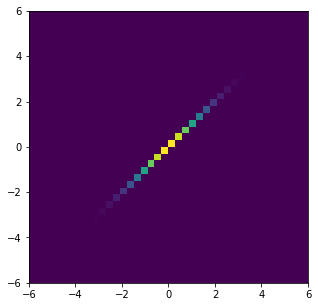

In [16]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

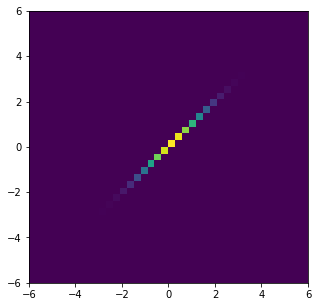

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

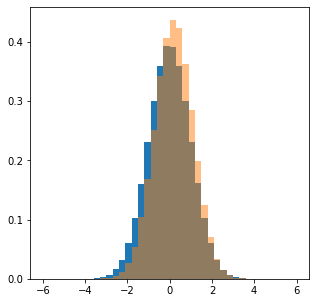

In [18]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [19]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[-0.38315251]
 [-0.32564217]
 [ 0.90934769]
 ...
 [-1.0428695 ]
 [-0.26286078]
 [ 0.45448989]]


In [20]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[-0.58315251]
 [-0.52564217]
 [ 0.70934769]
 ...
 [-1.2428695 ]
 [-0.46286078]
 [ 0.25448989]]


In [21]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [22]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [23]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [24]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [25]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [26]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [27]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [28]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 3.141593



In [29]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.52425983 0.53505467 0.37313255 ... 0.3275373  0.54503087 0.50882788]


In [30]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.50817864 0.5285807  0.45950486 ... 0.24158398 0.54922263 0.60231008]


In [31]:
pdf_ratio = pdf_true / pdf_train

In [32]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [33]:
calc_weight = pdf_ratio

In [34]:
calc_weight_scaled = sample_sf * pdf_ratio

## Set up NN model for OmniFold

In [35]:

import tensorflow.keras.backend as K


def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))

    return K.mean(t_loss)

In [36]:


from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=patience_setval,
               verbose=True,
               restore_best_weights=True)




#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)




#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#drop1 = Dropout(dropout_setval)(hidden_layer_1)
#hidden_layer_2 = Dense(50, activation='relu')(drop1)
#drop2 = Dropout(dropout_setval)(hidden_layer_2)
#hidden_layer_3 = Dense(50, activation='relu')(drop2)
#drop3 = Dropout(dropout_setval)(hidden_layer_3)
#outputs = Dense(1, activation='sigmoid')(drop3)



#model_step1 = Model(inputs=inputs, outputs=outputs)
#model_step2 = Model(inputs=inputs, outputs=outputs)


###================================

#model_step1 = Sequential()

#model_step1.add( Dense(50, input_dim=ndim, activation='relu') )
#model_step1.add( Dropout(dropout_setval) )
#model_step1.add( Dense(50, activation='relu') )
#model_step1.add( Dropout(dropout_setval) )
#model_step1.add( Dense(50, activation='relu') )
#model_step1.add( Dropout(dropout_setval) )
#model_step1.add( Dense(1, activation='sigmoid') )


#model_step2 = Sequential()

#model_step2.add( Dense(50, input_dim=ndim, activation='relu') )
#model_step2.add( Dropout(dropout_setval) )
#model_step2.add( Dense(50, activation='relu') )
#model_step2.add( Dropout(dropout_setval) )
#model_step2.add( Dense(50, activation='relu') )
#model_step2.add( Dropout(dropout_setval) )
#model_step2.add( Dense(1, activation='sigmoid') )

###================================



#-- off
l2reg_setval = 0.0

#-- crap
#l2reg_setval = 0.001

#-- not crap
#l2reg_setval = 0.0001

#-- not crap
#l2reg_setval = 0.00001

#-- not crap
#l2reg_setval = 0.000001

#-- not crap
#l2reg_setval = 0.0000001





#-- off
al2reg_setval = 0.0

#-- not crap
#al2reg_setval = 0.0001

#-- not crap
#al2reg_setval = 0.00001

#-- not crap
#al2reg_setval = 0.000001

#-- not crap
#al2reg_setval = 0.0000001

#-- not crap
#al2reg_setval = 0.001

#-- not crap but a bit too strong
#al2reg_setval = 0.01



model_step1 = Sequential()

model_step1.add( Dense(units_per_layer, input_dim=ndim, activation='relu', 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
if use_batch_norm : model_step1.add( BatchNormalization() )
model_step1.add( Dropout(dropout_setval) )

if number_of_layers > 1 :
    model_step1.add( Dense(units_per_layer, activation='relu', 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step1.add( BatchNormalization() )
    model_step1.add( Dropout(dropout_setval) )

if number_of_layers > 2 :
    model_step1.add( Dense(units_per_layer, activation='relu', 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step1.add( BatchNormalization() )
    model_step1.add( Dropout(dropout_setval) )

model_step1.add( Dense(1, activation='sigmoid') )





model_step2 = Sequential()

model_step2.add( Dense(units_per_layer, input_dim=ndim, activation='relu', 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
if use_batch_norm : model_step2.add( BatchNormalization() )
model_step2.add( Dropout(dropout_setval) )

if number_of_layers > 1 :
    model_step2.add( Dense(units_per_layer, activation='relu', 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step2.add( BatchNormalization() )
    model_step2.add( Dropout(dropout_setval) )

if number_of_layers > 2 :
    model_step2.add( Dense(units_per_layer, activation='relu', 
                       kernel_regularizer=l2(l2reg_setval), 
                       bias_regularizer=l2(l2reg_setval), 
                       activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step2.add( BatchNormalization() )
    model_step2.add( Dropout(dropout_setval) )

model_step2.add( Dense(1, activation='sigmoid') )


#----








#----


#-- off
#l1reg_setval = 0.0

#-- crap
#l1reg_setval = 0.001

#-- 
#l1reg_setval = 0.0001

#-- not crap but slow
#l1reg_setval = 0.00001

#-- may be doing nothing
#l1reg_setval = 0.000001



#-- off
#al1reg_setval = 0.0

#-- may be doing nothing
#al1reg_setval = 0.00001

#-- closure not great 
#al1reg_setval = 0.0001

#-- crap
#al1reg_setval = 0.001




#model_step1 = Sequential()

#model_step1.add( Dense(50, input_dim=ndim, activation='relu', 
#                       kernel_regularizer=l1(l1reg_setval), 
#                       bias_regularizer=l1(l1reg_setval), 
#                       activity_regularizer=l1(al1reg_setval) ) )
#model_step1.add( Dropout(dropout_setval) )
#model_step1.add( Dense(50, activation='relu', 
#                       kernel_regularizer=l1(l1reg_setval), 
#                       bias_regularizer=l1(l1reg_setval), 
#                       activity_regularizer=l1(al1reg_setval) ) )
#model_step1.add( Dropout(dropout_setval) )
#model_step1.add( Dense(50, activation='relu', 
#                       kernel_regularizer=l1(l1reg_setval), 
#                       bias_regularizer=l1(l1reg_setval), 
#                       activity_regularizer=l1(al1reg_setval) ) )
#model_step1.add( Dropout(dropout_setval) )
#model_step1.add( Dense(1, activation='sigmoid') )


#model_step2 = Sequential()

#model_step2.add( Dense(50, input_dim=ndim, activation='relu', 
#                       kernel_regularizer=l1(l1reg_setval), 
#                       bias_regularizer=l1(l1reg_setval), 
#                       activity_regularizer=l1(al1reg_setval) ) )
#model_step2.add( Dropout(dropout_setval) )
#model_step2.add( Dense(50, activation='relu', 
#                       kernel_regularizer=l1(l1reg_setval), 
#                       bias_regularizer=l1(l1reg_setval), 
#                       activity_regularizer=l1(al1reg_setval) ) )
#model_step2.add( Dropout(dropout_setval) )
#model_step2.add( Dense(50, activation='relu', 
#                       kernel_regularizer=l1(l1reg_setval), 
#                       bias_regularizer=l1(l1reg_setval), 
#                       activity_regularizer=l1(al1reg_setval) ) )
#model_step2.add( Dropout(dropout_setval) )
#model_step2.add( Dense(1, activation='sigmoid') )

#----









opt_step1 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )
opt_step2 = tf.keras.optimizers.Adam( learning_rate=(0.04*learning_rate_setval) )  # owen: use lower learning rate in step 2

model_step1.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step1,
                      metrics=['accuracy'])

model_step2.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step2,
                      metrics=['accuracy'])

print('\n\n ------ model_step1:')
model_step1.summary()

print('\n\n ------ model_step2:')
model_step2.summary()



 ------ model_step1:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                100       
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (Non

## Package the training data for OmniFold

In [37]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [38]:
%%time


#verbose = True
verbose = False






of_return_dict = of.omnifold8b( 
    train_both, true_det_pts, of_niter, model_step1, model_step2, verbose, 
    batch_size_setval, epochs_setval,
    save_step2_model, output_dir,
    patience_setval
)

of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 312.
Epoch 337: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97234058 0.98340589 1.1735853  ... 0.79714316 0.99502993 1.12366891]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96588996 0.98004106 1.21922659 ... 0.74708928 0.99673825 1.15994881]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96415861 0.97881844 1.24105103 ... 0.73342516 0.99758627 1.17772842]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 605us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 607us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96614035 0.9802582  1.24914272 ... 0.7381008  1.00009777 1.18540641]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/of-step2-iter04-model/assets


CPU times: user 2min 26s, sys: 15.6 s, total: 2min 42s
Wall time: 1min 1s


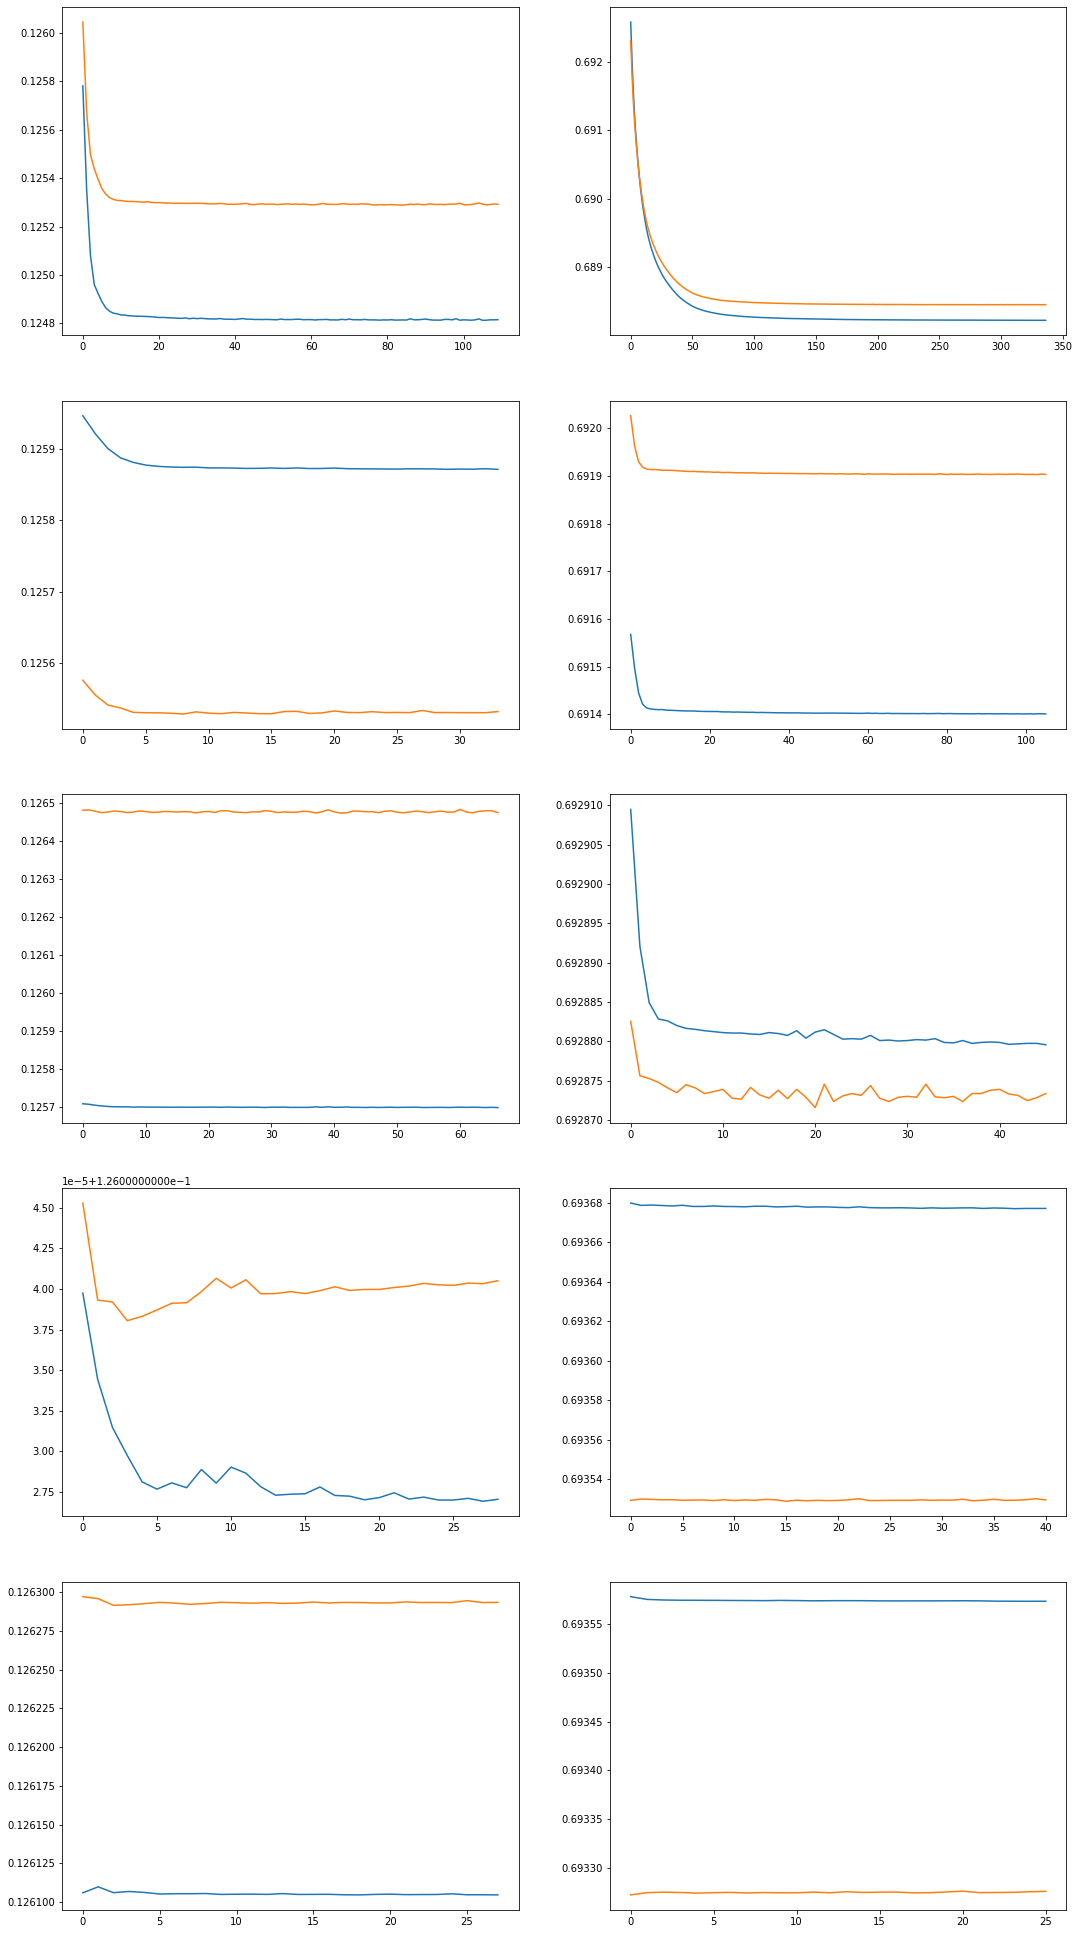

In [39]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['val_loss']  )
    



<function matplotlib.pyplot.show(close=None, block=None)>

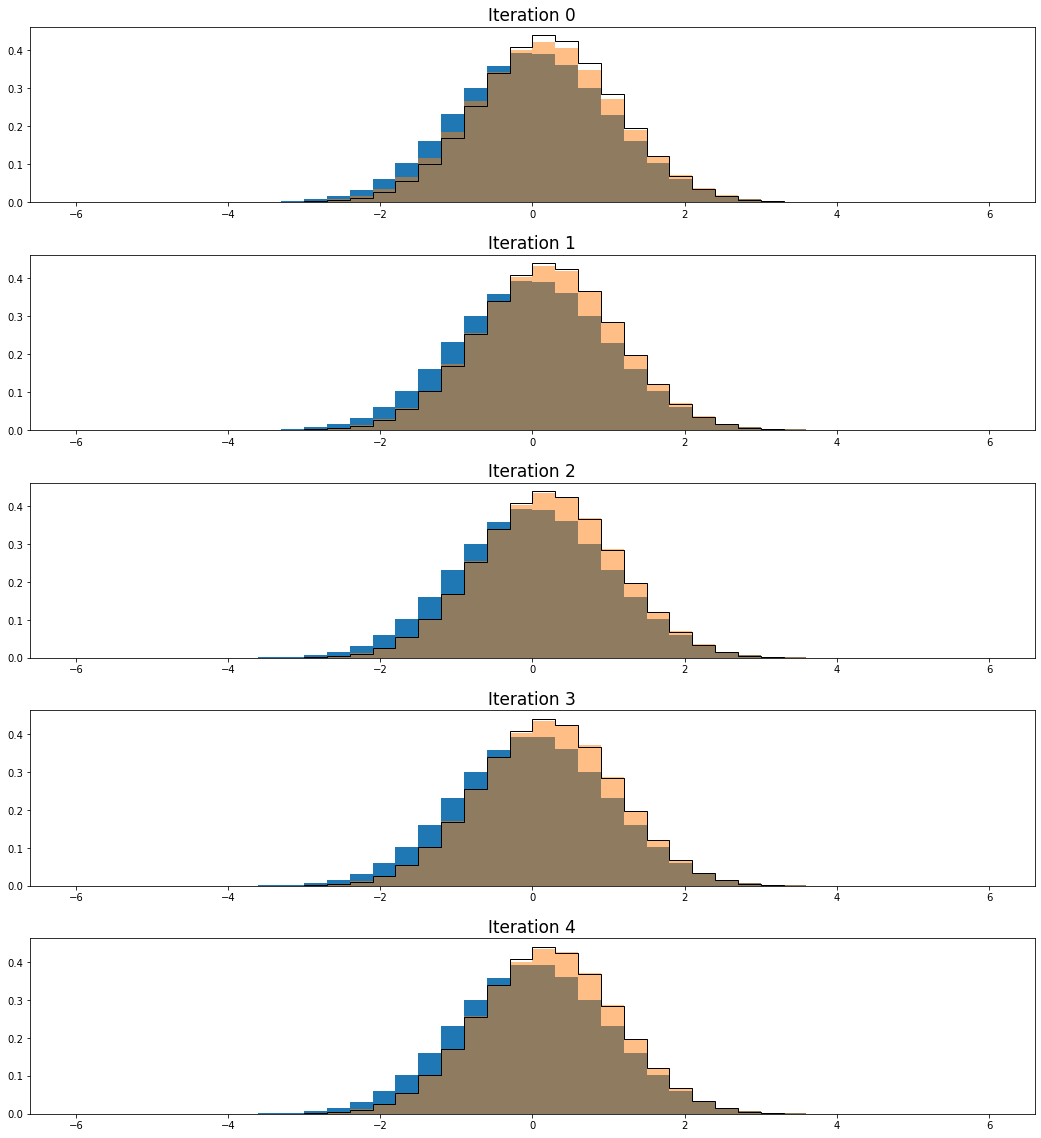

In [40]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [41]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

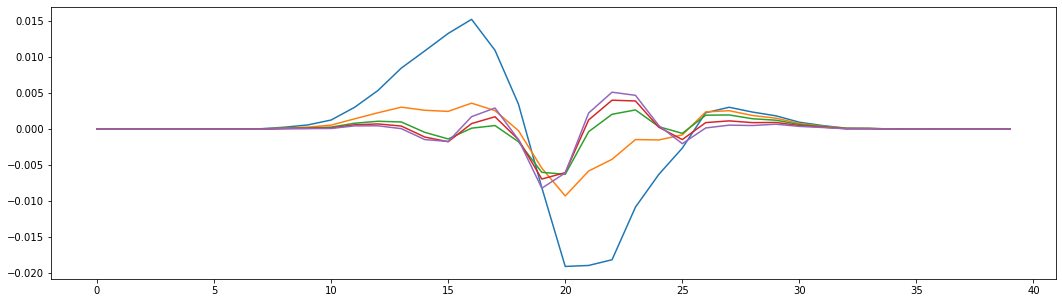

In [42]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

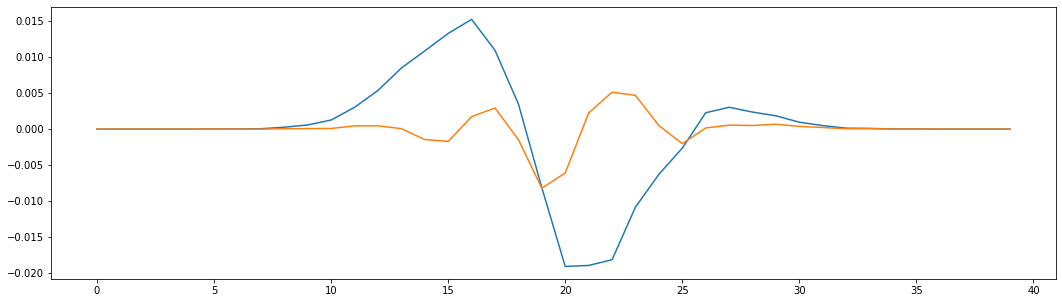

In [43]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

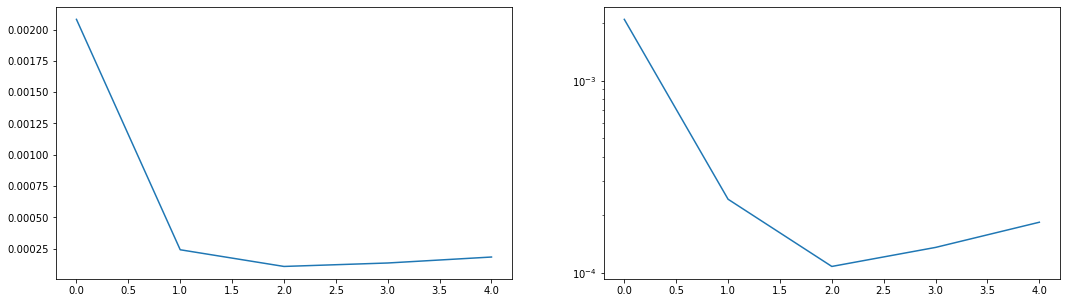

In [44]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

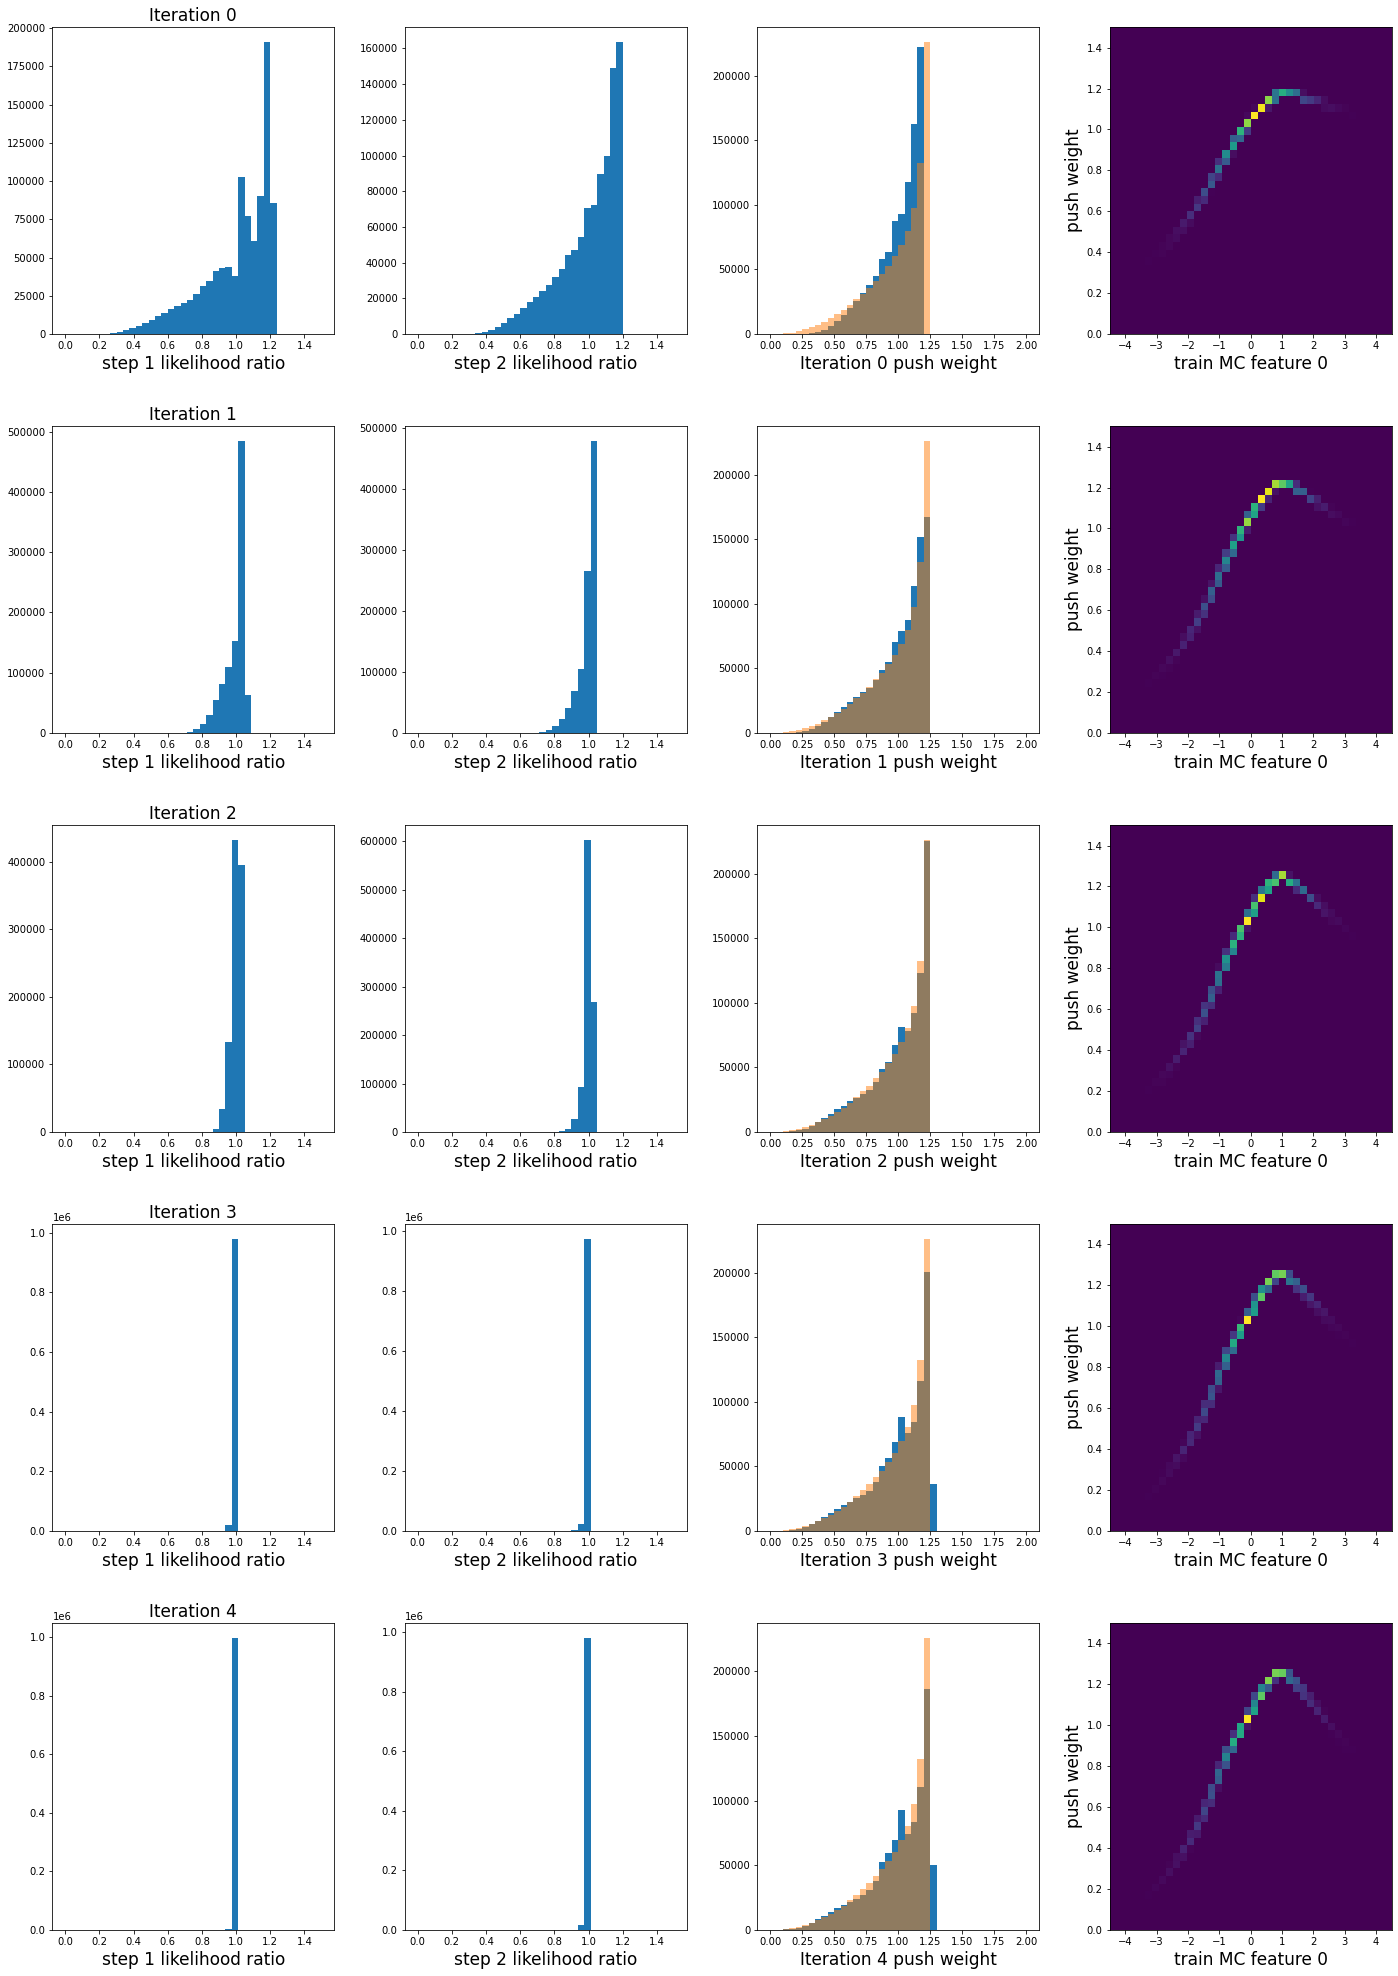

In [45]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    #ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )

    ax[ofi][3].hist2d( train_pts[:,0], push_weights[ofi,:], 
                      bins=[hbins,hbins], range=([-4.5,4.5],[0.,1.5]) )
    
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    #ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    #ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    
    ax[ofi][3].set_xlabel( 'train MC feature 0' , fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'push weight' , fontsize=lfontsize )
    
    
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

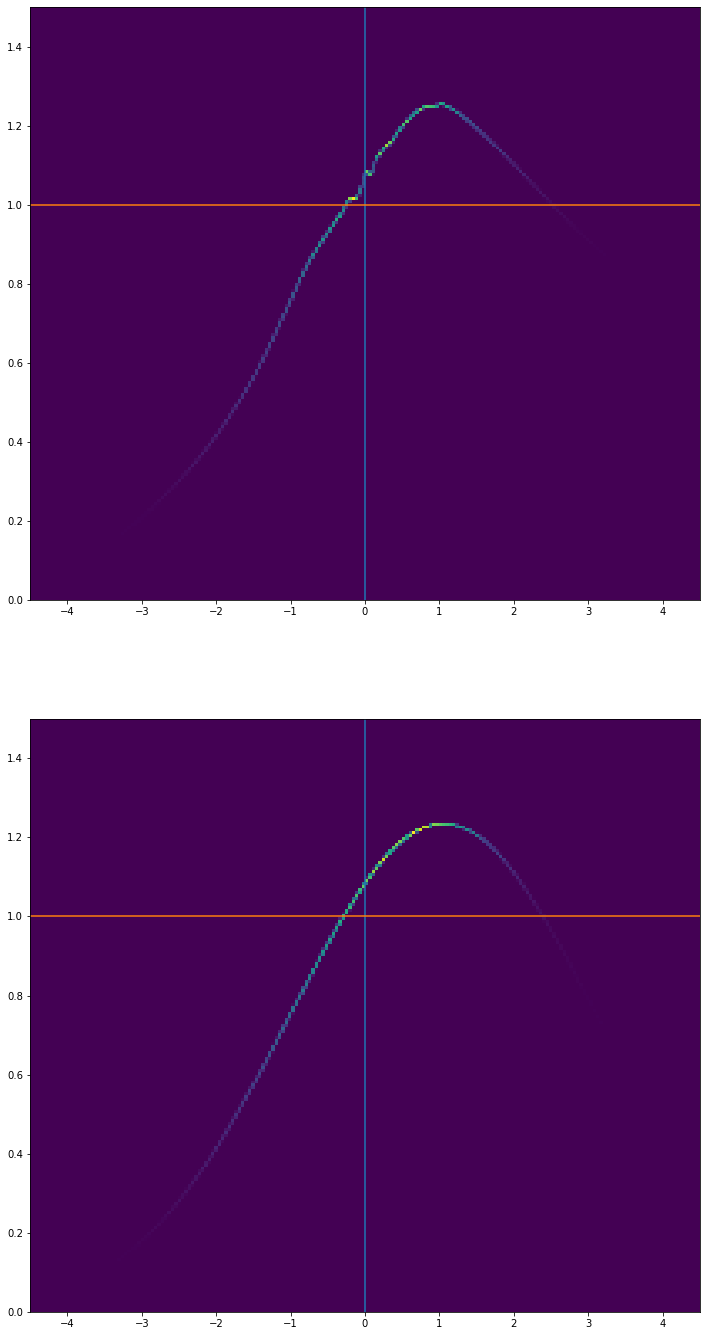

In [46]:
fig,ax = plt.subplots( 2, 1, figsize=(12,2*12))

hbins=200

hpw,_,_,_ = ax[0].hist2d( train_pts[:,0], push_weights[-1,:], 
                      bins=[hbins,hbins], range=([-4.5,4.5],[0.,1.5]) )

hcw,_,_,_ = ax[1].hist2d( train_pts[:,0], calc_weight, 
                      bins=[hbins,hbins], range=([-4.5,4.5],[0.,1.5]) )

ax[0].plot([0,0],[0,1.5])
ax[0].plot([-4.5,4.5],[1,1])

ax[1].plot([0,0],[0,1.5])
ax[1].plot([-4.5,4.5],[1,1])

plt.show

In [47]:
fpw = np.zeros( hpw.shape[0])

for bi0 in range(hpw.shape[0]) :
    esum = 0
    biesum = 0    
    for bi1 in range(hpw.shape[1]) :
        esum += hpw[bi0,bi1]
        biesum += bi1*hpw[bi0,bi1]
        #print(' %3d, %3d :  %8.0f    %8.0f  %8.0f' % (bi0, bi1, hpw[bi1,bi0], esum, biesum))
    wave = 0
    if esum > 0 :
        wave = biesum / esum
    fpw[bi0] = wave
    #print(' %3d : %8.3f' % (bi0, wave))

In [48]:
fcw = np.zeros( hcw.shape[0])

for bi0 in range(hcw.shape[0]) :
    esum = 0
    biesum = 0    
    for bi1 in range(hcw.shape[1]) :
        esum += hcw[bi0,bi1]
        biesum += bi1*hcw[bi0,bi1]
    wave = 0
    if esum > 0 :
        wave = biesum / esum
    fcw[bi0] = wave


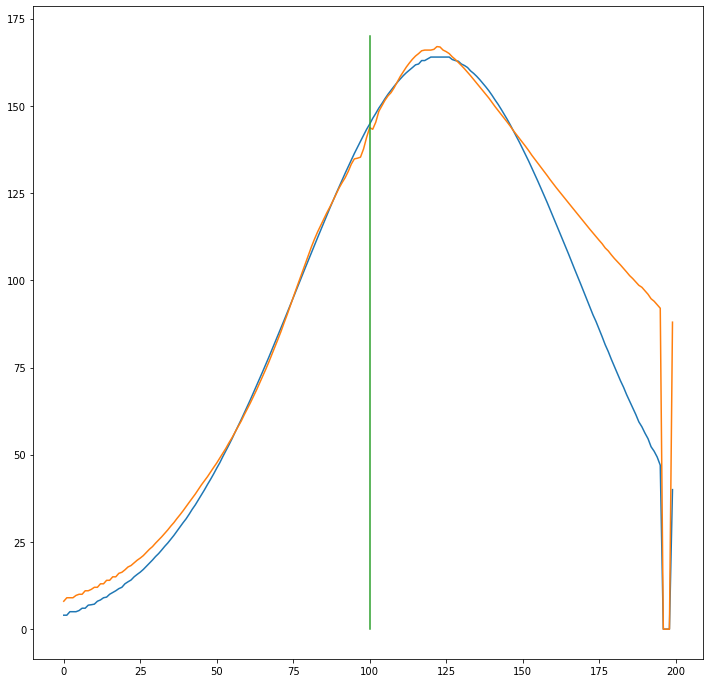

In [49]:
fig,ax = plt.subplots( 1, 1, figsize=(12,12))
ax.plot(fcw)
ax.plot(fpw)
ax.plot([100,100],[0,170])

<function matplotlib.pyplot.show(close=None, block=None)>

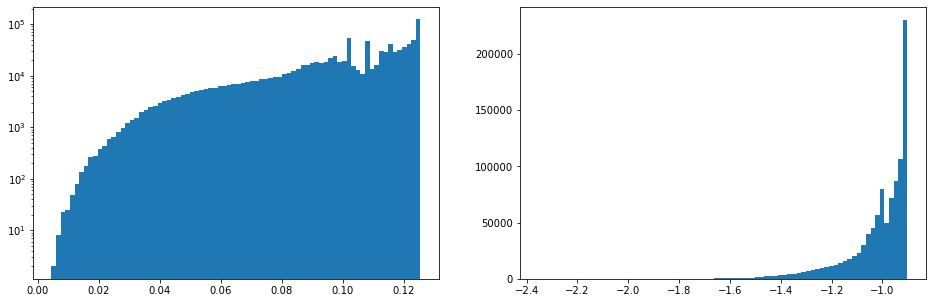

In [50]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

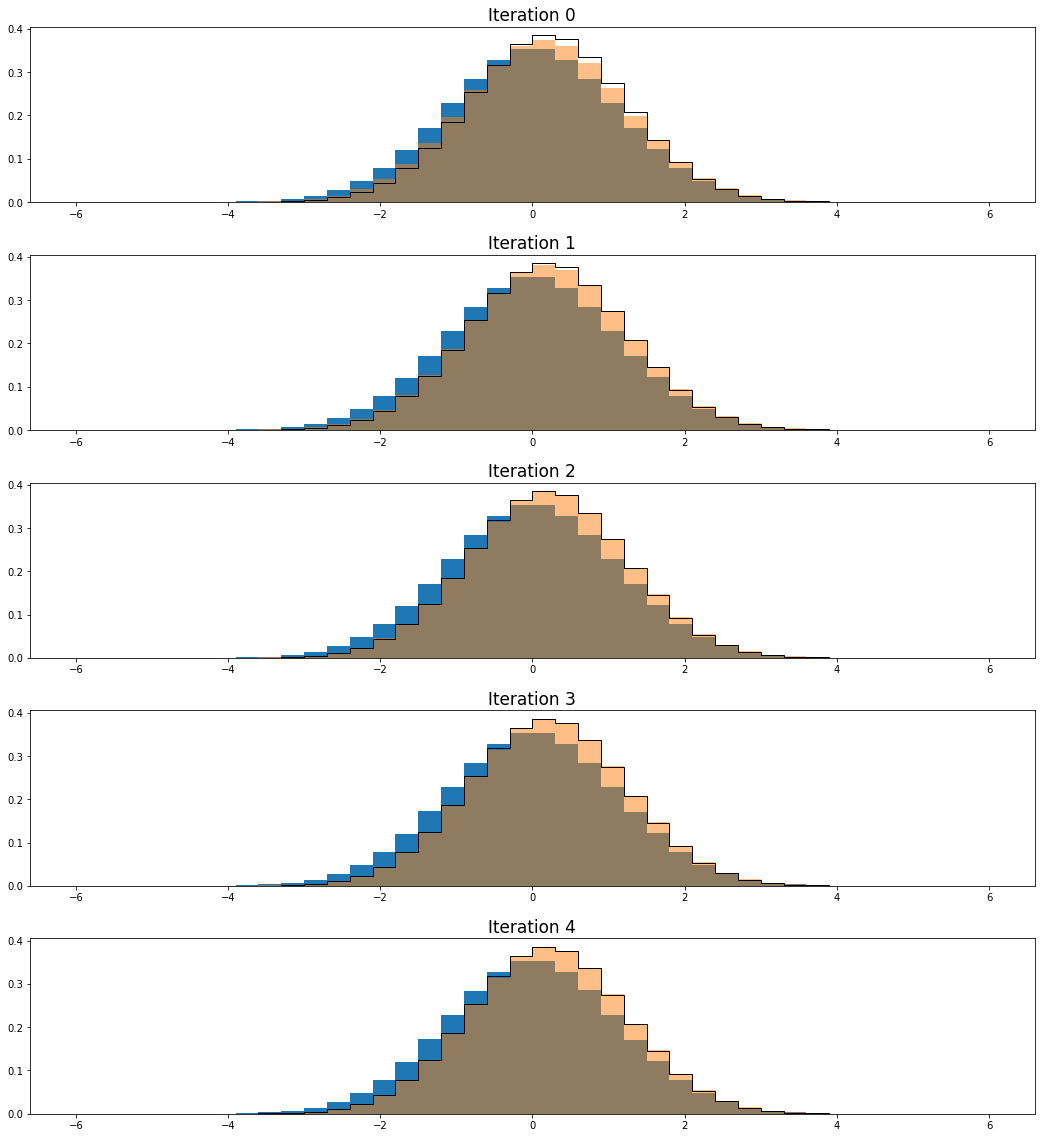

In [51]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [52]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

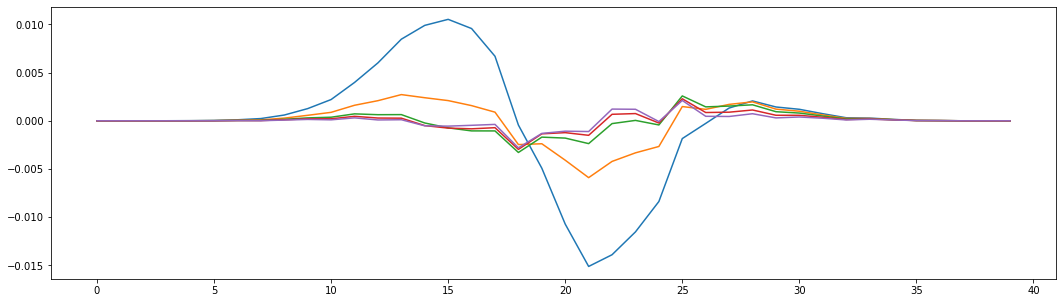

In [53]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

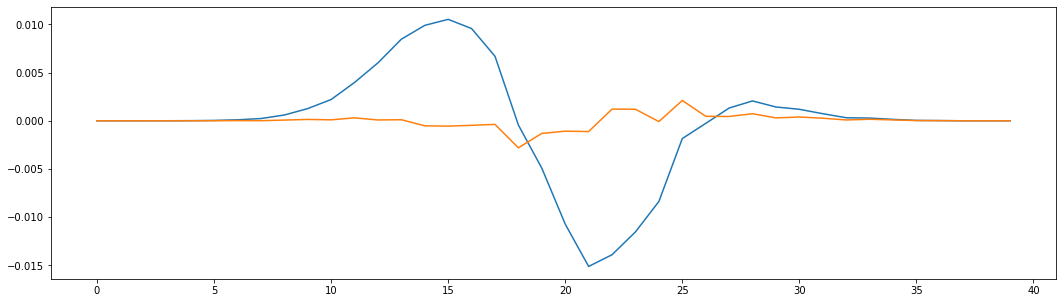

In [54]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

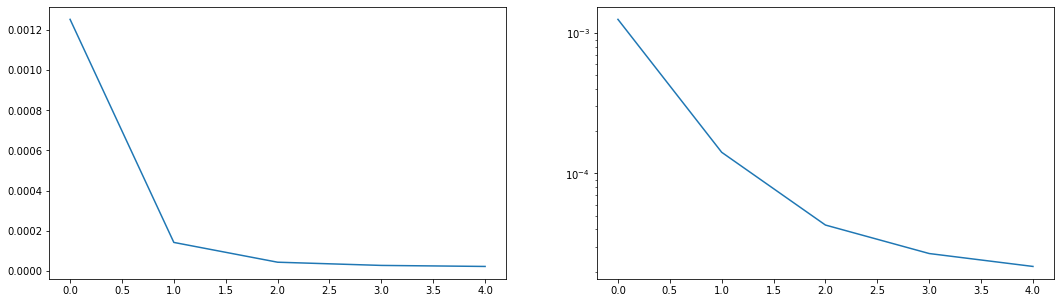

In [55]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [56]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  0.999  rms 0.200      step 2 mean  0.997  rms 0.175
  iter  1 : step 1 mean  0.992  rms 0.063      step 2 mean  0.991  rms 0.055
  iter  2 : step 1 mean  0.999  rms 0.027      step 2 mean  0.997  rms 0.024
  iter  3 : step 1 mean  1.001  rms 0.008      step 2 mean  1.001  rms 0.009
  iter  4 : step 1 mean  0.996  rms 0.004      step 2 mean  0.998  rms 0.007


<function matplotlib.pyplot.show(close=None, block=None)>

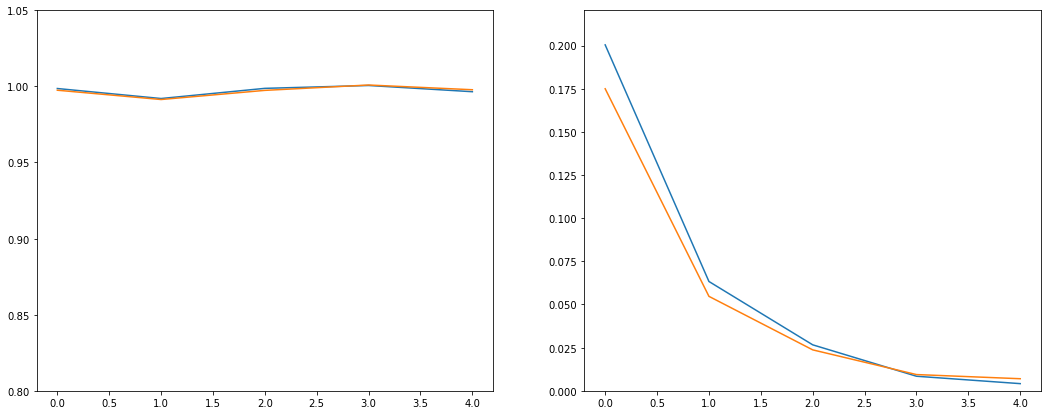

In [57]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

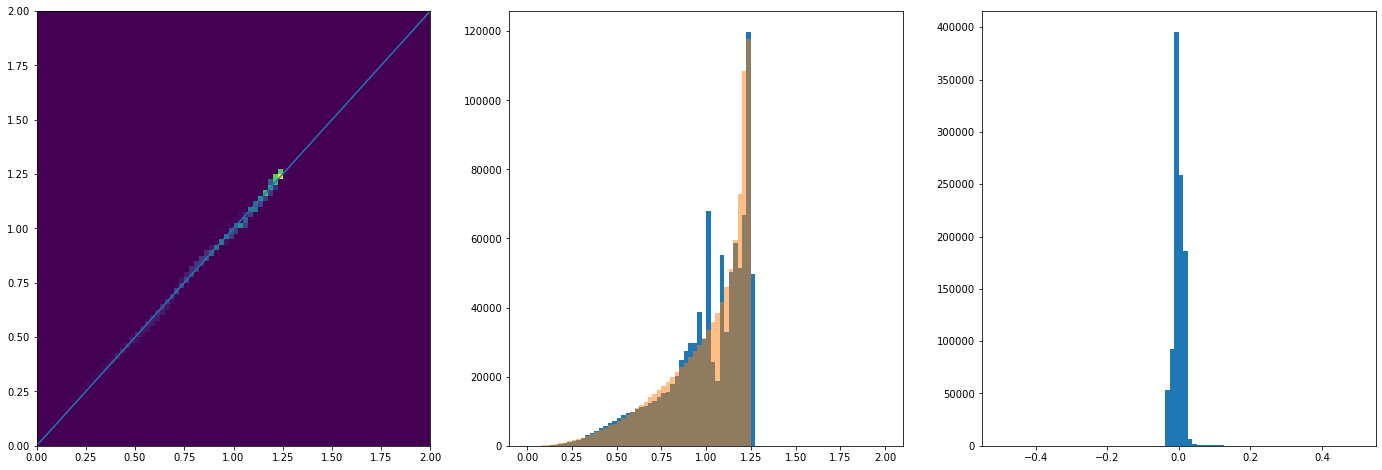

In [58]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [59]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.01567




In [60]:

verbose = False



import gc

In [61]:
try:
    os.mkdir( "%s/bootstrap-nn-models" % output_dir )
except :
    print('problem creating bootstrap-nn-models dir')


In [62]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        print("\n Creating bootstrap sample %3d" % bi )
        boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        
    modeldir = "%s/bootstrap-nn-models/bs-%03d" % (output_dir, bi) 
    
    try:
        os.mkdir( modeldir )
    except :
        print('\n\n *** probelm creating model output directory : %s' % modeldir )

        

    #-- Reset the model to ensure fresh random weights for each bootstrap


    model_step1 = Sequential()

    model_step1.add( Dense(units_per_layer, input_dim=ndim, activation='relu', 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step1.add( BatchNormalization() )
    model_step1.add( Dropout(dropout_setval) )

    if number_of_layers > 1 :
        model_step1.add( Dense(units_per_layer, activation='relu', 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
        if use_batch_norm : model_step1.add( BatchNormalization() )
        model_step1.add( Dropout(dropout_setval) )

    if number_of_layers > 2 :
        model_step1.add( Dense(units_per_layer, activation='relu', 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
        if use_batch_norm : model_step1.add( BatchNormalization() )
        model_step1.add( Dropout(dropout_setval) )

    model_step1.add( Dense(1, activation='sigmoid') )





    model_step2 = Sequential()

    model_step2.add( Dense(units_per_layer, input_dim=ndim, activation='relu', 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
    if use_batch_norm : model_step2.add( BatchNormalization() )
    model_step2.add( Dropout(dropout_setval) )

    if number_of_layers > 1 :
        model_step2.add( Dense(units_per_layer, activation='relu', 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
        if use_batch_norm : model_step2.add( BatchNormalization() )
        model_step2.add( Dropout(dropout_setval) )

    if number_of_layers > 2 :
        model_step2.add( Dense(units_per_layer, activation='relu', 
                           kernel_regularizer=l2(l2reg_setval), 
                           bias_regularizer=l2(l2reg_setval), 
                           activity_regularizer=l2(al2reg_setval) ) )
        if use_batch_norm : model_step2.add( BatchNormalization() )
        model_step2.add( Dropout(dropout_setval) )

    model_step2.add( Dense(1, activation='sigmoid') )



    opt_step1 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )
    opt_step2 = tf.keras.optimizers.Adam( learning_rate=(0.04*learning_rate_setval) )  # owen: use lower learning rate in step 2

    model_step1.compile(loss=weighted_binary_crossentropy,
                          optimizer=opt_step1,
                          metrics=['accuracy'])

    model_step2.compile(loss=weighted_binary_crossentropy,
                          optimizer=opt_step2,
                          metrics=['accuracy'])


        
        
    boot_of_return_dict = of.omnifold8b( 
        train_both, boot_true_det_pts, of_niter, model_step1, model_step2, verbose, 
        batch_size_setval, epochs_setval, True, modeldir, patience_setval )



    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = boot_of_return_dict["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )

    with open( '%s/bootstrap-points-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_true_det_pts )
        
        
    del boot_final_push_weights_scaled
    del boot_of_return_dict
    gc.collect()
    
    


 Creating toy sample   0
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 539.
Epoch 564: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-000/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-000/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-000/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96792591 0.98077619 1.17887676 ... 0.80559802 0.99531424 1.12634087]
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-000/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-000/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-000/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96932634 0.98412904 1.22382471 ... 0.75776781 0.99987375 1.16227643]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-000/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-000/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-000/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97337543 0.9873921  1.23468325 ... 0.74184495 1.00190875 1.170607  ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-000/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-000/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-000/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97871305 0.99073002 1.24474295 ... 0.74383244 1.00325887 1.17344525]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 572us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-000/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-000/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-000/of-step2-iter04-model/assets




 bootstrap 0 final push weights scaled:
[0.09829624 0.09935264 0.12471886 ... 0.0740127  0.10047238 0.11742211]

 Creating toy sample   1
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 132.
Epoch 157: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 381.
Epoch 406: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-001/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-001/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-001/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97965968 0.99203724 1.17301238 ... 0.81340808 1.00537622 1.12874579]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-001/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-001/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-001/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96469491 0.98076889 1.21167171 ... 0.75748402 0.99829074 1.15837511]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-001/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-001/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-001/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96565723 0.9831513  1.2308024  ... 0.75112696 1.00363051 1.17485618]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-001/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-001/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-001/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96465769 0.98269908 1.23311491 ... 0.75370244 1.00495914 1.17681329]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 589us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-001/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-001/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-001/of-step2-iter04-model/assets




 bootstrap 1 final push weights scaled:
[0.09606536 0.0979247  0.12404765 ... 0.07544144 0.10030828 0.11787981]

 Creating toy sample   2
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 435.
Epoch 460: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-002/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-002/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-002/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9738161  0.98591191 1.1576395  ... 0.81265879 0.99902487 1.12383723]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 614us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-002/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-002/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-002/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97847471 0.99537788 1.21585442 ... 0.76512111 1.0136121  1.18314   ]
Restoring model weights from the end of the best epoch: 113.
Epoch 138: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 571us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-002/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-002/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-002/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9801483  0.99918693 1.22100056 ... 0.74825683 1.01897015 1.19634076]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 770us/step
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-002/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-002/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-002/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98377242 1.00373881 1.22083695 ... 0.74707387 1.02405127 1.20048173]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 751us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 792us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-002/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-002/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-002/of-step2-iter04-model/assets




 bootstrap 2 final push weights scaled:
[0.0986198  0.10069586 0.12327213 ... 0.07460131 0.10277691 0.12103396]

 Creating toy sample   3
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 124.
Epoch 149: early stopping
100/100 [==============================] - 0s 853us/step
Restoring model weights from the end of the best epoch: 293.
Epoch 318: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-003/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-003/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-003/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98684257 0.99754107 1.17053199 ... 0.81439483 1.00833488 1.12786889]
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 731us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-003/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-003/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-003/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97797804 0.99090763 1.20179163 ... 0.75587745 1.00673461 1.16535692]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 601us/step
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-003/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-003/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-003/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98113118 0.99442009 1.21769216 ... 0.74240957 1.01250444 1.18208556]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 858us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-003/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-003/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-003/of-step2-iter03-model/assets


 weights_push at the beginning
[0.975434   0.9882814  1.21386973 ... 0.73772356 1.0081587  1.17885035]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 584us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-003/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-003/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-003/of-step2-iter04-model/assets




 bootstrap 3 final push weights scaled:
[0.09784223 0.09907654 0.1223473  ... 0.07436843 0.10116119 0.11890159]

 Creating toy sample   4
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 172.
Epoch 197: early stopping
100/100 [==============================] - 0s 753us/step
Restoring model weights from the end of the best epoch: 461.
Epoch 486: early stopping
100/100 [==============================] - 0s 919us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-004/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-004/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-004/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9710663  0.98391157 1.17548132 ... 0.80940497 0.99870712 1.12374043]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 592us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-004/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-004/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-004/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96435105 0.98072735 1.21489548 ... 0.75829549 0.99676128 1.15945706]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-004/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-004/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-004/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96581541 0.98173653 1.2257966  ... 0.74711194 0.995545   1.16937918]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 785us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 795us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-004/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-004/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-004/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96728935 0.98210553 1.23021546 ... 0.74648668 0.99297562 1.1708882 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 810us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-004/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-004/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-004/of-step2-iter04-model/assets




 bootstrap 4 final push weights scaled:
[0.09742636 0.09870581 0.12413269 ... 0.07572424 0.09943826 0.11750324]

 Creating toy sample   5
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 603us/step
Restoring model weights from the end of the best epoch: 353.
Epoch 378: early stopping
100/100 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-005/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-005/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-005/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98598742 0.99882913 1.15790784 ... 0.81006819 1.01053202 1.12597358]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 611us/step
Restoring model weights from the end of the best epoch: 121.
Epoch 146: early stopping
100/100 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-005/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-005/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-005/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98414653 0.99932981 1.19853037 ... 0.7585408  1.01427498 1.16560732]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 606us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-005/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-005/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-005/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98520909 1.00060676 1.20273779 ... 0.74737619 1.01544685 1.17637576]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-005/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-005/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-005/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98608348 1.00066282 1.2081662  ... 0.74339542 1.01457995 1.18045968]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-005/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-005/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-005/of-step2-iter04-model/assets




 bootstrap 5 final push weights scaled:
[0.09881326 0.10019322 0.12141609 ... 0.07440151 0.10150235 0.11858312]

 Creating toy sample   6
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 576us/step
Restoring model weights from the end of the best epoch: 351.
Epoch 376: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-006/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-006/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-006/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97634637 0.98964411 1.18064117 ... 0.80671859 1.00465739 1.13392973]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-006/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-006/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-006/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96785494 0.98617701 1.22591072 ... 0.75250729 1.00672859 1.17360223]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-006/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-006/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-006/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96287058 0.98341061 1.22594404 ... 0.73911254 1.00364328 1.1761524 ]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-006/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-006/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-006/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96597753 0.98750422 1.23316195 ... 0.74256633 1.00592273 1.18138428]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 690us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-006/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-006/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-006/of-step2-iter04-model/assets




 bootstrap 6 final push weights scaled:
[0.09642905 0.09876876 0.12447904 ... 0.07367314 0.10054925 0.11909328]

 Creating toy sample   7
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 677us/step
Restoring model weights from the end of the best epoch: 375.
Epoch 400: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-007/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-007/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-007/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96881109 0.98201293 1.17870557 ... 0.79566348 0.99681783 1.13018501]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 587us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-007/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-007/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-007/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96756038 0.98517404 1.22373398 ... 0.75203259 1.00325033 1.1681018 ]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 582us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-007/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-007/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-007/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97107244 0.99084519 1.23908031 ... 0.73998346 1.00968942 1.18536514]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-007/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-007/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-007/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97684821 0.99757189 1.23942654 ... 0.74294468 1.01567959 1.19061044]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-007/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-007/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-007/of-step2-iter04-model/assets




 bootstrap 7 final push weights scaled:
[0.09781809 0.1000026  0.12432471 ... 0.07405451 0.10176325 0.11970634]

 Creating toy sample   8
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 682us/step
Restoring model weights from the end of the best epoch: 449.
Epoch 474: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-008/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-008/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-008/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97941327 0.99111843 1.16311705 ... 0.80652183 1.00228667 1.12538373]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-008/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-008/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-008/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97822284 0.99413848 1.20478005 ... 0.76041055 1.0104216  1.16355037]
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-008/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-008/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-008/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97561746 0.99279664 1.21984058 ... 0.74613394 1.0120377  1.17719391]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 697us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-008/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-008/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-008/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97603697 0.99345585 1.22723267 ... 0.74519423 1.01476305 1.18283415]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-008/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-008/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-008/of-step2-iter04-model/assets




 bootstrap 8 final push weights scaled:
[0.09726018 0.09904022 0.12310177 ... 0.07443004 0.10137571 0.11834705]

 Creating toy sample   9
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 167.
Epoch 192: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 402.
Epoch 427: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-009/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-009/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-009/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97314686 0.98666412 1.16465294 ... 0.80885881 1.00264275 1.11886799]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 588us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-009/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-009/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-009/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97643592 0.99502498 1.20940178 ... 0.76221757 1.01260224 1.16219604]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 602us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-009/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-009/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-009/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9794941  0.99952647 1.22089964 ... 0.7465235  1.01378762 1.17412722]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 111.
Epoch 136: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-009/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-009/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-009/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98676913 1.00517407 1.22843947 ... 0.75764205 1.01800056 1.17775069]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-009/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-009/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-009/of-step2-iter04-model/assets




 bootstrap 9 final push weights scaled:
[0.09852221 0.10035399 0.12287499 ... 0.07506909 0.10173699 0.11778773]

 Creating toy sample  10
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 442.
Epoch 467: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-010/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-010/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-010/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97500414 0.98880893 1.17071962 ... 0.80202651 0.99963188 1.13170946]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-010/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-010/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-010/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97094697 0.9887375  1.20794352 ... 0.7477356  1.00438789 1.17122832]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 680us/step
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-010/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-010/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-010/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96561421 0.98451192 1.21758794 ... 0.74131693 1.00165542 1.18331561]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-010/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-010/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-010/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96259378 0.98274936 1.22680889 ... 0.7357872  1.00143285 1.19549013]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 592us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-010/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-010/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-010/of-step2-iter04-model/assets




 bootstrap 10 final push weights scaled:
[0.09572886 0.09784772 0.1230128  ... 0.07319202 0.09984178 0.12005452]

 Creating toy sample  11
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 108.
Epoch 133: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 298.
Epoch 323: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-011/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-011/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-011/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97280002 0.98548037 1.17813087 ... 0.80680674 0.99940103 1.13202822]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 128.
Epoch 153: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-011/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-011/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-011/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96792286 0.98252179 1.22688956 ... 0.75528633 0.99889893 1.17130924]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-011/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-011/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-011/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9683229  0.98172885 1.23795475 ... 0.74435676 0.99833759 1.18473503]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-011/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-011/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-011/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96558084 0.9774094  1.2381466  ... 0.74205429 0.99378958 1.18839744]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-011/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-011/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-011/of-step2-iter04-model/assets




 bootstrap 11 final push weights scaled:
[0.09653023 0.09751514 0.12410651 ... 0.07481606 0.09908549 0.11924635]

 Creating toy sample  12
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 170.
Epoch 195: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 546.
Epoch 571: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-012/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-012/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-012/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97707295 0.99104905 1.172194   ... 0.80379921 1.00502491 1.12887406]
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-012/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-012/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-012/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97381977 0.99243533 1.2099016  ... 0.7565057  1.00745414 1.16989842]
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-012/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-012/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-012/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97330591 0.99270318 1.21456258 ... 0.7462381  1.00250365 1.18100496]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-012/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-012/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-012/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97591722 0.99365439 1.21244181 ... 0.75140864 0.99707077 1.18236777]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 891us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-012/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-012/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-012/of-step2-iter04-model/assets




 bootstrap 12 final push weights scaled:
[0.09749574 0.09915995 0.12209828 ... 0.07499092 0.09918211 0.11909507]

 Creating toy sample  13
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 360.
Epoch 385: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-013/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-013/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-013/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97780526 0.98999548 1.17992342 ... 0.81356519 1.00216937 1.12524271]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 614us/step
Restoring model weights from the end of the best epoch: 104.
Epoch 129: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-013/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-013/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-013/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95818191 0.97244404 1.20556351 ... 0.76219152 0.98733875 1.14614069]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 601us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-013/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-013/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-013/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95801286 0.97182866 1.22952299 ... 0.74822316 0.98792666 1.17020626]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-013/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-013/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-013/of-step2-iter03-model/assets


 weights_push at the beginning
[0.94891948 0.96111412 1.21864138 ... 0.7417161  0.97727206 1.16654154]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-013/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-013/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-013/of-step2-iter04-model/assets




 bootstrap 13 final push weights scaled:
[0.09535649 0.09638826 0.12322124 ... 0.07480662 0.09808201 0.11838609]

 Creating toy sample  14
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 151.
Epoch 176: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 342.
Epoch 367: early stopping
100/100 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-014/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-014/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-014/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97655034 0.98892981 1.17920566 ... 0.81016481 0.99882364 1.13312507]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-014/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-014/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-014/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96624899 0.97923056 1.20982539 ... 0.75540268 0.99112726 1.16408059]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-014/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-014/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-014/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9676295  0.97945749 1.22850955 ... 0.74667881 0.99275479 1.17957778]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 687us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-014/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-014/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-014/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96819021 0.97778297 1.24044579 ... 0.74815657 0.99119672 1.18614598]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-014/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-014/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-014/of-step2-iter04-model/assets




 bootstrap 14 final push weights scaled:
[0.0963392  0.09707342 0.12441138 ... 0.0748429  0.0984195  0.11840907]

 Creating toy sample  15
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 351.
Epoch 376: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-015/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-015/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-015/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98593283 1.00076461 1.17080998 ... 0.81446004 1.01387787 1.126526  ]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 783us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-015/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-015/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-015/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98238076 1.00104974 1.20705626 ... 0.75910665 1.01672554 1.15922968]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 589us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-015/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-015/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-015/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98747723 1.00649377 1.22269463 ... 0.74751437 1.01943225 1.17354903]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-015/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-015/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-015/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9922996  1.01032856 1.22832768 ... 0.74632866 1.01848331 1.17830402]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-015/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-015/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-015/of-step2-iter04-model/assets




 bootstrap 15 final push weights scaled:
[0.09940419 0.1010848  0.12303087 ... 0.07462265 0.10145364 0.11789486]

 Creating toy sample  16
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 181.
Epoch 206: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 467.
Epoch 492: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-016/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-016/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-016/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96322751 0.97667748 1.18076694 ... 0.79907423 0.98876476 1.12442994]
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 131.
Epoch 156: early stopping
100/100 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-016/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-016/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-016/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95773609 0.97439669 1.23918167 ... 0.75209183 0.98964655 1.16711497]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-016/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-016/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-016/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95632602 0.97364823 1.25016628 ... 0.74035433 0.9883336  1.17376738]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 593us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-016/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-016/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-016/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96070328 0.97752119 1.26127448 ... 0.74559566 0.99082393 1.17793557]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-016/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-016/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-016/of-step2-iter04-model/assets




 bootstrap 16 final push weights scaled:
[0.09574308 0.09739892 0.12668182 ... 0.07417525 0.09860796 0.11775644]

 Creating toy sample  17
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 319.
Epoch 344: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-017/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-017/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-017/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97324264 0.98545754 1.17152202 ... 0.79509377 0.99738991 1.12197375]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-017/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-017/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-017/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97386636 0.98823737 1.22222396 ... 0.75308591 1.00275162 1.16001832]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 946us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-017/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-017/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-017/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96984574 0.98429171 1.23933182 ... 0.74113481 0.99915499 1.16822069]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-017/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-017/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-017/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97157337 0.98548667 1.25473843 ... 0.74167198 1.00036489 1.17520124]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-017/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-017/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-017/of-step2-iter04-model/assets




 bootstrap 17 final push weights scaled:
[0.09692385 0.09822861 0.12586113 ... 0.07424713 0.0996855  0.11724419]

 Creating toy sample  18
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 197.
Epoch 222: early stopping
100/100 [==============================] - 0s 977us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-018/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-018/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-018/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97861165 0.99187255 1.15681624 ... 0.80018282 1.0020647  1.12167132]
Restoring model weights from the end of the best epoch: 138.
Epoch 163: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-018/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-018/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-018/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98620759 1.00024267 1.22196918 ... 0.7609508  1.01062763 1.18291003]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 122.
Epoch 147: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-018/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-018/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-018/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97638267 0.9917457  1.21581637 ... 0.74197431 1.00231013 1.17983155]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-018/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-018/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-018/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9809303  0.99765779 1.23154866 ... 0.74056393 1.00777082 1.19637711]
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 907us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-018/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-018/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-018/of-step2-iter04-model/assets




 bootstrap 18 final push weights scaled:
[0.09837169 0.10012827 0.12400868 ... 0.07415277 0.10102963 0.12044626]

 Creating toy sample  19
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 318.
Epoch 343: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-019/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-019/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-019/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96809262 0.98228222 1.15542388 ... 0.79455638 0.99683905 1.12108636]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 720us/step
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-019/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-019/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-019/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96988741 0.988968   1.19821471 ... 0.75010584 1.00782499 1.16633378]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 614us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-019/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-019/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-019/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97821433 0.99962835 1.20606882 ... 0.74041495 1.01780579 1.18408029]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 582us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-019/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-019/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-019/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98171526 1.00358939 1.19482284 ... 0.73817224 1.01988312 1.18601987]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-019/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-019/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-019/of-step2-iter04-model/assets




 bootstrap 19 final push weights scaled:
[0.09850494 0.10070894 0.11996531 ... 0.07388147 0.10212613 0.11941657]

 Creating toy sample  20
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 166.
Epoch 191: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 342.
Epoch 367: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-020/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-020/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-020/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98354822 0.99866474 1.16983747 ... 0.80378431 1.01247215 1.13112557]
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 562us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-020/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-020/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-020/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98524867 1.00281959 1.20846762 ... 0.75650293 1.01923681 1.17027454]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 683us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-020/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-020/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-020/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98338385 1.00131451 1.21330791 ... 0.7381546  1.01760649 1.18103769]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 691us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 604us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-020/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-020/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-020/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97600179 0.99327873 1.19717316 ... 0.73126751 1.0083161  1.16999526]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-020/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-020/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-020/of-step2-iter04-model/assets




 bootstrap 20 final push weights scaled:
[0.09937427 0.10101374 0.12212874 ... 0.07478086 0.1023605  0.11942496]

 Creating toy sample  21
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 123.
Epoch 148: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 276.
Epoch 301: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-021/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-021/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-021/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97238463 0.987068   1.17427826 ... 0.79623753 1.00304091 1.12892222]
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-021/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-021/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-021/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96989374 0.98868416 1.21937831 ... 0.74486637 1.00946347 1.17440865]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-021/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-021/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-021/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96552139 0.98468133 1.22531966 ... 0.73597102 1.0052605  1.17700118]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-021/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-021/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-021/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9669188  0.98594707 1.2367978  ... 0.74161428 1.00574788 1.18129268]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-021/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-021/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-021/of-step2-iter04-model/assets




 bootstrap 21 final push weights scaled:
[0.09648932 0.09839301 0.12393156 ... 0.07396599 0.10032906 0.11809615]

 Creating toy sample  22
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 912us/step
Restoring model weights from the end of the best epoch: 372.
Epoch 397: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-022/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-022/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-022/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97108805 0.98378253 1.16956723 ... 0.79915863 0.99676371 1.12477195]
Restoring model weights from the end of the best epoch: 151.
Epoch 176: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-022/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-022/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-022/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97994425 0.9978947  1.23669856 ... 0.75312208 1.01665179 1.17514127]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 115.
Epoch 140: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-022/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-022/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-022/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9763116  0.99563896 1.24689955 ... 0.74322074 1.01596147 1.17845925]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-022/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-022/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-022/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97153666 0.99175497 1.24609859 ... 0.73903635 1.01309765 1.17447851]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-022/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-022/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-022/of-step2-iter04-model/assets




 bootstrap 22 final push weights scaled:
[0.09727316 0.09935787 0.12560163 ... 0.07432888 0.10156346 0.11768204]

 Creating toy sample  23
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 281.
Epoch 306: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-023/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-023/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-023/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97171348 0.98394656 1.16689098 ... 0.79578626 0.99693871 1.12678659]
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 693us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-023/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-023/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-023/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98074798 0.99513738 1.21392977 ... 0.76202552 1.01010119 1.18261544]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-023/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-023/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-023/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97977198 0.9938939  1.21790255 ... 0.74749554 1.00847543 1.19419515]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-023/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-023/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-023/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98145177 0.99354178 1.21108864 ... 0.75094679 1.00607104 1.1977295 ]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-023/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-023/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-023/of-step2-iter04-model/assets




 bootstrap 23 final push weights scaled:
[0.09808433 0.09909338 0.1213571  ... 0.07529999 0.10017287 0.12032166]

 Creating toy sample  24
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 679us/step
Restoring model weights from the end of the best epoch: 295.
Epoch 320: early stopping
100/100 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-024/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-024/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-024/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97295177 0.98715007 1.17966425 ... 0.79798752 1.00064945 1.13683653]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-024/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-024/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-024/of-step2-iter01-model/assets


 weights_push at the beginning
[0.976154   0.99530618 1.22799394 ... 0.74570282 1.01343078 1.1779944 ]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-024/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-024/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-024/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97776277 0.99845965 1.24020755 ... 0.73335214 1.01744531 1.19385278]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-024/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-024/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-024/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97976431 1.00058724 1.24901448 ... 0.73494375 1.01970869 1.20395326]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 758us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-024/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-024/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-024/of-step2-iter04-model/assets




 bootstrap 24 final push weights scaled:
[0.09712093 0.09920926 0.12436987 ... 0.07272773 0.10115837 0.1200703 ]

 Creating toy sample  25
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 293.
Epoch 318: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-025/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-025/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-025/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97133243 0.98507696 1.16446698 ... 0.79554343 1.00041282 1.13354337]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-025/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-025/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-025/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98145183 1.001565   1.21113362 ... 0.74532289 1.02006388 1.18948282]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 721us/step
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-025/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-025/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-025/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97568236 0.99530341 1.2132518  ... 0.73969219 1.01341601 1.18873065]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-025/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-025/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-025/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97357382 0.99270843 1.21493588 ... 0.73776577 1.01033424 1.18854983]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 683us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-025/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-025/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-025/of-step2-iter04-model/assets




 bootstrap 25 final push weights scaled:
[0.09705272 0.09895452 0.12196503 ... 0.07301924 0.10071187 0.119169  ]

 Creating toy sample  26
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 170.
Epoch 195: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 452.
Epoch 477: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-026/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-026/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-026/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97948754 0.99215001 1.17599082 ... 0.81425107 1.0051924  1.1321708 ]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-026/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-026/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-026/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97455706 0.98911221 1.22130608 ... 0.75530703 1.00505004 1.16762428]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 723us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-026/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-026/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-026/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9775141  0.98992969 1.23730028 ... 0.74111435 1.00235243 1.17596033]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-026/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-026/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-026/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97773643 0.98954416 1.24285209 ... 0.73855404 1.00193147 1.17796835]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-026/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-026/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-026/of-step2-iter04-model/assets




 bootstrap 26 final push weights scaled:
[0.0979949  0.09921343 0.12486518 ... 0.07376308 0.100456   0.11808214]

 Creating toy sample  27
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 350.
Epoch 375: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-027/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-027/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-027/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97586733 0.99184918 1.17274535 ... 0.80490631 1.00927794 1.13412845]
Restoring model weights from the end of the best epoch: 129.
Epoch 154: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-027/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-027/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-027/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97263213 0.99123855 1.20451147 ... 0.75254173 1.01116388 1.17391146]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 605us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-027/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-027/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-027/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97585614 0.99415202 1.22005957 ... 0.74396492 1.01675526 1.19901229]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-027/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-027/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-027/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97271375 0.98923418 1.21804534 ... 0.73932758 1.01296852 1.20506738]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-027/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-027/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-027/of-step2-iter04-model/assets




 bootstrap 27 final push weights scaled:
[0.09746675 0.09915    0.1226253  ... 0.07432722 0.10173882 0.12163819]

 Creating toy sample  28
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 704us/step
Restoring model weights from the end of the best epoch: 556.
Epoch 581: early stopping
100/100 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-028/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-028/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-028/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97176731 0.98554921 1.15895927 ... 0.81034696 0.99889249 1.12071979]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-028/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-028/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-028/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97433313 0.99160024 1.21028689 ... 0.7591141  1.00792462 1.16054267]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-028/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-028/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-028/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97737613 0.99397551 1.22853221 ... 0.74350095 1.00993419 1.17030558]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-028/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-028/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-028/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97922996 0.99411107 1.24014282 ... 0.73856538 1.00880454 1.16989486]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-028/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-028/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-028/of-step2-iter04-model/assets




 bootstrap 28 final push weights scaled:
[0.09828653 0.09954874 0.12419785 ... 0.07412102 0.10085104 0.11673705]

 Creating toy sample  29
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 113.
Epoch 138: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 371.
Epoch 396: early stopping
100/100 [==============================] - 0s 579us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-029/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-029/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-029/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97903752 0.98988241 1.17547345 ... 0.80222476 1.00201929 1.12822866]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 723us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-029/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-029/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-029/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98753007 1.00008721 1.22188854 ... 0.75564023 1.01466665 1.16463238]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 92.
Epoch 117: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-029/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-029/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-029/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98557522 0.99640397 1.24050161 ... 0.73988846 1.01078772 1.17400666]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-029/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-029/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-029/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98637592 0.99451803 1.24884245 ... 0.73645936 1.0078154  1.17537232]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-029/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-029/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-029/of-step2-iter04-model/assets




 bootstrap 29 final push weights scaled:
[0.09879434 0.09929259 0.12549807 ... 0.07382408 0.10051581 0.11739969]

 Creating toy sample  30
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 147.
Epoch 172: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 582.
Epoch 607: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-030/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-030/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-030/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97934765 0.9929387  1.16453671 ... 0.81206644 1.00560927 1.12353969]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 591us/step
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-030/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-030/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-030/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97579619 0.99015629 1.21469729 ... 0.76637673 1.00642816 1.16750885]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-030/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-030/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-030/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97415858 0.98861545 1.2255765  ... 0.75825631 1.00779036 1.1782989 ]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-030/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-030/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-030/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97171878 0.98582825 1.22922915 ... 0.76174604 1.00608416 1.18175319]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-030/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-030/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-030/of-step2-iter04-model/assets




 bootstrap 30 final push weights scaled:
[0.09629977 0.09773862 0.12265785 ... 0.07611901 0.09990757 0.11792341]

 Creating toy sample  31
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 316.
Epoch 341: early stopping
100/100 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-031/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-031/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-031/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97466266 0.98710507 1.16230381 ... 0.80206192 0.99994612 1.12640905]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-031/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-031/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-031/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96586589 0.98121458 1.20176981 ... 0.75166323 0.9981896  1.16331575]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-031/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-031/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-031/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96353873 0.97936488 1.20494464 ... 0.73550373 0.99844449 1.17853386]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-031/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-031/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-031/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96652654 0.98163262 1.21419595 ... 0.73786378 1.00151578 1.1891864 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 842us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-031/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-031/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-031/of-step2-iter04-model/assets




 bootstrap 31 final push weights scaled:
[0.09710239 0.09847271 0.12228817 ... 0.07494201 0.10051415 0.1194366 ]

 Creating toy sample  32
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 316.
Epoch 341: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-032/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-032/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-032/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97458273 0.9868933  1.17996275 ... 0.7960692  0.99959707 1.13477635]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-032/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-032/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-032/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96725071 0.98211248 1.20791577 ... 0.74616836 0.99774537 1.16555297]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-032/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-032/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-032/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97142615 0.98647172 1.22278223 ... 0.7352994  1.00306784 1.18727573]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 727us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-032/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-032/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-032/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97501338 0.98958145 1.22979624 ... 0.73264574 1.00655034 1.19764552]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-032/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-032/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-032/of-step2-iter04-model/assets




 bootstrap 32 final push weights scaled:
[0.0974336  0.09881867 0.12199477 ... 0.07297171 0.10053912 0.11972858]

 Creating toy sample  33
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 158.
Epoch 183: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 379.
Epoch 404: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-033/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-033/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-033/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97651589 0.98883247 1.15672696 ... 0.80623293 1.00225294 1.13161325]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-033/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-033/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-033/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98244604 0.99771423 1.19472078 ... 0.76132306 1.01282768 1.17390133]
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-033/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-033/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-033/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99243269 1.00638508 1.20506132 ... 0.75334899 1.01919507 1.18747691]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 138.
Epoch 163: early stopping
100/100 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-033/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-033/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-033/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98657205 0.99950345 1.21234905 ... 0.7507412  1.01159108 1.19407367]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-033/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-033/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-033/of-step2-iter04-model/assets




 bootstrap 33 final push weights scaled:
[0.09816244 0.09939238 0.12142018 ... 0.07485484 0.10054033 0.11964209]

 Creating toy sample  34
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 268.
Epoch 293: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-034/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-034/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-034/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96962839 0.98457503 1.17479122 ... 0.7890231  1.00073171 1.12973213]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 611us/step
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-034/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-034/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-034/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97158496 0.9912175  1.22624483 ... 0.73735345 1.01181674 1.17574801]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-034/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-034/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-034/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98476932 1.00467193 1.24148407 ... 0.73261787 1.02576886 1.18953457]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 830us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-034/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-034/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-034/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98149381 1.00157478 1.24552556 ... 0.72245633 1.02255647 1.19069226]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-034/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-034/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-034/of-step2-iter04-model/assets




 bootstrap 34 final push weights scaled:
[0.09825678 0.10022162 0.1248427  ... 0.07228865 0.102235   0.11925216]

 Creating toy sample  35
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 344.
Epoch 369: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-035/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-035/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-035/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97851253 0.99343741 1.17787468 ... 0.80496049 1.00792944 1.12397325]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-035/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-035/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-035/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97523373 0.99119926 1.21475067 ... 0.75869541 1.00767093 1.16075176]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-035/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-035/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-035/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97738425 0.99252442 1.22365747 ... 0.75157936 1.01056796 1.17484984]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 767us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-035/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-035/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-035/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97341342 0.98756086 1.2253274  ... 0.74567749 1.00739926 1.18086203]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-035/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-035/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-035/of-step2-iter04-model/assets




 bootstrap 35 final push weights scaled:
[0.09697428 0.09824942 0.12335865 ... 0.07465931 0.10036077 0.11873436]

 Creating toy sample  36
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 104.
Epoch 129: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 282.
Epoch 307: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-036/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-036/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-036/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97139251 0.98359984 1.17742443 ... 0.80126339 0.99590814 1.12615001]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-036/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-036/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-036/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96868525 0.98451278 1.21906838 ... 0.75231126 0.99946088 1.16768875]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-036/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-036/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-036/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97700116 0.99298851 1.23597642 ... 0.74595963 1.00619258 1.18349247]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-036/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-036/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-036/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98267418 0.9981999  1.24884244 ... 0.74630635 1.00848405 1.19043603]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 590us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-036/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-036/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-036/of-step2-iter04-model/assets




 bootstrap 36 final push weights scaled:
[0.09816317 0.09974451 0.12497893 ... 0.0740105  0.10073792 0.11909348]

 Creating toy sample  37
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 370.
Epoch 395: early stopping
100/100 [==============================] - 0s 597us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-037/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-037/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-037/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97374696 0.98722446 1.16777825 ... 0.79712778 1.0009011  1.12048399]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-037/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-037/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-037/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97293283 0.99074599 1.21561833 ... 0.74872583 1.00736843 1.15252166]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 166.
Epoch 191: early stopping
100/100 [==============================] - 0s 587us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-037/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-037/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-037/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97490164 0.9942339  1.23306079 ... 0.73778213 1.00938722 1.16596897]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 566us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-037/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-037/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-037/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97697437 0.99622661 1.23847642 ... 0.73604564 1.00907635 1.1699317 ]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 613us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-037/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-037/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-037/of-step2-iter04-model/assets




 bootstrap 37 final push weights scaled:
[0.09785878 0.09979154 0.12450149 ... 0.07341045 0.10085088 0.11728293]

 Creating toy sample  38
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 561.
Epoch 586: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-038/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-038/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-038/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9671827  0.98026162 1.16792893 ... 0.79543692 0.99480432 1.12713885]
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-038/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-038/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-038/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96304416 0.98020039 1.21853468 ... 0.75196486 0.99935189 1.17415735]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-038/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-038/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-038/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96538949 0.98463645 1.23580865 ... 0.74551025 1.00522808 1.19280533]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-038/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-038/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-038/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96049821 0.98108019 1.24235967 ... 0.74059537 1.00231315 1.19762825]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-038/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-038/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-038/of-step2-iter04-model/assets




 bootstrap 38 final push weights scaled:
[0.09621993 0.09840123 0.12438389 ... 0.07415336 0.10054662 0.12006292]

 Creating toy sample  39
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 281.
Epoch 306: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-039/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-039/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-039/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98064834 0.99330717 1.16838896 ... 0.80007911 1.00672305 1.13541186]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-039/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-039/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-039/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97535336 0.99220423 1.20639325 ... 0.74996825 1.00997102 1.1752135 ]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 584us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-039/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-039/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-039/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96749221 0.9846048  1.20699626 ... 0.73307641 1.00255204 1.17939131]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-039/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-039/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-039/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97622161 0.99314376 1.21597484 ... 0.73471383 1.01120709 1.19403998]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-039/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-039/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-039/of-step2-iter04-model/assets




 bootstrap 39 final push weights scaled:
[0.09781355 0.09942329 0.12196274 ... 0.07354443 0.10118824 0.11989506]

 Creating toy sample  40
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 279.
Epoch 304: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-040/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-040/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-040/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98164958 0.9943732  1.16439092 ... 0.81183583 1.00880039 1.12420964]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-040/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-040/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-040/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97527669 0.99376338 1.21912887 ... 0.75532069 1.01191075 1.16006207]
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 591us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-040/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-040/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-040/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97941876 1.00021195 1.24131968 ... 0.73907662 1.01763629 1.17156366]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-040/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-040/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-040/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98437282 1.00546602 1.25068159 ... 0.73754007 1.02035707 1.17125312]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-040/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-040/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-040/of-step2-iter04-model/assets




 bootstrap 40 final push weights scaled:
[0.09817998 0.10028097 0.1249471  ... 0.07324042 0.10152417 0.11658744]

 Creating toy sample  41
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 275.
Epoch 300: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-041/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-041/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-041/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97472084 0.9874897  1.16606534 ... 0.80169302 1.0022639  1.12670708]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-041/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-041/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-041/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96988564 0.98567331 1.20065276 ... 0.75169578 1.00269869 1.1577653 ]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-041/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-041/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-041/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9766903  0.99257029 1.20967218 ... 0.74356617 1.00844729 1.17098616]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-041/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-041/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-041/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98026798 0.99585874 1.22622364 ... 0.74099188 1.01032856 1.18650465]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-041/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-041/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-041/of-step2-iter04-model/assets




 bootstrap 41 final push weights scaled:
[0.09825972 0.09978595 0.12314806 ... 0.07396422 0.10114796 0.11925735]

 Creating toy sample  42
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 275.
Epoch 300: early stopping
100/100 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-042/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-042/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-042/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98293096 0.99589282 1.17676222 ... 0.806925   1.00942886 1.1327424 ]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-042/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-042/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-042/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97734871 0.99487284 1.20766781 ... 0.75068362 1.01439056 1.1629803 ]
Restoring model weights from the end of the best epoch: 124.
Epoch 149: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-042/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-042/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-042/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98015075 0.99963005 1.22193678 ... 0.73532503 1.02348362 1.17689166]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-042/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-042/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-042/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98420754 1.00392631 1.23387238 ... 0.73635781 1.02946388 1.18232296]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-042/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-042/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-042/of-step2-iter04-model/assets




 bootstrap 42 final push weights scaled:
[0.0984246  0.10041738 0.12340812 ... 0.07379962 0.10309943 0.11798297]

 Creating toy sample  43
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 255.
Epoch 280: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-043/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-043/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-043/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97073066 0.98513573 1.17652524 ... 0.79563439 1.00040972 1.12761199]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 123.
Epoch 148: early stopping
100/100 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-043/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-043/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-043/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96919228 0.98849479 1.22213444 ... 0.74960172 1.00896232 1.1703502 ]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-043/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-043/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-043/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97166673 0.99307727 1.23539848 ... 0.73725465 1.01574033 1.18341984]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-043/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-043/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-043/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97273157 0.99509276 1.2344837  ... 0.73635279 1.01870862 1.18568592]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-043/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-043/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-043/of-step2-iter04-model/assets




 bootstrap 43 final push weights scaled:
[0.09749307 0.09981223 0.12415684 ... 0.07376068 0.10226759 0.1191984 ]

 Creating toy sample  44
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 307.
Epoch 332: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-044/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-044/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-044/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97081023 0.98509681 1.18007016 ... 0.79447901 0.99985647 1.13533115]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-044/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-044/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-044/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97454205 0.99113508 1.22093058 ... 0.74792883 1.00972368 1.17633356]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-044/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-044/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-044/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97757874 0.9943076  1.23557486 ... 0.73149485 1.01446138 1.19167233]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-044/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-044/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-044/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98371042 0.99946202 1.2433859  ... 0.73000807 1.01944395 1.19988657]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-044/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-044/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-044/of-step2-iter04-model/assets




 bootstrap 44 final push weights scaled:
[0.09879539 0.10024208 0.12425428 ... 0.07327127 0.10216316 0.12000928]

 Creating toy sample  45
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 425.
Epoch 450: early stopping
100/100 [==============================] - 0s 608us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-045/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-045/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-045/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9753288  0.98792946 1.16674602 ... 0.81278455 1.00023365 1.12856102]
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-045/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-045/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-045/of-step2-iter01-model/assets


 weights_push at the beginning
[0.974821   0.99094427 1.21628894 ... 0.76865751 1.0078287  1.17691988]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 142.
Epoch 167: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-045/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-045/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-045/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96780142 0.98502437 1.22351147 ... 0.75475139 1.0030895  1.18321429]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-045/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-045/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-045/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96822725 0.98605712 1.23456355 ... 0.75674637 1.00471659 1.19007215]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-045/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-045/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-045/of-step2-iter04-model/assets




 bootstrap 45 final push weights scaled:
[0.0966326  0.09847161 0.123605   ... 0.07581005 0.10039745 0.11905132]

 Creating toy sample  46
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 386.
Epoch 411: early stopping
100/100 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-046/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-046/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-046/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97497272 0.98757917 1.16771972 ... 0.80452371 0.99990177 1.12920344]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-046/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-046/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-046/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97499341 0.99057618 1.20184549 ... 0.7546224  1.00502774 1.16946696]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-046/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-046/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-046/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97465368 0.99104132 1.21519563 ... 0.73975292 1.00543833 1.18578352]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-046/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-046/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-046/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97775705 0.9942185  1.22575626 ... 0.73793824 1.00803229 1.19859084]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-046/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-046/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-046/of-step2-iter04-model/assets




 bootstrap 46 final push weights scaled:
[0.09766547 0.09928361 0.12230075 ... 0.07378556 0.10057147 0.12006055]

 Creating toy sample  47
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 381.
Epoch 406: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-047/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-047/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-047/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97584355 0.99033445 1.16991377 ... 0.79418391 1.00534558 1.12963772]
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-047/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-047/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-047/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97500347 0.99351172 1.21646789 ... 0.74544436 1.01251516 1.17263006]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-047/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-047/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-047/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97439065 0.99260628 1.22120666 ... 0.73314417 1.01130863 1.18050126]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 695us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-047/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-047/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-047/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97394525 0.99143862 1.22452339 ... 0.72992003 1.00975634 1.18695597]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-047/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-047/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-047/of-step2-iter04-model/assets




 bootstrap 47 final push weights scaled:
[0.09768606 0.09931436 0.12266208 ... 0.07359254 0.10107232 0.11931899]

 Creating toy sample  48
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 365.
Epoch 390: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-048/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-048/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-048/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97906846 0.99199861 1.17604113 ... 0.80592448 1.00413465 1.14221156]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-048/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-048/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-048/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97618574 0.99209747 1.22015854 ... 0.75413312 1.0071478  1.17992999]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-048/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-048/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-048/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97697089 0.99268846 1.22293351 ... 0.74876296 1.00695786 1.18120647]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-048/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-048/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-048/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97496119 0.99115953 1.22958073 ... 0.74225546 1.00562099 1.18931956]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-048/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-048/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-048/of-step2-iter04-model/assets




 bootstrap 48 final push weights scaled:
[0.09792171 0.09952782 0.12396922 ... 0.07464524 0.10095987 0.11987145]

 Creating toy sample  49
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 108.
Epoch 133: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 499.
Epoch 524: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-049/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-049/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-049/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97746587 0.98833638 1.16589558 ... 0.80530548 0.99996758 1.12912285]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-049/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-049/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-049/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97480722 0.98772178 1.21263741 ... 0.76176905 1.00270918 1.17230127]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-049/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-049/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-049/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96580665 0.97869158 1.2208159  ... 0.74785229 0.99475521 1.17456213]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-049/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-049/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-049/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96227529 0.97492153 1.22846538 ... 0.74053175 0.99156369 1.17793182]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-049/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-049/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-049/of-step2-iter04-model/assets




 bootstrap 49 final push weights scaled:
[0.09618304 0.09734376 0.12344761 ... 0.07437104 0.09896398 0.11788472]

 Creating toy sample  50
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 381.
Epoch 406: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-050/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-050/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-050/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97815931 0.98920536 1.18552876 ... 0.81481916 1.00112069 1.12710857]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-050/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-050/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-050/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97238849 0.98766128 1.22344003 ... 0.76043314 1.00469035 1.15791048]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-050/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-050/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-050/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98553345 1.00099151 1.23843556 ... 0.75785041 1.0180086  1.17102161]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-050/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-050/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-050/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98741873 1.00144054 1.24520114 ... 0.75280987 1.01834646 1.17231665]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-050/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-050/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-050/of-step2-iter04-model/assets




 bootstrap 50 final push weights scaled:
[0.09925297 0.1003865  0.12497765 ... 0.07580073 0.10200967 0.11717298]

 Creating toy sample  51
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 338.
Epoch 363: early stopping
100/100 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-051/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-051/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-051/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97659218 0.99217057 1.15772307 ... 0.78615421 1.00800419 1.12806368]
Restoring model weights from the end of the best epoch: 93.
Epoch 118: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 589us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-051/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-051/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-051/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98858286 1.00834646 1.19843297 ... 0.73401979 1.02643558 1.17445711]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 605us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-051/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-051/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-051/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99285015 1.01319322 1.21710676 ... 0.72270858 1.02987771 1.18761139]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 774us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-051/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-051/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-051/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99157609 1.01122496 1.22429367 ... 0.71989407 1.02609943 1.18698641]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-051/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-051/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-051/of-step2-iter04-model/assets




 bootstrap 51 final push weights scaled:
[0.09905411 0.10098199 0.12309195 ... 0.07221786 0.10225314 0.11841728]

 Creating toy sample  52
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 108.
Epoch 133: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 514.
Epoch 539: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-052/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-052/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-052/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97991115 0.99194533 1.17647445 ... 0.81790125 1.00515854 1.13077748]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 586us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-052/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-052/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-052/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96515999 0.98192608 1.20839095 ... 0.76102887 0.99965975 1.15052178]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 683us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 578us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-052/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-052/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-052/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96934584 0.98900239 1.22712786 ... 0.7489788  1.00842401 1.166262  ]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-052/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-052/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-052/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97244399 0.99345765 1.24118717 ... 0.74815885 1.01163564 1.17119934]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-052/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-052/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-052/of-step2-iter04-model/assets




 bootstrap 52 final push weights scaled:
[0.09681993 0.09908185 0.12374485 ... 0.0747881  0.10066413 0.11622635]

 Creating toy sample  53
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 141.
Epoch 166: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 507.
Epoch 532: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-053/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-053/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-053/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97982556 0.98968112 1.17411709 ... 0.80360472 0.9990077  1.12772095]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-053/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-053/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-053/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98248718 0.99448264 1.21652137 ... 0.76224191 1.00592772 1.17157009]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 157.
Epoch 182: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-053/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-053/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-053/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97836567 0.99084951 1.22814028 ... 0.74782333 1.00356616 1.18885872]
Restoring model weights from the end of the best epoch: 155.
Epoch 180: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-053/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-053/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-053/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97177087 0.98427279 1.2296506  ... 0.74159121 0.99747138 1.1959409 ]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-053/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-053/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-053/of-step2-iter04-model/assets




 bootstrap 53 final push weights scaled:
[0.09717412 0.09842174 0.12309738 ... 0.07443345 0.09978953 0.1205253 ]

 Creating toy sample  54
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 123.
Epoch 148: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 636.
Epoch 661: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-054/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-054/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-054/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9710381  0.98502749 1.17828631 ... 0.80788881 1.00052106 1.12926555]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-054/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-054/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-054/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96438927 0.98272392 1.21687043 ... 0.76106094 1.00437258 1.16458915]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 595us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-054/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-054/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-054/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95891508 0.9798046  1.23324665 ... 0.74600413 1.00498177 1.18235271]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-054/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-054/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-054/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95806951 0.98025487 1.23922632 ... 0.74718407 1.00732212 1.18828251]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 687us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-054/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-054/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-054/of-step2-iter04-model/assets




 bootstrap 54 final push weights scaled:
[0.09570111 0.0980964  0.12454102 ... 0.07461551 0.10101892 0.11940425]

 Creating toy sample  55
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 604us/step
Restoring model weights from the end of the best epoch: 311.
Epoch 336: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-055/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-055/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-055/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97919863 0.99132836 1.16090488 ... 0.80818695 1.00402021 1.12546241]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-055/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-055/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-055/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97125046 0.98847915 1.20218585 ... 0.76139282 1.0055229  1.16306929]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-055/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-055/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-055/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96808081 0.98698634 1.2238917  ... 0.75399928 1.00521898 1.1796855 ]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-055/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-055/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-055/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96273448 0.98302127 1.23432904 ... 0.75341674 1.00317681 1.18227787]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-055/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-055/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-055/of-step2-iter04-model/assets




 bootstrap 55 final push weights scaled:
[0.09631714 0.09842921 0.12449369 ... 0.07623331 0.10061575 0.1185834 ]

 Creating toy sample  56
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 288.
Epoch 313: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-056/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-056/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-056/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98196536 0.99520177 1.17220461 ... 0.80041373 1.0094161  1.12812579]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 141.
Epoch 166: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-056/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-056/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-056/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97405935 0.98860939 1.21585643 ... 0.74613014 1.00779866 1.16544202]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-056/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-056/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-056/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97576174 0.98970765 1.22775902 ... 0.73507401 1.00950992 1.17863704]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 562us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-056/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-056/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-056/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9736136  0.98658813 1.22830626 ... 0.73781063 1.00618623 1.18126939]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-056/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-056/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-056/of-step2-iter04-model/assets




 bootstrap 56 final push weights scaled:
[0.09683405 0.09816005 0.12279151 ... 0.07357347 0.10019337 0.11835291]

 Creating toy sample  57
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 101.
Epoch 126: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 398.
Epoch 423: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-057/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-057/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-057/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97820741 0.99200147 1.16619682 ... 0.81032109 1.00630522 1.12940526]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-057/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-057/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-057/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97319848 0.99149634 1.21367586 ... 0.75725804 1.01143391 1.17257697]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-057/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-057/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-057/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98069393 1.0000212  1.22133067 ... 0.74888349 1.01839021 1.18629952]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-057/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-057/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-057/of-step2-iter03-model/assets


 weights_push at the beginning
[0.975669   0.99397835 1.21561123 ... 0.74374064 1.00915021 1.18316428]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-057/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-057/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-057/of-step2-iter04-model/assets




 bootstrap 57 final push weights scaled:
[0.0976173  0.09932438 0.12272126 ... 0.07462899 0.10050626 0.11906633]

 Creating toy sample  58
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 411.
Epoch 436: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-058/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-058/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-058/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97205353 0.98412979 1.18347001 ... 0.80218887 0.99868429 1.12403595]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-058/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-058/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-058/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96820082 0.9844686  1.23046411 ... 0.75732793 1.00164191 1.1662558 ]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 706us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-058/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-058/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-058/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96921062 0.98449794 1.24388264 ... 0.74174741 1.0003598  1.18033008]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-058/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-058/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-058/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97478965 0.99016661 1.25037326 ... 0.74016203 1.00431432 1.18721793]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-058/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-058/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-058/of-step2-iter04-model/assets




 bootstrap 58 final push weights scaled:
[0.09792096 0.09937785 0.12505447 ... 0.07442772 0.10057509 0.11878187]

 Creating toy sample  59
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 98.
Epoch 123: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 445.
Epoch 470: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-059/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-059/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-059/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97102737 0.9815582  1.16565859 ... 0.80259019 0.99556911 1.11609721]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-059/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-059/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-059/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96633494 0.98154323 1.22069987 ... 0.75807688 1.0017645  1.1609409 ]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-059/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-059/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-059/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96356309 0.97972918 1.23370488 ... 0.74261845 1.00286591 1.17311121]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-059/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-059/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-059/of-step2-iter03-model/assets


 weights_push at the beginning
[0.965413   0.98142489 1.23788017 ... 0.74262235 1.00637556 1.17764333]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-059/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-059/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-059/of-step2-iter04-model/assets




 bootstrap 59 final push weights scaled:
[0.09641783 0.09797057 0.12331923 ... 0.07435939 0.1005974  0.11753034]

 Creating toy sample  60
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 401.
Epoch 426: early stopping
100/100 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-060/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-060/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-060/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98168415 0.99898344 1.18003166 ... 0.79602051 1.0154177  1.13239169]
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-060/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-060/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-060/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97774266 0.99749889 1.22095277 ... 0.74306678 1.01689266 1.17531106]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-060/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-060/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-060/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97837859 0.99811628 1.22764657 ... 0.72815501 1.01718214 1.18822733]
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-060/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-060/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-060/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98256929 1.00199435 1.23208981 ... 0.72781452 1.02074238 1.19937487]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-060/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-060/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-060/of-step2-iter04-model/assets




 bootstrap 60 final push weights scaled:
[0.09840566 0.10027215 0.12354311 ... 0.07298688 0.10207752 0.12050113]

 Creating toy sample  61
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 98.
Epoch 123: early stopping
100/100 [==============================] - 0s 753us/step
Restoring model weights from the end of the best epoch: 488.
Epoch 513: early stopping
100/100 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-061/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-061/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-061/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97838378 0.99109811 1.15950167 ... 0.80353945 1.00339794 1.12963104]
Restoring model weights from the end of the best epoch: 92.
Epoch 117: early stopping
100/100 [==============================] - 0s 800us/step
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 853us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-061/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-061/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-061/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97135388 0.98698667 1.21427282 ... 0.74904948 1.00266925 1.17712732]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 604us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-061/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-061/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-061/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9751715  0.99162122 1.23062075 ... 0.74337621 1.0082415  1.20082715]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-061/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-061/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-061/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96912943 0.98639974 1.22714561 ... 0.73542302 1.00333233 1.20649917]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 953us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-061/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-061/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-061/of-step2-iter04-model/assets




 bootstrap 61 final push weights scaled:
[0.09702716 0.09876128 0.12328185 ... 0.07415663 0.10042092 0.12162521]

 Creating toy sample  62
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 314.
Epoch 339: early stopping
100/100 [==============================] - 0s 936us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-062/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-062/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-062/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97826791 0.99059826 1.16362166 ... 0.81079155 1.0056541  1.12441814]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 692us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-062/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-062/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-062/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98223329 0.99641932 1.2147191  ... 0.76049959 1.01276186 1.16656924]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-062/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-062/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-062/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98378381 0.99802514 1.23059995 ... 0.74582178 1.01553878 1.17496325]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 727us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-062/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-062/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-062/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98078231 0.99396854 1.23764106 ... 0.74337727 1.0128606  1.17618197]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-062/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-062/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-062/of-step2-iter04-model/assets




 bootstrap 62 final push weights scaled:
[0.09783123 0.09903543 0.12442518 ... 0.07440321 0.10107597 0.11766459]

 Creating toy sample  63
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 265.
Epoch 290: early stopping
100/100 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-063/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-063/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-063/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98431915 0.99898845 1.17492175 ... 0.80042684 1.01422846 1.13359594]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 686us/step
Restoring model weights from the end of the best epoch: 177.
Epoch 202: early stopping
100/100 [==============================] - 0s 956us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-063/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-063/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-063/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98283192 0.99964749 1.21457893 ... 0.74671048 1.01743995 1.17251717]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-063/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-063/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-063/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98289566 0.99903586 1.2251077  ... 0.72888112 1.01602234 1.18612873]
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-063/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-063/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-063/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98409549 0.99885531 1.2248752  ... 0.72196038 1.01440491 1.19072769]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-063/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-063/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-063/of-step2-iter04-model/assets




 bootstrap 63 final push weights scaled:
[0.0990991  0.10038051 0.1220417  ... 0.07271204 0.10175572 0.11946265]

 Creating toy sample  64
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 691us/step
Restoring model weights from the end of the best epoch: 334.
Epoch 359: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-064/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-064/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-064/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96953738 0.98231053 1.17044461 ... 0.8015421  0.99522024 1.12243843]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 682us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-064/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-064/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-064/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96704413 0.98273409 1.22834798 ... 0.75437107 0.99678059 1.16856934]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 758us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-064/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-064/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-064/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96937856 0.98473303 1.2451437  ... 0.74002777 0.99868263 1.18292368]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-064/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-064/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-064/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97152126 0.98522572 1.25054947 ... 0.73677561 0.99789379 1.18615646]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-064/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-064/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-064/of-step2-iter04-model/assets




 bootstrap 64 final push weights scaled:
[0.09713438 0.09830493 0.12343303 ... 0.07363654 0.09943907 0.11762947]

 Creating toy sample  65
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 285.
Epoch 310: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-065/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-065/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-065/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97081912 0.98564893 1.18068397 ... 0.7952342  1.00135374 1.14080679]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-065/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-065/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-065/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97682831 0.99681235 1.23429085 ... 0.7451687  1.01572203 1.19370345]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-065/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-065/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-065/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96957902 0.98859584 1.23981091 ... 0.72500921 1.00642827 1.1997646 ]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-065/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-065/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-065/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97366256 0.99020814 1.24859745 ... 0.72602456 1.00601423 1.20593276]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-065/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-065/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-065/of-step2-iter04-model/assets




 bootstrap 65 final push weights scaled:
[0.09706513 0.09842654 0.12504668 ... 0.07250025 0.09982492 0.12043449]

 Creating toy sample  66
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 687us/step
Restoring model weights from the end of the best epoch: 261.
Epoch 286: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-066/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-066/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-066/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97389185 0.98970866 1.1749897  ... 0.79127902 1.00333369 1.13142204]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 854us/step
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-066/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-066/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-066/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96935606 0.98757642 1.22038629 ... 0.73759131 1.00457784 1.17343174]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 679us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-066/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-066/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-066/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97963491 0.99775321 1.24068603 ... 0.72814444 1.01521663 1.19571791]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 726us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-066/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-066/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-066/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97744146 0.99479734 1.2352511  ... 0.72240286 1.01245228 1.19584164]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-066/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-066/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-066/of-step2-iter04-model/assets




 bootstrap 66 final push weights scaled:
[0.09723688 0.09888139 0.12321676 ... 0.07163903 0.10069482 0.11946995]

 Creating toy sample  67
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 163.
Epoch 188: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 459.
Epoch 484: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-067/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-067/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-067/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97981268 0.99263173 1.17244542 ... 0.81524611 1.00741673 1.13557446]
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 683us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-067/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-067/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-067/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96749957 0.9849288  1.20284335 ... 0.76317011 1.00632009 1.16777869]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-067/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-067/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-067/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96054452 0.97984859 1.21876166 ... 0.75146919 1.00366958 1.18296887]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-067/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-067/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-067/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96202692 0.98325621 1.22855012 ... 0.75161288 1.00929477 1.1918852 ]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 682us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-067/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-067/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-067/of-step2-iter04-model/assets




 bootstrap 67 final push weights scaled:
[0.09595461 0.09823915 0.12374409 ... 0.07519635 0.10103114 0.11962483]

 Creating toy sample  68
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 107.
Epoch 132: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 277.
Epoch 302: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-068/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-068/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-068/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97889709 0.99371785 1.16782808 ... 0.79771125 1.00852263 1.12746489]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-068/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-068/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-068/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97458357 0.99336401 1.20169988 ... 0.74907008 1.01177617 1.16892283]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-068/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-068/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-068/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97102686 0.99043209 1.20882146 ... 0.73392618 1.00792348 1.17961363]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-068/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-068/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-068/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97149787 0.99016059 1.2224213  ... 0.73596086 1.00510197 1.18914731]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-068/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-068/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-068/of-step2-iter04-model/assets




 bootstrap 68 final push weights scaled:
[0.09718827 0.09903636 0.12210541 ... 0.0737083  0.10035939 0.11920057]

 Creating toy sample  69
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 401.
Epoch 426: early stopping
100/100 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-069/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-069/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-069/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98469263 0.9958958  1.16541541 ... 0.80692035 1.00878763 1.12143207]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 692us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-069/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-069/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-069/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98145869 0.9937386  1.20816769 ... 0.75620305 1.00694097 1.15841552]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 785us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-069/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-069/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-069/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97929754 0.98992741 1.21673284 ... 0.73775012 1.00168552 1.16990756]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-069/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-069/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-069/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98309782 0.99075501 1.22555308 ... 0.7392256  1.00014799 1.17938384]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-069/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-069/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-069/of-step2-iter04-model/assets




 bootstrap 69 final push weights scaled:
[0.0989375  0.09950872 0.12336076 ... 0.07402788 0.10024169 0.11911705]

 Creating toy sample  70
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 412.
Epoch 437: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-070/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-070/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-070/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97824556 0.99218386 1.16612434 ... 0.80409127 1.0051595  1.12833452]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-070/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-070/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-070/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97642005 0.99428625 1.20884897 ... 0.75235576 1.01251887 1.16669713]
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 597us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-070/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-070/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-070/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98825241 1.00674071 1.22955297 ... 0.74737293 1.02641066 1.1873333 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-070/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-070/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-070/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98602087 1.00426821 1.2261548  ... 0.74530136 1.02400248 1.18294319]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-070/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-070/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-070/of-step2-iter04-model/assets




 bootstrap 70 final push weights scaled:
[0.09763575 0.09945764 0.12167538 ... 0.07367845 0.10150511 0.11727281]

 Creating toy sample  71
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 95.
Epoch 120: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 211.
Epoch 236: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-071/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-071/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-071/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97251284 0.9859578  1.1687963  ... 0.79530209 1.00274277 1.12769663]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 568us/step
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-071/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-071/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-071/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97121474 0.98911022 1.20393526 ... 0.74635948 1.01117354 1.17025858]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-071/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-071/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-071/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96862919 0.98751494 1.21280237 ... 0.73206379 1.01245453 1.18038628]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-071/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-071/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-071/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9717874  0.99080547 1.22572903 ... 0.73652881 1.01734179 1.18718764]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 701us/step
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 588us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-071/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-071/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-071/of-step2-iter04-model/assets




 bootstrap 71 final push weights scaled:
[0.09654432 0.09844666 0.12251921 ... 0.07287606 0.10120002 0.11862036]

 Creating toy sample  72
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 563us/step
Restoring model weights from the end of the best epoch: 235.
Epoch 260: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-072/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-072/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-072/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9884035  1.00182056 1.17028856 ... 0.80712181 1.01514149 1.13142395]
Restoring model weights from the end of the best epoch: 201.
Epoch 226: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-072/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-072/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-072/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9841668  1.0008298  1.20776284 ... 0.75487543 1.01782522 1.17266546]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 593us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-072/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-072/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-072/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98095547 0.99727603 1.21629965 ... 0.75471417 1.01590747 1.17450486]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-072/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-072/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-072/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97288919 0.9895965  1.21263767 ... 0.74671148 1.0105778  1.17131405]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-072/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-072/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-072/of-step2-iter04-model/assets




 bootstrap 72 final push weights scaled:
[0.09731114 0.09909421 0.12231735 ... 0.0741739  0.10145897 0.11848086]

 Creating toy sample  73
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 360.
Epoch 385: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-073/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-073/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-073/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97807628 0.99148011 1.16464257 ... 0.80024242 1.00033021 1.12777066]
Restoring model weights from the end of the best epoch: 124.
Epoch 149: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-073/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-073/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-073/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98135647 0.99533051 1.20564924 ... 0.75479733 1.00605975 1.16191727]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-073/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-073/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-073/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98395978 0.99619418 1.21790363 ... 0.7460481  1.00669707 1.17577657]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-073/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-073/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-073/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98587852 0.99594105 1.22163329 ... 0.74475293 1.00557782 1.18124211]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-073/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-073/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-073/of-step2-iter04-model/assets




 bootstrap 73 final push weights scaled:
[0.09857243 0.09935604 0.12210737 ... 0.07440919 0.10021644 0.11826793]

 Creating toy sample  74
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 302.
Epoch 327: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-074/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-074/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-074/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98107183 0.99369752 1.17095721 ... 0.7938807  1.00783014 1.13316405]
Restoring model weights from the end of the best epoch: 114.
Epoch 139: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-074/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-074/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-074/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98285443 0.99788028 1.2099077  ... 0.74580727 1.01548167 1.17042526]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-074/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-074/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-074/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98884005 1.00390019 1.21802653 ... 0.73136137 1.02299543 1.1838352 ]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-074/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-074/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-074/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99437199 1.00830648 1.22617008 ... 0.73007883 1.0285004  1.19166604]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-074/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-074/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-074/of-step2-iter04-model/assets




 bootstrap 74 final push weights scaled:
[0.09911865 0.10053156 0.12295428 ... 0.07275655 0.10271022 0.11965703]

 Creating toy sample  75
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 405.
Epoch 430: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-075/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-075/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-075/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97321373 0.98740268 1.17758179 ... 0.79601061 1.00373483 1.13518822]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-075/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-075/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-075/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97060018 0.98889733 1.21532695 ... 0.74983861 1.00994657 1.17849519]
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-075/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-075/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-075/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96686477 0.98665603 1.22268169 ... 0.73233998 1.00956913 1.19419089]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 579us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-075/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-075/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-075/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96567121 0.98632346 1.23071367 ... 0.72965187 1.01116088 1.20404467]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-075/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-075/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-075/of-step2-iter04-model/assets




 bootstrap 75 final push weights scaled:
[0.09675734 0.09889903 0.12355571 ... 0.07347937 0.10155186 0.12116361]

 Creating toy sample  76
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 403.
Epoch 428: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-076/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-076/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-076/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97411287 0.98745728 1.1686976  ... 0.79729176 1.00128925 1.12713552]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-076/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-076/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-076/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96804508 0.98304041 1.20732925 ... 0.75069444 0.99825301 1.16925653]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-076/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-076/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-076/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9763091  0.98918092 1.22612512 ... 0.74839979 1.00218088 1.1925562 ]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 581us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-076/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-076/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-076/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96940449 0.98062951 1.22154122 ... 0.73594342 0.99249497 1.19511301]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 712us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-076/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-076/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-076/of-step2-iter04-model/assets




 bootstrap 76 final push weights scaled:
[0.09683206 0.09771737 0.12273487 ... 0.07369054 0.09866739 0.12013036]

 Creating toy sample  77
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 375.
Epoch 400: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-077/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-077/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-077/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97570449 0.98841274 1.18043137 ... 0.81132728 1.00218964 1.13061953]
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-077/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-077/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-077/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96657031 0.98364212 1.22037808 ... 0.75686208 1.00188839 1.17098274]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-077/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-077/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-077/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96224439 0.98070853 1.22986049 ... 0.7481315  0.99901026 1.18007744]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-077/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-077/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-077/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96416565 0.9829014  1.23655973 ... 0.75239326 1.00066027 1.19018994]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 1ms/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-077/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-077/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-077/of-step2-iter04-model/assets




 bootstrap 77 final push weights scaled:
[0.09598024 0.09786919 0.12397597 ... 0.07531083 0.09958023 0.11939677]

 Creating toy sample  78
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 154.
Epoch 179: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 310.
Epoch 335: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-078/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-078/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-078/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97510928 0.99025118 1.18274534 ... 0.80972469 1.00651884 1.14018273]
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-078/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-078/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-078/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96543817 0.9845243  1.22132432 ... 0.75379258 1.00521765 1.17609738]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 98.
Epoch 123: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-078/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-078/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-078/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96380528 0.98556075 1.2358784  ... 0.74000388 1.00854057 1.19207884]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 677us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 584us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-078/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-078/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-078/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96473501 0.98837341 1.25141003 ... 0.74115686 1.01174583 1.20336383]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-078/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-078/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-078/of-step2-iter04-model/assets




 bootstrap 78 final push weights scaled:
[0.09640105 0.09888144 0.12505135 ... 0.07434824 0.10119024 0.12017113]

 Creating toy sample  79
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 204.
Epoch 229: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 290.
Epoch 315: early stopping
100/100 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-079/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-079/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-079/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97476935 0.99023104 1.17748201 ... 0.79749793 1.00660741 1.12706113]
Restoring model weights from the end of the best epoch: 98.
Epoch 123: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-079/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-079/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-079/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97560101 0.99541308 1.21796492 ... 0.74781013 1.01403786 1.16385483]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 682us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-079/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-079/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-079/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98378323 1.00405302 1.22553251 ... 0.73717377 1.02142984 1.17164396]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-079/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-079/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-079/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98513214 1.00504814 1.22732319 ... 0.73156136 1.02048977 1.17530851]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-079/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-079/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-079/of-step2-iter04-model/assets




 bootstrap 79 final push weights scaled:
[0.09889364 0.10081145 0.12325514 ... 0.07320939 0.10213178 0.11795856]

 Creating toy sample  80
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 424.
Epoch 449: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-080/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-080/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-080/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97733301 0.99118394 1.17598724 ... 0.80736649 1.00236893 1.12688124]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-080/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-080/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-080/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97320196 0.99016854 1.2244475  ... 0.75950606 1.00445692 1.16154699]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 761us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-080/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-080/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-080/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97158071 0.98894149 1.23224848 ... 0.75028025 1.00382966 1.1715716 ]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-080/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-080/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-080/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97041045 0.98752114 1.23233104 ... 0.74843344 1.00244058 1.1740661 ]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 698us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-080/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-080/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-080/of-step2-iter04-model/assets




 bootstrap 80 final push weights scaled:
[0.09675417 0.09842402 0.1235037  ... 0.07471539 0.09992645 0.11764218]

 Creating toy sample  81
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 326.
Epoch 351: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-081/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-081/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-081/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97887367 0.99040318 1.17242718 ... 0.81338209 1.00411737 1.13317549]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-081/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-081/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-081/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97341196 0.98845138 1.20904261 ... 0.75783967 1.00576097 1.16687165]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 826us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-081/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-081/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-081/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97514431 0.99026035 1.23064958 ... 0.74779496 1.00761241 1.18356638]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-081/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-081/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-081/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97846349 0.99280145 1.23606753 ... 0.75009015 1.00933464 1.18806186]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-081/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-081/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-081/of-step2-iter04-model/assets




 bootstrap 81 final push weights scaled:
[0.09691352 0.09822976 0.12264211 ... 0.07454454 0.09978655 0.11795568]

 Creating toy sample  82
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 320.
Epoch 345: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-082/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-082/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-082/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97272718 0.98352611 1.16874194 ... 0.80704981 0.99749112 1.12744391]
Restoring model weights from the end of the best epoch: 114.
Epoch 139: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-082/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-082/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-082/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97197861 0.98525701 1.20786939 ... 0.75692226 1.00188212 1.16419326]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-082/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-082/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-082/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97453595 0.98614576 1.21751408 ... 0.74443814 1.00289468 1.17629302]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-082/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-082/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-082/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97957371 0.99231378 1.23299866 ... 0.74558116 1.00918981 1.18796634]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-082/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-082/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-082/of-step2-iter04-model/assets




 bootstrap 82 final push weights scaled:
[0.09821829 0.09958022 0.12330107 ... 0.07490466 0.10123595 0.11901913]

 Creating toy sample  83
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 108.
Epoch 133: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 444.
Epoch 469: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-083/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-083/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-083/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9695704  0.9820438  1.17161    ... 0.81204522 0.99507302 1.12010562]
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 600us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-083/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-083/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-083/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96876624 0.98392006 1.22496676 ... 0.75724074 1.00072026 1.16419637]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-083/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-083/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-083/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96817651 0.98377157 1.23726198 ... 0.74280731 1.00084981 1.17612977]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-083/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-083/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-083/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95990848 0.97581372 1.2411732  ... 0.72530572 0.99404917 1.17690707]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 684us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-083/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-083/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-083/of-step2-iter04-model/assets




 bootstrap 83 final push weights scaled:
[0.09656331 0.09807933 0.12456053 ... 0.07332659 0.09968742 0.11811602]

 Creating toy sample  84
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 95.
Epoch 120: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 410.
Epoch 435: early stopping
100/100 [==============================] - 0s 603us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-084/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-084/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-084/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97804475 0.99198145 1.17132664 ... 0.7978552  1.00706291 1.13293219]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 589us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-084/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-084/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-084/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97235622 0.99099048 1.20810555 ... 0.74463865 1.01144562 1.16925848]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-084/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-084/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-084/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97960154 0.99989942 1.22533335 ... 0.7408515  1.02228978 1.19162025]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-084/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-084/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-084/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97559718 0.9967038  1.22043566 ... 0.7359609  1.02007833 1.19299049]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 827us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-084/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-084/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-084/of-step2-iter04-model/assets




 bootstrap 84 final push weights scaled:
[0.09720638 0.09937923 0.12204389 ... 0.07329581 0.10179171 0.11954211]

 Creating toy sample  85
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 171.
Epoch 196: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 542.
Epoch 567: early stopping
100/100 [==============================] - 0s 568us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-085/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-085/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-085/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97880113 0.9902299  1.17528892 ... 0.81695133 1.00393689 1.12579119]
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 760us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-085/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-085/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-085/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97070257 0.98298911 1.22483171 ... 0.76192428 0.99657336 1.15647416]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-085/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-085/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-085/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97036479 0.98205986 1.23263032 ... 0.75134985 0.99429001 1.15685411]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-085/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-085/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-085/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97148292 0.98225958 1.23981779 ... 0.74853702 0.99276194 1.15761839]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 958us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-085/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-085/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-085/of-step2-iter04-model/assets




 bootstrap 85 final push weights scaled:
[0.09730682 0.09829064 0.12463273 ... 0.07506561 0.09913074 0.11594528]

 Creating toy sample  86
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 742us/step
Restoring model weights from the end of the best epoch: 304.
Epoch 329: early stopping
100/100 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-086/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-086/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-086/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97940701 0.99222881 1.17730594 ... 0.81515265 1.00644052 1.1256541 ]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-086/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-086/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-086/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97765733 0.99488591 1.22833693 ... 0.75538772 1.01164728 1.16452151]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 734us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 608us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-086/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-086/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-086/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97555566 0.99243653 1.23766872 ... 0.74008853 1.00867576 1.16782353]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-086/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-086/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-086/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97493831 0.99041797 1.2459908  ... 0.73732902 1.00612257 1.16852684]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-086/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-086/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-086/of-step2-iter04-model/assets




 bootstrap 86 final push weights scaled:
[0.09733905 0.09877592 0.12519234 ... 0.07358081 0.10031261 0.1168645 ]

 Creating toy sample  87
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 345.
Epoch 370: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-087/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-087/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-087/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97703433 0.99121088 1.16675806 ... 0.8016932  1.00596535 1.12581134]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-087/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-087/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-087/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97742859 0.9967998  1.2202274  ... 0.75337471 1.01709109 1.17991669]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-087/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-087/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-087/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97609794 0.99710091 1.2247795  ... 0.73838124 1.01855199 1.18856232]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-087/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-087/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-087/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97114991 0.99318756 1.22372571 ... 0.72774229 1.01511092 1.18983538]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 1ms/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-087/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-087/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-087/of-step2-iter04-model/assets




 bootstrap 87 final push weights scaled:
[0.09745449 0.09968309 0.12302455 ... 0.07326046 0.10182774 0.11954068]

 Creating toy sample  88
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 113.
Epoch 138: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 366.
Epoch 391: early stopping
100/100 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-088/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-088/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-088/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9822827  0.99532437 1.16758108 ... 0.80453163 1.00841236 1.1270045 ]
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 187.
Epoch 212: early stopping
100/100 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-088/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-088/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-088/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97800765 0.99345282 1.21158768 ... 0.75844039 1.00705727 1.16912251]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-088/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-088/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-088/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97677171 0.99221003 1.21924593 ... 0.74501028 1.00431093 1.18070264]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 680us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-088/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-088/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-088/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97860133 0.99288257 1.22071827 ... 0.74709444 1.0024548  1.18558388]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 747us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-088/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-088/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-088/of-step2-iter04-model/assets




 bootstrap 88 final push weights scaled:
[0.09809701 0.09933824 0.12200794 ... 0.0750505  0.10000843 0.1186146 ]

 Creating toy sample  89
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 338.
Epoch 363: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-089/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-089/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-089/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96937031 0.98169458 1.1656996  ... 0.78819066 0.99465889 1.12244737]
Restoring model weights from the end of the best epoch: 153.
Epoch 178: early stopping
100/100 [==============================] - 0s 602us/step
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-089/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-089/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-089/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97938144 0.99497564 1.2198529  ... 0.75101825 1.00907257 1.17326936]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-089/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-089/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-089/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98014254 0.99586367 1.22437947 ... 0.74166133 1.00987984 1.18326087]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 748us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-089/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-089/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-089/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97931372 0.99516135 1.22684629 ... 0.73694101 1.00877487 1.188933  ]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-089/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-089/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-089/of-step2-iter04-model/assets




 bootstrap 89 final push weights scaled:
[0.09797876 0.09955454 0.12260053 ... 0.07386369 0.10084719 0.11923571]

 Creating toy sample  90
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 235.
Epoch 260: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-090/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-090/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-090/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98416293 0.9987641  1.16250563 ... 0.80470222 1.01321626 1.12261117]
Restoring model weights from the end of the best epoch: 141.
Epoch 166: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-090/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-090/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-090/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98508249 1.00086245 1.21116657 ... 0.75783239 1.01777552 1.17150103]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-090/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-090/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-090/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97834583 0.99313669 1.21230084 ... 0.75227612 1.0102596  1.17302563]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-090/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-090/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-090/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98056829 0.99740694 1.22735364 ... 0.74104463 1.01716723 1.19011382]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-090/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-090/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-090/of-step2-iter04-model/assets




 bootstrap 90 final push weights scaled:
[0.09736962 0.09918144 0.12313724 ... 0.07350401 0.1012597  0.11921859]

 Creating toy sample  91
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 159.
Epoch 184: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 565.
Epoch 590: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-091/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-091/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-091/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9797858  0.99310964 1.16832173 ... 0.8072446  1.00642836 1.13206136]
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 92.
Epoch 117: early stopping
100/100 [==============================] - 0s 598us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-091/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-091/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-091/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97944147 0.99496277 1.2065574  ... 0.760027   1.01035588 1.16495907]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 601us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-091/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-091/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-091/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98113261 0.99536568 1.2199642  ... 0.75176213 1.0089282  1.1749823 ]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-091/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-091/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-091/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98262244 0.99502306 1.23068582 ... 0.75070648 1.00611633 1.18051292]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-091/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-091/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-091/of-step2-iter04-model/assets




 bootstrap 91 final push weights scaled:
[0.09812216 0.09916359 0.12353874 ... 0.07501799 0.10000037 0.11801702]

 Creating toy sample  92
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 744us/step
Restoring model weights from the end of the best epoch: 454.
Epoch 479: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-092/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-092/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-092/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97737616 0.99033999 1.1639781  ... 0.80914164 1.0032444  1.11920011]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-092/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-092/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-092/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97165314 0.98842362 1.21251877 ... 0.76043731 1.00222359 1.15490959]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-092/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-092/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-092/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9791829  0.996999   1.23464549 ... 0.75315371 1.0090451  1.17334192]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-092/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-092/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-092/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97990265 0.99825229 1.2452755  ... 0.74932788 1.00817981 1.17566046]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-092/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-092/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-092/of-step2-iter04-model/assets




 bootstrap 92 final push weights scaled:
[0.0982221  0.10006242 0.12506532 ... 0.07511903 0.10081245 0.11749439]

 Creating toy sample  93
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 820us/step
Restoring model weights from the end of the best epoch: 413.
Epoch 438: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-093/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-093/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-093/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97948354 0.99267268 1.17493951 ... 0.80733502 1.00726426 1.12757874]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-093/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-093/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-093/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95638153 0.97195001 1.2048067  ... 0.74378033 0.99003928 1.15089109]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 573us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-093/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-093/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-093/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96905757 0.98415876 1.22990846 ... 0.74347222 1.00167907 1.17724415]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-093/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-093/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-093/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97135008 0.9854318  1.23800624 ... 0.73833077 1.00188732 1.18666296]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 743us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 587us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-093/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-093/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-093/of-step2-iter04-model/assets




 bootstrap 93 final push weights scaled:
[0.09695129 0.09820605 0.12382881 ... 0.07353937 0.09969831 0.11880329]

 Creating toy sample  94
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 338.
Epoch 363: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-094/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-094/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-094/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9723649  0.98341453 1.17993331 ... 0.80462694 0.99637789 1.12380636]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-094/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-094/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-094/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97053745 0.98500549 1.21830368 ... 0.76195066 1.00132129 1.15744509]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-094/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-094/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-094/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97293087 0.98821604 1.22864907 ... 0.74976405 1.00565824 1.16338533]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-094/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-094/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-094/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96979007 0.98458218 1.22728774 ... 0.74952421 1.00168451 1.15601207]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 757us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-094/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-094/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-094/of-step2-iter04-model/assets




 bootstrap 94 final push weights scaled:
[0.09705091 0.09849619 0.12429521 ... 0.07493284 0.10021026 0.11647263]

 Creating toy sample  95
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 198.
Epoch 223: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-095/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-095/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-095/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97497839 0.98786521 1.16645813 ... 0.79223967 1.00198996 1.13554406]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 884us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-095/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-095/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-095/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96889004 0.98620852 1.20957404 ... 0.73633972 1.00514837 1.185723  ]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-095/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-095/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-095/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9711676  0.98969551 1.22271055 ... 0.7223441  1.01034054 1.2093816 ]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-095/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-095/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-095/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97285683 0.99140175 1.22642375 ... 0.7188082  1.01247874 1.22083587]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 925us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-095/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-095/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-095/of-step2-iter04-model/assets




 bootstrap 95 final push weights scaled:
[0.09664231 0.09844407 0.12123352 ... 0.07130222 0.10053389 0.12183228]

 Creating toy sample  96
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 146.
Epoch 171: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 199.
Epoch 224: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-096/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-096/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-096/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97859836 0.99258602 1.16920769 ... 0.80620885 1.00610399 1.13001001]
Restoring model weights from the end of the best epoch: 109.
Epoch 134: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-096/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-096/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-096/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97913043 0.99583867 1.22135367 ... 0.75481075 1.01101493 1.17630204]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-096/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-096/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-096/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98454257 1.00014154 1.22777274 ... 0.74130406 1.01310093 1.1901704 ]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-096/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-096/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-096/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98361068 0.99721335 1.23655533 ... 0.73724596 1.00778556 1.19945442]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-096/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-096/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-096/of-step2-iter04-model/assets




 bootstrap 96 final push weights scaled:
[0.09846469 0.0995944  0.12446289 ... 0.07387183 0.10049577 0.12073604]

 Creating toy sample  97
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 375.
Epoch 400: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-097/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-097/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-097/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98458117 0.99817467 1.17802191 ... 0.79800063 1.00962913 1.13496876]
Restoring model weights from the end of the best epoch: 166.
Epoch 191: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 596us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-097/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-097/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-097/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97321001 0.98806704 1.21377161 ... 0.73911121 1.00145904 1.17971857]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-097/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-097/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-097/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98586558 0.99788433 1.22926517 ... 0.73926593 1.00861893 1.20628732]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-097/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-097/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-097/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98319055 0.99255719 1.23633865 ... 0.73347684 1.00090911 1.21351416]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-097/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-097/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-097/of-step2-iter04-model/assets




 bootstrap 97 final push weights scaled:
[0.09827752 0.09901558 0.12374442 ... 0.07325426 0.09964019 0.12141144]

 Creating toy sample  98
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 426.
Epoch 451: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-098/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-098/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-098/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98688108 1.00164688 1.18095922 ... 0.80452257 1.01720393 1.13077211]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 702us/step
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-098/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-098/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-098/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9621616  0.98324976 1.21230334 ... 0.73935891 1.0025246  1.14640578]
Restoring model weights from the end of the best epoch: 340.
Epoch 365: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-098/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-098/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-098/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97879152 1.00208663 1.23516692 ... 0.73251249 1.02254842 1.17189328]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 580us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-098/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-098/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-098/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9834394  1.00675445 1.22957079 ... 0.73031978 1.02690625 1.1721671 ]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-098/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-098/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-098/of-step2-iter04-model/assets




 bootstrap 98 final push weights scaled:
[0.09854671 0.10082413 0.12407154 ... 0.07287245 0.10279551 0.11776465]

 Creating toy sample  99
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 304.
Epoch 329: early stopping
100/100 [==============================] - 0s 564us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-099/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-099/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-099/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98082876 0.99386585 1.16594207 ... 0.81214118 1.00751615 1.12301588]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-099/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-099/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-099/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97407571 0.99122373 1.20807417 ... 0.7615754  1.00921708 1.15957551]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-099/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-099/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-099/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97366569 0.99188166 1.2194056  ... 0.7469988  1.01067341 1.17074937]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-099/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-099/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-099/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97627146 0.99437585 1.22092059 ... 0.74760834 1.01284196 1.17356466]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-099/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-099/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-099/of-step2-iter04-model/assets




 bootstrap 99 final push weights scaled:
[0.09772328 0.09951711 0.12193259 ... 0.07499137 0.10130047 0.11722879]

 Creating toy sample 100
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 319.
Epoch 344: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-100/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-100/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-100/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97308004 0.9871245  1.17669153 ... 0.80022198 1.00068951 1.12973773]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-100/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-100/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-100/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96633828 0.98351243 1.22780727 ... 0.74526537 1.00185427 1.17280122]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-100/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-100/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-100/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96919988 0.98699199 1.24519541 ... 0.73414339 1.00515544 1.18598896]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 599us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-100/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-100/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-100/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97089747 0.98857767 1.25364337 ... 0.7318694  1.00588062 1.19326923]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-100/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-100/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-100/of-step2-iter04-model/assets




 bootstrap 100 final push weights scaled:
[0.09709868 0.09882087 0.12615936 ... 0.07326296 0.10041055 0.11962097]

 Creating toy sample 101
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 145.
Epoch 170: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 294.
Epoch 319: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-101/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-101/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-101/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9772374  0.9902091  1.17477286 ... 0.8058939  1.00360882 1.1340071 ]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 595us/step
Restoring model weights from the end of the best epoch: 131.
Epoch 156: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-101/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-101/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-101/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9696311  0.98582112 1.20795541 ... 0.75876487 1.00427713 1.17518744]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-101/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-101/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-101/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96629012 0.98283073 1.21274253 ... 0.74819815 1.00344047 1.18966216]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-101/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-101/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-101/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96501196 0.981372   1.22397013 ... 0.75054524 1.00296265 1.20152771]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-101/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-101/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-101/of-step2-iter04-model/assets




 bootstrap 101 final push weights scaled:
[0.09601037 0.09762911 0.12264207 ... 0.0752852  0.0998782  0.12066394]

 Creating toy sample 102
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 533.
Epoch 558: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-102/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-102/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-102/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97160769 0.98340803 1.17487013 ... 0.80834758 0.99598831 1.12889814]
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-102/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-102/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-102/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96631514 0.98202007 1.21119351 ... 0.76128576 0.99945727 1.16558696]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-102/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-102/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-102/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97874592 0.99361089 1.23399704 ... 0.76053433 1.01107089 1.18996747]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 677us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-102/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-102/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-102/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97841112 0.99166124 1.23929116 ... 0.75661316 1.0090178  1.19730011]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-102/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-102/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-102/of-step2-iter04-model/assets




 bootstrap 102 final push weights scaled:
[0.09769307 0.09885542 0.12493529 ... 0.075771   0.10056147 0.12048865]

 Creating toy sample 103
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 317.
Epoch 342: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-103/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-103/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-103/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97211802 0.98657006 1.18393898 ... 0.79658204 1.00035822 1.13846827]
Restoring model weights from the end of the best epoch: 93.
Epoch 118: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-103/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-103/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-103/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96620415 0.98229882 1.22783272 ... 0.74107903 0.99741043 1.18067146]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-103/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-103/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-103/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96975286 0.98608346 1.23076069 ... 0.73033085 0.99979463 1.19321666]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-103/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-103/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-103/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97415065 0.99000024 1.24493028 ... 0.73071035 1.00080937 1.20553785]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-103/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-103/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-103/of-step2-iter04-model/assets




 bootstrap 103 final push weights scaled:
[0.09722165 0.09878114 0.12495403 ... 0.07271853 0.09977645 0.12055367]

 Creating toy sample 104
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 363.
Epoch 388: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-104/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-104/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-104/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97234535 0.98711807 1.16633892 ... 0.79696912 1.00350785 1.13095069]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-104/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-104/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-104/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96475261 0.98291288 1.21505312 ... 0.74425012 1.00292048 1.16183764]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-104/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-104/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-104/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97254978 0.99139745 1.23763861 ... 0.73282732 1.01268007 1.18076198]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 598us/step
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-104/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-104/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-104/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97549782 0.99490798 1.23942249 ... 0.73543457 1.01667557 1.18352407]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-104/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-104/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-104/of-step2-iter04-model/assets




 bootstrap 104 final push weights scaled:
[0.09714298 0.09913845 0.12396938 ... 0.07310996 0.10136337 0.11830231]

 Creating toy sample 105
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 536.
Epoch 561: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-105/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-105/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-105/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97252768 0.98289472 1.17275739 ... 0.80562943 0.99257851 1.12616456]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-105/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-105/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-105/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96954997 0.98159448 1.22175798 ... 0.75710117 0.99450743 1.1691995 ]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-105/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-105/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-105/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96771358 0.9790893  1.22920815 ... 0.74899957 0.993675   1.18178853]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-105/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-105/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-105/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96426425 0.97477704 1.23543508 ... 0.74816959 0.99036133 1.18815167]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 584us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-105/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-105/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-105/of-step2-iter04-model/assets




 bootstrap 105 final push weights scaled:
[0.09588731 0.09689496 0.12362318 ... 0.07490733 0.0985739  0.11915084]

 Creating toy sample 106
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 345.
Epoch 370: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-106/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-106/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-106/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97916812 0.99275768 1.16688502 ... 0.80050057 1.00665319 1.13150036]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-106/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-106/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-106/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97270477 0.98996477 1.20878036 ... 0.75070394 1.00984381 1.17623104]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 696us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-106/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-106/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-106/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97617497 0.99205868 1.21152571 ... 0.75253716 1.01179016 1.18116895]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-106/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-106/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-106/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9671005  0.98276087 1.21685659 ... 0.74025796 1.00487948 1.18591553]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-106/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-106/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-106/of-step2-iter04-model/assets




 bootstrap 106 final push weights scaled:
[0.0964786  0.09791745 0.12193983 ... 0.07411083 0.10023464 0.11900553]

 Creating toy sample 107
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 355.
Epoch 380: early stopping
100/100 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-107/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-107/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-107/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97415334 0.98737955 1.1674391  ... 0.81332904 1.00013804 1.12735426]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-107/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-107/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-107/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97221923 0.98947222 1.21090302 ... 0.75875976 1.00611066 1.17355456]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-107/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-107/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-107/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97354834 0.99194407 1.22622572 ... 0.74409699 1.00863247 1.19297263]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 601us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-107/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-107/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-107/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97437918 0.99309322 1.22706624 ... 0.74001752 1.00867744 1.19966406]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-107/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-107/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-107/of-step2-iter04-model/assets




 bootstrap 107 final push weights scaled:
[0.09768388 0.09953684 0.12298903 ... 0.07431481 0.10091744 0.12055184]

 Creating toy sample 108
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 328.
Epoch 353: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-108/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-108/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-108/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98164201 0.99752092 1.16206896 ... 0.8028208  1.01188576 1.13394356]
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-108/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-108/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-108/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9883363  1.00801839 1.20320278 ... 0.75009371 1.02468311 1.18064451]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 137.
Epoch 162: early stopping
100/100 [==============================] - 0s 605us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-108/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-108/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-108/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98449653 1.00398992 1.21059474 ... 0.73504544 1.02089959 1.19445696]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-108/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-108/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-108/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98359044 1.00204073 1.21554818 ... 0.73307114 1.01827834 1.2031291 ]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-108/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-108/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-108/of-step2-iter04-model/assets




 bootstrap 108 final push weights scaled:
[0.09839148 0.10014815 0.12153755 ... 0.07347251 0.10168458 0.12095743]

 Creating toy sample 109
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 398.
Epoch 423: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-109/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-109/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-109/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98249727 0.99161524 1.16614509 ... 0.7977702  0.99976063 1.12608993]
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-109/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-109/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-109/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97411819 0.98539516 1.21026118 ... 0.75228628 0.99562935 1.16928849]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-109/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-109/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-109/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97013166 0.98124312 1.21913507 ... 0.73851093 0.99022897 1.18497377]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-109/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-109/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-109/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9713743  0.98162668 1.22808012 ... 0.7357124  0.98894978 1.19791741]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-109/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-109/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-109/of-step2-iter04-model/assets




 bootstrap 109 final push weights scaled:
[0.09747419 0.0983724  0.12335853 ... 0.07401336 0.09891104 0.12068216]

 Creating toy sample 110
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 574us/step
Restoring model weights from the end of the best epoch: 242.
Epoch 267: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-110/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-110/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-110/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97341818 0.98936027 1.18502474 ... 0.79287773 1.00503612 1.14037824]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-110/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-110/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-110/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96658386 0.98666072 1.2158929  ... 0.74079054 1.00640099 1.17049928]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-110/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-110/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-110/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97526162 0.99646828 1.22975435 ... 0.73283199 1.01574275 1.18245933]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-110/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-110/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-110/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98309117 1.00497767 1.24032745 ... 0.73040494 1.02455031 1.19094893]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-110/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-110/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-110/of-step2-iter04-model/assets




 bootstrap 110 final push weights scaled:
[0.09812826 0.10035679 0.12461024 ... 0.07236524 0.10232836 0.1191465 ]

 Creating toy sample 111
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 424.
Epoch 449: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-111/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-111/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-111/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97599018 0.98947257 1.17314017 ... 0.80527896 1.00288403 1.12836361]
Restoring model weights from the end of the best epoch: 104.
Epoch 129: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 587us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-111/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-111/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-111/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98352004 1.00077707 1.21801009 ... 0.76422163 1.01847567 1.16590561]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-111/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-111/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-111/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98481736 1.00319676 1.22800654 ... 0.74975846 1.02101827 1.17741719]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-111/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-111/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-111/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98828557 1.00603212 1.22617521 ... 0.74986857 1.02254762 1.17937464]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 679us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-111/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-111/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-111/of-step2-iter04-model/assets




 bootstrap 111 final push weights scaled:
[0.09909422 0.10076462 0.12288968 ... 0.07516526 0.10229556 0.11835858]

 Creating toy sample 112
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 624.
Epoch 649: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-112/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-112/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-112/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97983724 0.99128681 1.17794955 ... 0.80739826 1.0007503  1.13163924]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 685us/step
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-112/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-112/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-112/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96594951 0.98026676 1.21254109 ... 0.75065651 0.99330278 1.164718  ]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-112/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-112/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-112/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96494448 0.97828165 1.22361983 ... 0.74330409 0.9895864  1.17903433]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-112/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-112/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-112/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96685605 0.97801861 1.22091196 ... 0.74912214 0.98625091 1.18054484]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-112/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-112/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-112/of-step2-iter04-model/assets




 bootstrap 112 final push weights scaled:
[0.09660054 0.09762993 0.12262987 ... 0.07479413 0.09822044 0.11880843]

 Creating toy sample 113
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 104.
Epoch 129: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 387.
Epoch 412: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-113/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-113/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-113/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97246003 0.98581696 1.17022455 ... 0.801889   1.00088751 1.13052475]
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-113/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-113/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-113/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97736232 0.99234217 1.22056218 ... 0.7564307  1.00598012 1.16917989]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-113/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-113/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-113/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97723439 0.99328074 1.22989179 ... 0.74188656 1.00926035 1.1819662 ]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-113/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-113/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-113/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97626096 0.9926569  1.23403805 ... 0.73769854 1.00953346 1.18641545]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-113/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-113/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-113/of-step2-iter04-model/assets




 bootstrap 113 final push weights scaled:
[0.09751593 0.09913778 0.12361892 ... 0.07396321 0.10085065 0.11877805]

 Creating toy sample 114
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 309.
Epoch 334: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-114/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-114/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-114/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96965039 0.9823752  1.16687477 ... 0.80546784 0.9958784  1.1285516 ]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-114/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-114/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-114/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96419714 0.9801043  1.21822689 ... 0.7562297  0.99795715 1.17204276]
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-114/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-114/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-114/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96256083 0.97823572 1.23077642 ... 0.74391116 0.99722789 1.18356464]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-114/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-114/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-114/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95404586 0.9687526  1.23470778 ... 0.7358324  0.98826722 1.18405973]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-114/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-114/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-114/of-step2-iter04-model/assets




 bootstrap 114 final push weights scaled:
[0.09642854 0.0977484  0.12468377 ... 0.07491447 0.09959958 0.11940967]

 Creating toy sample 115
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 350.
Epoch 375: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-115/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-115/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-115/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98327178 0.99608481 1.16086566 ... 0.81161398 1.00920367 1.12908506]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 93.
Epoch 118: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-115/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-115/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-115/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98083136 0.99873847 1.19979945 ... 0.75452768 1.01337361 1.17045237]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-115/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-115/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-115/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9876989  1.00618013 1.21285154 ... 0.74629873 1.01898132 1.19013179]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-115/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-115/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-115/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98851121 1.0056655  1.20885057 ... 0.742341   1.01638266 1.19152273]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-115/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-115/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-115/of-step2-iter04-model/assets




 bootstrap 115 final push weights scaled:
[0.09869207 0.10027211 0.12100539 ... 0.07388854 0.10117739 0.11947965]

 Creating toy sample 116
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 93.
Epoch 118: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 514.
Epoch 539: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-116/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-116/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-116/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97745681 0.99009413 1.18093932 ... 0.80294168 1.00487411 1.12875879]
Restoring model weights from the end of the best epoch: 125.
Epoch 150: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 557us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-116/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-116/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-116/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97602365 0.98953054 1.22037727 ... 0.75588991 1.00625074 1.16277586]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-116/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-116/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-116/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97830518 0.99011858 1.23318201 ... 0.74470715 1.00750918 1.1740446 ]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-116/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-116/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-116/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97484893 0.98435003 1.24194582 ... 0.74526076 1.00142157 1.17491933]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-116/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-116/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-116/of-step2-iter04-model/assets




 bootstrap 116 final push weights scaled:
[0.09761744 0.09833808 0.12500737 ... 0.07522228 0.09999234 0.11765578]

 Creating toy sample 117
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 217.
Epoch 242: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 360.
Epoch 385: early stopping
100/100 [==============================] - 0s 608us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-117/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-117/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-117/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97787613 0.99054348 1.17084885 ... 0.80670786 1.00256324 1.12779117]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 605us/step
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-117/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-117/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-117/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97581537 0.99122482 1.20694112 ... 0.75475634 1.00477092 1.16163334]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-117/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-117/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-117/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97884194 0.99295768 1.21427059 ... 0.75611729 1.00517804 1.16760629]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 605us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-117/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-117/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-117/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97617664 0.98949495 1.20931253 ... 0.75042487 1.00050079 1.16591395]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-117/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-117/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-117/of-step2-iter04-model/assets




 bootstrap 117 final push weights scaled:
[0.09700756 0.09828288 0.12071953 ... 0.07402458 0.09928705 0.1165267 ]

 Creating toy sample 118
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 594us/step
Restoring model weights from the end of the best epoch: 472.
Epoch 497: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-118/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-118/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-118/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96565878 0.9764511  1.1663537  ... 0.80297577 0.98814309 1.12480068]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-118/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-118/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-118/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96315433 0.97666761 1.229825   ... 0.75715103 0.98966807 1.18073106]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-118/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-118/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-118/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95621009 0.96950892 1.23173938 ... 0.74547701 0.9811712  1.18453156]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 568us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-118/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-118/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-118/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96184218 0.97510377 1.23692383 ... 0.74523392 0.98509151 1.19727367]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-118/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-118/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-118/of-step2-iter04-model/assets




 bootstrap 118 final push weights scaled:
[0.09634575 0.0976454  0.12395948 ... 0.07445079 0.09849652 0.1205933 ]

 Creating toy sample 119
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 458.
Epoch 483: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-119/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-119/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-119/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97217518 0.98647827 1.17665708 ... 0.80641109 1.0005306  1.13623798]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-119/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-119/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-119/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96464496 0.98387719 1.22574347 ... 0.75532973 1.00302268 1.18795473]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-119/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-119/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-119/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96996312 0.99032964 1.24596238 ... 0.75231534 1.00779219 1.21498214]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-119/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-119/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-119/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9631941  0.98570088 1.25265709 ... 0.73844201 1.00647338 1.22047813]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 601us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-119/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-119/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-119/of-step2-iter04-model/assets




 bootstrap 119 final push weights scaled:
[0.09672919 0.09907694 0.12568189 ... 0.07451145 0.10127867 0.12224954]

 Creating toy sample 120
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 360.
Epoch 385: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-120/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-120/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-120/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96971536 0.98209912 1.18524158 ... 0.7974667  0.99271381 1.1353581 ]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 157.
Epoch 182: early stopping
100/100 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-120/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-120/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-120/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96170428 0.97757497 1.21185545 ... 0.75297403 0.99169779 1.16254164]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-120/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-120/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-120/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96764674 0.9855211  1.23399332 ... 0.73732703 1.00131165 1.18834285]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-120/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-120/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-120/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97210016 0.99034755 1.24011238 ... 0.73762368 1.0052007  1.19470402]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-120/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-120/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-120/of-step2-iter04-model/assets




 bootstrap 120 final push weights scaled:
[0.09715553 0.09895782 0.12469766 ... 0.07369595 0.10033182 0.11984601]

 Creating toy sample 121
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 436.
Epoch 461: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-121/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-121/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-121/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96920264 0.98172081 1.17357719 ... 0.79877412 0.99505264 1.12893784]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 584us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-121/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-121/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-121/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97456568 0.991393   1.21284385 ... 0.7537335  1.00889387 1.17440915]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 103.
Epoch 128: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-121/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-121/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-121/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97297666 0.99060768 1.2238441  ... 0.74312566 1.00944603 1.18520473]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-121/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-121/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-121/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97095198 0.98908267 1.22789556 ... 0.74111561 1.00956757 1.18808346]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 724us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 592us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-121/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-121/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-121/of-step2-iter04-model/assets




 bootstrap 121 final push weights scaled:
[0.09689491 0.09873675 0.12272968 ... 0.07412508 0.10092571 0.1187369 ]

 Creating toy sample 122
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 436.
Epoch 461: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-122/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-122/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-122/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97518945 0.98752785 1.16813874 ... 0.80593795 1.00072265 1.12468445]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-122/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-122/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-122/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96931688 0.98460097 1.21397498 ... 0.75465099 0.99939262 1.16413726]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-122/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-122/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-122/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96353994 0.97861116 1.21141508 ... 0.74842413 0.99244396 1.16209469]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-122/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-122/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-122/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96835062 0.98470919 1.22092244 ... 0.74701433 0.99739163 1.17467164]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-122/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-122/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-122/of-step2-iter04-model/assets




 bootstrap 122 final push weights scaled:
[0.09691392 0.0985711  0.1229275  ... 0.07471595 0.0997141  0.1183128 ]

 Creating toy sample 123
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 95.
Epoch 120: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 518.
Epoch 543: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-123/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-123/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-123/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97454971 0.98852605 1.15616906 ... 0.80781543 0.99974471 1.11640072]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 583us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-123/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-123/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-123/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97981106 0.99623877 1.21176893 ... 0.76200133 1.01058045 1.16696849]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 591us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-123/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-123/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-123/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97886566 0.99378826 1.21760906 ... 0.75220126 1.00772548 1.17958038]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-123/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-123/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-123/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97644872 0.98916827 1.22590992 ... 0.74957068 1.0026152  1.18988169]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-123/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-123/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-123/of-step2-iter04-model/assets




 bootstrap 123 final push weights scaled:
[0.09754849 0.09852786 0.12183617 ... 0.07569326 0.09978878 0.11891602]

 Creating toy sample 124
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 114.
Epoch 139: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 646.
Epoch 671: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-124/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-124/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-124/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96790993 0.98103321 1.17258859 ... 0.80579859 0.99581665 1.12761545]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-124/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-124/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-124/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96484257 0.98167478 1.21036255 ... 0.76201586 1.00061481 1.16331155]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-124/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-124/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-124/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96512689 0.98349522 1.22272141 ... 0.74824393 1.00308217 1.18126668]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-124/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-124/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-124/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96725858 0.98630457 1.23494176 ... 0.74486084 1.00516233 1.19484703]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-124/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-124/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-124/of-step2-iter04-model/assets




 bootstrap 124 final push weights scaled:
[0.096916   0.0988459  0.12404868 ... 0.07452907 0.10060554 0.12033958]

 Creating toy sample 125
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 209.
Epoch 234: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 462.
Epoch 487: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-125/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-125/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-125/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96826607 0.97943288 1.17589378 ... 0.80968744 0.9910987  1.12493253]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 811us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-125/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-125/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-125/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95979903 0.97310509 1.23289807 ... 0.75581841 0.98861623 1.16494238]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-125/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-125/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-125/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95233527 0.96593407 1.24411739 ... 0.73883143 0.98367651 1.17214373]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 773us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-125/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-125/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-125/of-step2-iter03-model/assets


 weights_push at the beginning
[0.94907721 0.96236027 1.25197117 ... 0.74042128 0.98118297 1.17482963]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-125/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-125/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-125/of-step2-iter04-model/assets




 bootstrap 125 final push weights scaled:
[0.09481775 0.09613879 0.12569315 ... 0.07428179 0.09811914 0.11760254]

 Creating toy sample 126
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 784us/step
Restoring model weights from the end of the best epoch: 391.
Epoch 416: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-126/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-126/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-126/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97682703 0.98940694 1.15951526 ... 0.79332757 1.00089872 1.12921751]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-126/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-126/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-126/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97786957 0.99387393 1.21076162 ... 0.74581662 1.00963006 1.17657457]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 724us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-126/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-126/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-126/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97512228 0.99137473 1.2189406  ... 0.73776402 1.00617171 1.18709761]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-126/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-126/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-126/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97720177 0.99335273 1.22828092 ... 0.73402486 1.0094125  1.19561203]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 595us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 819us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-126/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-126/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-126/of-step2-iter04-model/assets




 bootstrap 126 final push weights scaled:
[0.0975276  0.09910505 0.12317693 ... 0.07314766 0.10075551 0.11974672]

 Creating toy sample 127
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 98.
Epoch 123: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 273.
Epoch 298: early stopping
100/100 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-127/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-127/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-127/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97857755 0.98796117 1.16609442 ... 0.7999354  0.99600154 1.12897456]
Restoring model weights from the end of the best epoch: 161.
Epoch 186: early stopping
100/100 [==============================] - 0s 768us/step
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-127/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-127/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-127/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97389739 0.98546789 1.21399146 ... 0.76072763 0.99972678 1.17197961]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 779us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-127/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-127/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-127/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97054653 0.98103003 1.22444655 ... 0.7567443  0.99775613 1.18065607]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-127/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-127/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-127/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96651248 0.9773405  1.23858125 ... 0.75188527 0.99677558 1.19047741]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-127/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-127/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-127/of-step2-iter04-model/assets




 bootstrap 127 final push weights scaled:
[0.09646415 0.0975266  0.12514042 ... 0.07557136 0.09960904 0.11954152]

 Creating toy sample 128
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 426.
Epoch 451: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-128/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-128/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-128/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97370183 0.98639125 1.16563594 ... 0.78644341 1.00000644 1.12613869]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-128/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-128/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-128/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97511829 0.99010782 1.2184041  ... 0.74681087 1.00765543 1.17361136]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-128/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-128/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-128/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97229759 0.98742801 1.22753987 ... 0.74485277 1.00696881 1.18303553]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 691us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-128/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-128/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-128/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96911728 0.98446076 1.23614184 ... 0.74374161 1.00631982 1.19022701]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-128/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-128/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-128/of-step2-iter04-model/assets




 bootstrap 128 final push weights scaled:
[0.09667473 0.09821132 0.12435772 ... 0.07455539 0.10061672 0.11939754]

 Creating toy sample 129
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 405.
Epoch 430: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-129/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-129/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-129/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98382783 0.99804974 1.16678119 ... 0.81707215 1.00749111 1.12877226]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 685us/step
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-129/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-129/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-129/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97925227 0.99733302 1.21597578 ... 0.75842357 1.00930298 1.17299854]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-129/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-129/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-129/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97596119 0.99400965 1.21742505 ... 0.74774439 1.00673616 1.17497717]
Restoring model weights from the end of the best epoch: 95.
Epoch 120: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-129/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-129/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-129/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98167239 0.9997953  1.22481411 ... 0.74448973 1.0129336  1.1844123 ]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-129/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-129/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-129/of-step2-iter04-model/assets




 bootstrap 129 final push weights scaled:
[0.09832416 0.10013466 0.12247429 ... 0.074201   0.10152291 0.11881474]

 Creating toy sample 130
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 334.
Epoch 359: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-130/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-130/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-130/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96753341 0.98053819 1.16949856 ... 0.79712516 0.99526662 1.12665188]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-130/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-130/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-130/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97399712 0.99079405 1.21502609 ... 0.76042614 1.00991038 1.16420073]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-130/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-130/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-130/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96862868 0.98665063 1.21660473 ... 0.74330582 1.0069478  1.16133339]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-130/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-130/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-130/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97370276 0.99179618 1.22097885 ... 0.74607787 1.01193308 1.16237268]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 581us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-130/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-130/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-130/of-step2-iter04-model/assets




 bootstrap 130 final push weights scaled:
[0.09741686 0.09929275 0.12260973 ... 0.07426766 0.10131662 0.11640805]

 Creating toy sample 131
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 283.
Epoch 308: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-131/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-131/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-131/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98132801 0.99387378 1.17151105 ... 0.80657321 1.00683975 1.1307838 ]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-131/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-131/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-131/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97196045 0.98851633 1.21799047 ... 0.75393101 1.00407913 1.17460577]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 604us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-131/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-131/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-131/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97516173 0.99165018 1.23459709 ... 0.74756777 1.00701215 1.19095987]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-131/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-131/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-131/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97110745 0.98809407 1.24049942 ... 0.74079189 1.00288523 1.19324919]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-131/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-131/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-131/of-step2-iter04-model/assets




 bootstrap 131 final push weights scaled:
[0.09697937 0.09867291 0.12474937 ... 0.07411768 0.10003133 0.11933991]

 Creating toy sample 132
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 317.
Epoch 342: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-132/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-132/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-132/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96889341 0.98199892 1.15662801 ... 0.79365247 0.99678081 1.11338353]
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-132/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-132/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-132/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97678987 0.99239579 1.21012963 ... 0.74818624 1.00982928 1.16300926]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 584us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-132/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-132/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-132/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98180295 0.99727684 1.22300947 ... 0.73901373 1.01267088 1.16912668]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-132/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-132/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-132/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98203048 0.99674145 1.22522671 ... 0.73050771 1.00965644 1.16537537]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 805us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-132/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-132/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-132/of-step2-iter04-model/assets




 bootstrap 132 final push weights scaled:
[0.09866937 0.09996128 0.12366568 ... 0.07349413 0.10093118 0.11659476]

 Creating toy sample 133
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 555us/step
Restoring model weights from the end of the best epoch: 387.
Epoch 412: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-133/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-133/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-133/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9664064  0.98104775 1.1681968  ... 0.80733931 0.99678838 1.12981999]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 1ms/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-133/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-133/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-133/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97063096 0.98773285 1.2130222  ... 0.76241295 1.00584545 1.17712488]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 741us/step
Restoring model weights from the end of the best epoch: 96.
Epoch 121: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-133/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-133/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-133/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96331629 0.98073197 1.21808115 ... 0.74970504 0.99983216 1.18378859]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 746us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-133/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-133/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-133/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96287273 0.98027373 1.21992963 ... 0.7454466  1.00054253 1.18975622]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-133/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-133/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-133/of-step2-iter04-model/assets




 bootstrap 133 final push weights scaled:
[0.09683804 0.09861689 0.12283064 ... 0.07491379 0.1007341  0.12027148]

 Creating toy sample 134
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 222.
Epoch 247: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-134/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-134/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-134/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97792476 0.9919458  1.16616273 ... 0.80511618 1.00525522 1.12216353]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-134/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-134/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-134/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97969301 0.99811581 1.22686552 ... 0.75395748 1.01636903 1.1710208 ]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-134/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-134/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-134/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98051182 1.00056606 1.23578218 ... 0.74469579 1.01880121 1.18286068]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-134/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-134/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-134/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97939076 0.99990527 1.23181523 ... 0.73976125 1.01748742 1.18366104]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-134/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-134/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-134/of-step2-iter04-model/assets




 bootstrap 134 final push weights scaled:
[0.09829151 0.10034012 0.12468998 ... 0.07419984 0.10199414 0.11968617]

 Creating toy sample 135
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 355.
Epoch 380: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-135/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-135/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-135/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98341036 0.99806637 1.17235124 ... 0.80884171 1.01348948 1.13165712]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-135/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-135/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-135/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98086784 0.99728991 1.20739289 ... 0.76048187 1.01420013 1.16765654]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 604us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-135/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-135/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-135/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98528598 1.00070658 1.22318904 ... 0.75278835 1.01542656 1.18538072]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 698us/step
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-135/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-135/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-135/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98625616 1.00012037 1.22520874 ... 0.75489319 1.01258974 1.18412152]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-135/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-135/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-135/of-step2-iter04-model/assets




 bootstrap 135 final push weights scaled:
[0.09911774 0.10043209 0.12286811 ... 0.07476543 0.10155982 0.11870906]

 Creating toy sample 136
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 351.
Epoch 376: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-136/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-136/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-136/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97188872 0.98266661 1.17252171 ... 0.80354136 0.99456888 1.1313132 ]
Restoring model weights from the end of the best epoch: 115.
Epoch 140: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-136/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-136/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-136/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97296632 0.98801981 1.2070313  ... 0.75731287 1.00202702 1.1877306 ]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-136/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-136/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-136/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97440861 0.99079627 1.22649722 ... 0.74726413 1.00491833 1.20555829]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-136/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-136/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-136/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97373838 0.99075611 1.2293777  ... 0.74246392 1.00353445 1.21064317]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-136/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-136/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-136/of-step2-iter04-model/assets




 bootstrap 136 final push weights scaled:
[0.09772983 0.09942566 0.12346249 ... 0.07462886 0.10055369 0.12163445]

 Creating toy sample 137
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 101.
Epoch 126: early stopping
100/100 [==============================] - 0s 750us/step
Restoring model weights from the end of the best epoch: 704.
Epoch 729: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-137/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-137/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-137/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97615641 0.98816454 1.17580771 ... 0.79729199 0.9966979  1.12322843]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 177.
Epoch 202: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-137/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-137/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-137/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96080936 0.97694519 1.21168617 ... 0.745196   0.98674757 1.15706585]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-137/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-137/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-137/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97564917 0.99272518 1.22940876 ... 0.74169735 1.00112377 1.18794808]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-137/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-137/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-137/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98057463 0.99753673 1.2296497  ... 0.74486322 1.00335752 1.19121682]
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-137/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-137/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-137/of-step2-iter04-model/assets




 bootstrap 137 final push weights scaled:
[0.09750276 0.09923676 0.12281098 ... 0.07385371 0.09959819 0.11881693]

 Creating toy sample 138
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 433.
Epoch 458: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-138/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-138/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-138/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97399867 0.98661828 1.16013896 ... 0.80257052 1.00058115 1.12671065]
Restoring model weights from the end of the best epoch: 113.
Epoch 138: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-138/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-138/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-138/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97403234 0.99173626 1.21786801 ... 0.75436147 1.01064444 1.17558148]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-138/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-138/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-138/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97703945 0.99543455 1.23698417 ... 0.74184724 1.01503286 1.18989316]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 687us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-138/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-138/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-138/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98123163 0.99939843 1.24291973 ... 0.73873468 1.01836294 1.19206312]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-138/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-138/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-138/of-step2-iter04-model/assets




 bootstrap 138 final push weights scaled:
[0.09862421 0.10036617 0.12483176 ... 0.07399508 0.10215556 0.1195808 ]

 Creating toy sample 139
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 458.
Epoch 483: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-139/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-139/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-139/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97427344 0.98909861 1.17370164 ... 0.80191654 1.00127494 1.12366629]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 767us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-139/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-139/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-139/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97921647 0.99651407 1.2155118  ... 0.75851576 1.00925126 1.16192282]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-139/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-139/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-139/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97850043 0.99612835 1.23074054 ... 0.74497604 1.00698428 1.17623222]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-139/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-139/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-139/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98244285 0.99854308 1.23812576 ... 0.74885633 1.00615917 1.18090119]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-139/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-139/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-139/of-step2-iter04-model/assets




 bootstrap 139 final push weights scaled:
[0.097872   0.09945747 0.12482603 ... 0.07425436 0.09998251 0.11840802]

 Creating toy sample 140
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 700.
Epoch 725: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-140/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-140/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-140/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96627432 0.98082829 1.18287206 ... 0.79799467 0.99623007 1.12829459]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 590us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-140/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-140/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-140/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96276935 0.98034428 1.21858408 ... 0.75219169 0.99955641 1.1617844 ]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-140/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-140/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-140/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95925575 0.97732376 1.22311959 ... 0.74134035 0.9980069  1.16814509]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 574us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-140/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-140/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-140/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9582144  0.97659542 1.23314632 ... 0.73490783 0.99854953 1.17790733]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 751us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-140/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-140/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-140/of-step2-iter04-model/assets




 bootstrap 140 final push weights scaled:
[0.09548565 0.09732423 0.12461793 ... 0.07293744 0.09961873 0.11853021]

 Creating toy sample 141
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 315.
Epoch 340: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-141/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-141/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-141/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98222178 0.99344528 1.16576672 ... 0.79753566 1.00458717 1.12267959]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-141/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-141/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-141/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98731812 1.00172718 1.22762292 ... 0.7485616  1.0165459  1.17280639]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-141/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-141/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-141/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98150404 0.99610571 1.23130581 ... 0.7365609  1.01147966 1.18072128]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-141/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-141/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-141/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97805522 0.99154127 1.23737882 ... 0.74127716 1.00628143 1.18403024]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-141/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-141/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-141/of-step2-iter04-model/assets




 bootstrap 141 final push weights scaled:
[0.0978524  0.09924045 0.12469259 ... 0.07504961 0.10064213 0.11905483]

 Creating toy sample 142
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 466.
Epoch 491: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-142/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-142/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-142/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97540629 0.98853767 1.16128373 ... 0.8044647  1.00384355 1.12432265]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-142/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-142/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-142/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97466124 0.99203642 1.20202442 ... 0.75895733 1.01032569 1.17346263]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-142/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-142/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-142/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97532723 0.9926852  1.22176583 ... 0.7455658  1.01227442 1.19124627]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-142/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-142/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-142/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9760181  0.99232652 1.23541401 ... 0.74637362 1.01222084 1.19902545]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 565us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-142/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-142/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-142/of-step2-iter04-model/assets




 bootstrap 142 final push weights scaled:
[0.09720006 0.09872592 0.12430358 ... 0.07426623 0.10075614 0.1199006 ]

 Creating toy sample 143
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 210.
Epoch 235: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-143/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-143/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-143/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97018576 0.98413748 1.17465258 ... 0.78602439 0.9989782  1.13047421]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 778us/step
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-143/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-143/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-143/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96942232 0.98662404 1.22800788 ... 0.7348898  1.00525685 1.17925479]
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 684us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-143/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-143/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-143/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97157794 0.98957135 1.23891085 ... 0.72181618 1.00780324 1.19106461]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-143/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-143/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-143/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97399535 0.99131736 1.24714322 ... 0.71852432 1.0085248  1.19671622]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-143/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-143/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-143/of-step2-iter04-model/assets




 bootstrap 143 final push weights scaled:
[0.09747259 0.09909217 0.12484078 ... 0.07178623 0.1007074  0.1197068 ]

 Creating toy sample 144
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 513.
Epoch 538: early stopping
100/100 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-144/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-144/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-144/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9692865  0.9827649  1.18085289 ... 0.79836124 0.99850535 1.13363397]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 590us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-144/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-144/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-144/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96294898 0.98031145 1.2218564  ... 0.74988101 1.00051067 1.17144268]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-144/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-144/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-144/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9665708  0.98501515 1.23663647 ... 0.74058774 1.0055137  1.18807797]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 574us/step
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-144/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-144/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-144/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96783954 0.98698469 1.24555426 ... 0.74031521 1.00799685 1.18877012]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-144/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-144/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-144/of-step2-iter04-model/assets




 bootstrap 144 final push weights scaled:
[0.09644823 0.09843066 0.12435639 ... 0.07359673 0.10062033 0.11831382]

 Creating toy sample 145
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 307.
Epoch 332: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-145/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-145/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-145/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97389507 0.9851141  1.1782397  ... 0.80305851 0.99816775 1.13009393]
Restoring model weights from the end of the best epoch: 111.
Epoch 136: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 595us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-145/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-145/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-145/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96637458 0.9800115  1.21186921 ... 0.75914459 0.99627086 1.16169884]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-145/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-145/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-145/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96028178 0.97334754 1.22887142 ... 0.7464603  0.99145596 1.17168543]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 604us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-145/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-145/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-145/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95828076 0.96973013 1.23352579 ... 0.74761479 0.98852731 1.17428912]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-145/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-145/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-145/of-step2-iter04-model/assets




 bootstrap 145 final push weights scaled:
[0.09611272 0.09712158 0.12428108 ... 0.07525422 0.09913031 0.1182589 ]

 Creating toy sample 146
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 170.
Epoch 195: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 415.
Epoch 440: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-146/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-146/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-146/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97047645 0.9839707  1.17118168 ... 0.79910254 0.99937814 1.12803864]
Restoring model weights from the end of the best epoch: 104.
Epoch 129: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-146/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-146/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-146/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96647908 0.98409316 1.22621345 ... 0.74753259 1.00420181 1.18035874]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-146/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-146/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-146/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95922623 0.97777386 1.23200305 ... 0.73124677 0.9994978  1.18970215]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-146/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-146/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-146/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95621771 0.97467407 1.23344204 ... 0.73117878 0.99658382 1.19299217]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-146/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-146/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-146/of-step2-iter04-model/assets




 bootstrap 146 final push weights scaled:
[0.09590939 0.0977692  0.12425771 ... 0.07330921 0.09999123 0.12040022]

 Creating toy sample 147
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 234.
Epoch 259: early stopping
100/100 [==============================] - 0s 593us/step
Restoring model weights from the end of the best epoch: 335.
Epoch 360: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-147/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-147/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-147/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9733755  0.98567939 1.17284214 ... 0.80558968 0.99820131 1.13076043]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-147/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-147/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-147/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96217199 0.97674423 1.20888234 ... 0.75094492 0.99270321 1.17121184]
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-147/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-147/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-147/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96219585 0.97696826 1.2254534  ... 0.73962472 0.99315681 1.19372811]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-147/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-147/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-147/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96186763 0.97616413 1.23308987 ... 0.73637327 0.99225323 1.20313508]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-147/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-147/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-147/of-step2-iter04-model/assets




 bootstrap 147 final push weights scaled:
[0.09640639 0.09771832 0.12419087 ... 0.07396847 0.09925511 0.12113598]

 Creating toy sample 148
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 161.
Epoch 186: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 238.
Epoch 263: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-148/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-148/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-148/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98525172 0.99864763 1.16863477 ... 0.79611391 1.01117456 1.12883651]
Restoring model weights from the end of the best epoch: 152.
Epoch 177: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 129.
Epoch 154: early stopping
100/100 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-148/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-148/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-148/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97942274 0.99615762 1.2169276  ... 0.74215405 1.01219217 1.16900702]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 568us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-148/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-148/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-148/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98197223 0.99930975 1.23224733 ... 0.72644737 1.01585947 1.18324688]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 729us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-148/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-148/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-148/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98724427 1.00397036 1.23792057 ... 0.72636891 1.01970875 1.18881697]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 571us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-148/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-148/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-148/of-step2-iter04-model/assets




 bootstrap 148 final push weights scaled:
[0.09909605 0.10067828 0.12444705 ... 0.0728905  0.10214322 0.11926657]

 Creating toy sample 149
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 375.
Epoch 400: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-149/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-149/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-149/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98205084 0.99483544 1.16614032 ... 0.80071354 1.00617719 1.12713885]
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 607us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-149/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-149/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-149/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98383872 1.00010348 1.21022621 ... 0.75632775 1.01480596 1.17188066]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-149/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-149/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-149/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97797336 0.99619492 1.22192364 ... 0.74019861 1.01150396 1.18413422]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-149/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-149/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-149/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97461616 0.99407899 1.22335377 ... 0.73853457 1.00864373 1.18758614]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-149/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-149/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-149/of-step2-iter04-model/assets




 bootstrap 149 final push weights scaled:
[0.09739725 0.09942769 0.1225479  ... 0.07423147 0.10079218 0.11912804]

 Creating toy sample 150
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 136.
Epoch 161: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 460.
Epoch 485: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-150/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-150/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-150/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96992791 0.98379755 1.16693735 ... 0.80490726 0.99507111 1.12115121]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-150/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-150/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-150/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96267132 0.97848076 1.21626762 ... 0.75703012 0.99169526 1.1631499 ]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-150/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-150/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-150/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96908453 0.98388079 1.23158832 ... 0.75522378 0.9949587  1.18077184]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-150/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-150/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-150/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96468896 0.97841349 1.23650625 ... 0.74860187 0.98723932 1.18729883]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 576us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-150/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-150/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-150/of-step2-iter04-model/assets




 bootstrap 150 final push weights scaled:
[0.09635674 0.09764073 0.12374778 ... 0.07484017 0.09829212 0.11879472]

 Creating toy sample 151
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 221.
Epoch 246: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 258.
Epoch 283: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-151/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-151/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-151/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98255479 0.99646676 1.17408955 ... 0.81451738 1.01043105 1.13229358]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-151/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-151/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-151/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97180586 0.9903851  1.21111268 ... 0.76103073 1.00821954 1.16489919]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 605us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-151/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-151/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-151/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96822818 0.98987572 1.22300088 ... 0.7479802  1.00851905 1.17522339]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-151/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-151/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-151/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97013125 0.99332599 1.23497749 ... 0.7540698  1.0110689  1.18156616]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 695us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-151/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-151/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-151/of-step2-iter04-model/assets




 bootstrap 151 final push weights scaled:
[0.09681111 0.09932099 0.1242548  ... 0.07550888 0.10100839 0.11832006]

 Creating toy sample 152
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 448.
Epoch 473: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-152/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-152/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-152/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98216188 0.99554867 1.18843067 ... 0.81336784 1.00885308 1.14172447]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-152/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-152/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-152/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96974068 0.98402254 1.21071524 ... 0.75257092 0.99624724 1.1735542 ]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-152/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-152/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-152/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97908757 0.99172617 1.22663655 ... 0.7430848  1.00017244 1.19756554]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-152/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-152/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-152/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98220413 0.99205648 1.22250617 ... 0.73906837 0.99598598 1.20691039]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-152/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-152/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-152/of-step2-iter04-model/assets




 bootstrap 152 final push weights scaled:
[0.09857595 0.09919101 0.12272055 ... 0.07450181 0.0990357  0.12159437]

 Creating toy sample 153
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 339.
Epoch 364: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-153/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-153/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-153/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97729009 0.98892021 1.17004204 ... 0.80676162 1.0011456  1.13372779]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-153/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-153/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-153/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96963754 0.98582045 1.21174178 ... 0.75686086 1.00200024 1.17729097]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-153/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-153/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-153/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9726371  0.98933556 1.2226146  ... 0.74491162 1.00591549 1.19138025]
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-153/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-153/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-153/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97778945 0.99443461 1.23032665 ... 0.74268108 1.01060643 1.20147216]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 583us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-153/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-153/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-153/of-step2-iter04-model/assets




 bootstrap 153 final push weights scaled:
[0.09793837 0.09955104 0.12297291 ... 0.07418737 0.10108115 0.12030192]

 Creating toy sample 154
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 655.
Epoch 680: early stopping
100/100 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-154/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-154/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-154/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97341967 0.98796856 1.17299438 ... 0.81168211 1.00476682 1.13306367]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 689us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-154/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-154/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-154/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98106419 0.99760197 1.21538621 ... 0.76008587 1.01537276 1.1750884 ]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 599us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-154/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-154/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-154/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98195969 0.99703518 1.22852963 ... 0.74313025 1.01337128 1.18339033]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-154/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-154/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-154/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98428319 0.99705159 1.23308458 ... 0.73899416 1.01173445 1.18474137]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-154/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-154/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-154/of-step2-iter04-model/assets




 bootstrap 154 final push weights scaled:
[0.09857907 0.09977326 0.12362791 ... 0.0737838  0.10133782 0.11891597]

 Creating toy sample 155
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 461.
Epoch 486: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-155/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-155/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-155/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97447723 0.98812777 1.16347551 ... 0.80482453 1.0006671  1.11883247]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-155/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-155/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-155/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97679708 0.99126109 1.21246652 ... 0.75780975 1.00441169 1.15993978]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-155/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-155/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-155/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98002209 0.99267355 1.22898264 ... 0.74775044 1.0039267  1.1729847 ]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-155/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-155/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-155/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97801961 0.98775119 1.23915662 ... 0.74919306 0.99594171 1.17577348]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 606us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-155/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-155/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-155/of-step2-iter04-model/assets




 bootstrap 155 final push weights scaled:
[0.09765207 0.09832468 0.12462294 ... 0.07511965 0.09887115 0.11781194]

 Creating toy sample 156
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 252.
Epoch 277: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 351.
Epoch 376: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-156/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-156/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-156/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97318983 0.98548949 1.17645383 ... 0.80339521 0.99751186 1.12676322]
Restoring model weights from the end of the best epoch: 152.
Epoch 177: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-156/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-156/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-156/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97222878 0.98927491 1.2254403  ... 0.75011519 1.00415064 1.16800732]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-156/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-156/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-156/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97148546 0.98778922 1.23836171 ... 0.73551435 1.00192666 1.1800384 ]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-156/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-156/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-156/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97568334 0.99020494 1.23425805 ... 0.73622404 1.00203917 1.17873093]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-156/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-156/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-156/of-step2-iter04-model/assets




 bootstrap 156 final push weights scaled:
[0.09786664 0.09913752 0.12368385 ... 0.07359391 0.10010158 0.11813122]

 Creating toy sample 157
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 115.
Epoch 140: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 367.
Epoch 392: early stopping
100/100 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-157/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-157/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-157/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97281599 0.98665452 1.17128479 ... 0.80018413 0.99958718 1.11783242]
Restoring model weights from the end of the best epoch: 150.
Epoch 175: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-157/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-157/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-157/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97152909 0.98922836 1.2301947  ... 0.75343408 1.00606996 1.16354456]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 572us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-157/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-157/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-157/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96510053 0.98370817 1.23453966 ... 0.74013039 1.0024703  1.17303201]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 606us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-157/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-157/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-157/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96072245 0.97992935 1.23971588 ... 0.74188547 1.00013609 1.17831069]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-157/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-157/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-157/of-step2-iter04-model/assets




 bootstrap 157 final push weights scaled:
[0.09565686 0.09764299 0.12444941 ... 0.07409203 0.09982778 0.11821537]

 Creating toy sample 158
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 644.
Epoch 669: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-158/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-158/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-158/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96931446 0.9799059  1.185274   ... 0.79651356 0.99149942 1.12497103]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 737us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-158/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-158/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-158/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96971045 0.98083504 1.22770114 ... 0.75008164 0.99401546 1.16312367]
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-158/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-158/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-158/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97759843 0.98656587 1.24721253 ... 0.73868204 0.99775815 1.17595301]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-158/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-158/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-158/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98017196 0.98543442 1.23915181 ... 0.74015516 0.99335539 1.17056432]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 589us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-158/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-158/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-158/of-step2-iter04-model/assets




 bootstrap 158 final push weights scaled:
[0.09762546 0.09787264 0.12533979 ... 0.07392877 0.09869975 0.11784465]

 Creating toy sample 159
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 142.
Epoch 167: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 209.
Epoch 234: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-159/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-159/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-159/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97817117 0.99112374 1.16898775 ... 0.79884547 1.0054599  1.1237824 ]
Restoring model weights from the end of the best epoch: 103.
Epoch 128: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-159/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-159/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-159/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9881848  1.00607447 1.22022829 ... 0.75269792 1.02469854 1.17309127]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-159/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-159/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-159/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98539098 1.00563761 1.23478342 ... 0.72953955 1.02511227 1.18537442]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-159/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-159/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-159/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98563132 1.00585603 1.2326386  ... 0.72727534 1.02298301 1.18360312]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-159/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-159/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-159/of-step2-iter04-model/assets




 bootstrap 159 final push weights scaled:
[0.09878001 0.10086271 0.12415984 ... 0.07281787 0.10233719 0.11866663]

 Creating toy sample 160
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 173.
Epoch 198: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 401.
Epoch 426: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-160/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-160/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-160/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97209591 0.98518294 1.16517055 ... 0.80070937 0.99987984 1.12069595]
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-160/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-160/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-160/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97373426 0.98962968 1.21669589 ... 0.75489355 1.00763216 1.15821183]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 563us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-160/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-160/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-160/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97810066 0.99420008 1.2320858  ... 0.74635131 1.01121111 1.16752131]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 584us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-160/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-160/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-160/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98115496 0.99610976 1.23511453 ... 0.75398805 1.0110949  1.16576368]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-160/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-160/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-160/of-step2-iter04-model/assets




 bootstrap 160 final push weights scaled:
[0.09772287 0.09923933 0.12451988 ... 0.07478127 0.10079661 0.11708728]

 Creating toy sample 161
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 329.
Epoch 354: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-161/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-161/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-161/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97661966 0.98939484 1.17127275 ... 0.80532295 1.00207591 1.13300157]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-161/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-161/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-161/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97663899 0.99316213 1.21406035 ... 0.74690608 1.01017615 1.17938603]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-161/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-161/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-161/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97764955 0.99397703 1.21959226 ... 0.73576206 1.01080572 1.19339999]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-161/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-161/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-161/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98303428 0.99788736 1.23160803 ... 0.73950622 1.01315723 1.2043488 ]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-161/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-161/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-161/of-step2-iter04-model/assets




 bootstrap 161 final push weights scaled:
[0.09774767 0.09914006 0.12239515 ... 0.07322319 0.10063017 0.12033493]

 Creating toy sample 162
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 99.
Epoch 124: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 287.
Epoch 312: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-162/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-162/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-162/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97417754 0.98741531 1.17721844 ... 0.80764186 1.00125277 1.13193095]
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-162/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-162/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-162/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97093179 0.98822857 1.23020318 ... 0.75857251 1.006659   1.18240644]
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-162/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-162/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-162/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96479695 0.98390426 1.24137217 ... 0.73876809 1.00440744 1.19386486]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 739us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-162/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-162/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-162/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96397513 0.98408888 1.24995756 ... 0.73385975 1.00575565 1.20305815]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 562us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-162/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-162/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-162/of-step2-iter04-model/assets




 bootstrap 162 final push weights scaled:
[0.09664942 0.098716   0.12556629 ... 0.07372087 0.10094773 0.12083423]

 Creating toy sample 163
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 158.
Epoch 183: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 298.
Epoch 323: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-163/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-163/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-163/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97544926 0.98834336 1.17205417 ... 0.80786699 1.00228977 1.12558413]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 572us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-163/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-163/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-163/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97621847 0.99194145 1.21738331 ... 0.76565394 1.00835577 1.15868233]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-163/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-163/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-163/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97891463 0.99460228 1.22790853 ... 0.75251464 1.01214813 1.17399991]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 575us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-163/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-163/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-163/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98199598 0.99669213 1.24240801 ... 0.7498665  1.01466287 1.18642217]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-163/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-163/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-163/of-step2-iter04-model/assets




 bootstrap 163 final push weights scaled:
[0.09782007 0.09915602 0.12387084 ... 0.07455399 0.1009727  0.11847748]

 Creating toy sample 164
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 274.
Epoch 299: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-164/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-164/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-164/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97901142 0.99205041 1.16084337 ... 0.80417633 1.00690353 1.12405932]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 584us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-164/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-164/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-164/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96755911 0.98508752 1.19612503 ... 0.75191566 1.0044868  1.15772546]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 600us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-164/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-164/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-164/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97533662 0.99514659 1.21165827 ... 0.73898074 1.01612378 1.18196499]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-164/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-164/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-164/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97971602 1.00046599 1.21259641 ... 0.73451493 1.02160279 1.18990802]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-164/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-164/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-164/of-step2-iter04-model/assets




 bootstrap 164 final push weights scaled:
[0.098323   0.10044843 0.12173691 ... 0.07327909 0.10253836 0.11973864]

 Creating toy sample 165
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 489.
Epoch 514: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-165/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-165/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-165/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97269833 0.98550171 1.15890563 ... 0.80942237 0.99919307 1.11958301]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-165/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-165/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-165/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97996115 0.9980401  1.21195874 ... 0.75995759 1.01666232 1.16557428]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-165/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-165/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-165/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98596818 1.00627464 1.2246737  ... 0.74030001 1.02653067 1.1731929 ]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-165/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-165/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-165/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99146372 1.01173162 1.22748435 ... 0.73808068 1.03187037 1.17170791]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-165/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-165/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-165/of-step2-iter04-model/assets




 bootstrap 165 final push weights scaled:
[0.09966478 0.10163479 0.12236927 ... 0.07383475 0.10361204 0.11691624]

 Creating toy sample 166
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 145.
Epoch 170: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 335.
Epoch 360: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-166/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-166/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-166/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97090465 0.98547572 1.1659826  ... 0.80277503 1.00136781 1.12426805]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 691us/step
Restoring model weights from the end of the best epoch: 143.
Epoch 168: early stopping
100/100 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-166/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-166/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-166/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96987056 0.98724341 1.22088309 ... 0.76017706 1.00741235 1.16752846]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-166/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-166/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-166/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96563156 0.98288611 1.21334481 ... 0.7612288  1.00259236 1.16071524]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-166/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-166/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-166/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9620187  0.98116577 1.23262009 ... 0.74458212 1.00426633 1.17850965]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 700us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 584us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-166/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-166/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-166/of-step2-iter04-model/assets




 bootstrap 166 final push weights scaled:
[0.09603504 0.09801933 0.12463325 ... 0.07423954 0.10045606 0.11866988]

 Creating toy sample 167
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 381.
Epoch 406: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-167/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-167/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-167/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96541971 0.98037732 1.1813848  ... 0.79513896 0.99716657 1.13233829]
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-167/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-167/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-167/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96377673 0.98022211 1.22710607 ... 0.74962245 0.9990413  1.16686859]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-167/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-167/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-167/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96319302 0.97898419 1.2377487  ... 0.73858875 0.9970929  1.17553323]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-167/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-167/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-167/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96667614 0.9818488  1.25057148 ... 0.73570222 0.99926334 1.18672072]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 611us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-167/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-167/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-167/of-step2-iter04-model/assets




 bootstrap 167 final push weights scaled:
[0.09664862 0.09805962 0.12525729 ... 0.07379193 0.09968657 0.11896368]

 Creating toy sample 168
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 338.
Epoch 363: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-168/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-168/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-168/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97100127 0.98141932 1.17563987 ... 0.80460304 0.99314654 1.12522137]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 686us/step
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-168/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-168/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-168/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96299479 0.97748732 1.21539052 ... 0.75488955 0.99500329 1.16048353]
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-168/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-168/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-168/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96846296 0.98318309 1.22609381 ... 0.74632738 1.00002622 1.1747402 ]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-168/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-168/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-168/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96624679 0.9790259  1.22593947 ... 0.73994647 0.99465701 1.1744548 ]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-168/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-168/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-168/of-step2-iter04-model/assets




 bootstrap 168 final push weights scaled:
[0.09717216 0.0984111  0.1224429  ... 0.0742946  0.09987741 0.11790501]

 Creating toy sample 169
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 367.
Epoch 392: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-169/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-169/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-169/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98091012 0.99282795 1.16243064 ... 0.82362348 1.00520146 1.11243284]
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-169/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-169/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-169/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98458499 1.00028593 1.19818887 ... 0.78122217 1.01533255 1.14000705]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-169/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-169/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-169/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99069313 1.0072222  1.21494673 ... 0.76722885 1.02322538 1.15485502]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 697us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-169/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-169/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-169/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99344746 1.00947988 1.21413306 ... 0.76436448 1.02493722 1.15244174]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-169/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-169/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-169/of-step2-iter04-model/assets




 bootstrap 169 final push weights scaled:
[0.09921353 0.10077927 0.12188986 ... 0.07565148 0.1023496  0.11519496]

 Creating toy sample 170
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 173.
Epoch 198: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-170/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-170/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-170/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97754973 0.99322784 1.16179085 ... 0.79512358 1.01066375 1.13132083]
Restoring model weights from the end of the best epoch: 182.
Epoch 207: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 218.
Epoch 243: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-170/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-170/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-170/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97928479 0.99945271 1.20136699 ... 0.74420248 1.01920389 1.16772196]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 594us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-170/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-170/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-170/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97991986 0.99927089 1.21426957 ... 0.72949952 1.01738554 1.17593816]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-170/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-170/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-170/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98425979 1.00173113 1.22351142 ... 0.72740223 1.01719343 1.18158598]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-170/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-170/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-170/of-step2-iter04-model/assets




 bootstrap 170 final push weights scaled:
[0.09856925 0.10013328 0.12323085 ... 0.07234043 0.10142402 0.11864628]

 Creating toy sample 171
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 282.
Epoch 307: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-171/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-171/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-171/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98020792 0.99305427 1.17971039 ... 0.79614472 1.00447392 1.12429917]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-171/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-171/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-171/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9801315  0.99647099 1.21854604 ... 0.75223898 1.01260229 1.1639781 ]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-171/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-171/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-171/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97780888 0.99334614 1.22187065 ... 0.75125817 1.00964914 1.16228825]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-171/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-171/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-171/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97182239 0.98798023 1.22673651 ... 0.73750021 1.00614175 1.16632326]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-171/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-171/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-171/of-step2-iter04-model/assets




 bootstrap 171 final push weights scaled:
[0.09735734 0.09893533 0.12339437 ... 0.07388936 0.10085257 0.11712938]

 Creating toy sample 172
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 124.
Epoch 149: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 376.
Epoch 401: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-172/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-172/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-172/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96756244 0.98125088 1.1744386  ... 0.79927337 0.99367315 1.13302767]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-172/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-172/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-172/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96706664 0.98271809 1.21683292 ... 0.75336389 0.99650706 1.17374604]
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-172/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-172/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-172/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96673059 0.98086473 1.23945744 ... 0.74422224 0.99332466 1.19574015]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 699us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-172/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-172/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-172/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97032088 0.98197356 1.24451952 ... 0.74911958 0.99274704 1.20157588]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 679us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-172/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-172/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-172/of-step2-iter04-model/assets




 bootstrap 172 final push weights scaled:
[0.09664806 0.09762366 0.12459389 ... 0.07435591 0.09863165 0.12037043]

 Creating toy sample 173
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 333.
Epoch 358: early stopping
100/100 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-173/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-173/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-173/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98344511 0.99537009 1.15450299 ... 0.80504227 1.00701976 1.11314774]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-173/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-173/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-173/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9927745  1.00856099 1.20002823 ... 0.75834744 1.02404698 1.15746447]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-173/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-173/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-173/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99488145 1.01171474 1.21200819 ... 0.74339019 1.02815373 1.16606825]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-173/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-173/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-173/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99382983 1.01092429 1.22052053 ... 0.73678772 1.02831307 1.16840258]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-173/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-173/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-173/of-step2-iter04-model/assets




 bootstrap 173 final push weights scaled:
[0.09933064 0.10101483 0.12263414 ... 0.07362498 0.10280346 0.11670083]

 Creating toy sample 174
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 386.
Epoch 411: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-174/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-174/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-174/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96640569 0.97967362 1.18153203 ... 0.79990757 0.99520212 1.12774718]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-174/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-174/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-174/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9680947  0.98120866 1.23675478 ... 0.7490702  0.99613366 1.17379298]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 598us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-174/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-174/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-174/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96903688 0.9791748  1.24543975 ... 0.73658071 0.98963943 1.18152577]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-174/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-174/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-174/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96937246 0.97703637 1.24741244 ... 0.7342158  0.98532299 1.17854907]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-174/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-174/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-174/of-step2-iter04-model/assets




 bootstrap 174 final push weights scaled:
[0.096958   0.09749268 0.12512436 ... 0.07327935 0.09812261 0.11769129]

 Creating toy sample 175
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 126.
Epoch 151: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 523.
Epoch 548: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-175/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-175/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-175/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97671217 0.99054056 1.16091716 ... 0.81324309 1.00237703 1.11987436]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-175/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-175/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-175/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97500497 0.99114325 1.21102438 ... 0.76515907 1.00521235 1.16286224]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 593us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-175/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-175/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-175/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97482435 0.98829097 1.21754118 ... 0.7511142  1.00181084 1.17453535]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-175/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-175/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-175/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97714711 0.9871338  1.23038568 ... 0.75117384 0.99916934 1.18563368]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 602us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-175/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-175/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-175/of-step2-iter04-model/assets




 bootstrap 175 final push weights scaled:
[0.09736328 0.09808222 0.12278242 ... 0.07483994 0.09913563 0.11857634]

 Creating toy sample 176
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 109.
Epoch 134: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 412.
Epoch 437: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-176/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-176/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-176/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97424722 0.98642325 1.16788602 ... 0.80398893 0.99942517 1.12398005]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-176/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-176/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-176/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96835355 0.98155999 1.21558057 ... 0.75458942 0.99600005 1.16812589]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-176/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-176/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-176/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96952916 0.98129373 1.22570591 ... 0.74025721 0.9949558  1.18594576]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-176/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-176/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-176/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96940434 0.97839744 1.22476499 ... 0.7380329  0.99107234 1.19040772]
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 569us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-176/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-176/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-176/of-step2-iter04-model/assets




 bootstrap 176 final push weights scaled:
[0.09684415 0.09743934 0.12242414 ... 0.07383553 0.09859904 0.11936004]

 Creating toy sample 177
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 734us/step
Restoring model weights from the end of the best epoch: 374.
Epoch 399: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-177/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-177/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-177/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97874451 0.9907518  1.16284096 ... 0.80628276 1.00402856 1.12166166]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-177/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-177/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-177/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97901589 0.99503719 1.21286307 ... 0.75560135 1.01150137 1.16200152]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-177/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-177/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-177/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98778777 1.00460015 1.21818942 ... 0.74768189 1.01872739 1.17537022]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 572us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-177/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-177/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-177/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98932021 1.00538731 1.22569683 ... 0.74874923 1.01602574 1.18349325]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 92.
Epoch 117: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-177/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-177/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-177/of-step2-iter04-model/assets




 bootstrap 177 final push weights scaled:
[0.0990583  0.10068719 0.12416543 ... 0.07513676 0.10161914 0.11907039]

 Creating toy sample 178
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 289.
Epoch 314: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-178/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-178/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-178/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97406    0.98707318 1.1716181  ... 0.80486888 1.00112045 1.12298882]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 781us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-178/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-178/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-178/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97883287 0.99702416 1.21035761 ... 0.75838824 1.01583125 1.16324441]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-178/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-178/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-178/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9892478  1.00986009 1.22905086 ... 0.74329024 1.02696401 1.18154269]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-178/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-178/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-178/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99398659 1.01561351 1.23809548 ... 0.73345613 1.02993438 1.18624401]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-178/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-178/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-178/of-step2-iter04-model/assets




 bootstrap 178 final push weights scaled:
[0.10030304 0.10243938 0.12480795 ... 0.07352532 0.10347879 0.1191118 ]

 Creating toy sample 179
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 367.
Epoch 392: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-179/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-179/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-179/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97763181 0.99172825 1.16344678 ... 0.79621345 1.00480902 1.12736297]
Restoring model weights from the end of the best epoch: 111.
Epoch 136: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-179/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-179/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-179/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97593401 0.9926362  1.19948994 ... 0.7451173  1.00797044 1.16302997]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-179/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-179/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-179/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97913256 0.99512305 1.21999347 ... 0.73567321 1.01092781 1.18473565]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-179/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-179/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-179/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97507811 0.99051958 1.21433185 ... 0.72765475 1.00637095 1.18403543]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-179/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-179/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-179/of-step2-iter04-model/assets




 bootstrap 179 final push weights scaled:
[0.09762147 0.09900876 0.1221397  ... 0.07308349 0.10051205 0.11900795]

 Creating toy sample 180
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 114.
Epoch 139: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 401.
Epoch 426: early stopping
100/100 [==============================] - 0s 604us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-180/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-180/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-180/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97505099 0.98617351 1.16852212 ... 0.8046537  0.99836761 1.12637877]
Restoring model weights from the end of the best epoch: 98.
Epoch 123: early stopping
100/100 [==============================] - 0s 591us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-180/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-180/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-180/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96984714 0.98502723 1.22201811 ... 0.76055012 1.00182379 1.16717079]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 135.
Epoch 160: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-180/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-180/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-180/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96643974 0.98471142 1.24285967 ... 0.74916241 1.00486691 1.18179874]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-180/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-180/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-180/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9639991  0.98413552 1.24473598 ... 0.74941158 1.00658445 1.18064887]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-180/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-180/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-180/of-step2-iter04-model/assets




 bootstrap 180 final push weights scaled:
[0.09623696 0.09847451 0.12471968 ... 0.0746154  0.10098076 0.11822245]

 Creating toy sample 181
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 345.
Epoch 370: early stopping
100/100 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-181/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-181/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-181/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97676927 0.98972452 1.17558599 ... 0.80703616 1.00321543 1.13151062]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 679us/step
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-181/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-181/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-181/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97538439 0.99116782 1.21366391 ... 0.76050752 1.00703606 1.16869817]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-181/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-181/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-181/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97688364 0.9929391  1.22687725 ... 0.74711642 1.00879872 1.18398502]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-181/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-181/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-181/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97450071 0.98977526 1.22972762 ... 0.74212781 1.00479677 1.18502792]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-181/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-181/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-181/of-step2-iter04-model/assets




 bootstrap 181 final push weights scaled:
[0.09728358 0.09872257 0.12276606 ... 0.07389096 0.10013109 0.11852141]

 Creating toy sample 182
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 381.
Epoch 406: early stopping
100/100 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-182/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-182/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-182/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98040318 0.99158639 1.16259933 ... 0.81092042 1.00420713 1.12449825]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-182/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-182/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-182/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97979468 0.9952723  1.20765177 ... 0.76546383 1.01068325 1.16721174]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 569us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-182/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-182/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-182/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98686953 1.00242948 1.22913009 ... 0.75694889 1.01568991 1.18806683]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-182/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-182/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-182/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98672483 1.00071873 1.2272247  ... 0.74985797 1.01035617 1.19007031]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 581us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-182/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-182/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-182/of-step2-iter04-model/assets




 bootstrap 182 final push weights scaled:
[0.09911694 0.10027754 0.12384437 ... 0.07528325 0.10087012 0.11976388]

 Creating toy sample 183
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 683us/step
Restoring model weights from the end of the best epoch: 344.
Epoch 369: early stopping
100/100 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-183/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-183/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-183/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97822702 0.99051332 1.17170691 ... 0.81170827 1.00403261 1.12908721]
Restoring model weights from the end of the best epoch: 126.
Epoch 151: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-183/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-183/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-183/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98279047 0.99757111 1.21398853 ... 0.75784859 1.01333468 1.17921004]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 751us/step
Restoring model weights from the end of the best epoch: 99.
Epoch 124: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-183/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-183/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-183/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97668737 0.9920034  1.22630554 ... 0.74096794 1.00907918 1.19024866]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-183/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-183/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-183/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97742041 0.99262945 1.2346689  ... 0.7409448  1.01030182 1.19816789]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 608us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-183/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-183/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-183/of-step2-iter04-model/assets




 bootstrap 183 final push weights scaled:
[0.09785158 0.09932926 0.12369781 ... 0.07466758 0.10114766 0.11995534]

 Creating toy sample 184
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 304.
Epoch 329: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-184/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-184/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-184/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97156131 0.98638606 1.17128479 ... 0.7946921  1.00284934 1.13466585]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-184/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-184/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-184/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97445876 0.993239   1.20698838 ... 0.74417057 1.01437996 1.17481899]
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-184/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-184/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-184/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99256161 1.01221751 1.21465021 ... 0.74205354 1.03204604 1.19032637]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 188.
Epoch 213: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-184/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-184/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-184/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98879528 1.00700058 1.22040158 ... 0.73139172 1.02543818 1.1927419 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-184/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-184/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-184/of-step2-iter04-model/assets




 bootstrap 184 final push weights scaled:
[0.09870951 0.10037656 0.12074931 ... 0.0726612  0.10204032 0.11857588]

 Creating toy sample 185
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 340.
Epoch 365: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-185/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-185/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-185/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97704089 0.99124771 1.16772497 ... 0.8138935  1.00503778 1.1226815 ]
Restoring model weights from the end of the best epoch: 243.
Epoch 268: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-185/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-185/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-185/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97216413 0.98985767 1.21040634 ... 0.7567844  1.00360498 1.15458259]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-185/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-185/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-185/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97975233 0.99795378 1.23246508 ... 0.74347293 1.00870711 1.17186663]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-185/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-185/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-185/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98642276 1.00346402 1.24044863 ... 0.74257459 1.00986942 1.1753884 ]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-185/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-185/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-185/of-step2-iter04-model/assets




 bootstrap 185 final push weights scaled:
[0.09899072 0.10053573 0.124917   ... 0.07431835 0.10070223 0.1175688 ]

 Creating toy sample 186
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 103.
Epoch 128: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 423.
Epoch 448: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-186/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-186/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-186/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97058803 0.98308444 1.16601276 ... 0.80290735 0.99640614 1.12444854]
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 571us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-186/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-186/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-186/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97032035 0.98737463 1.21132134 ... 0.7522776  1.00497273 1.16729097]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 605us/step
Restoring model weights from the end of the best epoch: 95.
Epoch 120: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-186/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-186/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-186/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96476379 0.9823712  1.2140739  ... 0.74059676 0.99997225 1.167542  ]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 565us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-186/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-186/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-186/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96650388 0.98441146 1.22572139 ... 0.7381586  1.00148808 1.1760339 ]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-186/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-186/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-186/of-step2-iter04-model/assets




 bootstrap 186 final push weights scaled:
[0.09707677 0.0988701  0.12379469 ... 0.07406197 0.10048539 0.11846302]

 Creating toy sample 187
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 141.
Epoch 166: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 391.
Epoch 416: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-187/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-187/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-187/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97650909 0.99065632 1.16925144 ... 0.79990566 1.00399649 1.12963212]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-187/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-187/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-187/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97739881 0.99409502 1.21971225 ... 0.75199013 1.01154531 1.16777073]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-187/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-187/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-187/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97331606 0.99005156 1.21798874 ... 0.7471025  1.00800895 1.16277667]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-187/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-187/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-187/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97160598 0.98993117 1.22964213 ... 0.736881   1.0089055  1.17466724]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 611us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-187/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-187/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-187/of-step2-iter04-model/assets




 bootstrap 187 final push weights scaled:
[0.09666359 0.09854213 0.12267941 ... 0.07375616 0.100434   0.11727615]

 Creating toy sample 188
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 555us/step
Restoring model weights from the end of the best epoch: 229.
Epoch 254: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-188/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-188/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-188/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97460496 0.99022132 1.17245245 ... 0.79194945 1.00464678 1.13534725]
Restoring model weights from the end of the best epoch: 108.
Epoch 133: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-188/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-188/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-188/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97711705 0.99461254 1.20871324 ... 0.74191906 1.01095147 1.17645594]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-188/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-188/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-188/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98089513 0.99735002 1.21995815 ... 0.73235216 1.01194524 1.19217594]
Restoring model weights from the end of the best epoch: 114.
Epoch 139: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 613us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-188/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-188/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-188/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98124604 0.99605866 1.22475023 ... 0.72873379 1.0088785  1.19969429]
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-188/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-188/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-188/of-step2-iter04-model/assets




 bootstrap 188 final push weights scaled:
[0.09822487 0.09947719 0.12326794 ... 0.0734314  0.10051687 0.12071378]

 Creating toy sample 189
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 568.
Epoch 593: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-189/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-189/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-189/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97607768 0.98902208 1.17858422 ... 0.79924357 1.00305784 1.13261604]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-189/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-189/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-189/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97532606 0.99185853 1.21790755 ... 0.74678577 1.01087629 1.17428635]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-189/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-189/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-189/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97212381 0.98858332 1.22200223 ... 0.73399385 1.00822486 1.183267  ]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 563us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-189/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-189/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-189/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97456252 0.9903706  1.23354165 ... 0.73233785 1.01022854 1.19526625]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-189/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-189/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-189/of-step2-iter04-model/assets




 bootstrap 189 final push weights scaled:
[0.09741671 0.09886937 0.12337575 ... 0.0734604  0.10080549 0.11973664]

 Creating toy sample 190
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 336.
Epoch 361: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-190/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-190/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-190/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97132504 0.98355997 1.17939305 ... 0.80733287 0.99694473 1.12341571]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-190/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-190/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-190/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96579174 0.98170162 1.22972873 ... 0.75766226 0.99732515 1.15812872]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-190/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-190/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-190/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97014796 0.98590842 1.24783572 ... 0.74524533 1.00122119 1.16932895]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-190/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-190/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-190/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96841066 0.98302519 1.25392391 ... 0.7378938  0.99694351 1.17188099]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-190/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-190/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-190/of-step2-iter04-model/assets




 bootstrap 190 final push weights scaled:
[0.09674013 0.09802525 0.12420371 ... 0.07378889 0.09918868 0.11623968]

 Creating toy sample 191
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 412.
Epoch 437: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-191/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-191/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-191/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98413163 0.9968074  1.16204798 ... 0.81052387 1.00957906 1.12419617]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-191/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-191/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-191/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97362942 0.98980072 1.21477811 ... 0.75016741 1.00595794 1.16763876]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 595us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-191/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-191/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-191/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97108677 0.98716569 1.22380879 ... 0.74000596 1.00352417 1.17994164]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-191/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-191/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-191/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97066175 0.9859896  1.23498537 ... 0.73945483 1.00290395 1.19066064]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-191/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-191/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-191/of-step2-iter04-model/assets




 bootstrap 191 final push weights scaled:
[0.0964515  0.09793258 0.12393325 ... 0.07364666 0.09971726 0.11932527]

 Creating toy sample 192
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 128.
Epoch 153: early stopping
100/100 [==============================] - 0s 692us/step
Restoring model weights from the end of the best epoch: 430.
Epoch 455: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-192/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-192/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-192/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96932364 0.98306894 1.17491364 ... 0.80455762 0.99831653 1.12552297]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-192/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-192/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-192/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96473511 0.98278962 1.21521497 ... 0.75853284 1.00317458 1.15410352]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-192/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-192/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-192/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96884885 0.98805328 1.23034147 ... 0.7525294  1.00999813 1.16411576]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-192/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-192/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-192/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97051984 0.99061345 1.23263522 ... 0.74798826 1.0138417  1.16704402]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 771us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-192/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-192/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-192/of-step2-iter04-model/assets




 bootstrap 192 final push weights scaled:
[0.09712073 0.09916563 0.1230044  ... 0.07476349 0.10154879 0.11640623]

 Creating toy sample 193
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 268.
Epoch 293: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-193/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-193/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-193/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97527713 0.98957467 1.16944325 ... 0.80364686 1.00548196 1.13321483]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-193/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-193/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-193/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96670187 0.98306404 1.20354104 ... 0.7461864  1.00292391 1.17663173]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 691us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-193/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-193/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-193/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96941865 0.98490873 1.21999025 ... 0.73839386 1.00488968 1.19829362]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-193/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-193/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-193/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96286509 0.97768501 1.22097062 ... 0.73456128 0.9971075  1.20034491]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 573us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-193/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-193/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-193/of-step2-iter04-model/assets




 bootstrap 193 final push weights scaled:
[0.0959237  0.09735591 0.12254727 ... 0.07348624 0.09922441 0.12051555]

 Creating toy sample 194
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 586.
Epoch 611: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-194/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-194/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-194/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97292614 0.98493212 1.17594659 ... 0.80328506 0.99849916 1.12740588]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 688us/step
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-194/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-194/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-194/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96998009 0.98481002 1.2237721  ... 0.75940042 1.00078168 1.17401283]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-194/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-194/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-194/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96305826 0.97785087 1.23602499 ... 0.74660502 0.99450184 1.18729608]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 679us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-194/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-194/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-194/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96008801 0.9740446  1.23909537 ... 0.74594285 0.99037806 1.19379813]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-194/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-194/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-194/of-step2-iter04-model/assets




 bootstrap 194 final push weights scaled:
[0.09614769 0.09745429 0.1241345  ... 0.07494446 0.09902033 0.12016261]

 Creating toy sample 195
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 318.
Epoch 343: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-195/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-195/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-195/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97729105 0.99254954 1.16910553 ... 0.79986513 1.00466812 1.12734032]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-195/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-195/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-195/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97668238 0.99515272 1.21593047 ... 0.75448036 1.01162004 1.16656994]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-195/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-195/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-195/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97397609 0.99342272 1.21950523 ... 0.74772313 1.00975137 1.17061676]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 592us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-195/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-195/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-195/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97734412 0.99714921 1.23655061 ... 0.75737188 1.01250969 1.18045087]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 614us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-195/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-195/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-195/of-step2-iter04-model/assets




 bootstrap 195 final push weights scaled:
[0.09725319 0.09933877 0.12297626 ... 0.07535613 0.10084176 0.11784858]

 Creating toy sample 196
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 375.
Epoch 400: early stopping
100/100 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-196/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-196/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-196/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98062682 0.99362051 1.16999376 ... 0.80740899 1.00642693 1.12773931]
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-196/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-196/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-196/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98186865 0.99607158 1.21809364 ... 0.75609151 1.00991102 1.1677643 ]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-196/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-196/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-196/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98408846 0.99669235 1.22396194 ... 0.74764202 1.00985323 1.17792762]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-196/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-196/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-196/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98317923 0.99614462 1.22781652 ... 0.74885405 1.01007329 1.18331918]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-196/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-196/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-196/of-step2-iter04-model/assets




 bootstrap 196 final push weights scaled:
[0.09808085 0.09936495 0.1229313  ... 0.07521717 0.10081405 0.11843   ]

 Creating toy sample 197
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 417.
Epoch 442: early stopping
100/100 [==============================] - 0s 591us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-197/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-197/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-197/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97523785 0.98788625 1.16043437 ... 0.79633117 0.99673146 1.11932468]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-197/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-197/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-197/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98579553 0.99928039 1.2115725  ... 0.75925528 1.00901848 1.15868341]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 119.
Epoch 144: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-197/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-197/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-197/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97722891 0.99176489 1.22602265 ... 0.74784827 1.00479812 1.16809075]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 684us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-197/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-197/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-197/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96968418 0.98448012 1.23148513 ... 0.74762347 0.99977486 1.1691358 ]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-197/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-197/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-197/of-step2-iter04-model/assets




 bootstrap 197 final push weights scaled:
[0.09684062 0.09837797 0.12414054 ... 0.07542908 0.10011819 0.11742222]

 Creating toy sample 198
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 342.
Epoch 367: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-198/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-198/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-198/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97613221 0.99111563 1.17223251 ... 0.80777049 1.00821686 1.13160968]
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 602us/step
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-198/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-198/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-198/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98259705 0.99955214 1.21353911 ... 0.76099585 1.01739616 1.16629677]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-198/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-198/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-198/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98433428 0.99941392 1.23268872 ... 0.74892848 1.01669029 1.17851865]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-198/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-198/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-198/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98753395 0.9997636  1.23787158 ... 0.75189291 1.01492479 1.17691811]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-198/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-198/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-198/of-step2-iter04-model/assets




 bootstrap 198 final push weights scaled:
[0.09868935 0.09964487 0.12386004 ... 0.07561754 0.10099017 0.11752412]

 Creating toy sample 199
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 589us/step
Restoring model weights from the end of the best epoch: 382.
Epoch 407: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-199/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-199/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-199/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96995312 0.9847675  1.17889428 ... 0.79981935 1.00003719 1.13030708]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-199/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-199/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-199/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96624859 0.98559242 1.22619645 ... 0.74619138 1.00487703 1.17101068]
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-199/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-199/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-199/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96745493 0.9874932  1.24310264 ... 0.73038529 1.00723823 1.18414842]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-199/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-199/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-199/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96905824 0.98894785 1.24875621 ... 0.72305558 1.00831635 1.18869551]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-199/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-199/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-199/of-step2-iter04-model/assets




 bootstrap 199 final push weights scaled:
[0.0970715  0.0989834  0.12540431 ... 0.07221909 0.10082466 0.11918282]

 Creating toy sample 200
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 465.
Epoch 490: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-200/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-200/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-200/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96792579 0.98048419 1.17586815 ... 0.80526149 0.99431282 1.12298262]
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 121.
Epoch 146: early stopping
100/100 [==============================] - 0s 577us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-200/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-200/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-200/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97264172 0.98800887 1.21806724 ... 0.76528073 1.00512561 1.16384951]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-200/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-200/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-200/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97098505 0.98677866 1.23240942 ... 0.75010358 1.00429112 1.1784776 ]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-200/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-200/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-200/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97477866 0.989861   1.23802553 ... 0.75186076 1.00567294 1.18480323]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-200/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-200/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-200/of-step2-iter04-model/assets




 bootstrap 200 final push weights scaled:
[0.09777568 0.09924869 0.12434484 ... 0.07527198 0.10084036 0.11904333]

 Creating toy sample 201
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 125.
Epoch 150: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 338.
Epoch 363: early stopping
100/100 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-201/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-201/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-201/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97148925 0.98309851 1.17113113 ... 0.80005705 0.99832863 1.12643623]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 100.
Epoch 125: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-201/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-201/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-201/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96307347 0.97761463 1.2041378  ... 0.75019493 0.99584512 1.16154028]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-201/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-201/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-201/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96224118 0.97809652 1.21910719 ... 0.73764747 0.9981261  1.18516929]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 605us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-201/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-201/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-201/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95420358 0.97025728 1.21809664 ... 0.72824424 0.99078377 1.18718343]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-201/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-201/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-201/of-step2-iter04-model/assets




 bootstrap 201 final push weights scaled:
[0.09584235 0.09742524 0.12192676 ... 0.07321648 0.0995525  0.11929492]

 Creating toy sample 202
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 428.
Epoch 453: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-202/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-202/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-202/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97428805 0.98735416 1.17511356 ... 0.79698801 1.00121808 1.12976837]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-202/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-202/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-202/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9704813  0.98727271 1.22095984 ... 0.74982524 1.00416279 1.16275204]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-202/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-202/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-202/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96809403 0.98488744 1.21750034 ... 0.75006694 1.00069133 1.15702221]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 767us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-202/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-202/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-202/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96726617 0.98484377 1.2348936  ... 0.74608395 1.00060783 1.16617731]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 687us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-202/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-202/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-202/of-step2-iter04-model/assets




 bootstrap 202 final push weights scaled:
[0.09652677 0.0983593  0.12469499 ... 0.0740777  0.09998493 0.11713928]

 Creating toy sample 203
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 104.
Epoch 129: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 486.
Epoch 511: early stopping
100/100 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-203/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-203/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-203/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97746259 0.99358451 1.17337239 ... 0.80033892 1.00617743 1.12667131]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-203/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-203/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-203/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97117858 0.99123777 1.21501178 ... 0.74939648 1.00848926 1.16193513]
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-203/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-203/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-203/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97318702 0.99459011 1.22334128 ... 0.7381622  1.01395704 1.17160822]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 683us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-203/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-203/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-203/of-step2-iter03-model/assets


 weights_push at the beginning
[0.973268   0.99532924 1.22757308 ... 0.73338038 1.01606773 1.17451384]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-203/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-203/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-203/of-step2-iter04-model/assets




 bootstrap 203 final push weights scaled:
[0.0976053  0.0998112  0.12311926 ... 0.0737338  0.10193706 0.11756104]

 Creating toy sample 204
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 127.
Epoch 152: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 369.
Epoch 394: early stopping
100/100 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-204/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-204/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-204/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97022325 0.98420799 1.18891573 ... 0.79107982 0.99940127 1.13146973]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 107.
Epoch 132: early stopping
100/100 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-204/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-204/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-204/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97452116 0.99228464 1.22470392 ... 0.74602813 1.00839547 1.17073082]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-204/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-204/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-204/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97506752 0.99099653 1.23308118 ... 0.73020606 1.00521729 1.17803703]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-204/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-204/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-204/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97979348 0.99277436 1.24044664 ... 0.72931574 1.00440034 1.18326858]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 601us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-204/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-204/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-204/of-step2-iter04-model/assets




 bootstrap 204 final push weights scaled:
[0.09841643 0.09938569 0.12498404 ... 0.07320642 0.10027235 0.1186995 ]

 Creating toy sample 205
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 605us/step
Restoring model weights from the end of the best epoch: 285.
Epoch 310: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-205/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-205/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-205/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97442287 0.98783594 1.17386127 ... 0.8017416  1.00152683 1.13165116]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 579us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-205/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-205/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-205/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97592111 0.99350158 1.22207173 ... 0.74652584 1.01192892 1.18451438]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-205/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-205/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-205/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97795843 0.99656358 1.23112632 ... 0.73137793 1.01549551 1.19904227]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-205/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-205/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-205/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98381293 1.00226228 1.24290219 ... 0.72918465 1.02064622 1.21065433]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-205/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-205/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-205/of-step2-iter04-model/assets




 bootstrap 205 final push weights scaled:
[0.09767542 0.09954029 0.12336715 ... 0.07197107 0.10130165 0.12038483]

 Creating toy sample 206
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 134.
Epoch 159: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 443.
Epoch 468: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-206/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-206/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-206/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97927105 0.9924221  1.17337549 ... 0.8059082  1.00650346 1.12092388]
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-206/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-206/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-206/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98281464 0.99785968 1.21417866 ... 0.75373394 1.01056422 1.15437985]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-206/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-206/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-206/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99620892 1.00941429 1.22428262 ... 0.75057241 1.01748418 1.16403669]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-206/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-206/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-206/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99848193 1.00953053 1.22808743 ... 0.7445127  1.01273044 1.16736148]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-206/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-206/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-206/of-step2-iter04-model/assets




 bootstrap 206 final push weights scaled:
[0.10038002 0.10123742 0.12396075 ... 0.07460079 0.10104332 0.11765029]

 Creating toy sample 207
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 393.
Epoch 418: early stopping
100/100 [==============================] - 0s 580us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-207/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-207/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-207/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96565378 0.97866094 1.17700362 ... 0.8047356  0.99151129 1.12793446]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 599us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-207/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-207/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-207/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96817905 0.98463561 1.22707372 ... 0.76264291 0.99876908 1.17552855]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-207/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-207/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-207/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97564023 0.99188416 1.24456425 ... 0.75215297 1.00447241 1.19346359]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-207/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-207/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-207/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97687086 0.99153097 1.25732872 ... 0.74713781 1.00246571 1.20164921]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-207/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-207/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-207/of-step2-iter04-model/assets




 bootstrap 207 final push weights scaled:
[0.09789564 0.09914589 0.1255489  ... 0.0749178  0.10001908 0.12007846]

 Creating toy sample 208
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 122.
Epoch 147: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 522.
Epoch 547: early stopping
100/100 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-208/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-208/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-208/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97224432 0.98332644 1.17080605 ... 0.80989712 0.99428952 1.12544405]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-208/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-208/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-208/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96748098 0.98068989 1.21906006 ... 0.76217883 0.99430801 1.16364024]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 556us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-208/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-208/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-208/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95930032 0.97170649 1.22943774 ... 0.74884149 0.98481944 1.17009264]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-208/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-208/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-208/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95846911 0.96937262 1.22861876 ... 0.75094547 0.98137042 1.17469108]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-208/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-208/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-208/of-step2-iter04-model/assets




 bootstrap 208 final push weights scaled:
[0.09532557 0.09623436 0.122142   ... 0.07535114 0.09731188 0.11707565]

 Creating toy sample 209
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 327.
Epoch 352: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-209/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-209/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-209/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97091818 0.98432195 1.17424273 ... 0.79307353 0.99916488 1.12560809]
Restoring model weights from the end of the best epoch: 98.
Epoch 123: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-209/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-209/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-209/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97468409 0.98878534 1.2213717  ... 0.74742174 1.00253926 1.17395568]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 581us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-209/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-209/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-209/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97436393 0.98719636 1.23986392 ... 0.73168876 1.00024391 1.19231637]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 604us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-209/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-209/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-209/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9754524  0.98593886 1.24130736 ... 0.72979983 0.99716136 1.19893489]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-209/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-209/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-209/of-step2-iter04-model/assets




 bootstrap 209 final push weights scaled:
[0.09768526 0.09847729 0.12454493 ... 0.0732089  0.09940855 0.12055586]

 Creating toy sample 210
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 420.
Epoch 445: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-210/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-210/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-210/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98301041 0.99727899 1.16019547 ... 0.80881983 1.00852919 1.12880623]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 680us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-210/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-210/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-210/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97873548 0.99543728 1.19875686 ... 0.75495077 1.00854962 1.16347266]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 587us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-210/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-210/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-210/of-step2-iter02-model/assets


 weights_push at the beginning
[0.981601   0.997543   1.21097707 ... 0.74577142 1.00978918 1.17583484]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-210/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-210/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-210/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98534657 0.99968956 1.22077967 ... 0.75111342 1.01013105 1.1832835 ]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-210/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-210/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-210/of-step2-iter04-model/assets




 bootstrap 210 final push weights scaled:
[0.09808314 0.09937437 0.12187312 ... 0.07496355 0.10032312 0.11831484]

 Creating toy sample 211
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 117.
Epoch 142: early stopping
100/100 [==============================] - 0s 682us/step
Restoring model weights from the end of the best epoch: 302.
Epoch 327: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-211/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-211/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-211/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98396927 0.99521786 1.1792804  ... 0.80153221 1.00680637 1.13278627]
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 150.
Epoch 175: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-211/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-211/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-211/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98320003 0.99668483 1.22412734 ... 0.74962076 1.0108824  1.17223538]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-211/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-211/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-211/of-step2-iter02-model/assets


 weights_push at the beginning
[0.982363   0.99521362 1.23433744 ... 0.73962573 1.00886192 1.18210923]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-211/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-211/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-211/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97135051 0.98367025 1.2317229  ... 0.73014262 0.99621682 1.17563903]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-211/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-211/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-211/of-step2-iter04-model/assets




 bootstrap 211 final push weights scaled:
[0.09742586 0.09861681 0.12385546 ... 0.07362452 0.09984387 0.11768463]

 Creating toy sample 212
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 306.
Epoch 331: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-212/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-212/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-212/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96975029 0.98465157 1.17002046 ... 0.79365826 1.00066566 1.13272452]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-212/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-212/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-212/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9608204  0.97815155 1.20368261 ... 0.74917622 0.99707794 1.16463687]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-212/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-212/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-212/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9680912  0.9856967  1.22221652 ... 0.74007659 1.0053175  1.18906013]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-212/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-212/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-212/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97413718 0.99075878 1.23245963 ... 0.74076227 1.00909436 1.20203224]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-212/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-212/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-212/of-step2-iter04-model/assets




 bootstrap 212 final push weights scaled:
[0.09706134 0.09859984 0.12322281 ... 0.07350298 0.10030921 0.12033567]

 Creating toy sample 213
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 304.
Epoch 329: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-213/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-213/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-213/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97744763 0.9920845  1.18066549 ... 0.78856695 1.00771487 1.1390965 ]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 739us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 592us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-213/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-213/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-213/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98188754 1.00022248 1.21547261 ... 0.73783558 1.0204507  1.18720368]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-213/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-213/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-213/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98432874 1.00395385 1.22324844 ... 0.72324745 1.02636057 1.20339946]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 608us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-213/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-213/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-213/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98789203 1.0075694  1.23014133 ... 0.72411843 1.03041102 1.21301491]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 601us/step
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-213/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-213/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-213/of-step2-iter04-model/assets




 bootstrap 213 final push weights scaled:
[0.09921992 0.10119616 0.12209251 ... 0.07313887 0.10353418 0.12057178]

 Creating toy sample 214
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 117.
Epoch 142: early stopping
100/100 [==============================] - 0s 566us/step
Restoring model weights from the end of the best epoch: 409.
Epoch 434: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-214/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-214/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-214/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97731155 0.98808867 1.16802812 ... 0.81213355 0.99971586 1.12248361]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-214/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-214/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-214/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96929481 0.9824399  1.21190564 ... 0.76867986 0.99757959 1.15926008]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-214/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-214/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-214/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96589213 0.97962795 1.21920053 ... 0.75292874 0.99556525 1.17018505]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-214/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-214/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-214/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96906582 0.9822707  1.21784022 ... 0.75558211 0.99743601 1.17335735]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-214/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-214/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-214/of-step2-iter04-model/assets




 bootstrap 214 final push weights scaled:
[0.09709853 0.09836543 0.12197191 ... 0.075878   0.09980731 0.11786049]

 Creating toy sample 215
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 677us/step
Restoring model weights from the end of the best epoch: 280.
Epoch 305: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-215/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-215/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-215/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96677309 0.98056179 1.17248201 ... 0.79145533 0.99542004 1.13066041]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-215/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-215/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-215/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9661383  0.98440076 1.21453987 ... 0.74081803 1.00453006 1.17235299]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-215/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-215/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-215/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97021761 0.99035497 1.22614072 ... 0.72744427 1.01177022 1.18544332]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-215/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-215/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-215/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9701843  0.99087502 1.22823413 ... 0.72270313 1.01250499 1.18986763]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 605us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-215/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-215/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-215/of-step2-iter04-model/assets




 bootstrap 215 final push weights scaled:
[0.09751407 0.09958142 0.12337898 ... 0.07291752 0.10164312 0.11950781]

 Creating toy sample 216
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 306.
Epoch 331: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-216/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-216/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-216/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96775579 0.98153889 1.16356361 ... 0.79777366 0.99337608 1.12771559]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 596us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-216/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-216/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-216/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9716623  0.98910537 1.20846464 ... 0.74747743 1.00578409 1.1760682 ]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-216/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-216/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-216/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97983998 0.99863006 1.23131158 ... 0.73590449 1.01798055 1.20199773]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-216/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-216/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-216/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97737    0.99755264 1.23524495 ... 0.73195459 1.01910634 1.20814613]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-216/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-216/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-216/of-step2-iter04-model/assets




 bootstrap 216 final push weights scaled:
[0.09759683 0.09969773 0.12306902 ... 0.07341883 0.10202572 0.12083109]

 Creating toy sample 217
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 359.
Epoch 384: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-217/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-217/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-217/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96837044 0.9813242  1.17489862 ... 0.79872334 0.9935239  1.12340307]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 605us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-217/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-217/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-217/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96616048 0.98326798 1.22105445 ... 0.75229991 1.00036886 1.16908254]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-217/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-217/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-217/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97347469 0.99187365 1.22266392 ... 0.74166942 1.00971259 1.17666821]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-217/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-217/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-217/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98076744 0.99850328 1.22713883 ... 0.74345061 1.01566438 1.1847131 ]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-217/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-217/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-217/of-step2-iter04-model/assets




 bootstrap 217 final push weights scaled:
[0.09818193 0.09986942 0.12270019 ... 0.07422452 0.10152619 0.1187396 ]

 Creating toy sample 218
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 366.
Epoch 391: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-218/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-218/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-218/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97149569 0.98366922 1.17108285 ... 0.80291098 0.99587911 1.12729037]
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 150.
Epoch 175: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-218/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-218/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-218/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97579993 0.9909395  1.22718089 ... 0.76159015 1.00667153 1.17115744]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-218/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-218/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-218/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96478098 0.97993299 1.236539   ... 0.74420363 0.99635348 1.17400931]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 687us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-218/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-218/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-218/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96424618 0.97848229 1.25294716 ... 0.7472056  0.99458255 1.17929715]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 595us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-218/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-218/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-218/of-step2-iter04-model/assets




 bootstrap 218 final push weights scaled:
[0.0961603  0.09748768 0.12604199 ... 0.07484735 0.09909691 0.11781331]

 Creating toy sample 219
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 243.
Epoch 268: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-219/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-219/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-219/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9759239  0.98843431 1.17421401 ... 0.79373354 1.00182414 1.13236833]
Restoring model weights from the end of the best epoch: 124.
Epoch 149: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-219/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-219/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-219/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97355447 0.98881856 1.21777576 ... 0.74762444 1.00636976 1.17524793]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-219/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-219/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-219/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96998457 0.98511188 1.22276293 ... 0.73248459 1.00193686 1.18166719]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-219/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-219/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-219/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97376848 0.98851255 1.23749114 ... 0.72846844 1.00450602 1.19628427]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-219/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-219/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-219/of-step2-iter04-model/assets




 bootstrap 219 final push weights scaled:
[0.09759328 0.09895515 0.12335804 ... 0.07298808 0.1003974  0.11971416]

 Creating toy sample 220
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 309.
Epoch 334: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-220/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-220/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-220/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9766351  0.98993057 1.16552663 ... 0.79828817 1.00123358 1.13197541]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-220/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-220/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-220/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98361984 1.00005243 1.20771972 ... 0.75629985 1.01511018 1.18312558]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-220/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-220/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-220/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9803397  0.99690365 1.20983711 ... 0.74753226 1.01390202 1.19589755]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 603us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-220/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-220/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-220/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97273695 0.98921594 1.21654308 ... 0.74125591 1.00783584 1.2063656 ]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-220/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-220/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-220/of-step2-iter04-model/assets




 bootstrap 220 final push weights scaled:
[0.09678749 0.09841052 0.12196724 ... 0.07444423 0.10038209 0.12156917]

 Creating toy sample 221
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 188.
Epoch 213: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-221/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-221/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-221/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98224282 0.99653965 1.16754889 ... 0.79273355 1.01179969 1.13319337]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-221/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-221/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-221/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98490515 1.004076   1.21164155 ... 0.74283838 1.02349304 1.17972834]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-221/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-221/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-221/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9852784  1.00588603 1.21230496 ... 0.72403153 1.025775   1.19142632]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 582us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-221/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-221/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-221/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99370281 1.01410701 1.21377702 ... 0.72604    1.03269884 1.19937143]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 560us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-221/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-221/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-221/of-step2-iter04-model/assets




 bootstrap 221 final push weights scaled:
[0.09973536 0.10171413 0.12147724 ... 0.07272234 0.1034011  0.12033984]

 Creating toy sample 222
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 486.
Epoch 511: early stopping
100/100 [==============================] - 0s 608us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-222/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-222/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-222/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97461581 0.9855603  1.16438317 ... 0.81691581 0.99650526 1.13183975]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-222/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-222/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-222/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96800603 0.98089062 1.20955111 ... 0.76291875 0.99511135 1.1687031 ]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 141.
Epoch 166: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-222/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-222/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-222/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96761842 0.98007801 1.23372466 ... 0.74936787 0.99585229 1.18465472]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 724us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-222/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-222/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-222/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9668675  0.97832432 1.23450943 ... 0.74814961 0.9942884  1.183144  ]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-222/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-222/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-222/of-step2-iter04-model/assets




 bootstrap 222 final push weights scaled:
[0.09662819 0.09766654 0.12368339 ... 0.07493963 0.0993096  0.11827525]

 Creating toy sample 223
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 301.
Epoch 326: early stopping
100/100 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-223/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-223/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-223/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97967225 0.99647242 1.17560256 ... 0.79668766 1.01340353 1.13315356]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 756us/step
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 571us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-223/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-223/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-223/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97689275 0.9970211  1.20714238 ... 0.74011901 1.01563871 1.17025813]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 602us/step
Restoring model weights from the end of the best epoch: 109.
Epoch 134: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-223/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-223/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-223/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9800652  1.00007055 1.22972501 ... 0.72738667 1.01783353 1.18995982]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-223/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-223/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-223/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98114906 1.00025605 1.24050045 ... 0.72321326 1.01603686 1.19607842]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-223/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-223/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-223/of-step2-iter04-model/assets




 bootstrap 223 final push weights scaled:
[0.09827366 0.10012772 0.12522051 ... 0.07184156 0.10159996 0.12055562]

 Creating toy sample 224
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 448.
Epoch 473: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-224/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-224/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-224/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97662163 0.99015951 1.17709661 ... 0.80494887 1.00235116 1.12778413]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 594us/step
Restoring model weights from the end of the best epoch: 131.
Epoch 156: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-224/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-224/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-224/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96921833 0.9854432  1.22189137 ... 0.75146472 1.00014784 1.16173271]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-224/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-224/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-224/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97454056 0.99061428 1.2407074  ... 0.74285001 1.00438933 1.17356593]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-224/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-224/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-224/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97397943 0.98952897 1.24580461 ... 0.73349785 1.00294835 1.1742797 ]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 606us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-224/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-224/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-224/of-step2-iter04-model/assets




 bootstrap 224 final push weights scaled:
[0.09772112 0.09915768 0.1252505  ... 0.07345799 0.10040951 0.11744936]

 Creating toy sample 225
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 361.
Epoch 386: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-225/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-225/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-225/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96724641 0.98092431 1.17118311 ... 0.79932541 0.99500805 1.12641656]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-225/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-225/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-225/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96396311 0.98023626 1.22220435 ... 0.75211212 0.99761697 1.17000914]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-225/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-225/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-225/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96116261 0.97783247 1.2445894  ... 0.74048289 0.99620253 1.18751448]
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-225/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-225/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-225/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95907108 0.97541296 1.25356366 ... 0.73910601 0.99391077 1.19454633]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-225/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-225/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-225/of-step2-iter04-model/assets




 bootstrap 225 final push weights scaled:
[0.09519536 0.09678766 0.12492213 ... 0.07353919 0.09862774 0.11915385]

 Creating toy sample 226
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 114.
Epoch 139: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 458.
Epoch 483: early stopping
100/100 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-226/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-226/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-226/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98112047 0.99368531 1.16257393 ... 0.8172552  1.00465333 1.12450445]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-226/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-226/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-226/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97924667 0.99413745 1.20378051 ... 0.7677917  1.00886831 1.16462214]
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-226/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-226/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-226/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97717987 0.99188143 1.20889132 ... 0.75508548 1.00640976 1.17813358]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-226/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-226/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-226/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97287025 0.98666751 1.22084015 ... 0.75353433 1.00067173 1.18532293]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-226/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-226/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-226/of-step2-iter04-model/assets




 bootstrap 226 final push weights scaled:
[0.09680239 0.09807465 0.12236234 ... 0.07564367 0.09941396 0.11861137]

 Creating toy sample 227
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 404.
Epoch 429: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-227/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-227/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-227/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97353309 0.98677379 1.16587245 ... 0.80121034 1.00042164 1.12554014]
Restoring model weights from the end of the best epoch: 107.
Epoch 132: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-227/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-227/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-227/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96771344 0.9820946  1.20404631 ... 0.76475987 0.9986863  1.16141285]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-227/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-227/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-227/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96791717 0.98273921 1.22671528 ... 0.75053499 1.00062162 1.18199501]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-227/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-227/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-227/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96221826 0.97589357 1.23203782 ... 0.74983993 0.993814   1.18417932]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-227/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-227/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-227/of-step2-iter04-model/assets




 bootstrap 227 final push weights scaled:
[0.09651866 0.09779043 0.1241544  ... 0.07550259 0.09962834 0.11882768]

 Creating toy sample 228
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 132.
Epoch 157: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 326.
Epoch 351: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-228/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-228/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-228/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97716385 0.99124229 1.16986382 ... 0.80565709 1.00496042 1.1328367 ]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-228/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-228/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-228/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97384723 0.99550676 1.21382969 ... 0.75084824 1.01507818 1.17603235]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-228/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-228/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-228/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97432309 0.99965571 1.23697094 ... 0.73380778 1.01986968 1.19545062]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-228/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-228/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-228/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97939634 1.00595232 1.24182085 ... 0.73635387 1.02482022 1.19954447]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-228/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-228/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-228/of-step2-iter04-model/assets




 bootstrap 228 final push weights scaled:
[0.09787962 0.10063597 0.12441695 ... 0.07337935 0.10246169 0.11965696]

 Creating toy sample 229
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 549.
Epoch 574: early stopping
100/100 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-229/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-229/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-229/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97851437 0.99097365 1.16816318 ... 0.80917054 1.00326908 1.12653244]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-229/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-229/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-229/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97530533 0.99206532 1.2143896  ... 0.75747699 1.01000393 1.16236883]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-229/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-229/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-229/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96864454 0.98649559 1.22580719 ... 0.74158075 1.00738044 1.17048292]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-229/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-229/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-229/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96590966 0.98444512 1.23071751 ... 0.73922268 1.00725122 1.1730213 ]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-229/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-229/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-229/of-step2-iter04-model/assets




 bootstrap 229 final push weights scaled:
[0.09614721 0.09802859 0.12312939 ... 0.07411356 0.10045587 0.11722952]

 Creating toy sample 230
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 268.
Epoch 293: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-230/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-230/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-230/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96958518 0.98228687 1.1805408  ... 0.79577225 0.99749994 1.12986863]
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-230/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-230/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-230/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96414258 0.98108153 1.23244143 ... 0.75069798 1.0024023  1.17362106]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 611us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-230/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-230/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-230/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96437245 0.98280133 1.24792781 ... 0.73775001 1.0067897  1.18366635]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-230/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-230/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-230/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96249581 0.98191362 1.25429746 ... 0.73815078 1.00728862 1.18618379]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 603us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-230/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-230/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-230/of-step2-iter04-model/assets




 bootstrap 230 final push weights scaled:
[0.0953294  0.09743685 0.12534894 ... 0.07299861 0.10012588 0.11825672]

 Creating toy sample 231
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 349.
Epoch 374: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-231/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-231/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-231/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98581833 0.99925858 1.17174327 ... 0.80761403 1.00870836 1.13912046]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-231/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-231/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-231/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98836801 1.00403819 1.21769091 ... 0.75146529 1.01457811 1.18839593]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 570us/step
Restoring model weights from the end of the best epoch: 138.
Epoch 163: early stopping
100/100 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-231/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-231/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-231/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98696551 1.00180446 1.22889814 ... 0.74129432 1.01057785 1.19453808]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-231/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-231/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-231/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98589596 0.99942212 1.23936866 ... 0.73652897 1.00695651 1.20258198]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-231/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-231/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-231/of-step2-iter04-model/assets




 bootstrap 231 final push weights scaled:
[0.09805292 0.09924818 0.12433985 ... 0.07306052 0.09983916 0.12005672]

 Creating toy sample 232
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 677us/step
Restoring model weights from the end of the best epoch: 414.
Epoch 439: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-232/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-232/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-232/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97415763 0.98726398 1.17863178 ... 0.81018728 1.001827   1.13093805]
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-232/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-232/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-232/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9681676  0.98657713 1.21920859 ... 0.75944264 1.00529707 1.16982572]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-232/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-232/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-232/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97205465 0.99266917 1.23562718 ... 0.74982061 1.01092707 1.18910302]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 602us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-232/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-232/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-232/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97012319 0.99170876 1.24280783 ... 0.74242203 1.00862096 1.19872019]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-232/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-232/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-232/of-step2-iter04-model/assets




 bootstrap 232 final push weights scaled:
[0.09700843 0.0991975  0.12436615 ... 0.07404061 0.10071853 0.12041501]

 Creating toy sample 233
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 364.
Epoch 389: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-233/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-233/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-233/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98516488 1.00007391 1.17209923 ... 0.81240094 1.01561701 1.12246156]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 146.
Epoch 171: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-233/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-233/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-233/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98119033 0.99900637 1.21851564 ... 0.75866211 1.01688184 1.15687827]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-233/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-233/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-233/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98295887 1.00065185 1.23269111 ... 0.74781935 1.01868065 1.16814364]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-233/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-233/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-233/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98578063 1.00275858 1.23721535 ... 0.74924597 1.02011773 1.17262649]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-233/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-233/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-233/of-step2-iter04-model/assets




 bootstrap 233 final push weights scaled:
[0.09867071 0.10028764 0.12437859 ... 0.07517318 0.10196154 0.1175126 ]

 Creating toy sample 234
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 103.
Epoch 128: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 266.
Epoch 291: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-234/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-234/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-234/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97844434 0.99217534 1.16671157 ... 0.79558682 1.00616562 1.12897301]
Restoring model weights from the end of the best epoch: 114.
Epoch 139: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-234/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-234/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-234/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97987539 0.99788029 1.2160355  ... 0.75018049 1.01580207 1.16974687]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-234/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-234/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-234/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98178781 1.00049341 1.23029244 ... 0.73581023 1.02015863 1.17977977]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-234/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-234/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-234/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98467608 1.00277238 1.23294702 ... 0.73390575 1.02281854 1.18123681]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-234/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-234/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-234/of-step2-iter04-model/assets




 bootstrap 234 final push weights scaled:
[0.09855141 0.1002803  0.12322652 ... 0.07339932 0.10228251 0.11777975]

 Creating toy sample 235
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 488.
Epoch 513: early stopping
100/100 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-235/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-235/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-235/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97909087 0.99257684 1.16173208 ... 0.79359496 1.00280654 1.1234026 ]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-235/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-235/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-235/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96953702 0.98514417 1.20672959 ... 0.74718967 0.99903249 1.16269955]
Restoring model weights from the end of the best epoch: 121.
Epoch 146: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-235/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-235/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-235/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97283804 0.98838019 1.2271831  ... 0.74012898 1.0038153  1.18285113]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-235/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-235/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-235/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97018769 0.98490155 1.23760067 ... 0.74264001 1.00096586 1.1871486 ]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-235/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-235/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-235/of-step2-iter04-model/assets




 bootstrap 235 final push weights scaled:
[0.0965375  0.09793451 0.12400264 ... 0.07436769 0.09959537 0.11861793]

 Creating toy sample 236
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 143.
Epoch 168: early stopping
100/100 [==============================] - 0s 746us/step
Restoring model weights from the end of the best epoch: 428.
Epoch 453: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-236/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-236/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-236/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97287601 0.98609084 1.17934859 ... 0.79185915 1.00148833 1.13971603]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 599us/step
Restoring model weights from the end of the best epoch: 145.
Epoch 170: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-236/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-236/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-236/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96551943 0.98349972 1.21738179 ... 0.7410287  1.00299738 1.1746743 ]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-236/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-236/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-236/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96913803 0.98820911 1.23277443 ... 0.73244384 1.00788418 1.18956951]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 600us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-236/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-236/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-236/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97089385 0.98948739 1.24181633 ... 0.73319125 1.00804614 1.19503081]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-236/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-236/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-236/of-step2-iter04-model/assets




 bootstrap 236 final push weights scaled:
[0.09712057 0.09897594 0.12491124 ... 0.07326122 0.10074231 0.11972412]

 Creating toy sample 237
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 300.
Epoch 325: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-237/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-237/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-237/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97656375 0.98910129 1.17520404 ... 0.80517417 1.0029701  1.13291073]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-237/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-237/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-237/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97236482 0.98915812 1.21511129 ... 0.75521553 1.00615575 1.16779896]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-237/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-237/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-237/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97551516 0.99386171 1.22764683 ... 0.74263865 1.0107239  1.18534099]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-237/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-237/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-237/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97599392 0.9945984  1.22470057 ... 0.74085921 1.01061209 1.1888131 ]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-237/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-237/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-237/of-step2-iter04-model/assets




 bootstrap 237 final push weights scaled:
[0.09755439 0.09943617 0.12260874 ... 0.07388925 0.10095626 0.11951106]

 Creating toy sample 238
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 107.
Epoch 132: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 385.
Epoch 410: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-238/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-238/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-238/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98183846 0.99745178 1.1624521  ... 0.80605131 1.01019108 1.13022482]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-238/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-238/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-238/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98171768 1.00184617 1.20483987 ... 0.74996884 1.01963125 1.17309036]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 912us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-238/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-238/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-238/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98410778 1.00568428 1.21164511 ... 0.7375088  1.02485715 1.18744191]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-238/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-238/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-238/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98863261 1.01050013 1.2156052  ... 0.7383973  1.02970838 1.19440524]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-238/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-238/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-238/of-step2-iter04-model/assets




 bootstrap 238 final push weights scaled:
[0.09891074 0.10115151 0.12211721 ... 0.07344188 0.10310354 0.12032342]

 Creating toy sample 239
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 131.
Epoch 156: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 369.
Epoch 394: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-239/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-239/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-239/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96916813 0.98328376 1.17274725 ... 0.80638921 0.99726075 1.11625278]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 104.
Epoch 129: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-239/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-239/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-239/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97204249 0.98872284 1.22048137 ... 0.76317563 1.00676412 1.15549444]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-239/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-239/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-239/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96900114 0.98491769 1.23152776 ... 0.75272935 1.00164869 1.15846286]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-239/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-239/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-239/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97193404 0.98841338 1.25105725 ... 0.75456429 1.00406188 1.16973275]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 595us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-239/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-239/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-239/of-step2-iter04-model/assets




 bootstrap 239 final push weights scaled:
[0.09659352 0.09826534 0.12552643 ... 0.07522037 0.09969581 0.11672432]

 Creating toy sample 240
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 124.
Epoch 149: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 702.
Epoch 727: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-240/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-240/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-240/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97759801 0.98979878 1.16603684 ... 0.81807446 1.0013473  1.12118983]
Restoring model weights from the end of the best epoch: 184.
Epoch 209: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-240/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-240/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-240/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97109358 0.98498295 1.20862024 ... 0.76195685 0.99861218 1.1590207 ]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 93.
Epoch 118: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-240/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-240/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-240/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97354533 0.98779725 1.22547745 ... 0.75051029 1.00214421 1.17575647]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-240/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-240/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-240/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96552884 0.97893469 1.22239177 ... 0.74259374 0.99324217 1.17152445]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 604us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-240/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-240/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-240/of-step2-iter04-model/assets




 bootstrap 240 final push weights scaled:
[0.09680906 0.09803788 0.12272329 ... 0.07465592 0.09944039 0.11753855]

 Creating toy sample 241
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 151.
Epoch 176: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 329.
Epoch 354: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-241/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-241/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-241/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97130257 0.98592788 1.16808474 ... 0.79501116 0.99937433 1.12836504]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-241/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-241/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-241/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95912708 0.97669846 1.20584381 ... 0.74490905 0.9937305  1.15929975]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-241/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-241/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-241/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97042574 0.98871408 1.23039967 ... 0.74437589 1.0061305  1.18593835]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-241/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-241/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-241/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96868626 0.98722234 1.24388806 ... 0.73676593 1.00452978 1.19649269]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-241/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-241/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-241/of-step2-iter04-model/assets




 bootstrap 241 final push weights scaled:
[0.09695684 0.09882154 0.12447751 ... 0.073318   0.10052447 0.12006674]

 Creating toy sample 242
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 677us/step
Restoring model weights from the end of the best epoch: 338.
Epoch 363: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-242/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-242/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-242/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97436625 0.98707271 1.17131937 ... 0.80553389 1.00002408 1.12470925]
Restoring model weights from the end of the best epoch: 153.
Epoch 178: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-242/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-242/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-242/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97158739 0.98661162 1.21969632 ... 0.75029683 1.00330325 1.16555423]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-242/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-242/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-242/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96245736 0.97670782 1.22136521 ... 0.74164216 0.99340586 1.17008647]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-242/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-242/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-242/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95947364 0.972235   1.22910171 ... 0.74616667 0.98815396 1.17712476]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-242/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-242/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-242/of-step2-iter04-model/assets




 bootstrap 242 final push weights scaled:
[0.09577786 0.0970316  0.12388307 ... 0.07438831 0.09864746 0.11885998]

 Creating toy sample 243
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 116.
Epoch 141: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 344.
Epoch 369: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-243/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-243/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-243/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97915804 0.99177933 1.16921771 ... 0.81601512 1.00498676 1.13091958]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 594us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-243/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-243/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-243/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97579865 0.99131746 1.21026963 ... 0.75881873 1.00539685 1.16814177]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-243/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-243/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-243/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97701261 0.99012603 1.21898401 ... 0.74539224 1.0017785  1.18084209]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-243/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-243/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-243/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97974043 0.98910204 1.22481344 ... 0.74605858 0.99727076 1.18657343]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-243/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-243/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-243/of-step2-iter04-model/assets




 bootstrap 243 final push weights scaled:
[0.09789773 0.09845129 0.12249691 ... 0.07464393 0.09893691 0.11857423]

 Creating toy sample 244
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 461.
Epoch 486: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-244/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-244/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-244/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97372371 0.98828328 1.17246878 ... 0.80318081 1.00131452 1.12317979]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-244/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-244/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-244/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96926502 0.98771601 1.21614148 ... 0.75484845 1.0056068  1.16142874]
Restoring model weights from the end of the best epoch: 148.
Epoch 173: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 592us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-244/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-244/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-244/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97233899 0.99142203 1.23096419 ... 0.74445312 1.01061865 1.17660929]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-244/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-244/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-244/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97336377 0.99317415 1.23991914 ... 0.74444815 1.01295683 1.18341848]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-244/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-244/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-244/of-step2-iter04-model/assets




 bootstrap 244 final push weights scaled:
[0.09722589 0.09929284 0.12497646 ... 0.07456396 0.10131278 0.11883835]

 Creating toy sample 245
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 428.
Epoch 453: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-245/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-245/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-245/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96894425 0.98220021 1.18183362 ... 0.79654825 0.99709171 1.13264513]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-245/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-245/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-245/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96851012 0.98260825 1.22575019 ... 0.75440267 0.99734655 1.17123788]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 131.
Epoch 156: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-245/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-245/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-245/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96785595 0.98200003 1.22841718 ... 0.74928244 0.99562932 1.17438916]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-245/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-245/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-245/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97026549 0.98490753 1.23604269 ... 0.74395451 0.99850407 1.18575434]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-245/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-245/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-245/of-step2-iter04-model/assets




 bootstrap 245 final push weights scaled:
[0.09717386 0.09860263 0.12306554 ... 0.07464633 0.09986231 0.11824461]

 Creating toy sample 246
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 426.
Epoch 451: early stopping
100/100 [==============================] - 0s 567us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-246/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-246/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-246/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96272498 0.97572315 1.18039167 ... 0.80644953 0.99011326 1.12996733]
Restoring model weights from the end of the best epoch: 96.
Epoch 121: early stopping
100/100 [==============================] - 0s 780us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-246/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-246/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-246/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96226242 0.97992981 1.2356941  ... 0.75986459 0.99985669 1.1696192 ]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-246/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-246/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-246/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96264521 0.98218881 1.25418428 ... 0.74292485 1.0035563  1.18252786]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-246/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-246/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-246/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96494791 0.98434342 1.26264238 ... 0.74399408 1.00502647 1.18249008]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-246/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-246/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-246/of-step2-iter04-model/assets




 bootstrap 246 final push weights scaled:
[0.09655633 0.09845894 0.1262422  ... 0.07447754 0.10044281 0.11785949]

 Creating toy sample 247
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 369.
Epoch 394: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-247/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-247/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-247/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97649807 0.98877424 1.16365242 ... 0.80523944 1.00002789 1.11718535]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 685us/step
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-247/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-247/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-247/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98396445 0.99860763 1.21642567 ... 0.76417098 1.01195047 1.16087934]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-247/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-247/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-247/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98893682 1.00337044 1.2248929  ... 0.750269   1.01650428 1.16884701]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-247/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-247/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-247/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99111402 1.00399074 1.22673712 ... 0.74867981 1.01557019 1.16699076]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-247/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-247/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-247/of-step2-iter04-model/assets




 bootstrap 247 final push weights scaled:
[0.09926703 0.10038361 0.12328705 ... 0.07487662 0.10140929 0.11680507]

 Creating toy sample 248
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 136.
Epoch 161: early stopping
100/100 [==============================] - 0s 735us/step
Restoring model weights from the end of the best epoch: 532.
Epoch 557: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-248/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-248/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-248/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97122616 0.98444688 1.1838969  ... 0.80595326 0.99895442 1.13319695]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-248/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-248/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-248/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97098562 0.98931595 1.22464157 ... 0.7609788  1.00865577 1.16099406]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-248/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-248/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-248/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97635946 0.99731541 1.24466843 ... 0.74549067 1.01798828 1.17257147]
Restoring model weights from the end of the best epoch: 130.
Epoch 155: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-248/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-248/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-248/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98059644 1.00321885 1.25553075 ... 0.73641937 1.02451468 1.17817125]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 578us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-248/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-248/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-248/of-step2-iter04-model/assets




 bootstrap 248 final push weights scaled:
[0.09857593 0.10088223 0.12634486 ... 0.07360367 0.10301082 0.11812728]

 Creating toy sample 249
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 351.
Epoch 376: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-249/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-249/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-249/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97950745 0.99103647 1.16589284 ... 0.80473042 1.00474215 1.1307689 ]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-249/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-249/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-249/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97214737 0.98728858 1.19069253 ... 0.76120459 1.00458452 1.15787977]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 690us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 585us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-249/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-249/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-249/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97583241 0.98980711 1.20255176 ... 0.7508828  1.00863658 1.17272476]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-249/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-249/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-249/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98156181 0.99318705 1.21153942 ... 0.7526597  1.01192295 1.18148447]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-249/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-249/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-249/of-step2-iter04-model/assets




 bootstrap 249 final push weights scaled:
[0.09826733 0.09921949 0.12157353 ... 0.07513077 0.10114266 0.11850006]

 Creating toy sample 250
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 335.
Epoch 360: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-250/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-250/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-250/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97651047 0.99149096 1.17173672 ... 0.80621368 1.00380361 1.13399112]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 606us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-250/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-250/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-250/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96915091 0.98789955 1.20141619 ... 0.75294126 1.00198522 1.16562783]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-250/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-250/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-250/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97515683 0.99334073 1.22148832 ... 0.74752681 1.00682612 1.18714147]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-250/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-250/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-250/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97440871 0.99126425 1.23215562 ... 0.74541356 1.00431476 1.19533722]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-250/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-250/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-250/of-step2-iter04-model/assets




 bootstrap 250 final push weights scaled:
[0.09751542 0.09902373 0.12343255 ... 0.07515394 0.1002483  0.11978667]

 Creating toy sample 251
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 429.
Epoch 454: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-251/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-251/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-251/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97678113 0.99155009 1.18151021 ... 0.80190653 1.00437689 1.13550866]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 604us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-251/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-251/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-251/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97371214 0.99179855 1.22372121 ... 0.74795627 1.0095337  1.1789375 ]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 570us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-251/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-251/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-251/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96780697 0.98725757 1.2335037  ... 0.73314521 1.00712631 1.19375649]
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-251/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-251/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-251/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96426714 0.98400149 1.24032836 ... 0.73326215 1.00482478 1.20198965]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-251/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-251/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-251/of-step2-iter04-model/assets




 bootstrap 251 final push weights scaled:
[0.0964114  0.09838856 0.12563341 ... 0.07386922 0.10054881 0.12133699]

 Creating toy sample 252
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 307.
Epoch 332: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-252/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-252/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-252/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9816491  0.99370039 1.17143428 ... 0.80037153 1.00628293 1.13207781]
Restoring model weights from the end of the best epoch: 135.
Epoch 160: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-252/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-252/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-252/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97725295 0.99281941 1.21170382 ... 0.74955954 1.00918316 1.17204234]
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-252/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-252/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-252/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97097815 0.98695323 1.22024349 ... 0.73526658 1.00507784 1.1847676 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 593us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-252/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-252/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-252/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96848693 0.98390881 1.22559643 ... 0.73434186 1.00237584 1.19163969]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-252/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-252/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-252/of-step2-iter04-model/assets




 bootstrap 252 final push weights scaled:
[0.0969822  0.09847265 0.12332918 ... 0.07370597 0.10037942 0.12031805]

 Creating toy sample 253
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 124.
Epoch 149: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 337.
Epoch 362: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-253/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-253/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-253/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98157942 0.99472368 1.17512596 ... 0.80691719 1.0066011  1.12867284]
Restoring model weights from the end of the best epoch: 131.
Epoch 156: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-253/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-253/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-253/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97646243 0.99030721 1.21988383 ... 0.75204166 1.00286537 1.16490952]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-253/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-253/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-253/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9795718  0.99041157 1.22429287 ... 0.74288746 1.00008038 1.17062935]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-253/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-253/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-253/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98743875 0.99530259 1.23686154 ... 0.74337418 1.00321476 1.18458755]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-253/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-253/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-253/of-step2-iter04-model/assets




 bootstrap 253 final push weights scaled:
[0.09874048 0.09922305 0.12311962 ... 0.07435986 0.09979129 0.11836086]

 Creating toy sample 254
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 122.
Epoch 147: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 402.
Epoch 427: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-254/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-254/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-254/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97802401 0.99120599 1.17957163 ... 0.80569088 1.0056833  1.13478994]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-254/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-254/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-254/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98180815 1.00054165 1.21294583 ... 0.75668326 1.0194957  1.16836501]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 689us/step
Restoring model weights from the end of the best epoch: 124.
Epoch 149: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-254/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-254/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-254/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98167707 1.00297591 1.22156611 ... 0.73856355 1.02080425 1.17297894]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-254/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-254/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-254/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98888569 1.01046146 1.23330849 ... 0.74241493 1.02444313 1.17755026]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-254/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-254/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-254/of-step2-iter04-model/assets




 bootstrap 254 final push weights scaled:
[0.09915228 0.10132848 0.12430247 ... 0.07425834 0.10243723 0.11809291]

 Creating toy sample 255
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 235.
Epoch 260: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-255/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-255/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-255/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97591972 0.99320155 1.17635417 ... 0.79796672 1.01039517 1.1302321 ]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-255/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-255/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-255/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97684206 0.997534   1.21378092 ... 0.75238261 1.01478516 1.17110357]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-255/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-255/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-255/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96188825 0.98253914 1.20587405 ... 0.73918848 0.9998204  1.16620611]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-255/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-255/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-255/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96428889 0.98464873 1.2182335  ... 0.74137989 1.00168605 1.18180486]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-255/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-255/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-255/of-step2-iter04-model/assets




 bootstrap 255 final push weights scaled:
[0.09660417 0.09866307 0.12188979 ... 0.07432208 0.10035221 0.11890475]

 Creating toy sample 256
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 219.
Epoch 244: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 292.
Epoch 317: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-256/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-256/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-256/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97259635 0.98244292 1.1621213  ... 0.81084991 0.99375826 1.11706936]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 583us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-256/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-256/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-256/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96397869 0.97791649 1.21467743 ... 0.76070608 0.9964627  1.16184678]
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-256/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-256/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-256/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96303661 0.97693077 1.22998288 ... 0.74832238 0.99761352 1.17304557]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-256/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-256/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-256/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96710236 0.97993798 1.24591123 ... 0.75089546 1.00112656 1.18218104]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 603us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-256/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-256/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-256/of-step2-iter04-model/assets




 bootstrap 256 final push weights scaled:
[0.09632651 0.0975318  0.12420781 ... 0.07478359 0.09972799 0.11773391]

 Creating toy sample 257
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 458.
Epoch 483: early stopping
100/100 [==============================] - 0s 613us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-257/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-257/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-257/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98134726 0.99461633 1.17741168 ... 0.80844617 1.00819504 1.13320661]
Restoring model weights from the end of the best epoch: 93.
Epoch 118: early stopping
100/100 [==============================] - 0s 595us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-257/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-257/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-257/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9808     0.99731789 1.21404438 ... 0.75530596 1.01316667 1.1704214 ]
Restoring model weights from the end of the best epoch: 121.
Epoch 146: early stopping
100/100 [==============================] - 0s 684us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 569us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-257/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-257/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-257/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98144143 0.99829825 1.22577379 ... 0.73845066 1.01265426 1.1872131 ]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-257/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-257/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-257/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98368098 0.99946713 1.22937691 ... 0.73942049 1.0108683  1.19547572]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-257/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-257/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-257/of-step2-iter04-model/assets




 bootstrap 257 final push weights scaled:
[0.09800373 0.09947131 0.12271229 ... 0.0742289  0.10040821 0.11977884]

 Creating toy sample 258
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 524.
Epoch 549: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-258/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-258/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-258/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97355354 0.9870404  1.18520427 ... 0.80523086 0.99790072 1.1338923 ]
Restoring model weights from the end of the best epoch: 109.
Epoch 134: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 100.
Epoch 125: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-258/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-258/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-258/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96856519 0.98333768 1.23836138 ... 0.75142622 0.99625231 1.17725351]
Restoring model weights from the end of the best epoch: 133.
Epoch 158: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-258/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-258/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-258/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96783599 0.9803264  1.24422501 ... 0.73895325 0.99211367 1.18305683]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-258/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-258/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-258/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96834076 0.97940849 1.24931991 ... 0.7420683  0.99212763 1.18882698]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-258/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-258/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-258/of-step2-iter04-model/assets




 bootstrap 258 final push weights scaled:
[0.09633328 0.09729841 0.12542467 ... 0.07400601 0.09872482 0.11888616]

 Creating toy sample 259
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 125.
Epoch 150: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 341.
Epoch 366: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-259/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-259/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-259/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97918302 0.99053973 1.17622995 ... 0.80691606 1.00308466 1.12303853]
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-259/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-259/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-259/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97114906 0.98469316 1.21786012 ... 0.75750454 0.99977662 1.15602694]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-259/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-259/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-259/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96594647 0.97992864 1.22521974 ... 0.74418276 0.99520525 1.15978664]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-259/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-259/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-259/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96370589 0.97674387 1.22317603 ... 0.74443382 0.99112109 1.15583421]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-259/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-259/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-259/of-step2-iter04-model/assets




 bootstrap 259 final push weights scaled:
[0.09661214 0.09780561 0.12350949 ... 0.07525485 0.09913775 0.1161938 ]

 Creating toy sample 260
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 144.
Epoch 169: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 395.
Epoch 420: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-260/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-260/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-260/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97930121 0.99359167 1.17726135 ... 0.80102128 1.00821209 1.13353002]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 597us/step
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-260/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-260/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-260/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97385935 0.99226603 1.20982007 ... 0.75609376 1.01120153 1.16443796]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 599us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-260/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-260/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-260/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97303585 0.99324994 1.214916   ... 0.74376766 1.01392632 1.17256109]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-260/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-260/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-260/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97387136 0.99480104 1.22775019 ... 0.74573006 1.01618839 1.17695284]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-260/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-260/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-260/of-step2-iter04-model/assets




 bootstrap 260 final push weights scaled:
[0.09725683 0.09939869 0.1230069  ... 0.0749098  0.10158422 0.11749196]

 Creating toy sample 261
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 455.
Epoch 480: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-261/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-261/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-261/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97344232 0.98679942 1.16624105 ... 0.80410534 1.00019145 1.12765002]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-261/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-261/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-261/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97321951 0.98943516 1.22110101 ... 0.76107171 1.00493283 1.17441547]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-261/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-261/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-261/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97175161 0.98586765 1.23205868 ... 0.74571112 1.00002126 1.18034383]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-261/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-261/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-261/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97489162 0.98712434 1.24276439 ... 0.74386315 0.99995117 1.18188725]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-261/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-261/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-261/of-step2-iter04-model/assets




 bootstrap 261 final push weights scaled:
[0.09799971 0.09897666 0.12502951 ... 0.07475308 0.10009232 0.11801303]

 Creating toy sample 262
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 100.
Epoch 125: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 360.
Epoch 385: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-262/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-262/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-262/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96802777 0.9795658  1.18001461 ... 0.79037899 0.99269187 1.13429379]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-262/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-262/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-262/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96784821 0.98227985 1.23113376 ... 0.74922224 0.9998324  1.17819852]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 698us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 593us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-262/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-262/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-262/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96552499 0.98060958 1.24209208 ... 0.74283507 0.99945969 1.1901208 ]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 686us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-262/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-262/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-262/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96271904 0.97740897 1.25061004 ... 0.74433754 0.99651741 1.19604345]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-262/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-262/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-262/of-step2-iter04-model/assets




 bootstrap 262 final push weights scaled:
[0.0959246  0.09732841 0.12552118 ... 0.07485216 0.09924047 0.11979602]

 Creating toy sample 263
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 92.
Epoch 117: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 461.
Epoch 486: early stopping
100/100 [==============================] - 0s 605us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-263/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-263/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-263/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97925007 0.99421227 1.17612922 ... 0.81623805 1.00748825 1.12231278]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 692us/step
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-263/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-263/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-263/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98043728 0.99955856 1.22027377 ... 0.7688227  1.01501732 1.15596514]
Restoring model weights from the end of the best epoch: 99.
Epoch 124: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-263/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-263/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-263/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98191262 1.00169182 1.23245526 ... 0.7550129  1.01672729 1.16255097]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-263/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-263/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-263/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9815494  1.00107751 1.23752063 ... 0.7508874  1.01577093 1.16205891]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-263/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-263/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-263/of-step2-iter04-model/assets




 bootstrap 263 final push weights scaled:
[0.09807624 0.10004516 0.12457969 ... 0.07514112 0.10158005 0.1162542 ]

 Creating toy sample 264
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 484.
Epoch 509: early stopping
100/100 [==============================] - 0s 561us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-264/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-264/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-264/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96933526 0.98372811 1.17788255 ... 0.79999262 0.99675512 1.12569904]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-264/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-264/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-264/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96410148 0.98014107 1.21848875 ... 0.75506315 0.99545693 1.16103817]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-264/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-264/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-264/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96334409 0.97944446 1.2316772  ... 0.74315561 0.99461658 1.17488145]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-264/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-264/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-264/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96377486 0.97905355 1.23902723 ... 0.74198838 0.993163   1.18359131]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 590us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-264/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-264/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-264/of-step2-iter04-model/assets




 bootstrap 264 final push weights scaled:
[0.09646385 0.09783955 0.12446335 ... 0.07474747 0.09907937 0.11897244]

 Creating toy sample 265
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 347.
Epoch 372: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-265/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-265/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-265/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97275412 0.98616087 1.18067598 ... 0.81002265 1.00048864 1.12941289]
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 827us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-265/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-265/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-265/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96364768 0.98018485 1.22322636 ... 0.7548469  0.9979582  1.1702227 ]
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 593us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-265/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-265/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-265/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96849658 0.98603551 1.23620463 ... 0.74487965 1.00477958 1.1841833 ]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-265/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-265/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-265/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96988861 0.98754125 1.24000065 ... 0.74277726 1.00632881 1.1884825 ]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-265/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-265/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-265/of-step2-iter04-model/assets




 bootstrap 265 final push weights scaled:
[0.09699883 0.09874734 0.12414913 ... 0.07423627 0.10059831 0.11898443]

 Creating toy sample 266
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 373.
Epoch 398: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-266/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-266/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-266/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97158003 0.98446083 1.17551124 ... 0.80462766 0.99878645 1.13494289]
Restoring model weights from the end of the best epoch: 121.
Epoch 146: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-266/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-266/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-266/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96721744 0.98336384 1.21709943 ... 0.76084433 1.00244054 1.17553269]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-266/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-266/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-266/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96697398 0.98394962 1.22264142 ... 0.74985529 1.00389785 1.18130105]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-266/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-266/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-266/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96380371 0.98094573 1.22420313 ... 0.74478019 1.00100922 1.18215499]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-266/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-266/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-266/of-step2-iter04-model/assets




 bootstrap 266 final push weights scaled:
[0.09683703 0.0985641  0.12366435 ... 0.0747661  0.10057452 0.11914825]

 Creating toy sample 267
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 348.
Epoch 373: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-267/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-267/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-267/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97940022 0.99142617 1.17390728 ... 0.80429447 1.00332594 1.13447893]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 116.
Epoch 141: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-267/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-267/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-267/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96842188 0.9833684  1.21891667 ... 0.75396978 0.99817249 1.17610525]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 840us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-267/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-267/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-267/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96477884 0.9800023  1.23449568 ... 0.74249882 0.99488065 1.19103628]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-267/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-267/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-267/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96183992 0.97708096 1.23785056 ... 0.73777211 0.99184872 1.19680787]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-267/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-267/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-267/of-step2-iter04-model/assets




 bootstrap 267 final push weights scaled:
[0.09590847 0.09737268 0.12406234 ... 0.07406583 0.09878439 0.11998289]

 Creating toy sample 268
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 170.
Epoch 195: early stopping
100/100 [==============================] - 0s 771us/step
Restoring model weights from the end of the best epoch: 381.
Epoch 406: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-268/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-268/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-268/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9714821  0.98462296 1.16250122 ... 0.81073099 0.99884886 1.1246264 ]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-268/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-268/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-268/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98099054 0.99774256 1.20620452 ... 0.76120219 1.01520674 1.16315198]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 104.
Epoch 129: early stopping
100/100 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-268/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-268/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-268/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98752006 1.00482141 1.21794676 ... 0.75219446 1.02197139 1.17555637]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 694us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-268/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-268/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-268/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9877701  1.00489136 1.21994124 ... 0.74779976 1.02130182 1.17816054]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 686us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-268/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-268/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-268/of-step2-iter04-model/assets




 bootstrap 268 final push weights scaled:
[0.09912551 0.10075216 0.122387   ... 0.07520217 0.10226056 0.11819278]

 Creating toy sample 269
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 143.
Epoch 168: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 334.
Epoch 359: early stopping
100/100 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-269/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-269/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-269/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97941589 0.99421537 1.16894066 ... 0.80960405 1.00845122 1.12760472]
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 768us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-269/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-269/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-269/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97866078 0.99572721 1.20750845 ... 0.75952433 1.01271038 1.17096919]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-269/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-269/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-269/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9827758  0.9990914  1.22372241 ... 0.75074603 1.01544286 1.19298804]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 882us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-269/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-269/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-269/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98079604 0.99599579 1.22614779 ... 0.74380405 1.01172856 1.19651143]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-269/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-269/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-269/of-step2-iter04-model/assets




 bootstrap 269 final push weights scaled:
[0.0979927  0.09937133 0.12257848 ... 0.07420363 0.10085687 0.11986966]

 Creating toy sample 270
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 136.
Epoch 161: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 433.
Epoch 458: early stopping
100/100 [==============================] - 0s 806us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-270/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-270/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-270/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97252816 0.98353255 1.16820633 ... 0.80990398 0.99619168 1.13448119]
Restoring model weights from the end of the best epoch: 98.
Epoch 123: early stopping
100/100 [==============================] - 0s 690us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-270/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-270/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-270/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95828382 0.97271799 1.21466145 ... 0.75683116 0.98981292 1.19197161]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-270/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-270/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-270/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95779723 0.97356135 1.22811588 ... 0.74273684 0.99094826 1.1992994 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-270/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-270/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-270/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96112028 0.97668109 1.23897194 ... 0.74631558 0.99308323 1.20058882]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 601us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 807us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-270/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-270/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-270/of-step2-iter04-model/assets




 bootstrap 270 final push weights scaled:
[0.0959351  0.09749907 0.12494506 ... 0.07451563 0.09905429 0.12004795]

 Creating toy sample 271
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 879us/step
Restoring model weights from the end of the best epoch: 391.
Epoch 416: early stopping
100/100 [==============================] - 0s 582us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-271/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-271/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-271/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9727515  0.98502886 1.17218781 ... 0.79815    0.99777699 1.12808096]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-271/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-271/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-271/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97288207 0.98832932 1.21619057 ... 0.75084344 1.00400883 1.17122545]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 891us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 855us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-271/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-271/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-271/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97169082 0.98846316 1.23254199 ... 0.73521055 1.00421685 1.18835625]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-271/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-271/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-271/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96652402 0.98304067 1.23364764 ... 0.73238667 0.99728062 1.19089669]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-271/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-271/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-271/of-step2-iter04-model/assets




 bootstrap 271 final push weights scaled:
[0.09645394 0.0980695  0.12362849 ... 0.07351035 0.09933027 0.11942322]

 Creating toy sample 272
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 156.
Epoch 181: early stopping
100/100 [==============================] - 0s 604us/step
Restoring model weights from the end of the best epoch: 352.
Epoch 377: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-272/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-272/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-272/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98144323 0.99714494 1.18011296 ... 0.80371934 1.01116002 1.13651729]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 821us/step
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-272/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-272/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-272/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97295333 0.98971254 1.21315147 ... 0.74868619 1.00561591 1.16711811]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 679us/step
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-272/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-272/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-272/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97587499 0.99159873 1.22811635 ... 0.73660218 1.0079418  1.18360225]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 690us/step
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-272/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-272/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-272/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96741476 0.98129893 1.22851632 ... 0.73092005 0.99688601 1.18084163]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-272/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-272/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-272/of-step2-iter04-model/assets




 bootstrap 272 final push weights scaled:
[0.09718033 0.09846925 0.12287383 ... 0.07362378 0.09992571 0.11840501]

 Creating toy sample 273
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 338.
Epoch 363: early stopping
100/100 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-273/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-273/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-273/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97403347 0.98650324 1.16212189 ... 0.8135345  0.99943805 1.11790407]
Restoring model weights from the end of the best epoch: 101.
Epoch 126: early stopping
100/100 [==============================] - 0s 693us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-273/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-273/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-273/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97203074 0.98925686 1.21250803 ... 0.76142236 1.00666867 1.15945116]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-273/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-273/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-273/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97669101 0.99497592 1.22643438 ... 0.75168026 1.01425966 1.17179217]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-273/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-273/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-273/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97960888 0.99770847 1.23532612 ... 0.75202587 1.01791813 1.17704166]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 4ms/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-273/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-273/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-273/of-step2-iter04-model/assets




 bootstrap 273 final push weights scaled:
[0.09754969 0.09937079 0.12318148 ... 0.074743   0.10149751 0.11735018]

 Creating toy sample 274
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 393.
Epoch 418: early stopping
100/100 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-274/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-274/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-274/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96970558 0.98380297 1.16290545 ... 0.80788773 0.99729478 1.11683488]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-274/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-274/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-274/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97307538 0.98971932 1.21501961 ... 0.76125149 1.00606376 1.1640413 ]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 826us/step
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 606us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-274/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-274/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-274/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96868404 0.98435548 1.21947697 ... 0.74801958 1.00147509 1.16972371]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 683us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-274/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-274/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-274/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97383774 0.98803141 1.22760303 ... 0.7469407  1.00486515 1.18354519]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 688us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-274/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-274/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-274/of-step2-iter04-model/assets




 bootstrap 274 final push weights scaled:
[0.09843375 0.09961022 0.12360752 ... 0.07601783 0.10115702 0.11964814]

 Creating toy sample 275
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 172.
Epoch 197: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 317.
Epoch 342: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-275/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-275/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-275/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97369492 0.98898101 1.18334222 ... 0.80318004 1.0036478  1.13078868]
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 592us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-275/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-275/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-275/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98607079 1.00670003 1.22234115 ... 0.75675873 1.02593488 1.16520137]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 140.
Epoch 165: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-275/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-275/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-275/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98772658 1.01167292 1.23456645 ... 0.74768414 1.03378024 1.17393933]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 697us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-275/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-275/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-275/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98450375 1.00976206 1.23432214 ... 0.7402394  1.03472768 1.17407144]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 680us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-275/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-275/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-275/of-step2-iter04-model/assets




 bootstrap 275 final push weights scaled:
[0.09842069 0.10102141 0.12352875 ... 0.07404748 0.10374294 0.11735219]

 Creating toy sample 276
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 477.
Epoch 502: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-276/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-276/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-276/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96977866 0.98217314 1.17125726 ... 0.8008979  0.9943881  1.12708735]
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-276/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-276/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-276/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96612774 0.9814337  1.22206866 ... 0.75742956 0.99656498 1.17222966]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 101.
Epoch 126: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-276/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-276/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-276/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9636139  0.97901276 1.23597837 ... 0.74699675 0.99304387 1.18111269]
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-276/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-276/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-276/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95697529 0.97183922 1.23254137 ... 0.73758169 0.98409795 1.17711595]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-276/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-276/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-276/of-step2-iter04-model/assets




 bootstrap 276 final push weights scaled:
[0.0958752  0.09732263 0.12358736 ... 0.07363363 0.09836425 0.11831426]

 Creating toy sample 277
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 127.
Epoch 152: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 465.
Epoch 490: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-277/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-277/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-277/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98279947 0.99383456 1.16828227 ... 0.81998688 1.00621724 1.13200033]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-277/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-277/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-277/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97438981 0.98752485 1.21306527 ... 0.76482472 1.0014657  1.17235184]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 123.
Epoch 148: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-277/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-277/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-277/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97480716 0.98852455 1.22409558 ... 0.75072795 1.00352102 1.18739858]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 582us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-277/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-277/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-277/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97496799 0.98801848 1.22701551 ... 0.75108011 1.00271305 1.19196778]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-277/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-277/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-277/of-step2-iter04-model/assets




 bootstrap 277 final push weights scaled:
[0.09757058 0.09884259 0.12317383 ... 0.07510416 0.1003187  0.11958789]

 Creating toy sample 278
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 314.
Epoch 339: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-278/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-278/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-278/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9808054  0.99276924 1.16830802 ... 0.81640881 1.00377798 1.12228227]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-278/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-278/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-278/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97605074 0.99156068 1.21723636 ... 0.76831956 1.00803128 1.16249701]
Restoring model weights from the end of the best epoch: 107.
Epoch 132: early stopping
100/100 [==============================] - 0s 738us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 613us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-278/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-278/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-278/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97398737 0.99127941 1.22834218 ... 0.75268519 1.0093578  1.17428036]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-278/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-278/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-278/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97533864 0.99304333 1.23560598 ... 0.75524205 1.01060461 1.18021055]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-278/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-278/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-278/of-step2-iter04-model/assets




 bootstrap 278 final push weights scaled:
[0.09694755 0.09881139 0.12389184 ... 0.07508447 0.10052299 0.11829663]

 Creating toy sample 279
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 185.
Epoch 210: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 458.
Epoch 483: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-279/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-279/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-279/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97079676 0.98486245 1.17568445 ... 0.80505431 1.00181675 1.12436211]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 119.
Epoch 144: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-279/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-279/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-279/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97336419 0.99096855 1.22117782 ... 0.76002002 1.01148606 1.1664524 ]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-279/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-279/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-279/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96402786 0.98167163 1.21670296 ... 0.75216121 1.00012944 1.15854438]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-279/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-279/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-279/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97075338 0.98920753 1.22972051 ... 0.74562847 1.00711934 1.17281949]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-279/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-279/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-279/of-step2-iter04-model/assets




 bootstrap 279 final push weights scaled:
[0.09727085 0.09912086 0.12374733 ... 0.07448788 0.10072231 0.117835  ]

 Creating toy sample 280
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 92.
Epoch 117: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 370.
Epoch 395: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-280/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-280/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-280/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97956163 0.99283987 1.1654948  ... 0.81077796 1.00744259 1.12255979]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-280/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-280/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-280/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98839421 1.00541529 1.20143009 ... 0.7639885  1.02363977 1.15575787]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-280/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-280/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-280/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98818636 1.00536135 1.20969312 ... 0.74556276 1.02323464 1.16369122]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-280/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-280/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-280/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99101948 1.00692657 1.21917485 ... 0.74118596 1.02344103 1.17144332]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-280/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-280/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-280/of-step2-iter04-model/assets




 bootstrap 280 final push weights scaled:
[0.09950173 0.10087437 0.12189199 ... 0.07438132 0.1023352  0.11725655]

 Creating toy sample 281
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 488.
Epoch 513: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-281/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-281/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-281/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96702838 0.98068517 1.17067826 ... 0.79987282 0.99505228 1.12175453]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-281/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-281/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-281/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96187444 0.97915603 1.229821   ... 0.75434339 0.99637216 1.17012448]
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-281/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-281/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-281/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96500317 0.98294153 1.25699106 ... 0.74482189 1.00144108 1.18824168]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-281/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-281/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-281/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96823791 0.98590326 1.25742441 ... 0.7428932  1.00527404 1.18797765]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-281/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-281/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-281/of-step2-iter04-model/assets




 bootstrap 281 final push weights scaled:
[0.09697442 0.09865694 0.12589444 ... 0.074481   0.10065175 0.11864236]

 Creating toy sample 282
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 140.
Epoch 165: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 620.
Epoch 645: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-282/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-282/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-282/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97962004 0.98959351 1.18340385 ... 0.80728871 0.99928617 1.12646186]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 556us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-282/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-282/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-282/of-step2-iter01-model/assets


 weights_push at the beginning
[0.969732   0.98050272 1.2198349  ... 0.74738757 0.99347893 1.16177727]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-282/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-282/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-282/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9658059  0.97602041 1.23370362 ... 0.73677273 0.98998756 1.18425398]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-282/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-282/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-282/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96383315 0.97422768 1.23337397 ... 0.73906641 0.98882817 1.19135856]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-282/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-282/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-282/of-step2-iter04-model/assets




 bootstrap 282 final push weights scaled:
[0.09594877 0.09700321 0.12311353 ... 0.07396149 0.09852956 0.11950981]

 Creating toy sample 283
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 309.
Epoch 334: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-283/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-283/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-283/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97114855 0.98312485 1.17257762 ... 0.78622317 0.99410224 1.12646556]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-283/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-283/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-283/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97235418 0.9865687  1.22611222 ... 0.73457839 0.99974586 1.17521631]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-283/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-283/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-283/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97308884 0.98706936 1.24056068 ... 0.72065131 0.9999232  1.18745404]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-283/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-283/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-283/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97584201 0.98840301 1.24776762 ... 0.72087416 0.99938698 1.18985977]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-283/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-283/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-283/of-step2-iter04-model/assets




 bootstrap 283 final push weights scaled:
[0.09727057 0.09839588 0.12520145 ... 0.07184834 0.09932305 0.11878864]

 Creating toy sample 284
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 421.
Epoch 446: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-284/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-284/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-284/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97131139 0.98379922 1.17266798 ... 0.80846959 0.99692059 1.1245079 ]
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-284/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-284/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-284/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97588796 0.99215516 1.21146387 ... 0.76685387 1.00800809 1.15764041]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-284/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-284/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-284/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98429177 1.00104961 1.23175933 ... 0.7566458  1.01666157 1.17322561]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-284/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-284/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-284/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99250545 1.00874513 1.23614697 ... 0.75861287 1.02289841 1.17502616]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-284/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-284/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-284/of-step2-iter04-model/assets




 bootstrap 284 final push weights scaled:
[0.09847925 0.10001955 0.1239143  ... 0.07545753 0.10129457 0.11768012]

 Creating toy sample 285
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 343.
Epoch 368: early stopping
100/100 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-285/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-285/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-285/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97277588 0.98684353 1.16851008 ... 0.8042267  1.00079095 1.12708402]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 98.
Epoch 123: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-285/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-285/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-285/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97469624 0.99111389 1.22145711 ... 0.75436111 1.00776628 1.16927365]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-285/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-285/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-285/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97557547 0.99138682 1.22866082 ... 0.73903627 1.00683589 1.17394023]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 726us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-285/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-285/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-285/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9800506  0.99376323 1.23189117 ... 0.74058366 1.00708794 1.17455193]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-285/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-285/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-285/of-step2-iter04-model/assets




 bootstrap 285 final push weights scaled:
[0.09766465 0.09889114 0.1241704  ... 0.07398749 0.10011961 0.11796703]

 Creating toy sample 286
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 344.
Epoch 369: early stopping
100/100 [==============================] - 0s 830us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-286/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-286/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-286/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97523993 0.98906165 1.17672801 ... 0.79840076 1.00420976 1.13417923]
Restoring model weights from the end of the best epoch: 109.
Epoch 134: early stopping
100/100 [==============================] - 0s 680us/step
Restoring model weights from the end of the best epoch: 95.
Epoch 120: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-286/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-286/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-286/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97301058 0.9888315  1.21941441 ... 0.75222436 1.00395052 1.17052293]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-286/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-286/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-286/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97477899 0.98964403 1.23168748 ... 0.74503279 1.00035772 1.1834004 ]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-286/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-286/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-286/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98047559 0.99405995 1.23808935 ... 0.7491347  1.00148573 1.19787499]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-286/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-286/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-286/of-step2-iter04-model/assets




 bootstrap 286 final push weights scaled:
[0.09770062 0.09895336 0.12381968 ... 0.07456588 0.09947018 0.12018533]

 Creating toy sample 287
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 455.
Epoch 480: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-287/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-287/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-287/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98528051 0.9998827  1.16287446 ... 0.81392139 1.01169837 1.12396955]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-287/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-287/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-287/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98750851 1.00151293 1.21369177 ... 0.76521132 1.01225761 1.17255132]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-287/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-287/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-287/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99161153 1.00225458 1.21870968 ... 0.75548158 1.0100027  1.18747399]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-287/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-287/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-287/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99112941 0.99797882 1.22380601 ... 0.7485929  1.00398544 1.19827528]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 584us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-287/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-287/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-287/of-step2-iter04-model/assets




 bootstrap 287 final push weights scaled:
[0.09910973 0.09938752 0.12322499 ... 0.07492521 0.09989467 0.12079779]

 Creating toy sample 288
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 488.
Epoch 513: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-288/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-288/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-288/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97369951 0.98725599 1.1688813  ... 0.79901201 1.00198805 1.1269964 ]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 167.
Epoch 192: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-288/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-288/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-288/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97900688 0.99687198 1.21707158 ... 0.75189543 1.01484023 1.16953004]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-288/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-288/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-288/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96955702 0.98671384 1.21670314 ... 0.73827894 1.00429134 1.16698481]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-288/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-288/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-288/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97274021 0.98935783 1.22217921 ... 0.73222796 1.0066077  1.17490729]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 577us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-288/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-288/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-288/of-step2-iter04-model/assets




 bootstrap 288 final push weights scaled:
[0.09769495 0.09923361 0.12352093 ... 0.07347035 0.10086101 0.1182789 ]

 Creating toy sample 289
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 120.
Epoch 145: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 263.
Epoch 288: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-289/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-289/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-289/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98489946 0.99838728 1.17140257 ... 0.81485569 1.01234722 1.12860262]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 179.
Epoch 204: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-289/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-289/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-289/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97884221 0.99471459 1.20903765 ... 0.76310411 1.00880686 1.16355636]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-289/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-289/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-289/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97659271 0.99132103 1.22013987 ... 0.75061324 1.00334697 1.17670021]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 581us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-289/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-289/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-289/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97646791 0.98867392 1.22045724 ... 0.75310293 0.99813725 1.17886492]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-289/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-289/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-289/of-step2-iter04-model/assets




 bootstrap 289 final push weights scaled:
[0.09814265 0.0993512  0.12311394 ... 0.07526865 0.10010211 0.11870658]

 Creating toy sample 290
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 350.
Epoch 375: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-290/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-290/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-290/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97860861 0.99017787 1.16413021 ... 0.80020356 1.00233519 1.12063777]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 602us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-290/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-290/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-290/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97974464 0.99535551 1.21419501 ... 0.75264303 1.01135651 1.16822349]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-290/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-290/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-290/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97645564 0.99356232 1.22041115 ... 0.73331874 1.01003447 1.17916622]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-290/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-290/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-290/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9814017  0.99852219 1.23563624 ... 0.73921598 1.01370335 1.19122903]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-290/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-290/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-290/of-step2-iter04-model/assets




 bootstrap 290 final push weights scaled:
[0.09839255 0.10015798 0.12417576 ... 0.07440323 0.10176641 0.11976862]

 Creating toy sample 291
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 282.
Epoch 307: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-291/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-291/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-291/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9832561  0.99695379 1.15388918 ... 0.7987023  1.00955355 1.12604225]
Restoring model weights from the end of the best epoch: 111.
Epoch 136: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 120.
Epoch 145: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-291/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-291/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-291/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98130614 0.99775826 1.1916704  ... 0.75449812 1.01293979 1.17145062]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-291/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-291/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-291/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97634984 0.99328699 1.20192202 ... 0.73671505 1.00907482 1.18839772]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-291/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-291/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-291/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97094178 0.98746061 1.21303212 ... 0.72859083 1.00294353 1.20043469]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-291/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-291/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-291/of-step2-iter04-model/assets




 bootstrap 291 final push weights scaled:
[0.09679306 0.09836577 0.12208645 ... 0.07291638 0.09981824 0.1208538 ]

 Creating toy sample 292
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 459.
Epoch 484: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-292/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-292/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-292/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97424543 0.98663878 1.16891456 ... 0.80951709 0.99951094 1.12589598]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-292/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-292/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-292/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97798255 0.99315686 1.21615699 ... 0.76221776 1.0085663  1.15839387]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-292/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-292/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-292/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98307019 0.99929627 1.22667726 ... 0.75247547 1.01486746 1.16172919]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-292/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-292/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-292/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98542784 1.00252385 1.2357284  ... 0.74763932 1.01791378 1.16580769]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-292/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-292/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-292/of-step2-iter04-model/assets




 bootstrap 292 final push weights scaled:
[0.09882211 0.10057931 0.1248074  ... 0.07476946 0.10206718 0.11704967]

 Creating toy sample 293
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 101.
Epoch 126: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 479.
Epoch 504: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-293/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-293/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-293/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96565455 0.97932291 1.17334771 ... 0.79055148 0.99343956 1.13387764]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 107.
Epoch 132: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-293/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-293/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-293/of-step2-iter01-model/assets


 weights_push at the beginning
[0.94548295 0.96043548 1.20401745 ... 0.73670821 0.97669673 1.15500735]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-293/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-293/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-293/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96376198 0.97874769 1.22615625 ... 0.73309234 0.99448755 1.18155049]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 743us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-293/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-293/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-293/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96656287 0.98068964 1.23756227 ... 0.72818291 0.99580336 1.1916159 ]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-293/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-293/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-293/of-step2-iter04-model/assets




 bootstrap 293 final push weights scaled:
[0.09665654 0.09792018 0.12400318 ... 0.07288944 0.0993604  0.11934879]

 Creating toy sample 294
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 587us/step
Restoring model weights from the end of the best epoch: 393.
Epoch 418: early stopping
100/100 [==============================] - 0s 607us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-294/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-294/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-294/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97047007 0.9863922  1.1775142  ... 0.79595834 1.00150287 1.13219464]
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-294/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-294/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-294/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96994721 0.98882496 1.22225719 ... 0.74449067 1.0071244  1.17468314]
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-294/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-294/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-294/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96778008 0.985319   1.23014446 ... 0.72968846 1.00438496 1.18696629]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-294/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-294/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-294/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97150302 0.98687439 1.2444998  ... 0.73040644 1.00589837 1.20184262]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 4ms/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-294/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-294/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-294/of-step2-iter04-model/assets




 bootstrap 294 final push weights scaled:
[0.09697776 0.09826888 0.12423973 ... 0.07302762 0.10015867 0.12041382]

 Creating toy sample 295
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 338.
Epoch 363: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-295/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-295/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-295/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97097719 0.98413473 1.16101897 ... 0.79747701 1.00008583 1.11439359]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-295/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-295/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-295/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97467643 0.99207599 1.21747088 ... 0.75845884 1.0103101  1.16120137]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 141.
Epoch 166: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-295/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-295/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-295/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97834886 0.99711052 1.23139226 ... 0.75085984 1.0152665  1.17601946]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-295/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-295/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-295/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97555264 0.99493172 1.2372182  ... 0.7458094  1.01170001 1.18000822]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-295/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-295/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-295/of-step2-iter04-model/assets




 bootstrap 295 final push weights scaled:
[0.09767191 0.0996646  0.12474378 ... 0.07461632 0.10120367 0.11855337]

 Creating toy sample 296
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 122.
Epoch 147: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 222.
Epoch 247: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-296/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-296/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-296/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97522974 0.98962277 1.17114997 ... 0.78825247 1.00410199 1.13363099]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 115.
Epoch 140: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-296/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-296/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-296/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97341945 0.99281215 1.21733458 ... 0.73663573 1.0110512  1.18018987]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-296/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-296/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-296/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9752551  0.9958067  1.22655332 ... 0.71997315 1.01453803 1.1956729 ]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 92.
Epoch 117: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-296/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-296/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-296/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98241424 1.00285733 1.2272863  ... 0.72446802 1.02056822 1.2015398 ]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-296/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-296/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-296/of-step2-iter04-model/assets




 bootstrap 296 final push weights scaled:
[0.0983101  0.10033885 0.12280404 ... 0.07223873 0.10203687 0.12053726]

 Creating toy sample 297
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 718us/step
Restoring model weights from the end of the best epoch: 466.
Epoch 491: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-297/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-297/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-297/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98661423 0.99989128 1.16598284 ... 0.8061645  1.01479065 1.13118565]
Restoring model weights from the end of the best epoch: 116.
Epoch 141: early stopping
100/100 [==============================] - 0s 687us/step
Restoring model weights from the end of the best epoch: 129.
Epoch 154: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-297/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-297/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-297/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9819148  0.99917277 1.20877665 ... 0.75027905 1.01662073 1.17158107]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-297/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-297/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-297/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98558185 1.00285912 1.21394701 ... 0.73401054 1.01921651 1.18629   ]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-297/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-297/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-297/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98770784 1.00388749 1.2191321  ... 0.72658014 1.01836728 1.19249975]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-297/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-297/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-297/of-step2-iter04-model/assets




 bootstrap 297 final push weights scaled:
[0.09930374 0.10071013 0.12279846 ... 0.07280603 0.10188472 0.11982   ]

 Creating toy sample 298
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 298.
Epoch 323: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-298/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-298/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-298/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9805274  0.99359494 1.17413032 ... 0.80039084 1.00638974 1.13169611]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-298/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-298/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-298/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97993262 0.99563008 1.21188774 ... 0.75244453 1.00980891 1.16479487]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-298/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-298/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-298/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97663645 0.99176648 1.21696754 ... 0.74102256 1.00460416 1.1715189 ]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-298/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-298/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-298/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97623979 0.98942687 1.22562192 ... 0.74286085 1.00023077 1.17763527]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-298/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-298/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-298/of-step2-iter04-model/assets




 bootstrap 298 final push weights scaled:
[0.09736128 0.09849014 0.12288621 ... 0.07452463 0.09941761 0.11787488]

 Creating toy sample 299
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 333.
Epoch 358: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-299/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-299/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-299/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96816534 0.98101497 1.17153549 ... 0.79294544 0.99526757 1.13126636]
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-299/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-299/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-299/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96534409 0.98269735 1.21827187 ... 0.74357092 1.00135893 1.1687276 ]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-299/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-299/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-299/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96569497 0.98331847 1.24392881 ... 0.73637636 1.00300542 1.18433639]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-299/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-299/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-299/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96263393 0.97955656 1.2475454  ... 0.73323233 0.99916533 1.18370693]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-299/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-299/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-299/of-step2-iter04-model/assets




 bootstrap 299 final push weights scaled:
[0.09573919 0.09742497 0.12557159 ... 0.0725294  0.09944298 0.11843037]

 Creating toy sample 300
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 298.
Epoch 323: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-300/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-300/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-300/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97777355 0.99244148 1.16701579 ... 0.79102045 1.00802672 1.13100052]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-300/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-300/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-300/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98514548 1.00279818 1.21206103 ... 0.74770466 1.02197921 1.17415164]
Restoring model weights from the end of the best epoch: 106.
Epoch 131: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-300/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-300/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-300/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99151899 1.01000159 1.20675092 ... 0.73268895 1.02955529 1.17954692]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 690us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 603us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-300/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-300/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-300/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00044272 1.01867026 1.21013197 ... 0.73419562 1.0377299  1.18588589]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-300/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-300/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-300/of-step2-iter04-model/assets




 bootstrap 300 final push weights scaled:
[0.09993557 0.10190185 0.12193624 ... 0.07309815 0.10379857 0.11911772]

 Creating toy sample 301
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 377.
Epoch 402: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-301/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-301/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-301/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9797886  0.99284601 1.17389822 ... 0.814367   1.00692928 1.12643814]
Restoring model weights from the end of the best epoch: 111.
Epoch 136: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-301/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-301/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-301/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97447257 0.98924697 1.21368416 ... 0.75525302 1.0027736  1.16662374]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-301/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-301/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-301/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98505763 0.99799565 1.22953455 ... 0.75223615 1.00757288 1.18492915]
Restoring model weights from the end of the best epoch: 155.
Epoch 180: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 586us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-301/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-301/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-301/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98521687 0.99555349 1.22901063 ... 0.74680552 1.00106185 1.18499045]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 589us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-301/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-301/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-301/of-step2-iter04-model/assets




 bootstrap 301 final push weights scaled:
[0.09917521 0.09994932 0.12282782 ... 0.07565922 0.10009607 0.11864826]

 Creating toy sample 302
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 126.
Epoch 151: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 395.
Epoch 420: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-302/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-302/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-302/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97579342 0.98899311 1.160164   ... 0.8025341  1.00360632 1.12862015]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-302/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-302/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-302/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97627977 0.99379306 1.19518284 ... 0.74757005 1.01126072 1.16877542]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 602us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-302/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-302/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-302/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98229751 0.99901246 1.21273571 ... 0.74012715 1.01574693 1.18594952]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 562us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-302/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-302/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-302/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98676683 1.00179599 1.21830105 ... 0.73997804 1.01678924 1.18945183]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-302/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-302/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-302/of-step2-iter04-model/assets




 bootstrap 302 final push weights scaled:
[0.09843987 0.09974128 0.12170753 ... 0.07369437 0.10103795 0.11876108]

 Creating toy sample 303
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 299.
Epoch 324: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-303/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-303/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-303/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98010498 0.99422419 1.18247676 ... 0.8020637  1.00941896 1.14019644]
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 684us/step
Restoring model weights from the end of the best epoch: 150.
Epoch 175: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-303/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-303/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-303/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97080272 0.99066851 1.22027578 ... 0.74167707 1.0104756  1.17672086]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-303/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-303/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-303/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97335373 0.99273827 1.24111832 ... 0.7341825  1.01411127 1.19801407]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-303/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-303/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-303/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97219247 0.99040353 1.24650158 ... 0.73193281 1.01249205 1.20415309]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 4ms/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-303/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-303/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-303/of-step2-iter04-model/assets




 bootstrap 303 final push weights scaled:
[0.09661693 0.09834989 0.1233401  ... 0.07259649 0.10064266 0.11970587]

 Creating toy sample 304
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 484.
Epoch 509: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-304/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-304/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-304/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97173816 0.98586839 1.17272615 ... 0.79953498 0.99965626 1.12555206]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-304/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-304/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-304/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97227577 0.9899391  1.21805416 ... 0.75362271 1.00752053 1.17000398]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 698us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-304/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-304/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-304/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98277844 1.00169336 1.2371166  ... 0.74593556 1.01812155 1.1891333 ]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-304/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-304/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-304/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98793789 1.00657118 1.24197033 ... 0.74478668 1.02038255 1.19119826]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-304/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-304/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-304/of-step2-iter04-model/assets




 bootstrap 304 final push weights scaled:
[0.09942368 0.10115487 0.12440012 ... 0.07505048 0.1022259  0.11907786]

 Creating toy sample 305
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 101.
Epoch 126: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 433.
Epoch 458: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-305/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-305/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-305/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97629416 0.99046314 1.18003356 ... 0.81322598 1.00397944 1.12746596]
Restoring model weights from the end of the best epoch: 144.
Epoch 169: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 586us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-305/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-305/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-305/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96777723 0.98574703 1.22640814 ... 0.75595932 1.00108675 1.16545322]
Restoring model weights from the end of the best epoch: 132.
Epoch 157: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 602us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-305/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-305/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-305/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97547066 0.99225733 1.24659372 ... 0.74602662 1.00670761 1.18835005]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-305/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-305/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-305/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98105735 0.99440186 1.2462526  ... 0.74798182 1.00666873 1.19238176]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-305/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-305/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-305/of-step2-iter04-model/assets




 bootstrap 305 final push weights scaled:
[0.09810134 0.09932153 0.12340256 ... 0.07426509 0.10034061 0.11893575]

 Creating toy sample 306
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 113.
Epoch 138: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 378.
Epoch 403: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-306/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-306/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-306/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96542686 0.97747761 1.16223812 ... 0.79840195 0.9899525  1.11569345]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-306/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-306/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-306/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97404119 0.99062995 1.22045361 ... 0.75940287 1.00864766 1.1773893 ]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-306/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-306/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-306/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96556469 0.98132517 1.20635525 ... 0.75245816 0.99989862 1.1692547 ]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-306/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-306/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-306/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96559554 0.98204602 1.22609731 ... 0.74437036 1.00252799 1.18904375]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-306/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-306/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-306/of-step2-iter04-model/assets




 bootstrap 306 final push weights scaled:
[0.09622393 0.09793619 0.12299497 ... 0.07415366 0.1001324  0.11952975]

 Creating toy sample 307
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 129.
Epoch 154: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 324.
Epoch 349: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-307/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-307/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-307/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97519392 0.98842114 1.17226994 ... 0.81885785 1.00324202 1.1238364 ]
Restoring model weights from the end of the best epoch: 192.
Epoch 217: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 103.
Epoch 128: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-307/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-307/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-307/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97549036 0.99101303 1.21236431 ... 0.77047128 1.00783378 1.15928036]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-307/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-307/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-307/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9756934  0.98973412 1.22545756 ... 0.75407942 1.0054735  1.17152503]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-307/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-307/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-307/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97867133 0.99034175 1.22715158 ... 0.75260302 1.00403001 1.17458533]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-307/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-307/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-307/of-step2-iter04-model/assets




 bootstrap 307 final push weights scaled:
[0.09768821 0.09865043 0.12346365 ... 0.07448468 0.09994097 0.11774416]

 Creating toy sample 308
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 395.
Epoch 420: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-308/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-308/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-308/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97513223 0.9891876  1.17181861 ... 0.80475312 1.00483727 1.12883115]
Restoring model weights from the end of the best epoch: 99.
Epoch 124: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-308/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-308/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-308/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96731395 0.98557924 1.21750589 ... 0.75249732 1.00610497 1.16781041]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-308/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-308/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-308/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96791335 0.98746413 1.24221506 ... 0.73822118 1.00859702 1.18646674]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-308/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-308/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-308/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9665615  0.98657326 1.22973183 ... 0.73302065 1.00736107 1.18367794]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-308/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-308/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-308/of-step2-iter04-model/assets




 bootstrap 308 final push weights scaled:
[0.09698223 0.0990062  0.12311541 ... 0.07347527 0.10098237 0.11868268]

 Creating toy sample 309
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 201.
Epoch 226: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-309/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-309/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-309/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97901464 0.99526525 1.15363264 ... 0.7886551  1.01214421 1.12869799]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 584us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-309/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-309/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-309/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97069752 0.99076623 1.18920109 ... 0.74377746 1.01311477 1.16371348]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-309/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-309/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-309/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97517747 0.99728051 1.20475754 ... 0.72767231 1.02269603 1.18516627]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-309/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-309/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-309/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9770863  0.99988124 1.21456567 ... 0.72095155 1.02644272 1.19536533]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-309/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-309/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-309/of-step2-iter04-model/assets




 bootstrap 309 final push weights scaled:
[0.09799526 0.10026482 0.12216426 ... 0.07214559 0.10290305 0.12011511]

 Creating toy sample 310
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 340.
Epoch 365: early stopping
100/100 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-310/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-310/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-310/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97926503 0.9919979  1.16871274 ... 0.81256485 1.00510442 1.12272823]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-310/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-310/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-310/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96642683 0.98302876 1.20963561 ... 0.75411121 1.0002642  1.15265236]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-310/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-310/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-310/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97357462 0.99123308 1.23609267 ... 0.74511822 1.0091957  1.17481417]
Restoring model weights from the end of the best epoch: 136.
Epoch 161: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-310/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-310/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-310/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97281722 0.99073933 1.24491754 ... 0.73762921 1.00879063 1.17820881]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-310/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-310/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-310/of-step2-iter04-model/assets




 bootstrap 310 final push weights scaled:
[0.09719779 0.09897223 0.12584176 ... 0.07344668 0.10073901 0.11804101]

 Creating toy sample 311
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 123.
Epoch 148: early stopping
100/100 [==============================] - 0s 764us/step
Restoring model weights from the end of the best epoch: 331.
Epoch 356: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-311/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-311/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-311/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98154825 0.99507475 1.16442192 ... 0.80551142 1.00921762 1.12345636]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-311/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-311/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-311/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99033334 1.0085507  1.19724005 ... 0.75875937 1.02524723 1.16328554]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-311/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-311/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-311/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99836864 1.01568831 1.19361234 ... 0.74759932 1.03011057 1.16666324]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-311/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-311/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-311/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99935861 1.01684087 1.20215114 ... 0.74117171 1.03244141 1.17685912]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 604us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-311/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-311/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-311/of-step2-iter04-model/assets




 bootstrap 311 final push weights scaled:
[0.09999671 0.10169504 0.11983954 ... 0.07421927 0.10332393 0.11764798]

 Creating toy sample 312
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 310.
Epoch 335: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-312/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-312/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-312/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9690643  0.98148829 1.16532123 ... 0.80117452 0.99415213 1.12285388]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-312/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-312/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-312/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96999008 0.9867059  1.21350658 ... 0.75200141 1.00420172 1.16799822]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-312/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-312/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-312/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97547635 0.99206334 1.22706134 ... 0.74216815 1.01047729 1.1829462 ]
Restoring model weights from the end of the best epoch: 93.
Epoch 118: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-312/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-312/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-312/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97255217 0.98838252 1.23484972 ... 0.73382733 1.0068801  1.18831335]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-312/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-312/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-312/of-step2-iter04-model/assets




 bootstrap 312 final push weights scaled:
[0.09717785 0.09860802 0.12444307 ... 0.07356406 0.10038602 0.11925301]

 Creating toy sample 313
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 109.
Epoch 134: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 344.
Epoch 369: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-313/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-313/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-313/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97208506 0.98692811 1.17576599 ... 0.80283105 0.99874663 1.1265192 ]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-313/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-313/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-313/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96663179 0.98521193 1.22827707 ... 0.75400336 0.99944575 1.17053554]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-313/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-313/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-313/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96001969 0.97984698 1.23601811 ... 0.7437975  0.99348442 1.18332873]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 744us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-313/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-313/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-313/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95879864 0.97892274 1.23799415 ... 0.74632976 0.99076746 1.18929982]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-313/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-313/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-313/of-step2-iter04-model/assets




 bootstrap 313 final push weights scaled:
[0.09576187 0.09782704 0.12467482 ... 0.07481814 0.09884903 0.11984368]

 Creating toy sample 314
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 452.
Epoch 477: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-314/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-314/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-314/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97846633 0.99012232 1.17587316 ... 0.81884736 1.00464463 1.12937582]
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-314/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-314/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-314/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96990736 0.98656036 1.22446819 ... 0.76102119 1.00664192 1.16953616]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-314/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-314/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-314/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96568432 0.98535235 1.23310512 ... 0.74825908 1.00824885 1.17530702]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-314/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-314/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-314/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97169834 0.99453139 1.24327999 ... 0.75577084 1.01998891 1.18095601]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 611us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 599us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-314/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-314/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-314/of-step2-iter04-model/assets




 bootstrap 314 final push weights scaled:
[0.09758267 0.10020062 0.12531106 ... 0.07629155 0.10302838 0.11880152]

 Creating toy sample 315
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 403.
Epoch 428: early stopping
100/100 [==============================] - 0s 613us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-315/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-315/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-315/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97165942 0.98545343 1.16469002 ... 0.80147308 1.0016849  1.12344527]
Restoring model weights from the end of the best epoch: 137.
Epoch 162: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-315/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-315/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-315/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97440403 0.99226205 1.20975628 ... 0.75041933 1.01285895 1.16427904]
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 585us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-315/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-315/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-315/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98524866 1.00436185 1.23086838 ... 0.7413458  1.02488656 1.18623607]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 614us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-315/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-315/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-315/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99525148 1.01404819 1.24204942 ... 0.75294532 1.03351952 1.19945059]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-315/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-315/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-315/of-step2-iter04-model/assets




 bootstrap 315 final push weights scaled:
[0.09864191 0.10063444 0.12427277 ... 0.07414959 0.1026491  0.1202404 ]

 Creating toy sample 316
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 130.
Epoch 155: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 328.
Epoch 353: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-316/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-316/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-316/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96947205 0.9838745  1.17800522 ... 0.7952559  0.99535584 1.1315217 ]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-316/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-316/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-316/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97440932 0.99113785 1.22513114 ... 0.74737701 1.00458809 1.1756639 ]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-316/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-316/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-316/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97414663 0.99063611 1.23814875 ... 0.73285892 1.00379231 1.18991758]
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-316/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-316/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-316/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97991293 0.995543   1.25616584 ... 0.73953551 1.00724717 1.20569874]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-316/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-316/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-316/of-step2-iter04-model/assets




 bootstrap 316 final push weights scaled:
[0.09735683 0.09890667 0.12516514 ... 0.0734191  0.09997688 0.12049111]

 Creating toy sample 317
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 545.
Epoch 570: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-317/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-317/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-317/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96563345 0.97776526 1.17859209 ... 0.80135852 0.98796856 1.12281442]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-317/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-317/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-317/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96125434 0.97588581 1.23205004 ... 0.75756532 0.98890676 1.16079593]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 611us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-317/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-317/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-317/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95720414 0.97195277 1.25634998 ... 0.7443577  0.9849724  1.17521447]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-317/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-317/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-317/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96015246 0.97401298 1.26399881 ... 0.74579733 0.9857874  1.18118454]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 605us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-317/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-317/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-317/of-step2-iter04-model/assets




 bootstrap 317 final push weights scaled:
[0.09441007 0.0956612  0.12338798 ... 0.07324909 0.09672277 0.1160549 ]

 Creating toy sample 318
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 435.
Epoch 460: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-318/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-318/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-318/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96287566 0.97499275 1.17963874 ... 0.7952463  0.98825473 1.13258815]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 586us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-318/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-318/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-318/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96073805 0.97512758 1.22698597 ... 0.74983584 0.99082886 1.18008522]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 606us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-318/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-318/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-318/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9585313  0.97344401 1.24200551 ... 0.74006299 0.98976882 1.1971246 ]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-318/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-318/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-318/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95700506 0.9716498  1.24993138 ... 0.73900688 0.98767551 1.20589403]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-318/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-318/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-318/of-step2-iter04-model/assets




 bootstrap 318 final push weights scaled:
[0.09541737 0.09683171 0.12507586 ... 0.07412141 0.09835017 0.12068864]

 Creating toy sample 319
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 420.
Epoch 445: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-319/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-319/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-319/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97919101 0.9905203  1.17103565 ... 0.81190455 1.00298178 1.1292845 ]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-319/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-319/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-319/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97511035 0.99140719 1.21486478 ... 0.75602076 1.0078837  1.17046903]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-319/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-319/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-319/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98112344 0.99804706 1.23350873 ... 0.74360874 1.01537583 1.18936889]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-319/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-319/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-319/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98232274 0.99882552 1.24053222 ... 0.73848896 1.01563971 1.19489364]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 684us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-319/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-319/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-319/of-step2-iter04-model/assets




 bootstrap 319 final push weights scaled:
[0.09878967 0.10031714 0.12493197 ... 0.07446239 0.1018749  0.120003  ]

 Creating toy sample 320
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 424.
Epoch 449: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-320/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-320/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-320/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97289973 0.9865042  1.1777457  ... 0.80546027 0.99865621 1.12696779]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 586us/step
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-320/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-320/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-320/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96687528 0.9833735  1.21500641 ... 0.75505491 0.99839198 1.16647987]
Restoring model weights from the end of the best epoch: 99.
Epoch 124: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-320/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-320/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-320/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96856581 0.98598368 1.23387849 ... 0.74406259 1.00210486 1.18496184]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-320/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-320/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-320/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96680386 0.98499565 1.23723346 ... 0.74298059 1.00095272 1.18603046]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 573us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-320/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-320/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-320/of-step2-iter04-model/assets




 bootstrap 320 final push weights scaled:
[0.09655107 0.09843874 0.12423546 ... 0.07420574 0.10003983 0.11878823]

 Creating toy sample 321
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 407.
Epoch 432: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-321/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-321/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-321/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96537918 0.97911328 1.18092227 ... 0.79025328 0.99276853 1.13135731]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-321/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-321/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-321/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96207149 0.97879026 1.23170838 ... 0.74649199 0.9935708  1.18554767]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-321/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-321/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-321/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95939662 0.97603122 1.22639163 ... 0.74592179 0.98904172 1.18352109]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-321/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-321/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-321/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96101929 0.97808519 1.24096823 ... 0.74001162 0.99199413 1.19894977]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-321/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-321/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-321/of-step2-iter04-model/assets




 bootstrap 321 final push weights scaled:
[0.09568054 0.09738335 0.12373326 ... 0.07372726 0.09872991 0.11979936]

 Creating toy sample 322
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 484.
Epoch 509: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-322/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-322/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-322/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97153884 0.98440087 1.16708457 ... 0.81422216 0.99897343 1.12138379]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-322/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-322/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-322/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97220942 0.98851503 1.20982268 ... 0.76095766 1.00542365 1.15920716]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-322/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-322/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-322/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97698864 0.99272499 1.21761312 ... 0.74883824 1.00861326 1.17028281]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-322/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-322/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-322/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98333732 0.9967214  1.21915767 ... 0.75074349 1.01014025 1.17493347]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 602us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 572us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-322/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-322/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-322/of-step2-iter04-model/assets




 bootstrap 322 final push weights scaled:
[0.09856719 0.09967692 0.12126565 ... 0.07516599 0.1007789  0.11737894]

 Creating toy sample 323
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 411.
Epoch 436: early stopping
100/100 [==============================] - 0s 594us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-323/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-323/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-323/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96755278 0.98376024 1.16610813 ... 0.80136186 0.9991706  1.12032318]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-323/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-323/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-323/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96949109 0.99043626 1.2166753  ... 0.75431158 1.0091305  1.16236818]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-323/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-323/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-323/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96718976 0.989162   1.23529077 ... 0.73619755 1.00767838 1.17742369]
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 680us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-323/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-323/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-323/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97363814 0.99520927 1.23946082 ... 0.73832515 1.01198125 1.18617106]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-323/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-323/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-323/of-step2-iter04-model/assets




 bootstrap 323 final push weights scaled:
[0.09714071 0.0992897  0.12386086 ... 0.07342822 0.10082811 0.11865079]

 Creating toy sample 324
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 492.
Epoch 517: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-324/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-324/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-324/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96349454 0.97598785 1.17342055 ... 0.80475628 0.98966902 1.1264174 ]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-324/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-324/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-324/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95613418 0.97373241 1.21963763 ... 0.75258753 0.98932229 1.17251324]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-324/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-324/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-324/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95586023 0.97133946 1.22676839 ... 0.74055996 0.98590142 1.18497945]
Restoring model weights from the end of the best epoch: 138.
Epoch 163: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 606us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-324/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-324/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-324/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95927649 0.9717782  1.22916091 ... 0.74335743 0.98411264 1.19252587]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-324/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-324/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-324/of-step2-iter04-model/assets




 bootstrap 324 final push weights scaled:
[0.09569816 0.09664683 0.12250054 ... 0.07418807 0.09769377 0.11930233]

 Creating toy sample 325
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 99.
Epoch 124: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 421.
Epoch 446: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-325/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-325/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-325/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97286516 0.98413187 1.17025852 ... 0.81020135 0.99675941 1.12274325]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 581us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-325/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-325/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-325/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96741117 0.98217935 1.20523162 ... 0.76554764 0.99650353 1.16308319]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 605us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-325/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-325/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-325/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96230086 0.97751042 1.21180862 ... 0.75300002 0.99131919 1.17710822]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-325/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-325/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-325/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96246697 0.97728762 1.217937   ... 0.75403196 0.99109938 1.18882569]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 699us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-325/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-325/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-325/of-step2-iter04-model/assets




 bootstrap 325 final push weights scaled:
[0.09599306 0.09745051 0.12200526 ... 0.07543199 0.09883117 0.1195528 ]

 Creating toy sample 326
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 148.
Epoch 173: early stopping
100/100 [==============================] - 0s 588us/step
Restoring model weights from the end of the best epoch: 341.
Epoch 366: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-326/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-326/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-326/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97705907 0.99236405 1.17744076 ... 0.80373114 1.00609219 1.12805343]
Restoring model weights from the end of the best epoch: 126.
Epoch 151: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-326/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-326/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-326/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97698219 0.9948436  1.22507018 ... 0.74853463 1.01029677 1.17260226]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-326/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-326/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-326/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98530003 1.00250528 1.23416378 ... 0.73760908 1.01581964 1.18808094]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-326/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-326/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-326/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98484307 1.001067   1.23437034 ... 0.72970739 1.01268376 1.19265616]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-326/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-326/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-326/of-step2-iter04-model/assets




 bootstrap 326 final push weights scaled:
[0.09864119 0.10016978 0.12342691 ... 0.07269409 0.10120743 0.11990879]

 Creating toy sample 327
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 103.
Epoch 128: early stopping
100/100 [==============================] - 0s 594us/step
Restoring model weights from the end of the best epoch: 472.
Epoch 497: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-327/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-327/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-327/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9602313  0.97516578 1.16337371 ... 0.79633158 0.98883843 1.11670029]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-327/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-327/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-327/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96027709 0.97897503 1.21091089 ... 0.75660371 0.9987406  1.16034762]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-327/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-327/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-327/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9581433  0.97898576 1.23249596 ... 0.74538373 1.00207747 1.17955837]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-327/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-327/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-327/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95465954 0.97687937 1.23105808 ... 0.74088572 1.00238448 1.18267705]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-327/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-327/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-327/of-step2-iter04-model/assets




 bootstrap 327 final push weights scaled:
[0.09507885 0.09736    0.1229969  ... 0.07438528 0.1000482  0.1184177 ]

 Creating toy sample 328
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 108.
Epoch 133: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 434.
Epoch 459: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-328/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-328/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-328/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97474498 0.98778176 1.17516851 ... 0.80161154 1.00272572 1.12718785]
Restoring model weights from the end of the best epoch: 200.
Epoch 225: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-328/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-328/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-328/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97475172 0.99076044 1.21787876 ... 0.75092136 1.00710282 1.16604506]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-328/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-328/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-328/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97372928 0.99007399 1.22572819 ... 0.73138978 1.00452636 1.17261923]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 603us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-328/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-328/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-328/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9794678  0.99478193 1.23670562 ... 0.73291017 1.0081253  1.1796747 ]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-328/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-328/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-328/of-step2-iter04-model/assets




 bootstrap 328 final push weights scaled:
[0.09793366 0.09934168 0.12323559 ... 0.07319227 0.10054853 0.11752274]

 Creating toy sample 329
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 695us/step
Restoring model weights from the end of the best epoch: 352.
Epoch 377: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-329/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-329/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-329/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97899765 0.99408472 1.17337894 ... 0.80340648 1.00396252 1.12892056]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-329/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-329/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-329/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96973828 0.98677917 1.21172725 ... 0.747699   0.99990166 1.17093144]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-329/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-329/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-329/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9689871  0.98610772 1.22334327 ... 0.73545631 0.998499   1.19042475]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-329/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-329/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-329/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96699862 0.98309025 1.22986919 ... 0.73669233 0.99337302 1.20011704]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 688us/step
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-329/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-329/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-329/of-step2-iter04-model/assets




 bootstrap 329 final push weights scaled:
[0.09615548 0.09775855 0.12262532 ... 0.07378275 0.09874823 0.11971561]

 Creating toy sample 330
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 133.
Epoch 158: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 416.
Epoch 441: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-330/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-330/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-330/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97726309 0.99014908 1.17304814 ... 0.80227816 1.00432706 1.12780678]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 135.
Epoch 160: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-330/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-330/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-330/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96034059 0.97730109 1.20500146 ... 0.76149071 0.99696043 1.15425589]
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-330/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-330/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-330/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95301429 0.97147866 1.21569988 ... 0.74705071 0.99383921 1.16701453]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 594us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 598us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-330/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-330/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-330/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9508826  0.97082735 1.21794792 ... 0.73715933 0.99553909 1.17899239]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 582us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-330/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-330/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-330/of-step2-iter04-model/assets




 bootstrap 330 final push weights scaled:
[0.09443653 0.09647819 0.12241479 ... 0.07328259 0.09906706 0.11820532]

 Creating toy sample 331
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 136.
Epoch 161: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 372.
Epoch 397: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-331/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-331/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-331/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98000544 0.99267876 1.17748797 ... 0.80969656 1.00595427 1.13513637]
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 577us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-331/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-331/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-331/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97978628 0.99353587 1.21461096 ... 0.76277385 1.0068286  1.1714654 ]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-331/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-331/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-331/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97305891 0.98538907 1.2314734  ... 0.75040609 0.99723357 1.17948269]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 100.
Epoch 125: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-331/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-331/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-331/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9743183  0.9860927  1.23614761 ... 0.75269141 0.9975467  1.18554854]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-331/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-331/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-331/of-step2-iter04-model/assets




 bootstrap 331 final push weights scaled:
[0.09715327 0.09825837 0.12376693 ... 0.07540913 0.09934954 0.11844744]

 Creating toy sample 332
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 421.
Epoch 446: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-332/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-332/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-332/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97745943 0.98961663 1.17259169 ... 0.81490362 1.00451458 1.12936747]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-332/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-332/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-332/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96678302 0.98373941 1.20983121 ... 0.76043085 1.00418006 1.16219107]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-332/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-332/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-332/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9748181  0.99216462 1.23407411 ... 0.75895669 1.01350073 1.18467662]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-332/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-332/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-332/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97394783 0.99206929 1.24264875 ... 0.75149448 1.01520766 1.19075096]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-332/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-332/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-332/of-step2-iter04-model/assets




 bootstrap 332 final push weights scaled:
[0.09811954 0.09998185 0.12517448 ... 0.07609607 0.1024476  0.11984253]

 Creating toy sample 333
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 344.
Epoch 369: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-333/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-333/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-333/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97557133 0.98788154 1.17070615 ... 0.80966026 1.00120854 1.12768698]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 582us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-333/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-333/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-333/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97291354 0.99035625 1.2081137  ... 0.75524843 1.00837905 1.16415522]
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-333/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-333/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-333/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98110407 1.00023902 1.23113547 ... 0.74745511 1.01593618 1.18236485]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-333/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-333/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-333/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98016608 0.9991446  1.23217176 ... 0.7446316  1.01133531 1.18213144]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-333/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-333/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-333/of-step2-iter04-model/assets




 bootstrap 333 final push weights scaled:
[0.09757756 0.09956704 0.12351374 ... 0.07374496 0.1005012  0.11815618]

 Creating toy sample 334
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 527.
Epoch 552: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-334/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-334/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-334/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97343111 0.98654866 1.17128789 ... 0.80751759 0.99922836 1.1233362 ]
Restoring model weights from the end of the best epoch: 121.
Epoch 146: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-334/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-334/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-334/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97408419 0.99142836 1.21205604 ... 0.76363241 1.00737527 1.16212879]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-334/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-334/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-334/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9797347  0.9972641  1.22269052 ... 0.76001097 1.01313051 1.17730478]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-334/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-334/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-334/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9842719  1.00136902 1.22767261 ... 0.76254534 1.01621473 1.18429048]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-334/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-334/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-334/of-step2-iter04-model/assets




 bootstrap 334 final push weights scaled:
[0.09835888 0.10001149 0.12339889 ... 0.07620094 0.1013672  0.11890812]

 Creating toy sample 335
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 601us/step
Restoring model weights from the end of the best epoch: 401.
Epoch 426: early stopping
100/100 [==============================] - 0s 606us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-335/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-335/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-335/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97658473 0.98756564 1.16634452 ... 0.80664623 0.99998832 1.12060666]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 99.
Epoch 124: early stopping
100/100 [==============================] - 0s 588us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-335/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-335/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-335/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97861529 0.99076805 1.20731406 ... 0.75768631 1.00489503 1.1605177 ]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-335/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-335/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-335/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97427391 0.98469944 1.21487751 ... 0.74623436 0.99859651 1.17022699]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-335/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-335/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-335/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97695541 0.98534037 1.21898503 ... 0.74471265 0.9995486  1.17997734]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-335/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-335/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-335/of-step2-iter04-model/assets




 bootstrap 335 final push weights scaled:
[0.0968748  0.09748921 0.12127861 ... 0.07421284 0.0989019  0.11785797]

 Creating toy sample 336
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 433.
Epoch 458: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-336/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-336/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-336/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97492975 0.98968697 1.17421293 ... 0.79956359 1.00381219 1.1355834 ]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-336/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-336/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-336/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96967628 0.98777846 1.22252239 ... 0.74262402 1.00485578 1.18853947]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-336/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-336/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-336/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96579179 0.98384077 1.23920362 ... 0.73139818 1.00087211 1.20296413]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 593us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-336/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-336/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-336/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96221806 0.97968502 1.24563599 ... 0.72713762 0.99608818 1.20753702]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-336/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-336/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-336/of-step2-iter04-model/assets




 bootstrap 336 final push weights scaled:
[0.09632677 0.09795192 0.1249081  ... 0.07367617 0.09945429 0.12096082]

 Creating toy sample 337
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 114.
Epoch 139: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 458.
Epoch 483: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-337/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-337/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-337/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97303921 0.98860615 1.18764448 ... 0.79819185 1.00106108 1.13289618]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 604us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-337/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-337/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-337/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98063041 0.99866663 1.22332348 ... 0.75825032 1.0123592  1.1706973 ]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 140.
Epoch 165: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-337/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-337/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-337/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96964979 0.98673903 1.22553982 ... 0.74762492 1.00014159 1.16985744]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-337/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-337/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-337/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9679821  0.98454561 1.23782107 ... 0.74271749 0.99853663 1.18123316]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-337/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-337/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-337/of-step2-iter04-model/assets




 bootstrap 337 final push weights scaled:
[0.0963322  0.09786205 0.12337027 ... 0.07420685 0.09924719 0.11810698]

 Creating toy sample 338
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 252.
Epoch 277: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-338/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-338/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-338/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96885741 0.98164022 1.16431785 ... 0.79893452 0.99577564 1.12028968]
Restoring model weights from the end of the best epoch: 131.
Epoch 156: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-338/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-338/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-338/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97161362 0.98490322 1.21821458 ... 0.74895725 0.99935106 1.16873469]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-338/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-338/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-338/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96979262 0.98088875 1.23344276 ... 0.73586319 0.99380707 1.18272102]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-338/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-338/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-338/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97588991 0.98460202 1.24298199 ... 0.73761833 0.9953626  1.18939512]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-338/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-338/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-338/of-step2-iter04-model/assets




 bootstrap 338 final push weights scaled:
[0.09765309 0.09828448 0.12450736 ... 0.07373044 0.09914603 0.11889001]

 Creating toy sample 339
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 118.
Epoch 143: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 482.
Epoch 507: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-339/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-339/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-339/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97678065 0.99045712 1.16814291 ... 0.80669665 1.00344014 1.12966347]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-339/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-339/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-339/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97173048 0.98674193 1.22767852 ... 0.7553618  1.00183323 1.17243082]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-339/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-339/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-339/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97574581 0.99074778 1.23644946 ... 0.74570809 1.00587993 1.1895095 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-339/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-339/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-339/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9733264  0.98756493 1.22399153 ... 0.74406854 1.00146789 1.18652949]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-339/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-339/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-339/of-step2-iter04-model/assets




 bootstrap 339 final push weights scaled:
[0.09750789 0.09886658 0.12389445 ... 0.07464342 0.10013865 0.11970339]

 Creating toy sample 340
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 591us/step
Restoring model weights from the end of the best epoch: 570.
Epoch 595: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-340/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-340/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-340/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96989429 0.98409784 1.1784153  ... 0.79937577 0.99925214 1.13392186]
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-340/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-340/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-340/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97199396 0.987415   1.21723908 ... 0.76286945 1.00562507 1.17479767]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-340/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-340/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-340/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97430326 0.98892638 1.2287251  ... 0.75269986 1.00643246 1.19001194]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-340/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-340/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-340/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97292025 0.98612528 1.22877813 ... 0.7459624  1.00244061 1.19445217]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-340/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-340/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-340/of-step2-iter04-model/assets




 bootstrap 340 final push weights scaled:
[0.09733646 0.09848508 0.12345561 ... 0.07447096 0.09997662 0.11999336]

 Creating toy sample 341
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 135.
Epoch 160: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 423.
Epoch 448: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-341/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-341/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-341/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97385645 0.98559177 1.16708577 ... 0.81298184 0.99968582 1.12498212]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-341/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-341/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-341/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97004315 0.98607642 1.21081896 ... 0.76026654 1.00559031 1.1657481 ]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-341/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-341/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-341/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96728773 0.98533733 1.22828637 ... 0.74311669 1.00906503 1.18111768]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 572us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-341/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-341/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-341/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96814367 0.9864753  1.24078065 ... 0.74669921 1.01259927 1.1857631 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 595us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-341/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-341/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-341/of-step2-iter04-model/assets




 bootstrap 341 final push weights scaled:
[0.09623739 0.0981315  0.12464078 ... 0.07439677 0.10101278 0.11844414]

 Creating toy sample 342
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 130.
Epoch 155: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 436.
Epoch 461: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-342/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-342/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-342/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96801805 0.97939479 1.1847285  ... 0.79942    0.99203199 1.13268113]
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-342/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-342/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-342/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97149634 0.98453251 1.21950401 ... 0.76374613 0.99869    1.16278183]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 707us/step
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-342/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-342/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-342/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95928004 0.97262062 1.2347781  ... 0.74691899 0.9894301  1.17012797]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 601us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-342/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-342/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-342/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95805169 0.97228171 1.24497194 ... 0.74198988 0.99194985 1.17958303]
Restoring model weights from the end of the best epoch: 111.
Epoch 136: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 563us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-342/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-342/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-342/of-step2-iter04-model/assets




 bootstrap 342 final push weights scaled:
[0.09510172 0.09647533 0.12422004 ... 0.07408294 0.09865916 0.11761118]

 Creating toy sample 343
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 147.
Epoch 172: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 279.
Epoch 304: early stopping
100/100 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-343/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-343/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-343/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97299391 0.98764473 1.17737889 ... 0.79901636 1.0033673  1.12844598]
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-343/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-343/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-343/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97999321 0.99890387 1.22718635 ... 0.75014397 1.01887507 1.16741369]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-343/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-343/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-343/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98065653 1.00010442 1.22909342 ... 0.73539945 1.01991719 1.17158159]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-343/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-343/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-343/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98747738 1.00608112 1.23707696 ... 0.7382316  1.0244829  1.17668084]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 679us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-343/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-343/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-343/of-step2-iter04-model/assets




 bootstrap 343 final push weights scaled:
[0.09904035 0.10081309 0.12405439 ... 0.07391053 0.10249967 0.11778793]

 Creating toy sample 344
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 119.
Epoch 144: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 331.
Epoch 356: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-344/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-344/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-344/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97647774 0.98758984 1.17445886 ... 0.80342662 0.99955577 1.12760437]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 613us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-344/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-344/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-344/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97353316 0.98870697 1.21961975 ... 0.75378132 1.00086494 1.16095944]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-344/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-344/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-344/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97776438 0.99499249 1.24028228 ... 0.74224633 1.00492788 1.17332647]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-344/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-344/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-344/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98074723 0.99886803 1.24900577 ... 0.7406017  1.00494489 1.17489177]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-344/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-344/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-344/of-step2-iter04-model/assets




 bootstrap 344 final push weights scaled:
[0.09769716 0.09955875 0.12530411 ... 0.07345422 0.09980039 0.11702208]

 Creating toy sample 345
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 178.
Epoch 203: early stopping
100/100 [==============================] - 0s 737us/step
Restoring model weights from the end of the best epoch: 306.
Epoch 331: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-345/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-345/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-345/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98108196 0.99391603 1.1657511  ... 0.79483664 1.00848639 1.12958372]
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 119.
Epoch 144: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-345/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-345/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-345/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98339847 1.00039995 1.2171737  ... 0.7496206  1.01748601 1.17490787]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-345/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-345/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-345/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98874171 1.00686106 1.23466735 ... 0.73869188 1.02183197 1.18943139]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-345/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-345/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-345/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9879992  1.00663301 1.23743131 ... 0.73148809 1.02032217 1.19235867]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 736us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-345/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-345/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-345/of-step2-iter04-model/assets




 bootstrap 345 final push weights scaled:
[0.09935058 0.10119942 0.1244994  ... 0.07357157 0.10237096 0.1197782 ]

 Creating toy sample 346
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 137.
Epoch 162: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 429.
Epoch 454: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-346/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-346/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-346/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98025596 0.99525917 1.16944802 ... 0.80471861 1.01174247 1.12993944]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 143.
Epoch 168: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-346/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-346/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-346/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97442592 0.99378424 1.21050524 ... 0.74975815 1.01174416 1.17083751]
Restoring model weights from the end of the best epoch: 103.
Epoch 128: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-346/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-346/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-346/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98077642 0.99979165 1.22219137 ... 0.73337643 1.01662076 1.19001144]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-346/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-346/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-346/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98888103 1.00626039 1.22177767 ... 0.73137326 1.02076984 1.1973181 ]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-346/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-346/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-346/of-step2-iter04-model/assets




 bootstrap 346 final push weights scaled:
[0.09928648 0.10086542 0.12211592 ... 0.07272013 0.10209249 0.12016023]

 Creating toy sample 347
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 165.
Epoch 190: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 426.
Epoch 451: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-347/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-347/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-347/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97250569 0.9861275  1.1675967  ... 0.80592459 0.9971571  1.12246215]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-347/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-347/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-347/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97256134 0.98938378 1.21641591 ... 0.76466353 1.00568629 1.16575142]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-347/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-347/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-347/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96830872 0.98786915 1.22374084 ... 0.75592934 1.00651866 1.17375086]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-347/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-347/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-347/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96293348 0.98453922 1.22980002 ... 0.7589987  1.00441896 1.17730684]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-347/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-347/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-347/of-step2-iter04-model/assets




 bootstrap 347 final push weights scaled:
[0.0957808  0.09813173 0.12354198 ... 0.0766481  0.10020221 0.11792294]

 Creating toy sample 348
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 268.
Epoch 293: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-348/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-348/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-348/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97184896 0.98511767 1.16270304 ... 0.81272739 0.9977423  1.12963021]
Restoring model weights from the end of the best epoch: 132.
Epoch 157: early stopping
100/100 [==============================] - 0s 691us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-348/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-348/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-348/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9682808  0.98579269 1.21577919 ... 0.76040265 1.00126269 1.17378346]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-348/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-348/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-348/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97813489 0.99551124 1.23320221 ... 0.75350197 1.01009257 1.19376193]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 570us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 560us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-348/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-348/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-348/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98081815 0.99733739 1.24124743 ... 0.74829974 1.01016072 1.20045024]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-348/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-348/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-348/of-step2-iter04-model/assets




 bootstrap 348 final push weights scaled:
[0.09838654 0.09989118 0.12445212 ... 0.07502287 0.10094026 0.12026538]

 Creating toy sample 349
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 123.
Epoch 148: early stopping
100/100 [==============================] - 0s 595us/step
Restoring model weights from the end of the best epoch: 400.
Epoch 425: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-349/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-349/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-349/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97794145 0.99110478 1.17851913 ... 0.80470997 1.00482452 1.13063979]
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 594us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-349/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-349/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-349/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97700788 0.99357102 1.22331956 ... 0.75614428 1.01024668 1.17677741]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-349/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-349/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-349/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9820116  0.9988788  1.24086464 ... 0.74847414 1.01458159 1.19994512]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 757us/step
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-349/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-349/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-349/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97905079 0.9957392  1.24249904 ... 0.74485709 1.00989989 1.20187064]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-349/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-349/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-349/of-step2-iter04-model/assets




 bootstrap 349 final push weights scaled:
[0.09775596 0.09939145 0.12424937 ... 0.07453579 0.10063671 0.12038142]

 Creating toy sample 350
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 109.
Epoch 134: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 502.
Epoch 527: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-350/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-350/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-350/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97075397 0.98492724 1.17295754 ... 0.79720038 0.99973589 1.12208998]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 570us/step
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-350/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-350/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-350/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97416432 0.99347968 1.22129463 ... 0.75342069 1.01407668 1.16602382]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-350/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-350/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-350/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97785584 0.99940827 1.24261434 ... 0.74428231 1.02254737 1.18091123]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-350/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-350/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-350/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97648592 0.99842394 1.24672054 ... 0.74315297 1.02264611 1.18446835]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-350/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-350/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-350/of-step2-iter04-model/assets




 bootstrap 350 final push weights scaled:
[0.09717849 0.09941468 0.12423564 ... 0.0740491  0.101946   0.11808315]

 Creating toy sample 351
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 456.
Epoch 481: early stopping
100/100 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-351/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-351/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-351/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97799003 0.99043036 1.17923701 ... 0.80627227 1.001966   1.12648964]
Restoring model weights from the end of the best epoch: 121.
Epoch 146: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 122.
Epoch 147: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-351/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-351/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-351/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97180505 0.98631319 1.22103532 ... 0.75561915 0.99960615 1.16272995]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-351/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-351/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-351/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97523208 0.98871542 1.23536063 ... 0.75681583 1.00070948 1.17001326]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-351/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-351/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-351/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97694186 0.98982723 1.24004016 ... 0.74567972 1.00134364 1.17709796]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-351/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-351/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-351/of-step2-iter04-model/assets




 bootstrap 351 final push weights scaled:
[0.09741962 0.0986052  0.12457426 ... 0.07379501 0.09966406 0.11797333]

 Creating toy sample 352
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 341.
Epoch 366: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-352/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-352/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-352/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96804798 0.98046082 1.17448628 ... 0.79791009 0.99365056 1.1291796 ]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-352/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-352/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-352/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9722744  0.98725471 1.2150433  ... 0.75339744 1.0031855  1.17677683]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-352/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-352/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-352/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97417731 0.98865522 1.22278669 ... 0.74037044 1.00387601 1.18589422]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-352/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-352/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-352/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97604017 0.98976413 1.22762967 ... 0.74102594 1.00388295 1.1974215 ]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 585us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-352/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-352/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-352/of-step2-iter04-model/assets




 bootstrap 352 final push weights scaled:
[0.09761132 0.09888334 0.12311907 ... 0.07430484 0.10016122 0.12050112]

 Creating toy sample 353
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 317.
Epoch 342: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-353/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-353/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-353/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96954656 0.98446798 1.17772055 ... 0.79393941 0.99930096 1.13699496]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 95.
Epoch 120: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-353/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-353/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-353/of-step2-iter01-model/assets


 weights_push at the beginning
[0.94780812 0.96567743 1.20762473 ... 0.73784179 0.98346453 1.16241189]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 706us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-353/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-353/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-353/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9559639  0.97458811 1.22591212 ... 0.72650163 0.99325696 1.1868417 ]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-353/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-353/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-353/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95645677 0.97408999 1.22927481 ... 0.72424408 0.99187683 1.19192276]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-353/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-353/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-353/of-step2-iter04-model/assets




 bootstrap 353 final push weights scaled:
[0.09579105 0.09745785 0.12302465 ... 0.07231131 0.09918203 0.11974457]

 Creating toy sample 354
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 411.
Epoch 436: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-354/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-354/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-354/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98533803 0.99820036 1.16781104 ... 0.80187804 1.01142073 1.12078464]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 116.
Epoch 141: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-354/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-354/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-354/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98215624 0.99606071 1.20254491 ... 0.75333008 1.01260714 1.15127397]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-354/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-354/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-354/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9905049  1.00317239 1.21280881 ... 0.74379182 1.01994536 1.16299572]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 677us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-354/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-354/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-354/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9921418  1.00265583 1.22029867 ... 0.74155174 1.01877934 1.16529798]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-354/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-354/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-354/of-step2-iter04-model/assets




 bootstrap 354 final push weights scaled:
[0.09961164 0.10039834 0.12291901 ... 0.07474427 0.10190492 0.11673818]

 Creating toy sample 355
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 116.
Epoch 141: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 372.
Epoch 397: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-355/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-355/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-355/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97229666 0.98629028 1.17431521 ... 0.79981911 1.00084555 1.13094258]
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-355/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-355/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-355/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97361197 0.9907232  1.2175502  ... 0.7583347  1.0092871  1.17078951]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-355/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-355/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-355/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9689754  0.98553415 1.21845503 ... 0.74809751 1.00460077 1.17713474]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 604us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-355/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-355/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-355/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97062282 0.98747148 1.2361838  ... 0.74581722 1.00742646 1.19228974]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-355/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-355/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-355/of-step2-iter04-model/assets




 bootstrap 355 final push weights scaled:
[0.09708839 0.0987269  0.12326286 ... 0.0748823  0.10073102 0.11932137]

 Creating toy sample 356
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 202.
Epoch 227: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-356/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-356/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-356/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97426015 0.98884773 1.1743995  ... 0.80356807 1.00587976 1.13072097]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-356/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-356/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-356/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97081971 0.98957482 1.23174322 ... 0.74749389 1.01251727 1.17499975]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 614us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-356/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-356/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-356/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96977229 0.98994039 1.24455562 ... 0.73395341 1.01421675 1.18213216]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-356/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-356/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-356/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97208025 0.99242828 1.25061965 ... 0.73605974 1.01695583 1.18171067]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-356/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-356/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-356/of-step2-iter04-model/assets




 bootstrap 356 final push weights scaled:
[0.09693911 0.0989621  0.12407541 ... 0.07385892 0.10139052 0.11739159]

 Creating toy sample 357
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 371.
Epoch 396: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-357/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-357/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-357/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98558539 0.99741244 1.17102075 ... 0.81310803 1.01099682 1.13037276]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 114.
Epoch 139: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-357/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-357/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-357/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97781407 0.99301359 1.2163511  ... 0.75494041 1.00890362 1.17106445]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-357/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-357/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-357/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97286288 0.98889279 1.22608164 ... 0.73924706 1.00663267 1.18259164]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 601us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-357/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-357/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-357/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97232313 0.98838558 1.23698666 ... 0.74045711 1.00689979 1.19019377]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 757us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-357/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-357/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-357/of-step2-iter04-model/assets




 bootstrap 357 final push weights scaled:
[0.09694418 0.09856699 0.1246049  ... 0.07442917 0.10052777 0.11917765]

 Creating toy sample 358
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 320.
Epoch 345: early stopping
100/100 [==============================] - 0s 606us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-358/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-358/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-358/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97522134 0.98877937 1.16959584 ... 0.80448568 1.00184536 1.12658775]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-358/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-358/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-358/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97325028 0.99109048 1.20954451 ... 0.75189317 1.00879985 1.16291972]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-358/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-358/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-358/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97802998 0.9971988  1.22219954 ... 0.74225488 1.01519422 1.1733327 ]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-358/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-358/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-358/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97806892 0.99745225 1.2302387  ... 0.74162121 1.01506449 1.17528671]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-358/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-358/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-358/of-step2-iter04-model/assets




 bootstrap 358 final push weights scaled:
[0.09822831 0.10017495 0.12359854 ... 0.07453042 0.10190959 0.1177194 ]

 Creating toy sample 359
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 300.
Epoch 325: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-359/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-359/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-359/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97415715 0.98719651 1.17217231 ... 0.78984463 1.00134969 1.13412082]
Restoring model weights from the end of the best epoch: 130.
Epoch 155: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-359/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-359/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-359/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97330785 0.99144027 1.21595692 ... 0.74601539 1.01084893 1.18409477]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-359/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-359/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-359/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97125486 0.99158966 1.22050368 ... 0.73311918 1.01197093 1.19801408]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-359/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-359/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-359/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96900966 0.98909905 1.23130569 ... 0.73308807 1.00897064 1.20465123]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 598us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-359/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-359/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-359/of-step2-iter04-model/assets




 bootstrap 359 final push weights scaled:
[0.09681529 0.0987997  0.12376348 ... 0.07338761 0.10073385 0.12083942]

 Creating toy sample 360
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 434.
Epoch 459: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-360/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-360/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-360/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98532659 0.99764585 1.15851176 ... 0.80755639 1.0059253  1.12249565]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-360/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-360/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-360/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9845998  0.99795364 1.20505354 ... 0.75482908 1.00870542 1.16530837]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-360/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-360/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-360/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98497012 0.9989978  1.21849851 ... 0.73778871 1.00918894 1.18026749]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-360/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-360/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-360/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98512346 0.99787276 1.21932328 ... 0.73937544 1.00585433 1.18184754]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-360/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-360/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-360/of-step2-iter04-model/assets




 bootstrap 360 final push weights scaled:
[0.09835585 0.09954115 0.12206409 ... 0.07381101 0.10014982 0.1183643 ]

 Creating toy sample 361
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 190.
Epoch 215: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-361/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-361/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-361/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97806579 0.98988003 1.15329623 ... 0.7965436  1.00041687 1.12273192]
Restoring model weights from the end of the best epoch: 123.
Epoch 148: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 113.
Epoch 138: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-361/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-361/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-361/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96934947 0.98464677 1.20421343 ... 0.75129275 0.99923693 1.16811937]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-361/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-361/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-361/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97082073 0.9867684  1.22330489 ... 0.74275901 1.00222894 1.18224914]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-361/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-361/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-361/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96865986 0.98470896 1.23018132 ... 0.73670244 1.00045085 1.18340057]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-361/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-361/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-361/of-step2-iter04-model/assets




 bootstrap 361 final push weights scaled:
[0.09699281 0.09855737 0.1241446  ... 0.07391169 0.10010401 0.11854849]

 Creating toy sample 362
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 238.
Epoch 263: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 551.
Epoch 576: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-362/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-362/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-362/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97406626 0.98629653 1.1781286  ... 0.8116892  0.99905628 1.12336552]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-362/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-362/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-362/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96973826 0.98556104 1.21047058 ... 0.75676147 0.99816198 1.15406768]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 101.
Epoch 126: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-362/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-362/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-362/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97469399 0.98906418 1.2271865  ... 0.74772664 1.00140018 1.17621845]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 677us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-362/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-362/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-362/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97686737 0.98891868 1.23665013 ... 0.74894165 0.99957181 1.18511391]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-362/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-362/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-362/of-step2-iter04-model/assets




 bootstrap 362 final push weights scaled:
[0.09731362 0.09827522 0.1241775  ... 0.07468383 0.09922854 0.11878972]

 Creating toy sample 363
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 104.
Epoch 129: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 423.
Epoch 448: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-363/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-363/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-363/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97452974 0.98869556 1.17369878 ... 0.79764289 1.00162733 1.12523377]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 582us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-363/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-363/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-363/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97591638 0.99238204 1.23543369 ... 0.75151783 1.00858125 1.17318862]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 115.
Epoch 140: early stopping
100/100 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-363/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-363/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-363/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97782038 0.99450874 1.24203206 ... 0.74517644 1.01086338 1.17923497]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-363/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-363/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-363/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9745794  0.99104155 1.24753996 ... 0.73951065 1.00703147 1.1809164 ]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-363/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-363/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-363/of-step2-iter04-model/assets




 bootstrap 363 final push weights scaled:
[0.09749059 0.09912771 0.12535169 ... 0.07354294 0.10071409 0.11852854]

 Creating toy sample 364
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 92.
Epoch 117: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 380.
Epoch 405: early stopping
100/100 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-364/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-364/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-364/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97726196 0.99057108 1.17104709 ... 0.81185395 1.00375307 1.12568831]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 575us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-364/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-364/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-364/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98014915 0.99744447 1.22281764 ... 0.7591809  1.01474282 1.17447749]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 685us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-364/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-364/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-364/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97740211 0.99495247 1.23482962 ... 0.74039697 1.01137244 1.18355901]
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-364/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-364/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-364/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98241344 0.99955966 1.24730597 ... 0.73858243 1.0141388  1.18759633]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-364/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-364/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-364/of-step2-iter04-model/assets




 bootstrap 364 final push weights scaled:
[0.09838543 0.10002431 0.12494233 ... 0.07378886 0.10126644 0.11844251]

 Creating toy sample 365
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 99.
Epoch 124: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 365.
Epoch 390: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-365/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-365/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-365/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96900606 0.98306501 1.16545451 ... 0.79267454 0.99755436 1.12420321]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 699us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-365/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-365/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-365/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96943566 0.98637107 1.21445534 ... 0.74630276 1.00424658 1.16912988]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 182.
Epoch 207: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-365/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-365/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-365/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96400783 0.98251453 1.22975944 ... 0.73522126 1.00160248 1.18311703]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-365/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-365/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-365/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9550221  0.97440117 1.23211543 ... 0.73016772 0.99359042 1.18312352]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 595us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-365/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-365/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-365/of-step2-iter04-model/assets




 bootstrap 365 final push weights scaled:
[0.09556173 0.09751121 0.12407354 ... 0.07383377 0.09938278 0.11878496]

 Creating toy sample 366
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 450.
Epoch 475: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-366/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-366/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-366/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97536463 0.9878006  1.17252338 ... 0.80190575 0.99889678 1.11933291]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-366/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-366/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-366/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97854805 0.99311547 1.22006123 ... 0.75803824 1.00734546 1.1633336 ]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-366/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-366/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-366/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97463175 0.99014717 1.23280855 ... 0.74172366 1.00558616 1.17280753]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-366/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-366/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-366/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9776291  0.99299547 1.2465041  ... 0.74624345 1.00826729 1.1800375 ]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-366/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-366/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-366/of-step2-iter04-model/assets




 bootstrap 366 final push weights scaled:
[0.09743067 0.09895669 0.12518066 ... 0.07466705 0.10046793 0.11781681]

 Creating toy sample 367
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 486.
Epoch 511: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-367/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-367/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-367/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97194183 0.98235345 1.17466235 ... 0.80441791 0.99438083 1.13052809]
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 578us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-367/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-367/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-367/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96381637 0.97652902 1.21000847 ... 0.76440006 0.99291539 1.16067844]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 607us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-367/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-367/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-367/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96664235 0.97861337 1.22497699 ... 0.7689669  0.99603181 1.17606144]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 111.
Epoch 136: early stopping
100/100 [==============================] - 0s 613us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-367/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-367/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-367/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95784191 0.97129262 1.22416565 ... 0.76312394 0.98967123 1.18029035]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-367/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-367/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-367/of-step2-iter04-model/assets




 bootstrap 367 final push weights scaled:
[0.09505656 0.0965103  0.12216087 ... 0.07630854 0.09840571 0.11820242]

 Creating toy sample 368
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 320.
Epoch 345: early stopping
100/100 [==============================] - 0s 613us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-368/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-368/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-368/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97817647 0.98943198 1.1595664  ... 0.81181628 1.00086343 1.11689544]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-368/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-368/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-368/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97637745 0.99264846 1.20201123 ... 0.75945807 1.00760577 1.16111266]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-368/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-368/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-368/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97926482 0.99672053 1.21065023 ... 0.74692298 1.01135675 1.1724147 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-368/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-368/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-368/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97864558 0.9961827  1.21350533 ... 0.74616458 1.0100238  1.17342672]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-368/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-368/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-368/of-step2-iter04-model/assets




 bootstrap 368 final push weights scaled:
[0.09835922 0.10021475 0.12210659 ... 0.07468762 0.10157966 0.11841492]

 Creating toy sample 369
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 299.
Epoch 324: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-369/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-369/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-369/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97332531 0.98717719 1.15950108 ... 0.80246484 1.00258517 1.11968315]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 601us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-369/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-369/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-369/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98019031 0.99986917 1.20691568 ... 0.75157893 1.02117133 1.16567799]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 590us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-369/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-369/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-369/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98559954 1.00583923 1.22935192 ... 0.73863149 1.02855846 1.18790153]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-369/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-369/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-369/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98292195 1.00253865 1.22781651 ... 0.73428186 1.02571334 1.18872286]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-369/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-369/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-369/of-step2-iter04-model/assets




 bootstrap 369 final push weights scaled:
[0.09846128 0.10032548 0.12291574 ... 0.07386705 0.10261852 0.11917473]

 Creating toy sample 370
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 689us/step
Restoring model weights from the end of the best epoch: 371.
Epoch 396: early stopping
100/100 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-370/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-370/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-370/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9746992  0.986844   1.17402494 ... 0.80928463 0.99958527 1.12527394]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-370/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-370/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-370/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97280874 0.98878884 1.2159082  ... 0.75806582 1.00485976 1.15844042]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-370/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-370/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-370/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97446522 0.99149697 1.2303986  ... 0.74544428 1.00590947 1.16644355]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-370/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-370/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-370/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98145779 0.99896705 1.236989   ... 0.74646213 1.01116697 1.17077832]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-370/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-370/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-370/of-step2-iter04-model/assets




 bootstrap 370 final push weights scaled:
[0.09836897 0.10015579 0.12376061 ... 0.07448181 0.10116878 0.11694438]

 Creating toy sample 371
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 543.
Epoch 568: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-371/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-371/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-371/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97473896 0.98921824 1.16559958 ... 0.80715257 1.00608099 1.12622094]
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-371/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-371/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-371/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96653515 0.98481672 1.21412686 ... 0.75231342 1.00544335 1.16990435]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 577us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-371/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-371/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-371/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97534014 0.99295954 1.21912037 ... 0.74697174 1.0129768  1.17854411]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-371/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-371/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-371/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96967055 0.98690811 1.220223   ... 0.74273645 1.00709374 1.18126519]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-371/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-371/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-371/of-step2-iter04-model/assets




 bootstrap 371 final push weights scaled:
[0.09653328 0.09815901 0.12188855 ... 0.07453024 0.10015357 0.1180201 ]

 Creating toy sample 372
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 181.
Epoch 206: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 300.
Epoch 325: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-372/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-372/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-372/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97607285 0.98840535 1.16529965 ... 0.80020458 1.00076604 1.12848544]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-372/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-372/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-372/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98031208 0.99772747 1.21019517 ... 0.74888821 1.01629683 1.1747738 ]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 111.
Epoch 136: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-372/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-372/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-372/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9766031  0.99596011 1.21414706 ... 0.73559029 1.01708371 1.18316033]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-372/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-372/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-372/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97899659 0.99844959 1.21478723 ... 0.739713   1.02033056 1.18795117]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-372/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-372/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-372/of-step2-iter04-model/assets




 bootstrap 372 final push weights scaled:
[0.09786636 0.09980682 0.12104789 ... 0.07426204 0.10211517 0.11888181]

 Creating toy sample 373
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 104.
Epoch 129: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 469.
Epoch 494: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-373/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-373/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-373/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96407533 0.97860575 1.17621469 ... 0.79386997 0.99492747 1.1271534 ]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-373/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-373/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-373/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96802283 0.98716046 1.22780651 ... 0.74891107 1.00808024 1.17234403]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-373/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-373/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-373/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97183683 0.99153905 1.23801421 ... 0.73693762 1.01264824 1.18334577]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-373/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-373/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-373/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97797895 0.99716859 1.24830561 ... 0.73721074 1.01700045 1.19162732]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-373/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-373/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-373/of-step2-iter04-model/assets




 bootstrap 373 final push weights scaled:
[0.09791488 0.09977167 0.12545623 ... 0.07339694 0.10162222 0.11962119]

 Creating toy sample 374
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 304.
Epoch 329: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-374/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-374/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-374/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98239458 0.99716681 1.16859305 ... 0.79734188 1.00822866 1.13367331]
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 122.
Epoch 147: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-374/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-374/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-374/of-step2-iter01-model/assets


 weights_push at the beginning
[0.977563   0.9958159  1.21503958 ... 0.7435205  1.01115108 1.17754888]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-374/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-374/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-374/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98029469 0.99958282 1.22398052 ... 0.7334833  1.01569081 1.19070944]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-374/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-374/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-374/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97652127 0.9961008  1.22229847 ... 0.72646203 1.01233811 1.19275144]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-374/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-374/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-374/of-step2-iter04-model/assets




 bootstrap 374 final push weights scaled:
[0.09741467 0.09937418 0.12190937 ... 0.07246424 0.10097341 0.11939384]

 Creating toy sample 375
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 687us/step
Restoring model weights from the end of the best epoch: 492.
Epoch 517: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-375/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-375/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-375/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97337914 0.9848401  1.17733824 ... 0.80640799 0.99679369 1.12565815]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-375/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-375/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-375/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96512261 0.97982955 1.21455209 ... 0.76008259 0.99571444 1.16585028]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 688us/step
Restoring model weights from the end of the best epoch: 107.
Epoch 132: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-375/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-375/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-375/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95233583 0.96758864 1.21530585 ... 0.74725998 0.98380602 1.16376308]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-375/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-375/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-375/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95855508 0.97430325 1.23233889 ... 0.75043044 0.99055249 1.17900286]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 680us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-375/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-375/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-375/of-step2-iter04-model/assets




 bootstrap 375 final push weights scaled:
[0.09568282 0.09727741 0.12330201 ... 0.07526065 0.0988664  0.11803073]

 Creating toy sample 376
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 401.
Epoch 426: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-376/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-376/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-376/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96938723 0.98170972 1.17688394 ... 0.80767888 0.99488735 1.12647212]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 93.
Epoch 118: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-376/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-376/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-376/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96729508 0.98427417 1.22074817 ... 0.76031119 1.00219832 1.16728927]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-376/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-376/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-376/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9642755  0.98364098 1.23061429 ... 0.74741412 1.00345791 1.17839691]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-376/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-376/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-376/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96679016 0.98717892 1.23564055 ... 0.75107216 1.00759047 1.18466467]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-376/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-376/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-376/of-step2-iter04-model/assets




 bootstrap 376 final push weights scaled:
[0.09636453 0.09853006 0.12379916 ... 0.0749839  0.10063123 0.11869948]

 Creating toy sample 377
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 540.
Epoch 565: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-377/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-377/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-377/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9718349  0.98656297 1.17630446 ... 0.80090052 1.0034523  1.13446724]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 590us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-377/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-377/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-377/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96901634 0.98303098 1.22295947 ... 0.75222194 0.9997876  1.17518082]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 108.
Epoch 133: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-377/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-377/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-377/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97111988 0.98372285 1.2409939  ... 0.74410336 0.99944727 1.19298447]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-377/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-377/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-377/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96607194 0.97742932 1.23910555 ... 0.73843642 0.99176222 1.19506607]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 607us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-377/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-377/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-377/of-step2-iter04-model/assets




 bootstrap 377 final push weights scaled:
[0.09615305 0.09713844 0.12298685 ... 0.07373866 0.09840634 0.11917053]

 Creating toy sample 378
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 138.
Epoch 163: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 297.
Epoch 322: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-378/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-378/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-378/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96948463 0.98442453 1.18570673 ... 0.79863757 0.99969536 1.13345754]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 601us/step
Restoring model weights from the end of the best epoch: 149.
Epoch 174: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-378/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-378/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-378/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96298407 0.98008384 1.22928805 ... 0.74507632 0.99831891 1.16838572]
Restoring model weights from the end of the best epoch: 95.
Epoch 120: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-378/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-378/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-378/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9657447  0.98118711 1.23989143 ... 0.73403302 0.99969442 1.17886282]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-378/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-378/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-378/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9668346  0.97974848 1.24930775 ... 0.72965167 0.99870814 1.1858388 ]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-378/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-378/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-378/of-step2-iter04-model/assets




 bootstrap 378 final push weights scaled:
[0.0968444  0.09784279 0.12550199 ... 0.07303188 0.09976762 0.11891105]

 Creating toy sample 379
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 392.
Epoch 417: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-379/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-379/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-379/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96950072 0.98327065 1.17250562 ... 0.80463856 0.99889201 1.12545514]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-379/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-379/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-379/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97163282 0.98977315 1.22423469 ... 0.75905106 1.00697973 1.17031016]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 608us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-379/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-379/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-379/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97206914 0.98970094 1.23520429 ... 0.74387272 1.00504077 1.18066877]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 570us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-379/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-379/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-379/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97590766 0.99139114 1.24113278 ... 0.74434306 1.00379288 1.18427794]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 590us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 586us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-379/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-379/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-379/of-step2-iter04-model/assets




 bootstrap 379 final push weights scaled:
[0.09626627 0.09768365 0.12265943 ... 0.07250753 0.09877971 0.11706192]

 Creating toy sample 380
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 92.
Epoch 117: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 319.
Epoch 344: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-380/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-380/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-380/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97851998 0.99427885 1.17210734 ... 0.80396146 1.0095793  1.12990916]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-380/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-380/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-380/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98013498 0.99757462 1.21545456 ... 0.75643849 1.01100041 1.16173936]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-380/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-380/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-380/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99532457 1.01176572 1.23258227 ... 0.74764774 1.01991857 1.17887502]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-380/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-380/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-380/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99850456 1.01273785 1.23787356 ... 0.7391313  1.01516653 1.18199274]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-380/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-380/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-380/of-step2-iter04-model/assets




 bootstrap 380 final push weights scaled:
[0.10062897 0.10175125 0.12462565 ... 0.07422676 0.10137325 0.11868693]

 Creating toy sample 381
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 535.
Epoch 560: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-381/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-381/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-381/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97615594 0.98597282 1.16335726 ... 0.81095493 0.99669957 1.12403107]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-381/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-381/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-381/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9704567  0.98455909 1.21047508 ... 0.75959672 1.00103742 1.16872401]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-381/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-381/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-381/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96413513 0.97986287 1.22183956 ... 0.74898243 0.99968269 1.18325119]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-381/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-381/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-381/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95891839 0.9758731  1.23185434 ... 0.74869644 0.99847048 1.19363365]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 586us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-381/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-381/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-381/of-step2-iter04-model/assets




 bootstrap 381 final push weights scaled:
[0.09495816 0.09680151 0.1222198  ... 0.07428812 0.09936412 0.11938386]

 Creating toy sample 382
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 418.
Epoch 443: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-382/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-382/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-382/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97397494 0.98596805 1.16971207 ... 0.81482905 0.9992426  1.12589276]
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-382/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-382/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-382/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97434916 0.98883301 1.2090449  ... 0.77051564 1.00417342 1.16481753]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 680us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-382/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-382/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-382/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97566933 0.990749   1.22531134 ... 0.75865581 1.00676052 1.18626192]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-382/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-382/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-382/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97357752 0.98870528 1.22602488 ... 0.75617865 1.00495849 1.19186119]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-382/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-382/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-382/of-step2-iter04-model/assets




 bootstrap 382 final push weights scaled:
[0.09808132 0.09955247 0.12429651 ... 0.07686536 0.10117667 0.12041842]

 Creating toy sample 383
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 95.
Epoch 120: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 427.
Epoch 452: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-383/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-383/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-383/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9679867  0.98220265 1.17294681 ... 0.79923141 0.99800313 1.13520324]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-383/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-383/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-383/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96255458 0.9812879  1.22461901 ... 0.74567078 1.001131   1.17704817]
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 686us/step
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 599us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-383/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-383/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-383/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96407748 0.98335386 1.24287032 ... 0.73194834 1.00253401 1.19436572]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-383/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-383/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-383/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96985118 0.98817251 1.25859427 ... 0.73724551 1.0049173  1.20476227]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-383/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-383/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-383/of-step2-iter04-model/assets




 bootstrap 383 final push weights scaled:
[0.0969841  0.09873252 0.12648242 ... 0.07380144 0.10019212 0.1207006 ]

 Creating toy sample 384
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 118.
Epoch 143: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 554.
Epoch 579: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-384/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-384/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-384/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96628451 0.97723991 1.17150235 ... 0.79584748 0.99167985 1.1308955 ]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-384/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-384/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-384/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96268672 0.97580858 1.22074895 ... 0.75070889 0.99324434 1.18086146]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 603us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-384/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-384/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-384/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96102871 0.97305795 1.22757391 ... 0.73863273 0.98899381 1.19525685]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 118.
Epoch 143: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-384/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-384/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-384/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95757577 0.97100009 1.22864203 ... 0.73248301 0.98682356 1.19668598]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-384/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-384/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-384/of-step2-iter04-model/assets




 bootstrap 384 final push weights scaled:
[0.09563793 0.09709126 0.12424527 ... 0.07318888 0.09862092 0.1203486 ]

 Creating toy sample 385
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 348.
Epoch 373: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-385/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-385/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-385/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97767329 0.99225003 1.16810012 ... 0.80374765 1.00751925 1.13080812]
Restoring model weights from the end of the best epoch: 100.
Epoch 125: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-385/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-385/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-385/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97600386 0.99476631 1.20502684 ... 0.75022111 1.01500723 1.1644948 ]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-385/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-385/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-385/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97398731 0.99269534 1.21439586 ... 0.73590931 1.01458725 1.17191299]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-385/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-385/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-385/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98240586 1.0008149  1.2319806  ... 0.73573386 1.02407261 1.18839402]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-385/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-385/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-385/of-step2-iter04-model/assets




 bootstrap 385 final push weights scaled:
[0.09793703 0.09979218 0.12296242 ... 0.07301756 0.10220822 0.11884651]

 Creating toy sample 386
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 338.
Epoch 363: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-386/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-386/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-386/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98475677 0.99678105 1.16634369 ... 0.81772107 1.00807214 1.12993407]
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 133.
Epoch 158: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-386/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-386/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-386/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98447931 0.99790906 1.20338799 ... 0.7666911  1.01088764 1.16602294]
Restoring model weights from the end of the best epoch: 285.
Epoch 310: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-386/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-386/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-386/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98878921 1.00078326 1.21284942 ... 0.75595459 1.01254449 1.17732398]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-386/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-386/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-386/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98798932 0.99923948 1.21868696 ... 0.75279685 1.00921684 1.18226591]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-386/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-386/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-386/of-step2-iter04-model/assets




 bootstrap 386 final push weights scaled:
[0.09934305 0.1003315  0.12198187 ... 0.07619053 0.10112041 0.11854695]

 Creating toy sample 387
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 343.
Epoch 368: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-387/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-387/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-387/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97550762 0.98637837 1.16337729 ... 0.80541015 0.99783462 1.11111653]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-387/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-387/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-387/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97787888 0.99215652 1.21812278 ... 0.76343282 1.00638103 1.15382214]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-387/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-387/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-387/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97787048 0.99194126 1.22549329 ... 0.75218392 1.00565881 1.15726149]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-387/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-387/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-387/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97394827 0.98734068 1.22717186 ... 0.74620562 1.00029802 1.15617653]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-387/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-387/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-387/of-step2-iter04-model/assets




 bootstrap 387 final push weights scaled:
[0.09749205 0.0987376  0.12356269 ... 0.07502306 0.09993283 0.11601127]

 Creating toy sample 388
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 117.
Epoch 142: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 624.
Epoch 649: early stopping
100/100 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-388/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-388/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-388/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96759033 0.98113096 1.15945363 ... 0.79564369 0.99580288 1.12333775]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-388/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-388/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-388/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97290731 0.9890164  1.20860963 ... 0.75512794 1.00649179 1.17408756]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 687us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-388/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-388/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-388/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96593624 0.98212308 1.22055711 ... 0.73904694 0.9987368  1.18511042]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 590us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-388/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-388/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-388/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9636871  0.97887112 1.22662206 ... 0.73777445 0.99335177 1.19086332]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-388/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-388/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-388/of-step2-iter04-model/assets




 bootstrap 388 final push weights scaled:
[0.09559824 0.09704952 0.12276581 ... 0.0737912  0.09843858 0.11907747]

 Creating toy sample 389
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 121.
Epoch 146: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 296.
Epoch 321: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-389/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-389/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-389/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97592902 0.98866224 1.18056405 ... 0.79856199 1.00055087 1.13348258]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-389/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-389/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-389/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97075533 0.98759274 1.22419981 ... 0.74991117 1.00209333 1.16608176]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 600us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-389/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-389/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-389/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97273061 0.99105554 1.24445646 ... 0.73853673 1.00488687 1.18025249]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-389/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-389/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-389/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97483155 0.99344463 1.25082234 ... 0.73841312 1.00552273 1.18389738]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-389/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-389/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-389/of-step2-iter04-model/assets




 bootstrap 389 final push weights scaled:
[0.09723723 0.09911937 0.12534525 ... 0.07338244 0.10016852 0.11850428]

 Creating toy sample 390
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 242.
Epoch 267: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-390/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-390/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-390/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96838462 0.98087281 1.17496908 ... 0.79637003 0.99504817 1.12711263]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-390/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-390/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-390/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97419486 0.988842   1.22407847 ... 0.75201578 1.00531227 1.17848377]
Restoring model weights from the end of the best epoch: 113.
Epoch 138: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-390/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-390/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-390/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97500907 0.98864113 1.24560481 ... 0.73946588 1.00601454 1.20109839]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-390/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-390/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-390/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96791909 0.98273959 1.25090463 ... 0.73383531 1.0014619  1.20667419]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-390/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-390/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-390/of-step2-iter04-model/assets




 bootstrap 390 final push weights scaled:
[0.09652675 0.09808192 0.12581111 ... 0.07361972 0.10003575 0.12133137]

 Creating toy sample 391
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 170.
Epoch 195: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-391/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-391/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-391/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97549671 0.98890775 1.17215145 ... 0.80025876 1.00427759 1.12822056]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-391/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-391/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-391/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9745896  0.99201419 1.21438678 ... 0.75227113 1.01219234 1.16871332]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-391/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-391/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-391/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97824173 0.99675052 1.22782789 ... 0.73927495 1.01674097 1.18129391]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-391/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-391/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-391/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97696624 0.9955585  1.23783715 ... 0.73266884 1.01436674 1.18764959]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-391/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-391/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-391/of-step2-iter04-model/assets




 bootstrap 391 final push weights scaled:
[0.09798102 0.09979314 0.12469976 ... 0.07351367 0.10149255 0.11937235]

 Creating toy sample 392
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 241.
Epoch 266: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-392/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-392/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-392/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98013872 0.99274457 1.16358149 ... 0.79772168 1.00657117 1.12627554]
Restoring model weights from the end of the best epoch: 132.
Epoch 157: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-392/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-392/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-392/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97993308 0.99718508 1.20858225 ... 0.75530143 1.01593648 1.1725902 ]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-392/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-392/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-392/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9791264  0.99781868 1.22083562 ... 0.74390205 1.01832754 1.18313883]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 590us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-392/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-392/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-392/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97450932 0.99389829 1.22881268 ... 0.73663162 1.01544145 1.18671817]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-392/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-392/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-392/of-step2-iter04-model/assets




 bootstrap 392 final push weights scaled:
[0.09719343 0.09914829 0.12343985 ... 0.07371383 0.10135219 0.11884652]

 Creating toy sample 393
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 677us/step
Restoring model weights from the end of the best epoch: 483.
Epoch 508: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-393/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-393/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-393/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97671193 0.98968613 1.17419827 ... 0.81054115 1.00154877 1.12970936]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-393/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-393/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-393/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96830866 0.98497909 1.22027955 ... 0.76389537 1.00074154 1.17107584]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 594us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-393/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-393/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-393/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96430042 0.9818628  1.23320124 ... 0.75161173 0.99900564 1.18090781]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-393/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-393/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-393/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96645384 0.9840064  1.24369725 ... 0.75500422 1.00140604 1.18745597]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-393/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-393/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-393/of-step2-iter04-model/assets




 bootstrap 393 final push weights scaled:
[0.09650884 0.09825931 0.12456891 ... 0.07558918 0.10000608 0.11870761]

 Creating toy sample 394
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 352.
Epoch 377: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-394/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-394/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-394/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97846091 0.99161667 1.17094541 ... 0.80184424 1.00280058 1.1218785 ]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-394/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-394/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-394/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98144728 0.99766476 1.21320903 ... 0.75566454 1.01135844 1.16189997]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-394/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-394/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-394/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97751096 0.99444126 1.21154352 ... 0.74636756 1.00722697 1.16195454]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 599us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-394/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-394/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-394/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98056808 0.99812177 1.22247349 ... 0.74393937 1.00978676 1.17252801]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-394/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-394/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-394/of-step2-iter04-model/assets




 bootstrap 394 final push weights scaled:
[0.09808989 0.09987948 0.12283527 ... 0.07427994 0.10089662 0.11757792]

 Creating toy sample 395
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 462.
Epoch 487: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-395/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-395/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-395/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97901386 0.99256188 1.17707634 ... 0.80022532 1.00131142 1.13290858]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 590us/step
Restoring model weights from the end of the best epoch: 98.
Epoch 123: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-395/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-395/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-395/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97863398 0.99646001 1.22287614 ... 0.75318305 1.00610276 1.17876199]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-395/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-395/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-395/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96662056 0.9850053  1.22631315 ... 0.74069219 0.99186242 1.1792309 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 729us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-395/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-395/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-395/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96586396 0.98381417 1.232125   ... 0.74536418 0.98721527 1.18128344]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-395/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-395/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-395/of-step2-iter04-model/assets




 bootstrap 395 final push weights scaled:
[0.09734046 0.09924996 0.12329073 ... 0.07380431 0.09937149 0.11863424]

 Creating toy sample 396
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 120.
Epoch 145: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 328.
Epoch 353: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-396/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-396/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-396/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97990757 0.99460828 1.180318   ... 0.79780143 1.00732589 1.13759398]
Restoring model weights from the end of the best epoch: 117.
Epoch 142: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-396/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-396/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-396/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98672648 1.00290249 1.22272363 ... 0.74967452 1.01670578 1.18607845]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-396/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-396/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-396/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98502042 0.99871775 1.23217675 ... 0.73117692 1.01019566 1.19743855]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-396/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-396/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-396/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98311434 0.9940533  1.239356   ... 0.73071299 1.0028951  1.20534296]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-396/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-396/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-396/of-step2-iter04-model/assets




 bootstrap 396 final push weights scaled:
[0.09819686 0.09909507 0.12436942 ... 0.07321276 0.09982394 0.12131336]

 Creating toy sample 397
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 412.
Epoch 437: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-397/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-397/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-397/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97890174 0.99146587 1.17012513 ... 0.81199008 1.00300479 1.12886357]
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-397/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-397/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-397/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97849156 0.99415343 1.21268109 ... 0.76159953 1.00968132 1.16412993]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 564us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-397/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-397/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-397/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98246159 0.99832625 1.21744805 ... 0.74901539 1.01557262 1.1707885 ]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-397/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-397/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-397/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98478206 0.99983125 1.22080638 ... 0.74609098 1.01814975 1.17476984]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-397/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-397/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-397/of-step2-iter04-model/assets




 bootstrap 397 final push weights scaled:
[0.09883446 0.10020616 0.12246439 ... 0.07497055 0.10205811 0.11765761]

 Creating toy sample 398
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 373.
Epoch 398: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-398/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-398/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-398/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97632164 0.98862338 1.16228271 ... 0.80137473 1.00182056 1.1258626 ]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-398/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-398/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-398/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97008937 0.98639855 1.20611981 ... 0.74977693 1.00397298 1.16697521]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-398/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-398/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-398/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97291049 0.99008622 1.22001794 ... 0.7379427  1.00953513 1.18188785]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-398/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-398/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-398/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96915669 0.98620265 1.22344139 ... 0.73539862 1.00687265 1.18406237]
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-398/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-398/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-398/of-step2-iter04-model/assets




 bootstrap 398 final push weights scaled:
[0.09649733 0.09819529 0.12304331 ... 0.0735047  0.10037699 0.11866435]

 Creating toy sample 399
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 143.
Epoch 168: early stopping
100/100 [==============================] - 0s 604us/step
Restoring model weights from the end of the best epoch: 472.
Epoch 497: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-399/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-399/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-399/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97364146 0.98800766 1.17205143 ... 0.81079221 1.00116658 1.12364876]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 589us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 607us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-399/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-399/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-399/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9705456  0.98909489 1.21708202 ... 0.76059787 1.00723008 1.15962261]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-399/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-399/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-399/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97614504 0.99473543 1.23766471 ... 0.75825404 1.01237573 1.17044773]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-399/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-399/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-399/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97353659 0.99260695 1.24806002 ... 0.74754123 1.01057632 1.17237783]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-399/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-399/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-399/of-step2-iter04-model/assets




 bootstrap 399 final push weights scaled:
[0.0971166  0.09897992 0.12524882 ... 0.07473008 0.10085582 0.11704351]

 Creating toy sample 400
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 513.
Epoch 538: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-400/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-400/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-400/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98119986 0.9962883  1.17715991 ... 0.80112785 1.00746691 1.13075483]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-400/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-400/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-400/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98594596 1.0025732  1.21443071 ... 0.75579941 1.01678122 1.17230773]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-400/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-400/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-400/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99372812 1.01053357 1.22444455 ... 0.74549829 1.02531391 1.18840064]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-400/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-400/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-400/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99002335 1.00700762 1.2222909  ... 0.73828011 1.02248802 1.19300897]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-400/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-400/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-400/of-step2-iter04-model/assets




 bootstrap 400 final push weights scaled:
[0.09884172 0.10054031 0.12180215 ... 0.07346378 0.10212341 0.11948992]

 Creating toy sample 401
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 422.
Epoch 447: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-401/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-401/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-401/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98130465 0.99192798 1.17732072 ... 0.81025803 1.00156713 1.13318789]
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 596us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-401/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-401/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-401/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97130883 0.98401442 1.22813384 ... 0.75112444 0.99577343 1.1769077 ]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-401/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-401/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-401/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96612605 0.97798847 1.23996262 ... 0.7420307  0.98845815 1.17907839]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-401/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-401/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-401/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96442307 0.9754658  1.24816355 ... 0.73736111 0.98447173 1.18120362]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-401/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-401/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-401/of-step2-iter04-model/assets




 bootstrap 401 final push weights scaled:
[0.09721494 0.09819946 0.12619331 ... 0.07457472 0.09892275 0.11866707]

 Creating toy sample 402
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 100.
Epoch 125: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 445.
Epoch 470: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-402/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-402/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-402/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97582686 0.98806888 1.17316556 ... 0.79932368 1.00156808 1.12873065]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-402/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-402/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-402/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97374675 0.98840363 1.21603908 ... 0.75047547 1.00297385 1.17459365]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-402/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-402/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-402/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97300575 0.98795312 1.2227429  ... 0.74021063 1.00219979 1.18045555]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-402/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-402/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-402/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97376538 0.98789753 1.22409397 ... 0.74070178 1.00084779 1.18114523]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-402/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-402/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-402/of-step2-iter04-model/assets




 bootstrap 402 final push weights scaled:
[0.09731866 0.09872237 0.12295848 ... 0.07375352 0.09997618 0.11835617]

 Creating toy sample 403
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 101.
Epoch 126: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 485.
Epoch 510: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-403/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-403/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-403/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98323965 0.99338824 1.16652668 ... 0.80542409 1.00397491 1.12700856]
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-403/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-403/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-403/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97866823 0.99204244 1.20670121 ... 0.75596405 1.00660423 1.16456607]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 163.
Epoch 188: early stopping
100/100 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-403/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-403/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-403/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97800674 0.99189107 1.21277283 ... 0.74837873 1.00873477 1.17793193]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-403/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-403/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-403/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97614827 0.98983199 1.20750788 ... 0.74828809 1.00827415 1.18148175]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-403/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-403/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-403/of-step2-iter04-model/assets




 bootstrap 403 final push weights scaled:
[0.09767469 0.09900574 0.12131811 ... 0.07527876 0.10095649 0.11896524]

 Creating toy sample 404
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 256.
Epoch 281: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-404/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-404/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-404/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98174977 0.99576586 1.16974044 ... 0.80377781 1.01046169 1.12656724]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 597us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-404/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-404/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-404/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98181484 1.00069863 1.20168105 ... 0.7549748  1.02017313 1.15768889]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-404/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-404/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-404/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98322789 1.00443535 1.19904128 ... 0.7330584  1.02603176 1.1616889 ]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 685us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-404/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-404/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-404/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99351458 1.01540862 1.20309354 ... 0.73342552 1.03715963 1.16760134]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-404/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-404/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-404/of-step2-iter04-model/assets




 bootstrap 404 final push weights scaled:
[0.10018867 0.10240323 0.12120812 ... 0.07361877 0.10455749 0.11748827]

 Creating toy sample 405
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 442.
Epoch 467: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-405/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-405/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-405/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97539824 0.98906827 1.15976441 ... 0.80167389 1.00142384 1.12778115]
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-405/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-405/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-405/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97654798 0.99386398 1.20915216 ... 0.75264865 1.01118582 1.16999822]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 602us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-405/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-405/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-405/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98058847 0.99954819 1.21570674 ... 0.74176964 1.01942805 1.17678325]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-405/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-405/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-405/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97961356 1.00004948 1.22105428 ... 0.73672976 1.02216626 1.18034112]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 586us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-405/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-405/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-405/of-step2-iter04-model/assets




 bootstrap 405 final push weights scaled:
[0.09735384 0.09952067 0.12211454 ... 0.07323897 0.10190671 0.11775639]

 Creating toy sample 406
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 216.
Epoch 241: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-406/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-406/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-406/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97173959 0.98701715 1.1523459  ... 0.78879774 1.00334799 1.11746967]
Restoring model weights from the end of the best epoch: 103.
Epoch 128: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 101.
Epoch 126: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-406/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-406/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-406/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98426993 1.00382323 1.20358627 ... 0.75358444 1.02487129 1.1689993 ]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-406/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-406/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-406/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98252083 1.00371147 1.21587507 ... 0.73856936 1.02688227 1.18552324]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-406/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-406/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-406/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98118976 1.00311028 1.20906801 ... 0.73568124 1.02655035 1.18733221]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-406/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-406/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-406/of-step2-iter04-model/assets




 bootstrap 406 final push weights scaled:
[0.09795755 0.10019683 0.12079749 ... 0.07357991 0.10259179 0.11913077]

 Creating toy sample 407
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 126.
Epoch 151: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 469.
Epoch 494: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-407/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-407/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-407/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96957731 0.97999001 1.15977049 ... 0.7989949  0.98906499 1.12060297]
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 581us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-407/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-407/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-407/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97895476 0.99129914 1.22069675 ... 0.76446454 1.00333041 1.18071412]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-407/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-407/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-407/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97236638 0.98350576 1.21914006 ... 0.75815707 0.99553686 1.18457143]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-407/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-407/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-407/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96719413 0.97865922 1.21899415 ... 0.74428994 0.99341568 1.19327489]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-407/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-407/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-407/of-step2-iter04-model/assets




 bootstrap 407 final push weights scaled:
[0.09584209 0.09697536 0.12185706 ... 0.07345478 0.09862123 0.11927948]

 Creating toy sample 408
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 349.
Epoch 374: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-408/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-408/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-408/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97014278 0.98520881 1.17677915 ... 0.79290617 0.99905252 1.12980866]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-408/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-408/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-408/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97567664 0.99264244 1.22800672 ... 0.75255245 1.00940128 1.1746722 ]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-408/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-408/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-408/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96412929 0.98096157 1.23037589 ... 0.73920544 0.99915181 1.17860892]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-408/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-408/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-408/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96056608 0.97622008 1.23498683 ... 0.74263455 0.99472933 1.18243729]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-408/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-408/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-408/of-step2-iter04-model/assets




 bootstrap 408 final push weights scaled:
[0.09566392 0.09715395 0.12408433 ... 0.0743668  0.09911636 0.1186357 ]

 Creating toy sample 409
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 293.
Epoch 318: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-409/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-409/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-409/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97464973 0.98869592 1.17886913 ... 0.79194742 1.00399172 1.12967908]
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-409/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-409/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-409/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97513434 0.99321179 1.21239082 ... 0.74241125 1.01319048 1.16257059]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 680us/step
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-409/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-409/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-409/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97924907 0.99785248 1.22677818 ... 0.73766089 1.01877797 1.18026455]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-409/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-409/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-409/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98190165 1.00039892 1.23472709 ... 0.73843217 1.02157017 1.18862908]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-409/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-409/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-409/of-step2-iter04-model/assets




 bootstrap 409 final push weights scaled:
[0.09818113 0.09998866 0.12310693 ... 0.07400719 0.10209529 0.11879186]

 Creating toy sample 410
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 227.
Epoch 252: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-410/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-410/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-410/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97818488 0.99386865 1.17752159 ... 0.79390883 1.009951   1.13780749]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-410/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-410/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-410/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96845476 0.98776334 1.21295557 ... 0.73893331 1.00867601 1.17542254]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-410/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-410/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-410/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97199788 0.99230934 1.22582399 ... 0.7284403  1.01443712 1.18891215]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-410/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-410/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-410/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96784094 0.98801419 1.23001192 ... 0.72380256 1.01104907 1.189865  ]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-410/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-410/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-410/of-step2-iter04-model/assets




 bootstrap 410 final push weights scaled:
[0.09688891 0.09888305 0.12353897 ... 0.07261614 0.1012946  0.11924658]

 Creating toy sample 411
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 113.
Epoch 138: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 446.
Epoch 471: early stopping
100/100 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-411/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-411/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-411/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96705699 0.98089457 1.17426503 ... 0.79562831 0.9975304  1.13023591]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 111.
Epoch 136: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-411/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-411/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-411/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96109189 0.97975045 1.21291526 ... 0.7495636  1.0013503  1.16954568]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-411/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-411/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-411/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96222683 0.9815088  1.22647483 ... 0.73757757 1.00345779 1.18407318]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-411/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-411/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-411/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96018809 0.97937931 1.23449181 ... 0.73381676 1.00070835 1.19176599]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 593us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-411/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-411/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-411/of-step2-iter04-model/assets




 bootstrap 411 final push weights scaled:
[0.09643985 0.09830022 0.12393475 ... 0.07415043 0.10026272 0.11981104]

 Creating toy sample 412
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 442.
Epoch 467: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-412/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-412/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-412/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98485303 0.99612314 1.16043329 ... 0.81545466 1.0047462  1.12657714]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 688us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-412/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-412/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-412/of-step2-iter01-model/assets


 weights_push at the beginning
[0.984865   0.99766424 1.2119269  ... 0.76756845 1.00817524 1.17318233]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-412/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-412/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-412/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98178259 0.99478082 1.22620328 ... 0.75639733 1.00537886 1.18871944]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-412/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-412/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-412/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97533499 0.98806458 1.22620679 ... 0.75077674 0.99800973 1.19288065]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 685us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-412/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-412/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-412/of-step2-iter04-model/assets




 bootstrap 412 final push weights scaled:
[0.09788632 0.09906829 0.12326898 ... 0.07619026 0.09994198 0.11986458]

 Creating toy sample 413
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 417.
Epoch 442: early stopping
100/100 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-413/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-413/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-413/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9734832  0.98801285 1.17916346 ... 0.80392843 1.0020771  1.13082051]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-413/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-413/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-413/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96823434 0.98437032 1.21617636 ... 0.74795802 1.00042179 1.16728319]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-413/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-413/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-413/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97994834 0.99328709 1.22961886 ... 0.74867489 1.00613194 1.18553702]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-413/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-413/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-413/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97149644 0.9826822  1.23658795 ... 0.73710005 0.99532418 1.19135446]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 593us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-413/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-413/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-413/of-step2-iter04-model/assets




 bootstrap 413 final push weights scaled:
[0.09688742 0.09776317 0.12428191 ... 0.07352914 0.098975   0.11957504]

 Creating toy sample 414
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 299.
Epoch 324: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-414/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-414/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-414/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98188269 0.9941293  1.17619073 ... 0.8011843  1.00587463 1.1287539 ]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 107.
Epoch 132: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-414/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-414/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-414/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97804218 0.99307048 1.21294922 ... 0.74979594 1.00986259 1.16549925]
Restoring model weights from the end of the best epoch: 93.
Epoch 118: early stopping
100/100 [==============================] - 0s 747us/step
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-414/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-414/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-414/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97848255 0.99331435 1.22478271 ... 0.73660427 1.01232265 1.17549462]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-414/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-414/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-414/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98480874 0.9979644  1.22984429 ... 0.74412046 1.01686064 1.17873778]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-414/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-414/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-414/of-step2-iter04-model/assets




 bootstrap 414 final push weights scaled:
[0.09819964 0.09941041 0.12346975 ... 0.07417094 0.10139469 0.11792896]

 Creating toy sample 415
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 334.
Epoch 359: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-415/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-415/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-415/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97481835 0.98654193 1.16837025 ... 0.80563074 0.99980807 1.1236757 ]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 575us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-415/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-415/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-415/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97091651 0.98532125 1.21745189 ... 0.75527205 1.00231456 1.16332808]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-415/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-415/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-415/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97327962 0.98842382 1.24140557 ... 0.74740399 1.00584822 1.18146278]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 687us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-415/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-415/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-415/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97122716 0.98584536 1.24698054 ... 0.74556248 1.00201523 1.18395807]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-415/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-415/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-415/of-step2-iter04-model/assets




 bootstrap 415 final push weights scaled:
[0.09713237 0.09848279 0.12508046 ... 0.07508687 0.09989738 0.11845349]

 Creating toy sample 416
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 390.
Epoch 415: early stopping
100/100 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-416/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-416/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-416/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97876149 0.99005288 1.17938483 ... 0.80228776 1.00208259 1.13019538]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 679us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-416/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-416/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-416/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97973972 0.99431199 1.21703777 ... 0.75920722 1.01050566 1.16600319]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-416/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-416/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-416/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9778546  0.99266962 1.21489483 ... 0.75931239 1.00873843 1.16277565]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-416/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-416/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-416/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97471702 0.99093832 1.22430814 ... 0.74521146 1.00830811 1.17601159]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-416/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-416/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-416/of-step2-iter04-model/assets




 bootstrap 416 final push weights scaled:
[0.0975805  0.09925914 0.12320177 ... 0.07436849 0.10102206 0.11883225]

 Creating toy sample 417
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 331.
Epoch 356: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-417/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-417/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-417/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97908002 0.99305522 1.18279445 ... 0.80991882 1.00748754 1.13974845]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-417/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-417/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-417/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97116129 0.98949384 1.20967964 ... 0.75131466 1.00737032 1.16518102]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 611us/step
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-417/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-417/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-417/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97412654 0.99433266 1.23273471 ... 0.73834655 1.01338636 1.18440511]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-417/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-417/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-417/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97476848 0.99500783 1.23693597 ... 0.7383462  1.01349967 1.18779937]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-417/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-417/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-417/of-step2-iter04-model/assets




 bootstrap 417 final push weights scaled:
[0.09758023 0.09958017 0.12457776 ... 0.07414266 0.10135279 0.11921955]

 Creating toy sample 418
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 108.
Epoch 133: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 382.
Epoch 407: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-418/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-418/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-418/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97309905 0.98504597 1.16955554 ... 0.80680317 0.99799305 1.12425113]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-418/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-418/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-418/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9741875  0.98759695 1.21422032 ... 0.76427128 1.00100204 1.16194914]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 592us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-418/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-418/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-418/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97760144 0.9892281  1.22929421 ... 0.75436067 1.0014463  1.17930384]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-418/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-418/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-418/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97975112 0.98915051 1.22940998 ... 0.75723122 1.00050504 1.18334914]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-418/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-418/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-418/of-step2-iter04-model/assets




 bootstrap 418 final push weights scaled:
[0.09809511 0.09881751 0.12299706 ... 0.0762198  0.09988338 0.11859039]

 Creating toy sample 419
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 315.
Epoch 340: early stopping
100/100 [==============================] - 0s 604us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-419/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-419/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-419/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97174203 0.9855963  1.18110716 ... 0.78114277 1.00090754 1.13423002]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-419/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-419/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-419/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96915827 0.98831765 1.22497167 ... 0.73124344 1.00833768 1.17649663]
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-419/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-419/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-419/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97346428 0.99463439 1.23777131 ... 0.71742405 1.01459534 1.19009226]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-419/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-419/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-419/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98194133 1.00360419 1.24429142 ... 0.71829075 1.02171562 1.19696643]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 580us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-419/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-419/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-419/of-step2-iter04-model/assets




 bootstrap 419 final push weights scaled:
[0.09901628 0.10116543 0.12424374 ... 0.07233061 0.10273472 0.11974506]

 Creating toy sample 420
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 145.
Epoch 170: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 350.
Epoch 375: early stopping
100/100 [==============================] - 0s 597us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-420/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-420/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-420/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97342467 0.98396254 1.17310333 ... 0.8017258  0.99661493 1.12779844]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-420/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-420/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-420/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97619156 0.98867789 1.22508659 ... 0.75751156 1.00253669 1.16833668]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 567us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-420/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-420/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-420/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96814776 0.98024003 1.23362141 ... 0.74069702 0.99239863 1.168841  ]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-420/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-420/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-420/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97755224 0.98851655 1.24377099 ... 0.74065181 0.99874264 1.17896855]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-420/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-420/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-420/of-step2-iter04-model/assets




 bootstrap 420 final push weights scaled:
[0.09788438 0.09883582 0.12465719 ... 0.07405902 0.09961799 0.11778894]

 Creating toy sample 421
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 338.
Epoch 363: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-421/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-421/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-421/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98035645 0.99462599 1.16869199 ... 0.80158913 1.00767612 1.130059  ]
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-421/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-421/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-421/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96831822 0.98736466 1.21646362 ... 0.74476275 1.00621367 1.17216547]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-421/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-421/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-421/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96923844 0.98979229 1.2381935  ... 0.73449797 1.01185456 1.19392525]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-421/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-421/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-421/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95566252 0.97746143 1.23082495 ... 0.7225206  1.00123556 1.18857732]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-421/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-421/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-421/of-step2-iter04-model/assets




 bootstrap 421 final push weights scaled:
[0.0958054  0.09806306 0.12410613 ... 0.07299188 0.10059306 0.11976916]

 Creating toy sample 422
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 132.
Epoch 157: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 422.
Epoch 447: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-422/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-422/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-422/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97728962 0.99013686 1.17500496 ... 0.80983478 1.00394762 1.13602722]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-422/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-422/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-422/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9687022  0.9852524  1.21857826 ... 0.7496796  0.99956075 1.1756351 ]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 130.
Epoch 155: early stopping
100/100 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-422/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-422/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-422/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96990525 0.98476856 1.23501626 ... 0.74145553 0.99763368 1.18778862]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-422/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-422/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-422/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96666547 0.97985276 1.23694079 ... 0.73385475 0.99134898 1.1887618 ]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 593us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-422/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-422/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-422/of-step2-iter04-model/assets




 bootstrap 422 final push weights scaled:
[0.09705584 0.09828254 0.12443899 ... 0.0732942  0.09942868 0.11964042]

 Creating toy sample 423
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 93.
Epoch 118: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 335.
Epoch 360: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-423/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-423/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-423/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97298908 0.98713899 1.17364836 ... 0.80151683 1.00109208 1.12932968]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-423/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-423/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-423/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97439545 0.99020951 1.21299785 ... 0.75176414 1.00653921 1.17514836]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-423/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-423/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-423/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96842975 0.98378253 1.21968606 ... 0.73578023 0.99953954 1.18372444]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 136.
Epoch 161: early stopping
100/100 [==============================] - 0s 813us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-423/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-423/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-423/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96800923 0.98208214 1.22749523 ... 0.73706073 0.99714168 1.19451421]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 594us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-423/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-423/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-423/of-step2-iter04-model/assets




 bootstrap 423 final push weights scaled:
[0.09655272 0.0978258  0.1231343  ... 0.07382253 0.0992532  0.12003307]

 Creating toy sample 424
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 358.
Epoch 383: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-424/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-424/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-424/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97541642 0.98858851 1.18383121 ... 0.80940777 1.0004524  1.12997115]
Restoring model weights from the end of the best epoch: 119.
Epoch 144: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-424/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-424/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-424/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96320919 0.97961608 1.22683527 ... 0.74813923 0.9955793  1.16778472]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-424/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-424/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-424/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96507508 0.9818245  1.23963991 ... 0.73591039 0.9967507  1.18517994]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 604us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-424/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-424/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-424/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96604192 0.98202698 1.23979478 ... 0.73611672 0.99443628 1.18992357]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-424/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-424/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-424/of-step2-iter04-model/assets




 bootstrap 424 final push weights scaled:
[0.0966877  0.09820024 0.12509304 ... 0.07386491 0.09917641 0.11975508]

 Creating toy sample 425
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 506.
Epoch 531: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-425/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-425/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-425/of-step2-iter00-model/assets


 weights_push at the beginning
[0.979577   0.99231577 1.16933692 ... 0.81600535 1.00288832 1.12788534]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-425/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-425/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-425/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97937896 0.99365934 1.21144491 ... 0.76545744 1.00543422 1.16758247]
Restoring model weights from the end of the best epoch: 96.
Epoch 121: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-425/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-425/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-425/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98570359 0.99685155 1.22657214 ... 0.75287348 1.00706895 1.18580047]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 677us/step
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-425/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-425/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-425/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98529996 0.99562048 1.23342644 ... 0.74898131 1.00561596 1.18612758]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-425/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-425/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-425/of-step2-iter04-model/assets




 bootstrap 425 final push weights scaled:
[0.09773619 0.09873095 0.12281858 ... 0.07393532 0.09971266 0.11776928]

 Creating toy sample 426
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 344.
Epoch 369: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-426/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-426/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-426/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98788863 0.99850583 1.16248751 ... 0.8053214  1.00681424 1.12413704]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 605us/step
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-426/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-426/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-426/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97742552 0.98983018 1.21450353 ... 0.7553984  0.99870948 1.16378721]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-426/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-426/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-426/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97863428 0.98897665 1.21804022 ... 0.75894531 0.99775799 1.16797809]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-426/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-426/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-426/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98013153 0.99003995 1.22800396 ... 0.74700862 1.00000064 1.18178828]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-426/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-426/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-426/of-step2-iter04-model/assets




 bootstrap 426 final push weights scaled:
[0.09833187 0.09913135 0.12278827 ... 0.0747111  0.10014066 0.11866081]

 Creating toy sample 427
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 417.
Epoch 442: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-427/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-427/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-427/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97458392 0.98689967 1.18165541 ... 0.80466342 1.00018454 1.13583004]
Restoring model weights from the end of the best epoch: 129.
Epoch 154: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 106.
Epoch 131: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-427/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-427/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-427/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96543857 0.97888993 1.2218616  ... 0.76021858 0.99562507 1.16480447]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-427/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-427/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-427/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96357867 0.97521592 1.2353448  ... 0.75290622 0.99313928 1.17718386]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-427/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-427/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-427/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96174521 0.97065222 1.24613252 ... 0.75619586 0.98873358 1.18291232]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-427/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-427/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-427/of-step2-iter04-model/assets




 bootstrap 427 final push weights scaled:
[0.09491103 0.09573142 0.12449827 ... 0.07517704 0.09765424 0.11786796]

 Creating toy sample 428
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 444.
Epoch 469: early stopping
100/100 [==============================] - 0s 553us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-428/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-428/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-428/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98346239 0.99657339 1.17094004 ... 0.80079764 1.00736701 1.12378454]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 699us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-428/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-428/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-428/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98299643 0.99857221 1.21435395 ... 0.75383471 1.00988021 1.16645418]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 598us/step
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-428/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-428/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-428/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97743426 0.99239254 1.21963357 ... 0.74196721 1.00435847 1.1760346 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-428/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-428/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-428/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98489778 0.99851717 1.22754782 ... 0.75866947 1.00954872 1.18563173]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-428/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-428/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-428/of-step2-iter04-model/assets




 bootstrap 428 final push weights scaled:
[0.09747902 0.09877924 0.1222481  ... 0.07525137 0.09999804 0.1183188 ]

 Creating toy sample 429
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 747us/step
Restoring model weights from the end of the best epoch: 478.
Epoch 503: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-429/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-429/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-429/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96712965 0.98035324 1.17425716 ... 0.79679638 0.99430716 1.12866211]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-429/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-429/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-429/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96337595 0.97969434 1.22421196 ... 0.7516612  0.99640646 1.16873936]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-429/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-429/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-429/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96768487 0.98384069 1.23985836 ... 0.74355258 1.000808   1.18199247]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-429/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-429/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-429/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97541783 0.99033417 1.24895516 ... 0.74933898 1.0065336  1.18748324]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-429/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-429/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-429/of-step2-iter04-model/assets




 bootstrap 429 final push weights scaled:
[0.09666573 0.09805546 0.12536313 ... 0.07441398 0.0996547  0.11841523]

 Creating toy sample 430
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 429.
Epoch 454: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-430/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-430/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-430/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97500414 0.98813611 1.17285085 ... 0.80467039 0.99940103 1.12590539]
Restoring model weights from the end of the best epoch: 148.
Epoch 173: early stopping
100/100 [==============================] - 0s 711us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 604us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-430/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-430/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-430/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98137875 0.99497623 1.22623169 ... 0.76179473 1.00675911 1.16823009]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-430/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-430/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-430/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98011661 0.99225851 1.23994554 ... 0.74672912 1.00480334 1.18136824]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 577us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-430/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-430/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-430/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97570465 0.9855955  1.2386402  ... 0.73848944 0.99866943 1.18171835]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 602us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-430/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-430/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-430/of-step2-iter04-model/assets




 bootstrap 430 final push weights scaled:
[0.09762396 0.09832115 0.12430888 ... 0.07443287 0.09961563 0.11835742]

 Creating toy sample 431
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 391.
Epoch 416: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-431/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-431/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-431/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97539324 0.98795605 1.18129325 ... 0.80594069 1.00189221 1.13538337]
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-431/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-431/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-431/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97619798 0.99279878 1.22808952 ... 0.75244766 1.01076646 1.17236822]
Restoring model weights from the end of the best epoch: 131.
Epoch 156: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-431/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-431/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-431/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97535527 0.99267001 1.23173033 ... 0.73674558 1.00979577 1.18140101]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-431/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-431/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-431/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97899527 0.99612363 1.23857792 ... 0.73598328 1.01074867 1.18730547]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-431/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-431/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-431/of-step2-iter04-model/assets




 bootstrap 431 final push weights scaled:
[0.09802698 0.09969279 0.12397981 ... 0.07361733 0.10088178 0.11871622]

 Creating toy sample 432
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 103.
Epoch 128: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 591.
Epoch 616: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-432/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-432/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-432/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98021162 0.99308503 1.16796696 ... 0.81014687 1.00695109 1.12590837]
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-432/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-432/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-432/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97239059 0.98975835 1.2053062  ... 0.76092209 1.00717604 1.15798545]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-432/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-432/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-432/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97773534 0.99676686 1.22649121 ... 0.75426686 1.01532472 1.17558698]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-432/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-432/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-432/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98404796 1.00387479 1.22371609 ... 0.75950112 1.02272196 1.17228758]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-432/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-432/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-432/of-step2-iter04-model/assets




 bootstrap 432 final push weights scaled:
[0.09847363 0.10056116 0.12281756 ... 0.07577868 0.10248336 0.11707217]

 Creating toy sample 433
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 508.
Epoch 533: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-433/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-433/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-433/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97440708 0.98528147 1.17476928 ... 0.80740428 0.99864906 1.12797141]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-433/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-433/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-433/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96382424 0.97707696 1.22990885 ... 0.75867233 0.99367671 1.16957061]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 679us/step
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-433/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-433/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-433/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96068077 0.97455687 1.24050865 ... 0.74735837 0.99375347 1.17790843]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-433/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-433/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-433/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95529148 0.96949525 1.24777148 ... 0.74093456 0.99088313 1.18162219]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 598us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-433/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-433/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-433/of-step2-iter04-model/assets




 bootstrap 433 final push weights scaled:
[0.09520277 0.09659129 0.12490495 ... 0.07438883 0.09889945 0.11810509]

 Creating toy sample 434
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 514.
Epoch 539: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-434/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-434/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-434/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97641575 0.98639172 1.17702651 ... 0.80742764 0.99850297 1.12564981]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 589us/step
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-434/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-434/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-434/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97358723 0.98751762 1.22210064 ... 0.75770062 1.00203795 1.16070721]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-434/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-434/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-434/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97996557 0.99260141 1.22836862 ... 0.75075124 1.00501744 1.16888429]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 590us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-434/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-434/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-434/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97998683 0.99243623 1.23243477 ... 0.74975523 1.00502248 1.17367793]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-434/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-434/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-434/of-step2-iter04-model/assets




 bootstrap 434 final push weights scaled:
[0.09803914 0.09923196 0.1231491  ... 0.07531728 0.10048073 0.11750592]

 Creating toy sample 435
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 106.
Epoch 131: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 487.
Epoch 512: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-435/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-435/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-435/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97569954 0.98699456 1.16532481 ... 0.80377328 0.99552023 1.12915671]
Restoring model weights from the end of the best epoch: 145.
Epoch 170: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-435/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-435/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-435/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97168578 0.98395708 1.21076001 ... 0.76263257 0.99399905 1.16548901]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-435/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-435/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-435/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95998191 0.97199281 1.20847528 ... 0.7486283  0.98171467 1.15693097]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-435/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-435/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-435/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96908712 0.98077916 1.22228156 ... 0.75379666 0.9914218  1.17574394]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-435/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-435/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-435/of-step2-iter04-model/assets




 bootstrap 435 final push weights scaled:
[0.09681491 0.097915   0.12196727 ... 0.07548862 0.09890835 0.11729323]

 Creating toy sample 436
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 115.
Epoch 140: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 325.
Epoch 350: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-436/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-436/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-436/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98213893 0.99371034 1.16920006 ... 0.81605768 1.00441158 1.13576722]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-436/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-436/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-436/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97529238 0.99117092 1.22244276 ... 0.75882567 1.00431124 1.1749317 ]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 677us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-436/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-436/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-436/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9808234  0.99628463 1.23594388 ... 0.74874437 1.00774287 1.17983431]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-436/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-436/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-436/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98488906 0.99878823 1.24935661 ... 0.74743951 1.0077383  1.18089353]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-436/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-436/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-436/of-step2-iter04-model/assets




 bootstrap 436 final push weights scaled:
[0.09837016 0.09963856 0.12643466 ... 0.07442611 0.10045038 0.11857178]

 Creating toy sample 437
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 353.
Epoch 378: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-437/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-437/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-437/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97289377 0.98666507 1.18436718 ... 0.80113417 1.0008899  1.13540566]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-437/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-437/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-437/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97766093 0.99580176 1.2345612  ... 0.74782488 1.01401686 1.17452491]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-437/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-437/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-437/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99147866 1.01107235 1.24403254 ... 0.73700557 1.03014578 1.18398246]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-437/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-437/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-437/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99048631 1.00995161 1.24870801 ... 0.73264232 1.02893617 1.18765384]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-437/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-437/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-437/of-step2-iter04-model/assets




 bootstrap 437 final push weights scaled:
[0.09887602 0.10079272 0.12495434 ... 0.07303918 0.10266466 0.11906821]

 Creating toy sample 438
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 129.
Epoch 154: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 269.
Epoch 294: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-438/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-438/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-438/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97842515 0.99450815 1.16299295 ... 0.7941829  1.00871861 1.13191962]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-438/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-438/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-438/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98118024 0.99922449 1.2021675  ... 0.74663928 1.01652275 1.16680742]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-438/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-438/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-438/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9824113  0.99920924 1.22378202 ... 0.73466241 1.01653123 1.18252257]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-438/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-438/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-438/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97562035 0.99073909 1.2309605  ... 0.7267704  1.00803397 1.18086818]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-438/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-438/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-438/of-step2-iter04-model/assets




 bootstrap 438 final push weights scaled:
[0.09705404 0.09836388 0.12326756 ... 0.07271435 0.10001473 0.11760956]

 Creating toy sample 439
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 142.
Epoch 167: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 470.
Epoch 495: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-439/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-439/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-439/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97282732 0.986889   1.17208314 ... 0.80506223 0.99622798 1.12498796]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-439/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-439/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-439/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96608638 0.9831015  1.21645615 ... 0.75343747 0.99610779 1.15869344]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-439/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-439/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-439/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96712668 0.98393206 1.23418166 ... 0.74579205 0.9986981  1.17356061]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-439/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-439/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-439/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96327621 0.97926599 1.23325248 ... 0.74511699 0.99546031 1.17009628]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-439/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-439/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-439/of-step2-iter04-model/assets




 bootstrap 439 final push weights scaled:
[0.09579702 0.09734951 0.12361282 ... 0.07452683 0.09911038 0.11672971]

 Creating toy sample 440
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 371.
Epoch 396: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-440/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-440/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-440/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97070146 0.98281306 1.16931987 ... 0.80591869 0.99638826 1.12922716]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 146.
Epoch 171: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-440/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-440/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-440/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95554287 0.97308136 1.20647138 ... 0.74666639 0.99397669 1.16456061]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-440/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-440/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-440/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96078704 0.98152769 1.22433947 ... 0.73847889 1.00576645 1.19100718]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-440/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-440/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-440/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96216157 0.98510882 1.22757013 ... 0.73703303 1.01199677 1.20298085]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-440/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-440/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-440/of-step2-iter04-model/assets




 bootstrap 440 final push weights scaled:
[0.09613736 0.09862189 0.12336335 ... 0.07376501 0.10153897 0.12134122]

 Creating toy sample 441
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 411.
Epoch 436: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-441/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-441/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-441/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97019273 0.98124844 1.17124295 ... 0.80567849 0.99465472 1.1285845 ]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 592us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-441/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-441/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-441/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97638056 0.99086124 1.22432693 ... 0.76530778 1.00637094 1.17616028]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 582us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-441/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-441/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-441/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97146525 0.98575019 1.22047959 ... 0.76449194 0.99937148 1.16968591]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-441/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-441/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-441/of-step2-iter03-model/assets


 weights_push at the beginning
[0.960315   0.97512518 1.21530959 ... 0.75250077 0.98915321 1.16114767]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 603us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-441/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-441/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-441/of-step2-iter04-model/assets




 bootstrap 441 final push weights scaled:
[0.09681981 0.09847139 0.1234664  ... 0.075092   0.09993747 0.1178838 ]

 Creating toy sample 442
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 685us/step
Restoring model weights from the end of the best epoch: 428.
Epoch 453: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-442/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-442/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-442/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96876031 0.98320878 1.17276049 ... 0.78948039 0.99922776 1.12752271]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-442/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-442/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-442/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96706551 0.98683272 1.22345815 ... 0.74436916 1.00892307 1.17346418]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-442/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-442/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-442/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9670941  0.98792712 1.22917406 ... 0.73558361 1.01208397 1.18527365]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-442/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-442/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-442/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96552649 0.98689227 1.24223228 ... 0.73142977 1.01267937 1.19668031]
Restoring model weights from the end of the best epoch: 143.
Epoch 168: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-442/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-442/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-442/of-step2-iter04-model/assets




 bootstrap 442 final push weights scaled:
[0.09645583 0.09861467 0.12451328 ... 0.07331701 0.10128624 0.12013079]

 Creating toy sample 443
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 376.
Epoch 401: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-443/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-443/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-443/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97821903 0.99413425 1.17263389 ... 0.79686725 1.00767279 1.12501955]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 107.
Epoch 132: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-443/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-443/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-443/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98068574 1.00032332 1.22018125 ... 0.74486569 1.01476935 1.16517587]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-443/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-443/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-443/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9792019  0.99962452 1.22312326 ... 0.73291834 1.01144479 1.16347094]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-443/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-443/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-443/of-step2-iter03-model/assets


 weights_push at the beginning
[0.982544   1.00342551 1.22515669 ... 0.73271254 1.01335528 1.16511089]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-443/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-443/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-443/of-step2-iter04-model/assets




 bootstrap 443 final push weights scaled:
[0.09859598 0.10070222 0.12270483 ... 0.07351425 0.10153082 0.11673252]

 Creating toy sample 444
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 243.
Epoch 268: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 418.
Epoch 443: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-444/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-444/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-444/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97786915 0.98925108 1.16775632 ... 0.80489856 1.00385666 1.13303745]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-444/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-444/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-444/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97342389 0.98673904 1.22233787 ... 0.76233006 1.00425815 1.18165606]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-444/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-444/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-444/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96636046 0.98045097 1.23745002 ... 0.74174887 0.9989854  1.18909342]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 595us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-444/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-444/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-444/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96581407 0.97996201 1.24128867 ... 0.74075194 0.99876675 1.1899839 ]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 601us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-444/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-444/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-444/of-step2-iter04-model/assets




 bootstrap 444 final push weights scaled:
[0.09660853 0.09801386 0.12488217 ... 0.07426191 0.09988682 0.1191211 ]

 Creating toy sample 445
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 348.
Epoch 373: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-445/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-445/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-445/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98050946 0.9934026  1.16568398 ... 0.80986887 1.00546134 1.12633979]
Restoring model weights from the end of the best epoch: 96.
Epoch 121: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-445/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-445/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-445/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97311795 0.98994542 1.21109831 ... 0.76143381 1.00674276 1.16037527]
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-445/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-445/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-445/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97537877 0.99380933 1.22947282 ... 0.75251589 1.01243402 1.17034398]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 597us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-445/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-445/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-445/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97777785 0.99690913 1.23923446 ... 0.75370729 1.01616037 1.17049158]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 687us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-445/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-445/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-445/of-step2-iter04-model/assets




 bootstrap 445 final push weights scaled:
[0.09779252 0.09974854 0.12495515 ... 0.07555561 0.10169908 0.11690357]

 Creating toy sample 446
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 181.
Epoch 206: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 407.
Epoch 432: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-446/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-446/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-446/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97671062 0.98795629 1.17609751 ... 0.81147844 1.00139213 1.12601805]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-446/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-446/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-446/of-step2-iter01-model/assets


 weights_push at the beginning
[0.965854   0.97977856 1.21686762 ... 0.75556729 0.99606924 1.16271595]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 585us/step
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-446/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-446/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-446/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97109247 0.98540545 1.23737575 ... 0.75125894 1.00129562 1.17991217]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-446/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-446/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-446/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97059115 0.98381286 1.24242313 ... 0.75197199 0.99821836 1.17922942]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-446/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-446/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-446/of-step2-iter04-model/assets




 bootstrap 446 final push weights scaled:
[0.09734509 0.09859354 0.12536086 ... 0.075561   0.09985855 0.11828283]

 Creating toy sample 447
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 298.
Epoch 323: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-447/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-447/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-447/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97995967 0.99351728 1.17743456 ... 0.80882871 1.00735283 1.12907672]
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-447/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-447/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-447/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97405726 0.99183548 1.21208875 ... 0.75361477 1.01020847 1.16002959]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-447/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-447/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-447/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97664434 0.99446091 1.22799561 ... 0.74638143 1.01387701 1.17337616]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-447/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-447/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-447/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97727956 0.99633837 1.24387085 ... 0.74646756 1.01622298 1.18431191]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-447/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-447/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-447/of-step2-iter04-model/assets




 bootstrap 447 final push weights scaled:
[0.09730386 0.09927952 0.12413292 ... 0.07476563 0.10122885 0.11816771]

 Creating toy sample 448
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 513.
Epoch 538: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-448/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-448/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-448/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97231489 0.98603857 1.16591799 ... 0.79839981 1.00128448 1.12762415]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 592us/step
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-448/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-448/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-448/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97129814 0.98607853 1.21921888 ... 0.7500649  1.0030748  1.17336517]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-448/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-448/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-448/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96491847 0.97811842 1.22732156 ... 0.73425142 0.99481516 1.18310949]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-448/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-448/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-448/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96534464 0.97715156 1.22918377 ... 0.73083912 0.99321589 1.19051453]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-448/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-448/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-448/of-step2-iter04-model/assets




 bootstrap 448 final push weights scaled:
[0.09652068 0.09752658 0.12316141 ... 0.0732466  0.0990267  0.11941498]

 Creating toy sample 449
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 104.
Epoch 129: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 407.
Epoch 432: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-449/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-449/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-449/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98017675 0.99246782 1.16517198 ... 0.81153697 1.00602245 1.12987435]
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-449/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-449/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-449/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9712816  0.9867435  1.20625104 ... 0.75881019 1.00404323 1.1759243 ]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-449/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-449/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-449/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96993756 0.98628716 1.22018821 ... 0.74774424 1.0054678  1.19607323]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 576us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-449/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-449/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-449/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97101808 0.98730277 1.2277302  ... 0.74884465 1.00681863 1.20710559]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-449/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-449/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-449/of-step2-iter04-model/assets




 bootstrap 449 final push weights scaled:
[0.09734408 0.09892903 0.12324963 ... 0.07563422 0.10087201 0.12124671]

 Creating toy sample 450
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 126.
Epoch 151: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 543.
Epoch 568: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-450/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-450/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-450/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96538711 0.97927487 1.17462063 ... 0.79885423 0.99475473 1.12302446]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-450/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-450/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-450/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96821355 0.98701476 1.22120073 ... 0.75149298 1.00837493 1.16608788]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 684us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 564us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-450/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-450/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-450/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97547797 0.99553544 1.22727864 ... 0.73752086 1.01586952 1.17508493]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-450/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-450/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-450/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9810397  1.00162452 1.23283347 ... 0.7353777  1.01910789 1.17847531]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 569us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-450/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-450/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-450/of-step2-iter04-model/assets




 bootstrap 450 final push weights scaled:
[0.09851964 0.10059479 0.12302431 ... 0.07385765 0.10195974 0.11755358]

 Creating toy sample 451
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 113.
Epoch 138: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 286.
Epoch 311: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-451/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-451/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-451/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97914755 0.99303967 1.176458   ... 0.80033183 1.00749648 1.12750053]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-451/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-451/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-451/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97519541 0.992457   1.21766779 ... 0.73784068 1.01010127 1.16101194]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 113.
Epoch 138: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-451/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-451/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-451/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97848373 0.99560453 1.2360238  ... 0.72802463 1.01181162 1.17738008]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-451/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-451/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-451/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97986246 0.99600248 1.23674418 ... 0.72464496 1.01028551 1.17978478]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 592us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-451/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-451/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-451/of-step2-iter04-model/assets




 bootstrap 451 final push weights scaled:
[0.09839025 0.09988064 0.1242191  ... 0.0726418  0.10110469 0.1185004 ]

 Creating toy sample 452
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 187.
Epoch 212: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 549.
Epoch 574: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-452/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-452/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-452/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97752696 0.98932463 1.16885912 ... 0.82125866 1.0007745  1.12416875]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-452/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-452/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-452/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97582947 0.98994309 1.21350135 ... 0.77106996 1.00493622 1.15791469]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-452/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-452/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-452/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97678894 0.99186147 1.23351804 ... 0.76015885 1.00800364 1.16885542]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-452/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-452/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-452/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97558498 0.9924244  1.24059099 ... 0.76800464 1.00940138 1.16925783]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-452/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-452/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-452/of-step2-iter04-model/assets




 bootstrap 452 final push weights scaled:
[0.09662025 0.09850281 0.12395585 ... 0.07641145 0.10031282 0.11636423]

 Creating toy sample 453
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 380.
Epoch 405: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-453/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-453/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-453/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97424072 0.98589337 1.17461479 ... 0.80079401 0.99679881 1.12926745]
Restoring model weights from the end of the best epoch: 109.
Epoch 134: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-453/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-453/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-453/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96928102 0.98307676 1.22548153 ... 0.75067703 0.99684682 1.16549845]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-453/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-453/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-453/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96825092 0.98254817 1.23406059 ... 0.73686975 0.99693642 1.17751939]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-453/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-453/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-453/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96782252 0.98081811 1.23722216 ... 0.73944273 0.99401951 1.17756768]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-453/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-453/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-453/of-step2-iter04-model/assets




 bootstrap 453 final push weights scaled:
[0.09642784 0.09760532 0.12392329 ... 0.07416558 0.098801   0.11740089]

 Creating toy sample 454
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 189.
Epoch 214: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 288.
Epoch 313: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-454/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-454/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-454/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97748166 0.99237448 1.17339921 ... 0.80501038 1.00375307 1.13214672]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-454/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-454/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-454/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98606069 1.00058026 1.22053069 ... 0.76023689 1.01152848 1.17731175]
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-454/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-454/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-454/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98881072 1.00025827 1.24327139 ... 0.74281927 1.00738643 1.19138289]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 772us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-454/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-454/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-454/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98935353 0.99642869 1.25196091 ... 0.73799475 0.99934378 1.18943695]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 603us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-454/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-454/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-454/of-step2-iter04-model/assets




 bootstrap 454 final push weights scaled:
[0.09890101 0.09936482 0.12538671 ... 0.07380319 0.09943855 0.11894412]

 Creating toy sample 455
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 469.
Epoch 494: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-455/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-455/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-455/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9745723  0.98862076 1.17251348 ... 0.80438238 1.00485551 1.12394583]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-455/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-455/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-455/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97018304 0.98811181 1.21268132 ... 0.74596653 1.00925581 1.15986421]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 744us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-455/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-455/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-455/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97447614 0.99222276 1.22950584 ... 0.73937399 1.01348889 1.16924545]
Restoring model weights from the end of the best epoch: 104.
Epoch 129: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-455/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-455/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-455/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97599514 0.99291163 1.23509362 ... 0.7367872  1.01387804 1.17008985]
Restoring model weights from the end of the best epoch: 96.
Epoch 121: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 592us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-455/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-455/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-455/of-step2-iter04-model/assets




 bootstrap 455 final push weights scaled:
[0.0972467  0.09885116 0.12355902 ... 0.07305638 0.10094737 0.11659753]

 Creating toy sample 456
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 125.
Epoch 150: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 392.
Epoch 417: early stopping
100/100 [==============================] - 0s 586us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-456/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-456/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-456/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96927744 0.98133403 1.16995728 ... 0.80903941 0.99541944 1.12369096]
Restoring model weights from the end of the best epoch: 139.
Epoch 164: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-456/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-456/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-456/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96354528 0.97880062 1.22821018 ... 0.75390132 0.99679048 1.1712437 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-456/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-456/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-456/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96092863 0.97806022 1.22331673 ... 0.7472697  0.99585454 1.17138528]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-456/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-456/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-456/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96522386 0.98404008 1.24148461 ... 0.74212293 1.00159453 1.18812393]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-456/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-456/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-456/of-step2-iter04-model/assets




 bootstrap 456 final push weights scaled:
[0.09648047 0.09847709 0.12438958 ... 0.07394832 0.1002131  0.11940181]

 Creating toy sample 457
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 164.
Epoch 189: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 439.
Epoch 464: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-457/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-457/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-457/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97007394 0.98080629 1.17732203 ... 0.80356264 0.99195939 1.1218648 ]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 118.
Epoch 143: early stopping
100/100 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-457/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-457/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-457/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97012505 0.98346239 1.22205688 ... 0.76203326 0.99636648 1.1586353 ]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-457/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-457/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-457/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97407929 0.98368397 1.23877402 ... 0.75632319 0.99395164 1.16833175]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 706us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-457/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-457/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-457/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97745813 0.98457694 1.24926473 ... 0.75370483 0.99299378 1.17724471]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 689us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-457/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-457/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-457/of-step2-iter04-model/assets




 bootstrap 457 final push weights scaled:
[0.09751532 0.09795485 0.12500597 ... 0.07540994 0.09858701 0.11747975]

 Creating toy sample 458
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 603.
Epoch 628: early stopping
100/100 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-458/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-458/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-458/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97424722 0.98714679 1.16065252 ... 0.80706072 0.9985829  1.12110329]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-458/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-458/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-458/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9700831  0.98562782 1.20308715 ... 0.75806853 1.00120524 1.15980461]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-458/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-458/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-458/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97145462 0.98778176 1.22202149 ... 0.75297656 1.00583804 1.17577164]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-458/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-458/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-458/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96810736 0.98454644 1.2264467  ... 0.75239436 1.00460404 1.1773046 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-458/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-458/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-458/of-step2-iter04-model/assets




 bootstrap 458 final push weights scaled:
[0.09633196 0.09797736 0.12244186 ... 0.07531744 0.10015481 0.11727771]

 Creating toy sample 459
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 146.
Epoch 171: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 446.
Epoch 471: early stopping
100/100 [==============================] - 0s 607us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-459/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-459/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-459/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97465456 0.98808682 1.16001964 ... 0.81200683 1.00177062 1.12068844]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-459/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-459/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-459/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96955106 0.98624436 1.21182954 ... 0.75825037 1.00254279 1.16135694]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-459/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-459/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-459/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97126961 0.98904346 1.23111946 ... 0.74649436 1.00599096 1.18021766]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-459/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-459/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-459/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96926562 0.98658966 1.2313035  ... 0.74538396 1.00246563 1.1816243 ]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-459/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-459/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-459/of-step2-iter04-model/assets




 bootstrap 459 final push weights scaled:
[0.09692282 0.09859517 0.12352618 ... 0.07492727 0.10008626 0.11842707]

 Creating toy sample 460
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 301.
Epoch 326: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-460/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-460/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-460/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97799373 0.99341279 1.17424643 ... 0.79355669 1.00518203 1.13453269]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 124.
Epoch 149: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-460/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-460/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-460/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96989847 0.98951256 1.21338766 ... 0.74140408 1.0063205  1.17008908]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-460/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-460/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-460/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97073406 0.99162579 1.23195789 ... 0.73183714 1.01073249 1.18568468]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 611us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-460/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-460/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-460/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97088797 0.99258165 1.24084488 ... 0.73327646 1.01318119 1.19102454]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-460/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-460/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-460/of-step2-iter04-model/assets




 bootstrap 460 final push weights scaled:
[0.09686235 0.09912672 0.12458675 ... 0.07363423 0.10132338 0.11923082]

 Creating toy sample 461
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 226.
Epoch 251: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 489.
Epoch 514: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-461/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-461/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-461/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97075754 0.98209417 1.17152512 ... 0.80593854 0.9921574  1.1270417 ]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 109.
Epoch 134: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-461/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-461/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-461/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96284323 0.9756591  1.21044716 ... 0.75285479 0.98708361 1.16754804]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-461/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-461/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-461/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96373828 0.97658793 1.22706334 ... 0.74215454 0.98929756 1.18351771]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-461/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-461/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-461/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96411453 0.97655091 1.23714419 ... 0.74273411 0.99031627 1.19006383]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 682us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-461/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-461/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-461/of-step2-iter04-model/assets




 bootstrap 461 final push weights scaled:
[0.09607767 0.09730744 0.12402557 ... 0.07428652 0.09877944 0.11910099]

 Creating toy sample 462
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 315.
Epoch 340: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-462/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-462/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-462/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96837151 0.98272693 1.16802478 ... 0.79256749 0.99862099 1.13063765]
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 118.
Epoch 143: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-462/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-462/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-462/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96526788 0.98365781 1.22116912 ... 0.74440446 1.00411312 1.17792259]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-462/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-462/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-462/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96608429 0.98519604 1.23113749 ... 0.7341526  1.00657953 1.18733587]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-462/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-462/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-462/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96724263 0.98634746 1.24179616 ... 0.7328997  1.00759852 1.19428117]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-462/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-462/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-462/of-step2-iter04-model/assets




 bootstrap 462 final push weights scaled:
[0.09675745 0.09864777 0.12485625 ... 0.07343968 0.10074135 0.1197388 ]

 Creating toy sample 463
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 438.
Epoch 463: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-463/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-463/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-463/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97592062 0.98604041 1.16092718 ... 0.79978734 0.9980607  1.12010026]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-463/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-463/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-463/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9760793  0.98907778 1.19883393 ... 0.76155622 1.00471301 1.15522637]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-463/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-463/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-463/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98264339 0.99704914 1.2106905  ... 0.74958473 1.01448214 1.16636769]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 603us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-463/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-463/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-463/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98692147 1.00186715 1.20765973 ... 0.746318   1.02017241 1.16633932]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-463/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-463/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-463/of-step2-iter04-model/assets




 bootstrap 463 final push weights scaled:
[0.09896111 0.10048375 0.12078875 ... 0.07452075 0.10238274 0.1165318 ]

 Creating toy sample 464
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 369.
Epoch 394: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-464/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-464/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-464/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97781044 0.98896563 1.17525506 ... 0.79803902 1.00197291 1.13522136]
Restoring model weights from the end of the best epoch: 106.
Epoch 131: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-464/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-464/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-464/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97657475 0.99237111 1.21888583 ... 0.74991285 1.00814174 1.17951777]
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-464/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-464/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-464/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96933642 0.98628701 1.220984   ... 0.73222757 1.0024204  1.19033837]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 593us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 597us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-464/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-464/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-464/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97384776 0.99093626 1.2427447  ... 0.73735497 1.00619187 1.20994816]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-464/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-464/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-464/of-step2-iter04-model/assets




 bootstrap 464 final push weights scaled:
[0.09770595 0.09938858 0.12442451 ... 0.07462757 0.10077169 0.12144188]

 Creating toy sample 465
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 197.
Epoch 222: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 337.
Epoch 362: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-465/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-465/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-465/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98703587 1.00188029 1.16425526 ... 0.81496799 1.0123713  1.12452841]
Restoring model weights from the end of the best epoch: 152.
Epoch 177: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-465/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-465/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-465/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9798419  0.99633583 1.20284916 ... 0.76635427 1.01099309 1.16150445]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-465/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-465/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-465/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97523098 0.99283513 1.21678417 ... 0.75548394 1.01096633 1.17654033]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-465/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-465/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-465/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96638118 0.98540479 1.21116536 ... 0.75184184 1.0062507  1.17558751]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-465/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-465/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-465/of-step2-iter04-model/assets




 bootstrap 465 final push weights scaled:
[0.09600196 0.09805241 0.12169577 ... 0.07541062 0.10037733 0.1176817 ]

 Creating toy sample 466
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 479.
Epoch 504: early stopping
100/100 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-466/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-466/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-466/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96651268 0.97861427 1.15831017 ... 0.80197734 0.99271959 1.11615992]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-466/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-466/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-466/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96118958 0.97802905 1.20278355 ... 0.75802522 0.99799004 1.16168724]
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-466/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-466/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-466/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96082899 0.97915601 1.21721304 ... 0.74665915 1.00155937 1.18309173]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-466/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-466/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-466/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96352446 0.98144392 1.22024192 ... 0.7511313  1.00449602 1.19046253]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-466/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-466/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-466/of-step2-iter04-model/assets




 bootstrap 466 final push weights scaled:
[0.0957311  0.09759008 0.12224794 ... 0.07484884 0.10002664 0.1191364 ]

 Creating toy sample 467
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 286.
Epoch 311: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-467/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-467/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-467/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97299021 0.98553425 1.1742605  ... 0.80595058 0.99988174 1.13000715]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-467/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-467/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-467/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96613251 0.98323243 1.22538514 ... 0.75487611 1.00297486 1.17356706]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-467/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-467/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-467/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96278216 0.98053465 1.2288647  ... 0.74646761 1.00148198 1.18065384]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-467/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-467/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-467/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95997069 0.97777894 1.23083956 ... 0.74737918 0.99912751 1.18531911]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-467/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-467/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-467/of-step2-iter04-model/assets




 bootstrap 467 final push weights scaled:
[0.09590689 0.09768818 0.12348583 ... 0.07520579 0.0998776  0.1191505 ]

 Creating toy sample 468
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 337.
Epoch 362: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 324.
Epoch 349: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-468/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-468/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-468/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97645581 0.99148291 1.18012512 ... 0.79543453 1.00848544 1.13282371]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-468/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-468/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-468/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97429037 0.99425019 1.21869362 ... 0.74028556 1.01204013 1.1697372 ]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-468/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-468/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-468/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98204313 1.00419624 1.22932082 ... 0.72416006 1.02144075 1.18609769]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 591us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-468/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-468/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-468/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99157287 1.01285614 1.23850064 ... 0.72643036 1.02705583 1.19510208]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-468/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-468/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-468/of-step2-iter04-model/assets




 bootstrap 468 final push weights scaled:
[0.09913058 0.10118808 0.12360014 ... 0.07218299 0.10233642 0.11934023]

 Creating toy sample 469
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 332.
Epoch 357: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-469/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-469/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-469/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97931218 0.99006319 1.17641544 ... 0.80487835 0.99948186 1.12504935]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-469/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-469/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-469/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98318513 0.99549256 1.21337294 ... 0.77060874 1.00590474 1.16145885]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-469/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-469/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-469/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97814884 0.99007086 1.21957432 ... 0.75512088 1.000443   1.16904489]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-469/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-469/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-469/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97821554 0.98922467 1.21938357 ... 0.75053782 0.99906003 1.1751464 ]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-469/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-469/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-469/of-step2-iter04-model/assets




 bootstrap 469 final push weights scaled:
[0.09800188 0.09895435 0.12195827 ... 0.07539156 0.09982567 0.11784743]

 Creating toy sample 470
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 424.
Epoch 449: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-470/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-470/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-470/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97027749 0.98338968 1.18371928 ... 0.79995763 0.9957912  1.13329864]
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-470/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-470/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-470/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96608644 0.98222864 1.23462681 ... 0.74864709 0.9973503  1.18105288]
Restoring model weights from the end of the best epoch: 106.
Epoch 131: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-470/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-470/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-470/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96603946 0.98218883 1.24646014 ... 0.73711463 0.99411075 1.1981303 ]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-470/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-470/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-470/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96815657 0.98356904 1.24824753 ... 0.73950771 0.9904599  1.19783893]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 689us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-470/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-470/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-470/of-step2-iter04-model/assets




 bootstrap 470 final push weights scaled:
[0.09687014 0.09835468 0.12418974 ... 0.07404535 0.09854059 0.11932538]

 Creating toy sample 471
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 405.
Epoch 430: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-471/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-471/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-471/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9776001  0.99213082 1.18284678 ... 0.80722994 1.00602984 1.13621294]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-471/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-471/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-471/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96638794 0.9843724  1.21478373 ... 0.75166025 1.00090166 1.1673433 ]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-471/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-471/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-471/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97310516 0.99182026 1.22183832 ... 0.74109799 1.0068669  1.18179446]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 679us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-471/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-471/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-471/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97867505 0.99691911 1.23019539 ... 0.74360365 1.00931727 1.19082746]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-471/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-471/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-471/of-step2-iter04-model/assets




 bootstrap 471 final push weights scaled:
[0.09782934 0.09960558 0.12332841 ... 0.07415195 0.10060552 0.11935075]

 Creating toy sample 472
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 386.
Epoch 411: early stopping
100/100 [==============================] - 0s 594us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-472/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-472/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-472/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97813833 0.99264717 1.16955602 ... 0.8032707  1.00687861 1.12744117]
Restoring model weights from the end of the best epoch: 113.
Epoch 138: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-472/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-472/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-472/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9755038  0.99539462 1.21013603 ... 0.75731422 1.01471665 1.17627486]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-472/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-472/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-472/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96597716 0.98825869 1.21678668 ... 0.74892347 1.01080299 1.18885019]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-472/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-472/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-472/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96290832 0.98685216 1.22486348 ... 0.75383112 1.01201206 1.20075526]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-472/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-472/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-472/of-step2-iter04-model/assets




 bootstrap 472 final push weights scaled:
[0.09558897 0.09815687 0.12295522 ... 0.075404   0.10097779 0.12050156]

 Creating toy sample 473
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 488.
Epoch 513: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-473/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-473/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-473/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97629321 0.98878932 1.17342317 ... 0.8148973  1.00007892 1.12959158]
Restoring model weights from the end of the best epoch: 123.
Epoch 148: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-473/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-473/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-473/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97546904 0.9915077  1.212676   ... 0.76141295 1.00442337 1.1659904 ]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 580us/step
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-473/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-473/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-473/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97869641 0.99519238 1.23515167 ... 0.75307455 1.0077342  1.18644574]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-473/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-473/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-473/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97575587 0.99166947 1.23566128 ... 0.75228068 1.0033622  1.18945449]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-473/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-473/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-473/of-step2-iter04-model/assets




 bootstrap 473 final push weights scaled:
[0.09755621 0.09910556 0.12367099 ... 0.07519938 0.10027802 0.11952207]

 Creating toy sample 474
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 334.
Epoch 359: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-474/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-474/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-474/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98577529 1.00045073 1.16525602 ... 0.8038103  1.01630569 1.13314617]
Restoring model weights from the end of the best epoch: 123.
Epoch 148: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-474/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-474/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-474/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98555719 1.00441241 1.20178362 ... 0.74584289 1.02089097 1.17315489]
Restoring model weights from the end of the best epoch: 116.
Epoch 141: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-474/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-474/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-474/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98876718 1.00667601 1.2180624  ... 0.73192101 1.02090314 1.19206847]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-474/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-474/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-474/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98966123 1.00535199 1.22198873 ... 0.72861068 1.01610622 1.19746991]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 680us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-474/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-474/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-474/of-step2-iter04-model/assets




 bootstrap 474 final push weights scaled:
[0.09931719 0.10069686 0.12280341 ... 0.07273496 0.10145981 0.12024006]

 Creating toy sample 475
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 286.
Epoch 311: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-475/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-475/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-475/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97365475 0.98685759 1.16747487 ... 0.80800229 1.0001924  1.11875939]
Restoring model weights from the end of the best epoch: 165.
Epoch 190: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-475/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-475/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-475/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97467836 0.99259749 1.2158304  ... 0.75599713 1.01110358 1.15732659]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-475/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-475/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-475/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97834661 0.9992903  1.22542532 ... 0.74147867 1.01761718 1.17064343]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-475/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-475/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-475/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98342331 1.00602179 1.23433705 ... 0.74160861 1.02250802 1.1790055 ]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 677us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-475/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-475/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-475/of-step2-iter04-model/assets




 bootstrap 475 final push weights scaled:
[0.09834259 0.10079898 0.12334571 ... 0.07404883 0.10223315 0.11805463]

 Creating toy sample 476
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 308.
Epoch 333: early stopping
100/100 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-476/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-476/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-476/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97621125 0.99149388 1.16287196 ... 0.80097926 1.00469542 1.12762272]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-476/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-476/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-476/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97940116 0.99846847 1.21348455 ... 0.74937422 1.01484057 1.17676176]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-476/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-476/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-476/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97481146 0.99469151 1.22206064 ... 0.72962533 1.01281551 1.18399212]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-476/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-476/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-476/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97642289 0.99516807 1.23129011 ... 0.7305613  1.01367794 1.18922175]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-476/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-476/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-476/of-step2-iter04-model/assets




 bootstrap 476 final push weights scaled:
[0.09761096 0.09937455 0.12346562 ... 0.073173   0.10128686 0.11898278]

 Creating toy sample 477
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 96.
Epoch 121: early stopping
100/100 [==============================] - 0s 680us/step
Restoring model weights from the end of the best epoch: 258.
Epoch 283: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-477/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-477/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-477/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97062021 0.98659009 1.17472982 ... 0.79148597 1.0034951  1.12637961]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 603us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-477/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-477/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-477/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97226649 0.99263304 1.2181351  ... 0.74209339 1.00992332 1.16831823]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-477/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-477/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-477/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97745073 0.99646993 1.23162742 ... 0.72702807 1.0126496  1.18201461]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-477/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-477/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-477/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97486343 0.99042722 1.23092518 ... 0.72312205 1.0050012  1.18012956]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-477/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-477/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-477/of-step2-iter04-model/assets




 bootstrap 477 final push weights scaled:
[0.09789576 0.09923046 0.12420379 ... 0.07264949 0.10050606 0.11891405]

 Creating toy sample 478
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 430.
Epoch 455: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-478/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-478/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-478/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98118943 0.99370015 1.17081904 ... 0.81390101 1.00837004 1.12910342]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-478/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-478/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-478/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97272378 0.98912162 1.21761561 ... 0.76369754 1.0069867  1.17160312]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-478/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-478/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-478/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97248954 0.98964904 1.23039341 ... 0.75146411 1.00728416 1.18937128]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-478/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-478/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-478/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96883538 0.98550993 1.23281852 ... 0.75055629 1.00165582 1.18933102]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 679us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-478/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-478/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-478/of-step2-iter04-model/assets




 bootstrap 478 final push weights scaled:
[0.0967504  0.0983389  0.12257539 ... 0.0754854  0.09975783 0.1185562 ]

 Creating toy sample 479
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 546.
Epoch 571: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-479/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-479/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-479/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97356671 0.98857772 1.17345381 ... 0.79855579 1.00554109 1.1279161 ]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-479/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-479/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-479/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9724536  0.98754491 1.207633   ... 0.75020102 1.0055128  1.17235853]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 100.
Epoch 125: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-479/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-479/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-479/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96770766 0.98101785 1.21192894 ... 0.73874787 0.99913536 1.17772879]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-479/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-479/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-479/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96857413 0.98064888 1.2174926  ... 0.73587196 0.99891287 1.18820094]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-479/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-479/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-479/of-step2-iter04-model/assets




 bootstrap 479 final push weights scaled:
[0.09698404 0.098051   0.12244599 ... 0.07390138 0.09985105 0.11962383]

 Creating toy sample 480
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 396.
Epoch 421: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-480/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-480/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-480/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9756397  0.98975027 1.16700566 ... 0.80260068 1.00454426 1.12894464]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-480/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-480/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-480/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98962355 1.0071927  1.20876204 ... 0.7537438  1.02496288 1.1737526 ]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 604us/step
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-480/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-480/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-480/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98438464 1.00247846 1.22506762 ... 0.73519081 1.02134486 1.18969086]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-480/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-480/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-480/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98719559 1.00468476 1.23074651 ... 0.73555566 1.02323302 1.19816446]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-480/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-480/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-480/of-step2-iter04-model/assets




 bootstrap 480 final push weights scaled:
[0.0984585  0.10013846 0.12273896 ... 0.07333272 0.10195938 0.11979165]

 Creating toy sample 481
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 486.
Epoch 511: early stopping
100/100 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-481/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-481/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-481/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98086393 0.99465424 1.1653899  ... 0.80586445 1.00741363 1.12460244]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-481/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-481/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-481/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99255849 1.00825741 1.21099115 ... 0.76396806 1.02306788 1.16681889]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-481/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-481/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-481/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9886748  1.0032826  1.21071311 ... 0.76205846 1.01724323 1.16374551]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-481/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-481/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-481/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99232384 1.00772265 1.22129887 ... 0.75465537 1.02200991 1.17417989]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 680us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-481/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-481/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-481/of-step2-iter04-model/assets




 bootstrap 481 final push weights scaled:
[0.09884259 0.10040788 0.12175403 ... 0.0747572  0.10179655 0.117426  ]

 Creating toy sample 482
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 178.
Epoch 203: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 513.
Epoch 538: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-482/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-482/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-482/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97146106 0.98293817 1.17247868 ... 0.8060599  0.99499881 1.13075912]
Restoring model weights from the end of the best epoch: 142.
Epoch 167: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 99.
Epoch 124: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-482/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-482/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-482/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9666865  0.97966781 1.21958939 ... 0.76032729 0.99365083 1.17329835]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 606us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-482/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-482/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-482/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96359703 0.97591706 1.23144754 ... 0.74959769 0.9903925  1.18236768]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 607us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-482/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-482/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-482/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96016283 0.97127272 1.23858804 ... 0.74957589 0.9856422  1.18616358]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-482/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-482/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-482/of-step2-iter04-model/assets




 bootstrap 482 final push weights scaled:
[0.09546266 0.09656609 0.12443311 ... 0.07445691 0.09806992 0.11890985]

 Creating toy sample 483
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 350.
Epoch 375: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-483/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-483/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-483/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97155005 0.98537683 1.17193389 ... 0.80544764 1.00018406 1.12374103]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-483/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-483/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-483/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97216249 0.98913422 1.21521239 ... 0.75809972 1.00539971 1.16226683]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 677us/step
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-483/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-483/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-483/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97263892 0.99207629 1.23673087 ... 0.74768921 1.0100892  1.18294836]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 605us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-483/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-483/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-483/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97038745 0.99111267 1.24267273 ... 0.74552354 1.01009401 1.18901892]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 777us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-483/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-483/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-483/of-step2-iter04-model/assets




 bootstrap 483 final push weights scaled:
[0.09672032 0.09890663 0.12344523 ... 0.07458827 0.10086281 0.11852025]

 Creating toy sample 484
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 363.
Epoch 388: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-484/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-484/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-484/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97928017 0.99137133 1.17011702 ... 0.81576276 1.00282252 1.1277194 ]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-484/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-484/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-484/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98231796 0.99560244 1.22340733 ... 0.76664472 1.00462551 1.17094135]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-484/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-484/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-484/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96832036 0.97702229 1.20664328 ... 0.75240894 0.98234649 1.15776488]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-484/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-484/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-484/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98053488 0.98880162 1.23197981 ... 0.75198074 0.99282585 1.18105183]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-484/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-484/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-484/of-step2-iter04-model/assets




 bootstrap 484 final push weights scaled:
[0.0983937  0.09894294 0.12348787 ... 0.07525448 0.09910834 0.11865657]

 Creating toy sample 485
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 398.
Epoch 423: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-485/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-485/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-485/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97232032 0.98754978 1.17188489 ... 0.79996324 1.00288808 1.11670506]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 98.
Epoch 123: early stopping
100/100 [==============================] - 0s 583us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-485/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-485/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-485/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97544698 0.99590956 1.21996446 ... 0.74826683 1.01371462 1.15395741]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-485/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-485/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-485/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98648334 1.00784287 1.23237235 ... 0.73828121 1.02377187 1.16707138]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-485/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-485/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-485/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99164377 1.01247082 1.24122574 ... 0.73622635 1.02640142 1.17291063]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-485/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-485/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-485/of-step2-iter04-model/assets




 bootstrap 485 final push weights scaled:
[0.09934591 0.10131827 0.12450788 ... 0.07361131 0.10252519 0.11728183]

 Creating toy sample 486
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 126.
Epoch 151: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 355.
Epoch 380: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-486/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-486/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-486/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97436899 0.98866862 1.16647792 ... 0.81209987 1.00325418 1.12111044]
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 579us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-486/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-486/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-486/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9797497  0.99932715 1.21367611 ... 0.76077333 1.01428881 1.16409913]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 605us/step
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 595us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-486/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-486/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-486/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98657206 1.0048682  1.22271609 ... 0.74909801 1.01514403 1.17253865]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-486/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-486/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-486/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98995366 1.00787504 1.23059875 ... 0.74921195 1.01672327 1.17749894]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-486/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-486/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-486/of-step2-iter04-model/assets




 bootstrap 486 final push weights scaled:
[0.0990644  0.10087405 0.12347431 ... 0.07486152 0.10165133 0.1179581 ]

 Creating toy sample 487
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 392.
Epoch 417: early stopping
100/100 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-487/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-487/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-487/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9779622  0.99221075 1.16968286 ... 0.80396932 1.0053966  1.12824273]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-487/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-487/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-487/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9809952  0.99781595 1.21372266 ... 0.75373313 1.01326397 1.16929525]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-487/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-487/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-487/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98447767 1.00046221 1.22739805 ... 0.74074646 1.01548434 1.18353152]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-487/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-487/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-487/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98376835 0.99825355 1.22976399 ... 0.73965118 1.01229157 1.18534478]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-487/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-487/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-487/of-step2-iter04-model/assets




 bootstrap 487 final push weights scaled:
[0.09859299 0.09991552 0.1235606  ... 0.07378828 0.10129261 0.11897081]

 Creating toy sample 488
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 246.
Epoch 271: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-488/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-488/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-488/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98101777 0.99435979 1.18873978 ... 0.81058663 1.00840461 1.13534772]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-488/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-488/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-488/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97332959 0.98970609 1.21910146 ... 0.74889061 1.00629617 1.16884726]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-488/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-488/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-488/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98045847 0.9965966  1.23664199 ... 0.73656003 1.0102696  1.19098101]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-488/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-488/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-488/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98119715 0.99519573 1.23343916 ... 0.73259209 1.00388    1.19514985]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-488/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-488/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-488/of-step2-iter04-model/assets




 bootstrap 488 final push weights scaled:
[0.09850095 0.09984903 0.1240743  ... 0.07386883 0.10055908 0.12033103]

 Creating toy sample 489
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 679us/step
Restoring model weights from the end of the best epoch: 261.
Epoch 286: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-489/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-489/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-489/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97399056 0.98674881 1.17233205 ... 0.81073099 1.00058711 1.13400733]
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 603us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-489/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-489/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-489/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97052024 0.98802286 1.20795519 ... 0.75449443 1.00657302 1.17016776]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 701us/step
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-489/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-489/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-489/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97641028 0.99413077 1.2249179  ... 0.74233965 1.01305887 1.19033216]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-489/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-489/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-489/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9810153  0.99799691 1.22477947 ... 0.73973351 1.01602223 1.19657017]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-489/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-489/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-489/of-step2-iter04-model/assets




 bootstrap 489 final push weights scaled:
[0.09815391 0.09974142 0.12202786 ... 0.07381641 0.10139938 0.11980345]

 Creating toy sample 490
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 489.
Epoch 514: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-490/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-490/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-490/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97492445 0.99068326 1.16953528 ... 0.79782909 1.00304902 1.1291678 ]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-490/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-490/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-490/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97629189 0.99410032 1.2130559  ... 0.74235636 1.00799622 1.17126999]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-490/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-490/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-490/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98749318 1.00342094 1.22837606 ... 0.73322714 1.01520405 1.18943076]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 611us/step
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-490/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-490/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-490/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98946225 1.00368027 1.23114878 ... 0.73732454 1.01534927 1.19502046]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-490/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-490/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-490/of-step2-iter04-model/assets




 bootstrap 490 final push weights scaled:
[0.09805057 0.09933881 0.12264789 ... 0.07290927 0.1005866  0.11947205]

 Creating toy sample 491
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 411.
Epoch 436: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-491/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-491/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-491/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97376174 0.98686033 1.17382133 ... 0.81092447 0.99947757 1.12577319]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-491/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-491/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-491/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96729983 0.9850881  1.22174204 ... 0.75821694 1.00057622 1.16730394]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-491/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-491/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-491/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96798132 0.98592551 1.2304378  ... 0.74228573 1.00178093 1.18070831]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-491/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-491/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-491/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97144263 0.98833361 1.23693042 ... 0.74540792 1.00334869 1.18613231]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-491/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-491/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-491/of-step2-iter04-model/assets




 bootstrap 491 final push weights scaled:
[0.09709254 0.09867588 0.1238488  ... 0.07481835 0.10008675 0.11857862]

 Creating toy sample 492
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 96.
Epoch 121: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 453.
Epoch 478: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-492/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-492/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-492/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97763836 0.99159122 1.16663682 ... 0.80545968 1.00537813 1.1230731 ]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-492/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-492/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-492/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98270999 0.9962702  1.21803202 ... 0.75828667 1.00844258 1.15634394]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 574us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-492/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-492/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-492/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99378939 1.00427684 1.24663003 ... 0.75246542 1.01215977 1.17364731]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-492/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-492/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-492/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99182666 1.00085634 1.25104775 ... 0.74557684 1.0070524  1.17127689]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 103.
Epoch 128: early stopping
100/100 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-492/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-492/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-492/of-step2-iter04-model/assets




 bootstrap 492 final push weights scaled:
[0.10018075 0.10097214 0.12496752 ... 0.07568339 0.10149282 0.11757364]

 Creating toy sample 493
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 417.
Epoch 442: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-493/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-493/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-493/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97282553 0.98627239 1.17974472 ... 0.79388112 1.00002742 1.1442436 ]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-493/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-493/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-493/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97283527 0.99061377 1.22353697 ... 0.74390113 1.008139   1.18067041]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 599us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-493/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-493/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-493/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97437467 0.99251255 1.23507527 ... 0.73588105 1.0107481  1.19748558]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-493/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-493/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-493/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97244958 0.99016698 1.24334944 ... 0.73367721 1.00820984 1.20455235]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-493/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-493/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-493/of-step2-iter04-model/assets




 bootstrap 493 final push weights scaled:
[0.09706118 0.0987506  0.12499627 ... 0.07358084 0.10048899 0.12084132]

 Creating toy sample 494
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 161.
Epoch 186: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 303.
Epoch 328: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-494/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-494/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-494/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97508347 0.98976392 1.17988205 ... 0.79433334 1.00281894 1.13177252]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 121.
Epoch 146: early stopping
100/100 [==============================] - 0s 607us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-494/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-494/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-494/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96779941 0.98566309 1.22686209 ... 0.74074283 1.00245134 1.17438496]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-494/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-494/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-494/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97056254 0.98842329 1.24243632 ... 0.72617025 1.00535343 1.19462679]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 686us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-494/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-494/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-494/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96613395 0.98270185 1.23911865 ... 0.72196685 0.99788957 1.19513049]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 690us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-494/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-494/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-494/of-step2-iter04-model/assets




 bootstrap 494 final push weights scaled:
[0.09663417 0.09814282 0.12479461 ... 0.07230195 0.09946483 0.12000315]

 Creating toy sample 495
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 414.
Epoch 439: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-495/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-495/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-495/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97884858 0.98940599 1.15936637 ... 0.80305684 1.00318801 1.12280881]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-495/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-495/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-495/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9809765  0.99321872 1.2036488  ... 0.75732177 1.00792268 1.16642667]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 597us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-495/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-495/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-495/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98011101 0.98953456 1.20927274 ... 0.74218848 1.00355611 1.17526628]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-495/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-495/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-495/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97994043 0.98837618 1.21770719 ... 0.74025484 1.00129049 1.18105645]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-495/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-495/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-495/of-step2-iter04-model/assets




 bootstrap 495 final push weights scaled:
[0.09792167 0.09864547 0.12226282 ... 0.07415724 0.09979813 0.11823398]

 Creating toy sample 496
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 253.
Epoch 278: early stopping
100/100 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-496/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-496/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-496/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97217751 0.98585099 1.17116535 ... 0.81054896 1.00099301 1.13225126]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-496/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-496/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-496/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96918974 0.9875003  1.21810881 ... 0.76248848 1.00641228 1.18389521]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-496/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-496/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-496/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96300161 0.98188139 1.22133697 ... 0.74291268 1.00068959 1.19646578]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-496/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-496/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-496/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96431307 0.98217893 1.23620801 ... 0.74282978 0.99928768 1.2086525 ]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 729us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-496/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-496/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-496/of-step2-iter04-model/assets




 bootstrap 496 final push weights scaled:
[0.09633458 0.09801732 0.12407475 ... 0.07420874 0.09955933 0.12136327]

 Creating toy sample 497
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 281.
Epoch 306: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-497/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-497/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-497/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98882651 1.00198448 1.16264307 ... 0.80924833 1.01497746 1.12908053]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-497/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-497/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-497/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9809964  0.9986993  1.2093895  ... 0.75167117 1.0149368  1.17039101]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 602us/step
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-497/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-497/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-497/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97883814 0.99602629 1.21975377 ... 0.7392337  1.01338547 1.17922133]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-497/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-497/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-497/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97804584 0.99398921 1.22418909 ... 0.73619683 1.01202466 1.18277616]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 682us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-497/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-497/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-497/of-step2-iter04-model/assets




 bootstrap 497 final push weights scaled:
[0.09777423 0.09927863 0.1225077  ... 0.07357271 0.10114079 0.11834717]

 Creating toy sample 498
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 92.
Epoch 117: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 410.
Epoch 435: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-498/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-498/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-498/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97556436 0.98964036 1.16776502 ... 0.80728084 1.00523579 1.12732494]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-498/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-498/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-498/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97799123 0.99823467 1.20980597 ... 0.75130905 1.01704358 1.16306169]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-498/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-498/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-498/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97564739 0.9956894  1.22074088 ... 0.73879382 1.01344866 1.16319313]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-498/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-498/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-498/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98000818 0.99998784 1.22909423 ... 0.73372775 1.01648323 1.16850047]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-498/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-498/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-498/of-step2-iter04-model/assets




 bootstrap 498 final push weights scaled:
[0.0986708  0.10059811 0.12394397 ... 0.0734158  0.10207474 0.11738323]

 Creating toy sample 499
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 403.
Epoch 428: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-499/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-499/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-499/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9802621  0.99438584 1.15933657 ... 0.79863089 1.00905037 1.13077402]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-499/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-499/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-499/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97250354 0.99058728 1.19391513 ... 0.74703401 1.01021548 1.17566295]
Restoring model weights from the end of the best epoch: 151.
Epoch 176: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-499/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-499/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-499/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97219754 0.99193702 1.20068386 ... 0.73252227 1.01212991 1.18802236]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-499/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-499/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-499/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97818143 0.99860941 1.21292371 ... 0.73146055 1.01792993 1.19935477]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-499/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-499/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-499/of-step2-iter04-model/assets




 bootstrap 499 final push weights scaled:
[0.09779063 0.09990186 0.12148889 ... 0.07270572 0.10179576 0.12002481]

 Creating toy sample 500
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 109.
Epoch 134: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 346.
Epoch 371: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-500/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-500/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-500/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9726873  0.98627794 1.17675316 ... 0.79822725 0.99825674 1.12380171]
Restoring model weights from the end of the best epoch: 139.
Epoch 164: early stopping
100/100 [==============================] - 0s 603us/step
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-500/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-500/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-500/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96585533 0.98233446 1.22325904 ... 0.74713737 1.00027156 1.16075091]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-500/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-500/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-500/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97286131 0.98895291 1.24147754 ... 0.74303669 1.00949907 1.17168454]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 683us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-500/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-500/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-500/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97339073 0.98852443 1.26434035 ... 0.74388553 1.01168135 1.17792874]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-500/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-500/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-500/of-step2-iter04-model/assets




 bootstrap 500 final push weights scaled:
[0.09669308 0.09815646 0.12591445 ... 0.074054   0.10071866 0.11689493]

 Creating toy sample 501
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 684us/step
Restoring model weights from the end of the best epoch: 354.
Epoch 379: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-501/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-501/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-501/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97921091 0.98961389 1.1877743  ... 0.80653012 0.99931192 1.13501513]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-501/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-501/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-501/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97571173 0.98727995 1.23447956 ... 0.76285032 0.99984502 1.17424717]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-501/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-501/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-501/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97442425 0.98789384 1.24439338 ... 0.75065565 1.00168652 1.18874754]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-501/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-501/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-501/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97302521 0.98772567 1.2478213  ... 0.74954366 1.00138017 1.19550638]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-501/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-501/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-501/of-step2-iter04-model/assets




 bootstrap 501 final push weights scaled:
[0.09683753 0.09839999 0.12410572 ... 0.07490286 0.09970273 0.11913152]

 Creating toy sample 502
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 369.
Epoch 394: early stopping
100/100 [==============================] - 0s 613us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-502/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-502/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-502/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98087913 0.99295652 1.18106318 ... 0.81488299 1.00681758 1.12835228]
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-502/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-502/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-502/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97634365 0.98988252 1.24058019 ... 0.75884879 1.00645619 1.16788089]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 125.
Epoch 150: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-502/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-502/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-502/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96907456 0.9824508  1.24232912 ... 0.74878926 0.9999456  1.16627149]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-502/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-502/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-502/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96481888 0.97787262 1.24614944 ... 0.74668993 0.99614684 1.16642553]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 692us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-502/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-502/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-502/of-step2-iter04-model/assets




 bootstrap 502 final push weights scaled:
[0.09615955 0.09743643 0.12509083 ... 0.07430569 0.0993734  0.11703075]

 Creating toy sample 503
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 136.
Epoch 161: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 382.
Epoch 407: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-503/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-503/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-503/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98539281 0.99738282 1.16205108 ... 0.80502605 1.01023567 1.1276257 ]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 588us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-503/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-503/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-503/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98165557 0.99788278 1.21102034 ... 0.75895187 1.01335599 1.17415625]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-503/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-503/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-503/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97986442 0.99556955 1.21705797 ... 0.7481883  1.00989981 1.18433825]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-503/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-503/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-503/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98248655 0.99650998 1.22253447 ... 0.75071758 1.00870602 1.19154669]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-503/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-503/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-503/of-step2-iter04-model/assets




 bootstrap 503 final push weights scaled:
[0.09825051 0.09949642 0.12291674 ... 0.0751426  0.10050025 0.11977148]

 Creating toy sample 504
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 437.
Epoch 462: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-504/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-504/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-504/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97446048 0.98755074 1.17460942 ... 0.80457008 1.00226665 1.13094914]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 601us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-504/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-504/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-504/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97564536 0.98970534 1.21559203 ... 0.75755798 1.0071475  1.17315807]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-504/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-504/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-504/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98521048 0.99763728 1.22867174 ... 0.75143578 1.0136331  1.1918506 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-504/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-504/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-504/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98184606 0.99155401 1.23448744 ... 0.74790022 1.00626823 1.19323105]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-504/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-504/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-504/of-step2-iter04-model/assets




 bootstrap 504 final push weights scaled:
[0.09798305 0.09871899 0.12387267 ... 0.07489771 0.10009767 0.11934558]

 Creating toy sample 505
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 150.
Epoch 175: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 555.
Epoch 580: early stopping
100/100 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-505/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-505/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-505/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9817698  0.99389917 1.18079925 ... 0.80556804 1.00593221 1.13377452]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 694us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-505/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-505/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-505/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96381617 0.97806653 1.21228157 ... 0.74462962 0.99242476 1.16165094]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 572us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-505/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-505/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-505/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96254175 0.97687867 1.22845065 ... 0.73825093 0.99153309 1.17781747]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-505/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-505/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-505/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96073138 0.97429632 1.23463171 ... 0.74504247 0.98868766 1.18523319]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-505/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-505/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-505/of-step2-iter04-model/assets




 bootstrap 505 final push weights scaled:
[0.09568622 0.09696366 0.12381798 ... 0.07525888 0.09842529 0.11890774]

 Creating toy sample 506
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 258.
Epoch 283: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-506/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-506/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-506/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96937919 0.98404831 1.18161917 ... 0.79168463 0.99850619 1.12803972]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-506/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-506/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-506/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96605871 0.98481351 1.22669422 ... 0.74319482 1.00294308 1.16853795]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-506/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-506/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-506/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97349238 0.9923686  1.25179313 ... 0.73761935 1.01004734 1.18950492]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 614us/step
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 603us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-506/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-506/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-506/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97163176 0.98952775 1.25598084 ... 0.7355185  1.00615121 1.19156428]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 578us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-506/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-506/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-506/of-step2-iter04-model/assets




 bootstrap 506 final push weights scaled:
[0.0965178  0.09824655 0.1258685  ... 0.07277251 0.09984817 0.119197  ]

 Creating toy sample 507
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 106.
Epoch 131: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 278.
Epoch 303: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-507/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-507/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-507/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97849154 0.99217176 1.17488682 ... 0.8084442  1.00648856 1.13167632]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-507/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-507/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-507/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97404864 0.9891698  1.22841929 ... 0.75876839 1.00553752 1.18299414]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 95.
Epoch 120: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-507/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-507/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-507/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96318533 0.97696721 1.23656393 ... 0.74150327 0.99372085 1.19138732]
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-507/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-507/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-507/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96276893 0.97419514 1.24026053 ... 0.74360917 0.98932157 1.19599275]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-507/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-507/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-507/of-step2-iter04-model/assets




 bootstrap 507 final push weights scaled:
[0.09559257 0.09653766 0.12395624 ... 0.07363422 0.09801165 0.11958918]

 Creating toy sample 508
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 93.
Epoch 118: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 550.
Epoch 575: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-508/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-508/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-508/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9795419  0.99341089 1.17436814 ... 0.8146655  1.00750577 1.13076484]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-508/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-508/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-508/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97460706 0.98881888 1.2150685  ... 0.75837632 1.00154471 1.16699913]
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 111.
Epoch 136: early stopping
100/100 [==============================] - 0s 613us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-508/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-508/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-508/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97580327 0.99087418 1.22637529 ... 0.74125392 1.00227253 1.17975826]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-508/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-508/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-508/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97858786 0.99308694 1.22669985 ... 0.74091615 1.00108251 1.18156658]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-508/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-508/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-508/of-step2-iter04-model/assets




 bootstrap 508 final push weights scaled:
[0.09804861 0.09940184 0.12314582 ... 0.07429463 0.09985533 0.11856205]

 Creating toy sample 509
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 320.
Epoch 345: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-509/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-509/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-509/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96755713 0.97925562 1.1771009  ... 0.7996437  0.99302536 1.11691904]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-509/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-509/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-509/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95025488 0.9668107  1.22271965 ... 0.74798543 0.98758223 1.15012474]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 687us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-509/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-509/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-509/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95363774 0.97195075 1.24883291 ... 0.74256097 0.995623   1.17192932]
Restoring model weights from the end of the best epoch: 114.
Epoch 139: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-509/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-509/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-509/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95101639 0.9701937  1.26488256 ... 0.73925328 0.99473712 1.18164872]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-509/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-509/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-509/of-step2-iter04-model/assets




 bootstrap 509 final push weights scaled:
[0.09368027 0.09563323 0.12454346 ... 0.07292814 0.09808602 0.11674555]

 Creating toy sample 510
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 98.
Epoch 123: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 267.
Epoch 292: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-510/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-510/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-510/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9781757  0.99292594 1.17407763 ... 0.80844307 1.00908303 1.13058758]
Restoring model weights from the end of the best epoch: 135.
Epoch 160: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-510/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-510/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-510/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98322329 1.00046219 1.21237207 ... 0.74893188 1.01792233 1.15884537]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 165.
Epoch 190: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-510/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-510/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-510/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99030309 1.0073175  1.23540099 ... 0.74104175 1.02617239 1.18091447]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-510/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-510/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-510/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98780485 1.00372148 1.24233805 ... 0.73579609 1.02377076 1.18465488]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-510/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-510/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-510/of-step2-iter04-model/assets




 bootstrap 510 final push weights scaled:
[0.09859952 0.10003768 0.12470396 ... 0.07367779 0.10213658 0.11851948]

 Creating toy sample 511
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 163.
Epoch 188: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 533.
Epoch 558: early stopping
100/100 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-511/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-511/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-511/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97753912 0.99056244 1.17020905 ... 0.81174237 1.00370443 1.13075566]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 596us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-511/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-511/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-511/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97424821 0.98886634 1.21491343 ... 0.76852588 1.00204457 1.17241872]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 706us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-511/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-511/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-511/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9716896  0.98740089 1.22614304 ... 0.75067351 0.99992159 1.1845429 ]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-511/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-511/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-511/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9747855  0.99121531 1.23746343 ... 0.74982634 1.00344729 1.19500702]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-511/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-511/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-511/of-step2-iter04-model/assets




 bootstrap 511 final push weights scaled:
[0.0974298  0.09909356 0.12408723 ... 0.07509642 0.10028757 0.11978161]

 Creating toy sample 512
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 282.
Epoch 307: early stopping
100/100 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-512/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-512/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-512/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97292155 0.98648679 1.17135763 ... 0.805345   1.0016973  1.12559211]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-512/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-512/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-512/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9723337  0.9916917  1.22066014 ... 0.75536822 1.01098168 1.16788517]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 572us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-512/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-512/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-512/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97060622 0.99017424 1.23503998 ... 0.74169572 1.0100632  1.17682397]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 578us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-512/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-512/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-512/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96909811 0.98754807 1.24124565 ... 0.73549755 1.00740271 1.1785505 ]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-512/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-512/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-512/of-step2-iter04-model/assets




 bootstrap 512 final push weights scaled:
[0.09685332 0.09856621 0.12486751 ... 0.0732729  0.10052591 0.11796209]

 Creating toy sample 513
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 380.
Epoch 405: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-513/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-513/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-513/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97461039 0.98958862 1.17601848 ... 0.8107028  1.00349486 1.1290381 ]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 595us/step
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-513/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-513/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-513/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97366513 0.98939609 1.21480787 ... 0.76137939 1.00443225 1.16137378]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-513/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-513/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-513/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97559305 0.99231099 1.2330543  ... 0.75023967 1.00794595 1.17505202]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-513/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-513/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-513/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97843448 0.99458955 1.2415022  ... 0.75249953 1.00920363 1.17936724]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-513/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-513/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-513/of-step2-iter04-model/assets




 bootstrap 513 final push weights scaled:
[0.09787646 0.09944966 0.12483843 ... 0.07556964 0.10078916 0.11786865]

 Creating toy sample 514
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 187.
Epoch 212: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 359.
Epoch 384: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-514/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-514/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-514/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97389251 0.98812425 1.1653161  ... 0.80135816 0.99717945 1.12463224]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-514/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-514/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-514/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97633937 0.98815252 1.20729389 ... 0.75290707 0.9979879  1.165019  ]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 600us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-514/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-514/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-514/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98131999 0.98812237 1.21952513 ... 0.74562519 0.9951923  1.1815171 ]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 575us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-514/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-514/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-514/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97958275 0.98159708 1.22403144 ... 0.74049072 0.98652913 1.19083193]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-514/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-514/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-514/of-step2-iter04-model/assets




 bootstrap 514 final push weights scaled:
[0.09785729 0.09757225 0.12293651 ... 0.07411483 0.09789849 0.11995802]

 Creating toy sample 515
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 421.
Epoch 446: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-515/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-515/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-515/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97821707 0.99236453 1.16045356 ... 0.80761623 1.00459623 1.1323719 ]
Restoring model weights from the end of the best epoch: 131.
Epoch 156: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-515/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-515/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-515/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97652817 0.99371337 1.20547003 ... 0.75546315 1.01058541 1.18260451]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-515/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-515/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-515/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97690848 0.99312605 1.21416896 ... 0.74419362 1.01043169 1.19627467]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-515/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-515/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-515/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97623676 0.99085059 1.21825801 ... 0.73544714 1.0089397  1.20622422]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-515/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-515/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-515/of-step2-iter04-model/assets




 bootstrap 515 final push weights scaled:
[0.09792644 0.09910927 0.12258903 ... 0.07368405 0.10087066 0.12150623]

 Creating toy sample 516
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 103.
Epoch 128: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 363.
Epoch 388: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-516/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-516/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-516/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97033995 0.98419577 1.16520882 ... 0.80662388 0.99889523 1.12434387]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-516/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-516/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-516/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96953932 0.98665843 1.20679451 ... 0.75490018 1.00439387 1.16484828]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-516/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-516/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-516/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97218363 0.98964453 1.22291314 ... 0.74340278 1.00585569 1.18145519]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 604us/step
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-516/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-516/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-516/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96948639 0.98708354 1.22895816 ... 0.74276564 1.00154329 1.18513042]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-516/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-516/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-516/of-step2-iter04-model/assets




 bootstrap 516 final push weights scaled:
[0.09706569 0.09881646 0.12370459 ... 0.07485679 0.10006663 0.1190018 ]

 Creating toy sample 517
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 318.
Epoch 343: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-517/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-517/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-517/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98351455 0.99666101 1.15780461 ... 0.81291431 1.00515854 1.12063587]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 601us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-517/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-517/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-517/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9791723  0.99445694 1.2108617  ... 0.76275882 1.00583747 1.16634295]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-517/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-517/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-517/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97230633 0.98660322 1.22017995 ... 0.76067466 0.99899316 1.1773896 ]
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 109.
Epoch 134: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-517/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-517/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-517/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9715924  0.98657782 1.22495094 ... 0.75733598 1.00022407 1.18918467]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-517/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-517/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-517/of-step2-iter04-model/assets




 bootstrap 517 final push weights scaled:
[0.09648997 0.09803331 0.12244591 ... 0.07549021 0.09951169 0.11945691]

 Creating toy sample 518
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 149.
Epoch 174: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 253.
Epoch 278: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-518/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-518/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-518/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97943866 0.99503702 1.16846859 ... 0.79861319 1.00597703 1.12544644]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 614us/step
Restoring model weights from the end of the best epoch: 111.
Epoch 136: early stopping
100/100 [==============================] - 0s 566us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-518/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-518/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-518/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97855585 0.99720203 1.20815033 ... 0.7438665  1.01012621 1.16666823]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-518/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-518/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-518/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98478839 1.00339082 1.22471309 ... 0.73396461 1.01424168 1.18870995]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 762us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-518/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-518/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-518/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98813417 1.00560678 1.22040734 ... 0.73361966 1.01263338 1.19223374]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-518/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-518/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-518/of-step2-iter04-model/assets




 bootstrap 518 final push weights scaled:
[0.09903206 0.1006757  0.12304428 ... 0.07346556 0.1010874  0.12012583]

 Creating toy sample 519
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 258.
Epoch 283: early stopping
100/100 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-519/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-519/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-519/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96274143 0.97778112 1.16927361 ... 0.78347421 0.99367124 1.126405  ]
Restoring model weights from the end of the best epoch: 124.
Epoch 149: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-519/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-519/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-519/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95894394 0.97799955 1.20995952 ... 0.73614428 0.99858332 1.16920153]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-519/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-519/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-519/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97070479 0.99051967 1.22911568 ... 0.73901133 1.01126137 1.19138381]
Restoring model weights from the end of the best epoch: 156.
Epoch 181: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-519/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-519/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-519/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97175052 0.99154366 1.24447924 ... 0.7390589  1.01164291 1.20236113]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-519/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-519/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-519/of-step2-iter04-model/assets




 bootstrap 519 final push weights scaled:
[0.09687516 0.09881047 0.12480805 ... 0.073986   0.10069466 0.120324  ]

 Creating toy sample 520
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 168.
Epoch 193: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 366.
Epoch 391: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-520/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-520/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-520/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98133463 0.99320585 1.18338764 ... 0.80638504 1.0046463  1.13077128]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-520/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-520/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-520/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9791634  0.99473201 1.22115906 ... 0.75984477 1.01031601 1.16482096]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-520/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-520/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-520/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97810184 0.99437639 1.23571714 ... 0.74619582 1.01138033 1.17851564]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-520/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-520/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-520/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97692652 0.99315004 1.24247494 ... 0.7427744  1.01059545 1.1844321 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-520/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-520/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-520/of-step2-iter04-model/assets




 bootstrap 520 final push weights scaled:
[0.09678924 0.09846242 0.12415579 ... 0.07331443 0.10030987 0.1182399 ]

 Creating toy sample 521
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 156.
Epoch 181: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 357.
Epoch 382: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-521/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-521/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-521/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9756732  0.98910129 1.17035174 ... 0.81099313 1.00282979 1.13288772]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-521/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-521/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-521/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97308921 0.99063884 1.21701216 ... 0.75384363 1.00907634 1.17853055]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 93.
Epoch 118: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-521/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-521/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-521/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96667834 0.98465381 1.22934781 ... 0.73603815 1.00398549 1.19160724]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-521/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-521/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-521/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96762628 0.98485687 1.23161757 ... 0.73753969 1.00353231 1.1938336 ]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-521/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-521/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-521/of-step2-iter04-model/assets




 bootstrap 521 final push weights scaled:
[0.09691346 0.09856342 0.12371392 ... 0.07388038 0.10035309 0.1196549 ]

 Creating toy sample 522
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 131.
Epoch 156: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 363.
Epoch 388: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-522/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-522/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-522/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98108184 0.99614882 1.17606628 ... 0.8079471  1.0141772  1.13888872]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-522/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-522/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-522/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97906971 0.99633194 1.21164363 ... 0.74677805 1.01266088 1.1777891 ]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-522/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-522/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-522/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9873179  1.00175388 1.22134937 ... 0.73696564 1.01498375 1.19275709]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-522/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-522/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-522/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98610991 0.99679408 1.22045948 ... 0.73139755 1.00704663 1.19497351]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 704us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-522/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-522/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-522/of-step2-iter04-model/assets




 bootstrap 522 final push weights scaled:
[0.09895733 0.09958389 0.12288234 ... 0.07348045 0.10027618 0.12019745]

 Creating toy sample 523
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 365.
Epoch 390: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-523/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-523/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-523/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97848117 0.99001622 1.16976762 ... 0.81263334 1.00304902 1.13087928]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-523/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-523/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-523/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97374613 0.98921912 1.21337819 ... 0.76407145 1.00567184 1.17833731]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 121.
Epoch 146: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-523/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-523/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-523/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97499665 0.99088421 1.21975447 ... 0.74992199 1.00838173 1.19054068]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-523/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-523/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-523/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97708237 0.9919635  1.2250442  ... 0.75083331 1.00871038 1.19313759]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-523/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-523/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-523/of-step2-iter04-model/assets




 bootstrap 523 final push weights scaled:
[0.09730383 0.09870169 0.12249537 ... 0.074614   0.10031315 0.11889271]

 Creating toy sample 524
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 464.
Epoch 489: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-524/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-524/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-524/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96841294 0.98136258 1.17052615 ... 0.809048   0.99599212 1.12948239]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-524/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-524/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-524/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96885382 0.98700887 1.20653996 ... 0.76454485 1.00640963 1.16700345]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 109.
Epoch 134: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-524/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-524/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-524/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9703451  0.9897693  1.22019784 ... 0.7555637  1.00998255 1.18221624]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 587us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-524/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-524/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-524/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97098779 0.99093056 1.2239421  ... 0.75185704 1.01128612 1.18975831]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-524/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-524/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-524/of-step2-iter04-model/assets




 bootstrap 524 final push weights scaled:
[0.09715779 0.09916074 0.12279247 ... 0.07514464 0.10117861 0.11956925]

 Creating toy sample 525
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 679us/step
Restoring model weights from the end of the best epoch: 430.
Epoch 455: early stopping
100/100 [==============================] - 0s 601us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-525/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-525/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-525/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97942615 0.99121302 1.17039323 ... 0.80932325 1.00294781 1.13323975]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 569us/step
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-525/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-525/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-525/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95755604 0.9736644  1.20327236 ... 0.75019628 0.99053053 1.15333911]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 749us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-525/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-525/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-525/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96583417 0.9849703  1.22075226 ... 0.74105404 1.00571166 1.17942113]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-525/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-525/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-525/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96809004 0.98889463 1.22573212 ... 0.7385684  1.01206452 1.1871027 ]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-525/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-525/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-525/of-step2-iter04-model/assets




 bootstrap 525 final push weights scaled:
[0.09696484 0.09916745 0.12309573 ... 0.07423237 0.10166655 0.11899378]

 Creating toy sample 526
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 504.
Epoch 529: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-526/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-526/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-526/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9754104  0.987701   1.17065609 ... 0.80445147 1.0012728  1.12982786]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-526/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-526/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-526/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97156707 0.9882385  1.21598334 ... 0.75156377 1.00711242 1.16645019]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-526/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-526/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-526/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97461301 0.99243644 1.22833697 ... 0.73902795 1.01109171 1.17564109]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 604us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-526/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-526/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-526/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98245489 0.99969863 1.23179666 ... 0.74303672 1.01674572 1.1802005 ]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-526/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-526/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-526/of-step2-iter04-model/assets




 bootstrap 526 final push weights scaled:
[0.09808175 0.09975725 0.12336024 ... 0.07429809 0.10132702 0.11796205]

 Creating toy sample 527
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 685us/step
Restoring model weights from the end of the best epoch: 251.
Epoch 276: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-527/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-527/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-527/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97612196 0.99321145 1.17171907 ... 0.78223771 1.01042581 1.13278222]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 599us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-527/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-527/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-527/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98523806 1.00365398 1.21460091 ... 0.73541674 1.02218049 1.17427067]
Restoring model weights from the end of the best epoch: 116.
Epoch 141: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-527/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-527/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-527/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98704443 1.00371117 1.22115534 ... 0.72533574 1.02217805 1.18251657]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-527/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-527/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-527/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98815931 1.00332888 1.23053534 ... 0.72320213 1.02192898 1.18885782]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-527/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-527/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-527/of-step2-iter04-model/assets




 bootstrap 527 final push weights scaled:
[0.09881666 0.10015412 0.1233895  ... 0.07275789 0.10196838 0.11897427]

 Creating toy sample 528
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 625.
Epoch 650: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-528/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-528/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-528/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98022723 0.99291939 1.16340995 ... 0.80468208 1.00525761 1.12655807]
Restoring model weights from the end of the best epoch: 104.
Epoch 129: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-528/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-528/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-528/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97191787 0.98753513 1.2027787  ... 0.75271377 1.00453619 1.16748026]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-528/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-528/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-528/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97242454 0.98904458 1.22491106 ... 0.74024662 1.00834592 1.18675816]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-528/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-528/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-528/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97157349 0.98774935 1.23287343 ... 0.74194267 1.00790856 1.18696895]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-528/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-528/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-528/of-step2-iter04-model/assets




 bootstrap 528 final push weights scaled:
[0.09666364 0.09825208 0.12307008 ... 0.07400174 0.10037703 0.11812357]

 Creating toy sample 529
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 244.
Epoch 269: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-529/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-529/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-529/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9726733  0.98611641 1.15976858 ... 0.79157823 1.00100398 1.11916912]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-529/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-529/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-529/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98322942 1.00225743 1.20621361 ... 0.74052254 1.02173488 1.16578978]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-529/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-529/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-529/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98157348 1.00146481 1.21692568 ... 0.72435537 1.02209456 1.18096229]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-529/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-529/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-529/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98698496 1.00652919 1.21899958 ... 0.72675486 1.02701057 1.18853466]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-529/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-529/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-529/of-step2-iter04-model/assets




 bootstrap 529 final push weights scaled:
[0.0988108  0.10071519 0.12181498 ... 0.07281755 0.10273348 0.11919808]

 Creating toy sample 530
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 106.
Epoch 131: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 430.
Epoch 455: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-530/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-530/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-530/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96987611 0.98187876 1.16571021 ... 0.81021267 0.99529606 1.12263131]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-530/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-530/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-530/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97004445 0.98737292 1.21329047 ... 0.76683346 1.00485688 1.16355848]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-530/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-530/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-530/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96994963 0.98899406 1.22452894 ... 0.75019544 1.00842214 1.17012945]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-530/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-530/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-530/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97766472 0.99645885 1.22854779 ... 0.75432506 1.01616315 1.17016516]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-530/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-530/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-530/of-step2-iter04-model/assets




 bootstrap 530 final push weights scaled:
[0.09759371 0.09949597 0.12276457 ... 0.07487311 0.10155288 0.11665403]

 Creating toy sample 531
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 315.
Epoch 340: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-531/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-531/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-531/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97378224 0.98749173 1.16425192 ... 0.81090814 1.00112283 1.1261487 ]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-531/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-531/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-531/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9715074  0.98770621 1.21468905 ... 0.76082432 1.00404746 1.17165306]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-531/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-531/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-531/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9717835  0.98626179 1.23324097 ... 0.7491615  1.00254903 1.18728165]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 594us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-531/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-531/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-531/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97070446 0.98285597 1.23782456 ... 0.75035366 0.99811199 1.1882983 ]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-531/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-531/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-531/of-step2-iter04-model/assets




 bootstrap 531 final push weights scaled:
[0.09661545 0.09769217 0.12343748 ... 0.07498116 0.09911215 0.11831385]

 Creating toy sample 532
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 475.
Epoch 500: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-532/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-532/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-532/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96648496 0.9799788  1.16900456 ... 0.80263746 0.99444073 1.12027228]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-532/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-532/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-532/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96787295 0.98457857 1.22588795 ... 0.75693823 1.00235431 1.16662212]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-532/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-532/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-532/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96665892 0.98362059 1.2447246  ... 0.74068374 1.00263248 1.18063976]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-532/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-532/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-532/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96824536 0.98379132 1.25055604 ... 0.74135576 1.00292723 1.18252586]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-532/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-532/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-532/of-step2-iter04-model/assets




 bootstrap 532 final push weights scaled:
[0.09686462 0.09828465 0.12579827 ... 0.07434171 0.10020301 0.11827793]

 Creating toy sample 533
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 106.
Epoch 131: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 582.
Epoch 607: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-533/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-533/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-533/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97213542 0.98453271 1.17065978 ... 0.80601555 0.99726456 1.1320107 ]
Restoring model weights from the end of the best epoch: 108.
Epoch 133: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-533/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-533/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-533/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96936849 0.98353094 1.21500556 ... 0.7523617  0.9980807  1.17164426]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 589us/step
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-533/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-533/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-533/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96751206 0.98105213 1.22595619 ... 0.73839137 0.99536872 1.18554947]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-533/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-533/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-533/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96772589 0.9792936  1.24128143 ... 0.73966648 0.99201374 1.19538156]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-533/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-533/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-533/of-step2-iter04-model/assets




 bootstrap 533 final push weights scaled:
[0.09616801 0.09711357 0.12367221 ... 0.0737536  0.0982428  0.11922151]

 Creating toy sample 534
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 288.
Epoch 313: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-534/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-534/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-534/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97684956 0.98922879 1.16462028 ... 0.80273861 1.00221181 1.13388658]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-534/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-534/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-534/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97239647 0.98890361 1.2067664  ... 0.74924691 1.00643351 1.18235685]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-534/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-534/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-534/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97457191 0.9924468  1.22978292 ... 0.73460095 1.01135517 1.20258851]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 591us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-534/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-534/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-534/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97435489 0.99227928 1.23901853 ... 0.73197412 1.01110591 1.20904171]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-534/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-534/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-534/of-step2-iter04-model/assets




 bootstrap 534 final push weights scaled:
[0.09737026 0.09914161 0.12494183 ... 0.07317808 0.10099177 0.12142465]

 Creating toy sample 535
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 115.
Epoch 140: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 389.
Epoch 414: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-535/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-535/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-535/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97551006 0.98860192 1.17395258 ... 0.81178677 0.99954468 1.12775898]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 582us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-535/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-535/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-535/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9725324  0.98870752 1.21818099 ... 0.76194181 1.00177014 1.17464806]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-535/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-535/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-535/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97306303 0.9903424  1.22731625 ... 0.74543463 1.0024076  1.19353573]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-535/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-535/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-535/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97639485 0.99320448 1.22818736 ... 0.74669559 1.00237749 1.2010083 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 573us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-535/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-535/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-535/of-step2-iter04-model/assets




 bootstrap 535 final push weights scaled:
[0.09770236 0.09930503 0.12338364 ... 0.07505752 0.09991535 0.12074059]

 Creating toy sample 536
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 726.
Epoch 751: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-536/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-536/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-536/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97565413 0.98742878 1.17313826 ... 0.80281192 1.00043333 1.1300739 ]
Restoring model weights from the end of the best epoch: 184.
Epoch 209: early stopping
100/100 [==============================] - 0s 582us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-536/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-536/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-536/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97615762 0.99092456 1.21866624 ... 0.74439742 1.00728868 1.17097792]
Restoring model weights from the end of the best epoch: 101.
Epoch 126: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-536/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-536/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-536/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9916363  1.00566603 1.2460684  ... 0.73596029 1.02128968 1.19061313]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 600us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-536/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-536/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-536/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00272555 1.01471325 1.25140481 ... 0.73555856 1.02820419 1.19130278]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 597us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-536/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-536/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-536/of-step2-iter04-model/assets




 bootstrap 536 final push weights scaled:
[0.10095779 0.10191222 0.12615211 ... 0.07353811 0.10300619 0.11909382]

 Creating toy sample 537
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 130.
Epoch 155: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 493.
Epoch 518: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-537/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-537/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-537/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97407943 0.98588729 1.16832006 ... 0.82037723 0.99905181 1.13018048]
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-537/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-537/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-537/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96225872 0.97805712 1.20369929 ... 0.76740874 0.99397557 1.16748828]
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-537/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-537/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-537/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96450531 0.97996668 1.22081819 ... 0.7622668  0.99519816 1.18733122]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 597us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-537/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-537/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-537/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96388121 0.97859334 1.23164001 ... 0.75904916 0.99271794 1.19499226]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-537/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-537/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-537/of-step2-iter04-model/assets




 bootstrap 537 final push weights scaled:
[0.0962889  0.09763215 0.12373629 ... 0.07612453 0.098898   0.11961889]

 Creating toy sample 538
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 595us/step
Restoring model weights from the end of the best epoch: 481.
Epoch 506: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-538/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-538/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-538/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97576642 0.98658085 1.15857172 ... 0.8104527  0.99769646 1.11775374]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 111.
Epoch 136: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-538/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-538/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-538/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97140952 0.98560634 1.21099854 ... 0.76034179 0.99908918 1.16403696]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-538/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-538/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-538/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97026309 0.98551469 1.23379103 ... 0.74849186 0.99944589 1.18543299]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-538/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-538/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-538/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96344404 0.97863233 1.22286988 ... 0.74538185 0.99234621 1.18087813]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-538/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-538/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-538/of-step2-iter04-model/assets




 bootstrap 538 final push weights scaled:
[0.09678086 0.0982457  0.12363498 ... 0.07579637 0.09947825 0.11916439]

 Creating toy sample 539
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 689us/step
Restoring model weights from the end of the best epoch: 297.
Epoch 322: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-539/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-539/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-539/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96356547 0.97643673 1.17811191 ... 0.79462814 0.99060202 1.1291616 ]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-539/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-539/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-539/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95482245 0.97193984 1.22487035 ... 0.74353928 0.99090692 1.17278543]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-539/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-539/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-539/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95818184 0.97650675 1.23920108 ... 0.74123654 0.99701388 1.18907251]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-539/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-539/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-539/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95436424 0.9732991  1.24827431 ... 0.73971177 0.99446299 1.19360237]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 689us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-539/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-539/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-539/of-step2-iter04-model/assets




 bootstrap 539 final push weights scaled:
[0.09539638 0.09736793 0.12501092 ... 0.07469968 0.09962953 0.11968746]

 Creating toy sample 540
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 574us/step
Restoring model weights from the end of the best epoch: 359.
Epoch 384: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-540/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-540/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-540/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97639406 0.99196267 1.17111766 ... 0.80539626 1.00815296 1.13588381]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 565us/step
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-540/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-540/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-540/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96754924 0.98694214 1.21544715 ... 0.75017958 1.00738002 1.18059116]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-540/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-540/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-540/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96773632 0.98710897 1.22556514 ... 0.73838179 1.00824166 1.20165843]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-540/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-540/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-540/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96558059 0.98394246 1.22893184 ... 0.73358327 1.00509281 1.21275907]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-540/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-540/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-540/of-step2-iter04-model/assets




 bootstrap 540 final push weights scaled:
[0.09644187 0.09832312 0.12324508 ... 0.07311602 0.10040151 0.12209355]

 Creating toy sample 541
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 483.
Epoch 508: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-541/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-541/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-541/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96642649 0.98108041 1.16805947 ... 0.79330784 0.99590945 1.12395334]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-541/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-541/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-541/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96889918 0.98656403 1.22235401 ... 0.7456879  1.00575409 1.17206894]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-541/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-541/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-541/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96803604 0.98536984 1.23131656 ... 0.73031956 1.00371084 1.1834167 ]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-541/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-541/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-541/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97073625 0.98592228 1.24133224 ... 0.73105958 1.00182746 1.18983939]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 597us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-541/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-541/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-541/of-step2-iter04-model/assets




 bootstrap 541 final push weights scaled:
[0.0972201  0.0985115  0.12479886 ... 0.07322634 0.09987295 0.11925514]

 Creating toy sample 542
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 208.
Epoch 233: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-542/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-542/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-542/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97407854 0.98806632 1.18190479 ... 0.79286671 1.00232017 1.1383388 ]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 179.
Epoch 204: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-542/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-542/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-542/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96165134 0.97886176 1.21904967 ... 0.74043723 0.99544232 1.17351456]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-542/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-542/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-542/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96422313 0.98101351 1.23646303 ... 0.72739296 0.99770718 1.19530624]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 570us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-542/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-542/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-542/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9642468  0.97980201 1.24769121 ... 0.7212084  0.99608817 1.20357418]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-542/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-542/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-542/of-step2-iter04-model/assets




 bootstrap 542 final push weights scaled:
[0.09661319 0.09801441 0.12553891 ... 0.07201806 0.09958282 0.12093422]

 Creating toy sample 543
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 128.
Epoch 153: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 377.
Epoch 402: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-543/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-543/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-543/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97958773 0.99200541 1.17347383 ... 0.80549836 1.00331235 1.12625861]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-543/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-543/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-543/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97516192 0.98919511 1.21556671 ... 0.75418426 1.00362547 1.15957965]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-543/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-543/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-543/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97668129 0.99068469 1.23460443 ... 0.74354517 1.00449874 1.17282593]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-543/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-543/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-543/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97454644 0.98839528 1.2372352  ... 0.73978831 1.0012947  1.17015965]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 585us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-543/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-543/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-543/of-step2-iter04-model/assets




 bootstrap 543 final push weights scaled:
[0.09746796 0.09883262 0.12418822 ... 0.07401962 0.10001877 0.11693453]

 Creating toy sample 544
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 373.
Epoch 398: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-544/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-544/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-544/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98779637 1.00073695 1.16710865 ... 0.80552864 1.01177645 1.12669718]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-544/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-544/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-544/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98520689 1.00099344 1.2006062  ... 0.76094162 1.01423249 1.1681363 ]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-544/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-544/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-544/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98694919 1.00289278 1.22198483 ... 0.75446401 1.01684986 1.19268725]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 602us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-544/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-544/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-544/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97789117 0.99378742 1.21985183 ... 0.74429936 1.00814799 1.1940253 ]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 580us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-544/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-544/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-544/of-step2-iter04-model/assets




 bootstrap 544 final push weights scaled:
[0.09783282 0.09935652 0.12255147 ... 0.07536458 0.10075278 0.12007258]

 Creating toy sample 545
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 487.
Epoch 512: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-545/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-545/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-545/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98735088 0.99883693 1.15907669 ... 0.80796325 1.01226771 1.1274811 ]
Restoring model weights from the end of the best epoch: 109.
Epoch 134: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-545/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-545/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-545/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99182659 1.00832091 1.19734694 ... 0.76844132 1.02741008 1.16776574]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-545/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-545/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-545/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99082916 1.01094947 1.21113242 ... 0.75486481 1.03360643 1.18191016]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-545/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-545/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-545/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99338354 1.01593588 1.21461525 ... 0.7604413  1.03970559 1.18772559]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-545/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-545/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-545/of-step2-iter04-model/assets




 bootstrap 545 final push weights scaled:
[0.09887132 0.10138426 0.12207357 ... 0.07585223 0.10387046 0.11905421]

 Creating toy sample 546
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 142.
Epoch 167: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 368.
Epoch 393: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-546/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-546/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-546/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96537691 0.97975272 1.1865536  ... 0.79574126 0.99631709 1.13861787]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-546/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-546/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-546/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95413658 0.9721655  1.23511418 ... 0.74694797 0.99518841 1.18350546]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 590us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-546/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-546/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-546/of-step2-iter02-model/assets


 weights_push at the beginning
[0.94798166 0.9651746  1.25447542 ... 0.73583667 0.99137357 1.20131446]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 694us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-546/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-546/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-546/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9405421  0.9561157  1.26399681 ... 0.73257521 0.98482681 1.20998655]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-546/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-546/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-546/of-step2-iter04-model/assets




 bootstrap 546 final push weights scaled:
[0.09367142 0.09506843 0.12700382 ... 0.07351654 0.09814498 0.121634  ]

 Creating toy sample 547
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 101.
Epoch 126: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 421.
Epoch 446: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-547/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-547/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-547/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96549851 0.97964334 1.17187476 ... 0.80622375 0.99481052 1.12681198]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-547/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-547/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-547/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9602607  0.97863954 1.22631088 ... 0.76309419 0.99760321 1.16359392]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-547/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-547/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-547/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9563022  0.97585923 1.24403613 ... 0.75079442 0.9940383  1.17410365]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-547/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-547/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-547/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95813339 0.97812921 1.24923748 ... 0.75197799 0.99422363 1.17986052]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 566us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-547/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-547/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-547/of-step2-iter04-model/assets




 bootstrap 547 final push weights scaled:
[0.09553353 0.09754674 0.12501516 ... 0.07518281 0.09896993 0.11806828]

 Creating toy sample 548
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 96.
Epoch 121: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 516.
Epoch 541: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-548/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-548/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-548/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97707152 0.99158829 1.17515552 ... 0.80784506 1.00418437 1.1263907 ]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-548/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-548/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-548/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97206515 0.98952583 1.21263645 ... 0.75113576 1.00473059 1.16322159]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 101.
Epoch 126: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-548/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-548/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-548/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97657401 0.99446295 1.22907554 ... 0.73803065 1.00900506 1.18513913]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-548/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-548/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-548/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97775494 0.99612644 1.23755434 ... 0.73892312 1.00953707 1.19285257]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-548/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-548/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-548/of-step2-iter04-model/assets




 bootstrap 548 final push weights scaled:
[0.09772325 0.09961803 0.12302721 ... 0.07397174 0.10084897 0.11905625]

 Creating toy sample 549
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 111.
Epoch 136: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 411.
Epoch 436: early stopping
100/100 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-549/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-549/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-549/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97489351 0.98804772 1.17536139 ... 0.8126598  1.00268459 1.12546074]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 114.
Epoch 139: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-549/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-549/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-549/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95959636 0.97930087 1.22022422 ... 0.76059061 0.99853549 1.16130879]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-549/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-549/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-549/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95591657 0.97658966 1.23147469 ... 0.74256194 0.99770683 1.17379237]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-549/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-549/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-549/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95552138 0.97510736 1.23643429 ... 0.74515302 0.99657718 1.17694745]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-549/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-549/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-549/of-step2-iter04-model/assets




 bootstrap 549 final push weights scaled:
[0.09577643 0.09765776 0.12381488 ... 0.07537034 0.09982347 0.11776415]

 Creating toy sample 550
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 125.
Epoch 150: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 590.
Epoch 615: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-550/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-550/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-550/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97594994 0.98754245 1.1707356  ... 0.80256981 1.00085318 1.13428998]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 601us/step
Restoring model weights from the end of the best epoch: 95.
Epoch 120: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-550/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-550/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-550/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97074589 0.98659124 1.21451526 ... 0.75117041 1.00445446 1.18281725]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-550/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-550/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-550/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96962704 0.98689609 1.22575609 ... 0.74305517 1.00544567 1.20271825]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-550/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-550/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-550/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96696705 0.98480367 1.22725501 ... 0.74649275 1.0029655  1.21182745]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-550/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-550/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-550/of-step2-iter04-model/assets




 bootstrap 550 final push weights scaled:
[0.09633381 0.09818286 0.12283413 ... 0.07500812 0.10000781 0.12194502]

 Creating toy sample 551
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 389.
Epoch 414: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-551/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-551/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-551/of-step2-iter00-model/assets


 weights_push at the beginning
[0.975779   0.98742384 1.17173171 ... 0.79910064 1.00175202 1.1282289 ]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-551/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-551/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-551/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97340516 0.98764513 1.20988789 ... 0.74945897 1.00383873 1.16977519]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-551/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-551/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-551/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97629    0.99202069 1.235746   ... 0.7398928  1.00733695 1.19156368]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 608us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-551/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-551/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-551/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97311554 0.98719286 1.24001688 ... 0.73713472 1.00038319 1.1918847 ]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-551/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-551/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-551/of-step2-iter04-model/assets




 bootstrap 551 final push weights scaled:
[0.09713194 0.0983218  0.12439206 ... 0.07409708 0.09940036 0.11925634]

 Creating toy sample 552
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 157.
Epoch 182: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 459.
Epoch 484: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-552/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-552/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-552/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97497767 0.98858404 1.16271412 ... 0.80598289 1.00199783 1.12218666]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-552/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-552/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-552/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98231423 1.00045691 1.21736202 ... 0.75832405 1.01759587 1.17124894]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-552/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-552/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-552/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98011654 0.99913488 1.22659084 ... 0.73895443 1.01683267 1.18362854]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-552/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-552/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-552/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98084211 0.99951399 1.22800363 ... 0.73485449 1.01669546 1.18823078]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-552/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-552/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-552/of-step2-iter04-model/assets




 bootstrap 552 final push weights scaled:
[0.09848632 0.10030256 0.12364294 ... 0.07355273 0.10195399 0.11978878]

 Creating toy sample 553
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 508.
Epoch 533: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-553/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-553/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-553/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97225225 0.98559958 1.16768491 ... 0.8107909  1.00043881 1.11990523]
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-553/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-553/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-553/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97170577 0.98833786 1.21705528 ... 0.75694811 1.00651328 1.15888774]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-553/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-553/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-553/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98053158 0.99707968 1.23375303 ... 0.74995487 1.01483717 1.17722303]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-553/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-553/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-553/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98306128 0.99846156 1.23908773 ... 0.74860916 1.01528394 1.18456723]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 690us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-553/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-553/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-553/of-step2-iter04-model/assets




 bootstrap 553 final push weights scaled:
[0.09859453 0.09997564 0.12434455 ... 0.07558268 0.10155916 0.11893543]

 Creating toy sample 554
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 149.
Epoch 174: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 512.
Epoch 537: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-554/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-554/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-554/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97005111 0.98309898 1.163046   ... 0.80314356 0.9977771  1.12731767]
Restoring model weights from the end of the best epoch: 190.
Epoch 215: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-554/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-554/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-554/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97363419 0.98941155 1.20939435 ... 0.76229904 1.00674063 1.16823198]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 603us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-554/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-554/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-554/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98007018 0.99444034 1.22724345 ... 0.74988591 1.01194726 1.18018376]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-554/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-554/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-554/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98271365 0.99457857 1.22663975 ... 0.74562439 1.01110024 1.17453384]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-554/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-554/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-554/of-step2-iter04-model/assets




 bootstrap 554 final push weights scaled:
[0.09908749 0.10015853 0.12407252 ... 0.07466684 0.10180093 0.11796955]

 Creating toy sample 555
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 132.
Epoch 157: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 324.
Epoch 349: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-555/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-555/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-555/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96935552 0.98345721 1.16810966 ... 0.80501348 0.99926764 1.13100004]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-555/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-555/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-555/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96235224 0.98067581 1.21328902 ... 0.75539823 1.0016147  1.17413888]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-555/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-555/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-555/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96116447 0.98047614 1.21624233 ... 0.74230359 1.00312776 1.18502323]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-555/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-555/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-555/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95556955 0.97523603 1.2240196  ... 0.73411526 0.99859129 1.19291829]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-555/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-555/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-555/of-step2-iter04-model/assets




 bootstrap 555 final push weights scaled:
[0.09570721 0.0976397  0.12224383 ... 0.07395847 0.0999729  0.11955865]

 Creating toy sample 556
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 393.
Epoch 418: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-556/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-556/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-556/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97557884 0.98860878 1.17367971 ... 0.80674958 1.00270259 1.12375116]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-556/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-556/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-556/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97754044 0.99406836 1.20820603 ... 0.76105002 1.01198397 1.16009896]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-556/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-556/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-556/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97450048 0.99199273 1.22007679 ... 0.74377454 1.01095909 1.17304209]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-556/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-556/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-556/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97513894 0.99213795 1.22916125 ... 0.74818783 1.01055561 1.17869222]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-556/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-556/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-556/of-step2-iter04-model/assets




 bootstrap 556 final push weights scaled:
[0.09690331 0.09854857 0.12320577 ... 0.07471881 0.10033103 0.11766695]

 Creating toy sample 557
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 140.
Epoch 165: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 419.
Epoch 444: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-557/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-557/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-557/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97128397 0.98499864 1.18019962 ... 0.79835916 1.00007677 1.13563538]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-557/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-557/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-557/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97019257 0.98765694 1.22596942 ... 0.75082349 1.00710959 1.18343799]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-557/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-557/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-557/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96618573 0.98424442 1.23422132 ... 0.73508263 1.00533088 1.19431233]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-557/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-557/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-557/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96861415 0.985863   1.23794078 ... 0.73588101 1.00741858 1.20148438]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-557/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-557/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-557/of-step2-iter04-model/assets




 bootstrap 557 final push weights scaled:
[0.09690059 0.09851316 0.12400785 ... 0.07378007 0.10067902 0.12033349]

 Creating toy sample 558
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 109.
Epoch 134: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 493.
Epoch 518: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-558/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-558/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-558/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97338623 0.98648399 1.1756345  ... 0.80565208 0.9993934  1.13149405]
Restoring model weights from the end of the best epoch: 120.
Epoch 145: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 93.
Epoch 118: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-558/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-558/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-558/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9648591  0.98115104 1.22216877 ... 0.75014852 0.99932883 1.17216405]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-558/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-558/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-558/of-step2-iter02-model/assets


 weights_push at the beginning
[0.966115   0.98275354 1.24118502 ... 0.73635843 1.00335254 1.1928568 ]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-558/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-558/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-558/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96543251 0.98144236 1.2446405  ... 0.7324744  1.00321571 1.19877785]
Restoring model weights from the end of the best epoch: 128.
Epoch 153: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-558/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-558/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-558/of-step2-iter04-model/assets




 bootstrap 558 final push weights scaled:
[0.09669709 0.09823573 0.12468913 ... 0.07352225 0.10045084 0.12023278]

 Creating toy sample 559
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 364.
Epoch 389: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-559/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-559/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-559/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97504044 0.9886691  1.16700876 ... 0.79995942 1.00294542 1.13100266]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-559/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-559/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-559/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9720656  0.98586076 1.21213984 ... 0.74887468 1.00078323 1.16683875]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-559/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-559/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-559/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97431482 0.985583   1.23257682 ... 0.74136487 0.99842092 1.18154781]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-559/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-559/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-559/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97425117 0.98238866 1.24444958 ... 0.74109771 0.99328576 1.18753498]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-559/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-559/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-559/of-step2-iter04-model/assets




 bootstrap 559 final push weights scaled:
[0.09722151 0.09769558 0.12435604 ... 0.07429654 0.09859665 0.11845076]

 Creating toy sample 560
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 106.
Epoch 131: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 430.
Epoch 455: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-560/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-560/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-560/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97421879 0.98673385 1.1648252  ... 0.79896379 0.99964488 1.12388265]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-560/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-560/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-560/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96917216 0.9859568  1.21332246 ... 0.74975359 1.00120477 1.15976806]
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-560/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-560/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-560/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97219511 0.98923768 1.23170554 ... 0.7403016  1.00434626 1.1712012 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 96.
Epoch 121: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-560/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-560/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-560/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97073553 0.98761065 1.23876061 ... 0.74563804 1.0030192  1.17305854]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-560/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-560/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-560/of-step2-iter04-model/assets




 bootstrap 560 final push weights scaled:
[0.09675479 0.09849196 0.12390695 ... 0.07444418 0.10013208 0.11721821]

 Creating toy sample 561
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 191.
Epoch 216: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-561/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-561/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-561/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97967225 0.99242043 1.16414106 ... 0.79440016 1.00359106 1.12633598]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-561/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-561/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-561/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97839736 0.9935208  1.20970983 ... 0.74315161 1.00610392 1.17042357]
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-561/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-561/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-561/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98775654 1.00252496 1.23709289 ... 0.73127113 1.01385665 1.19495939]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-561/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-561/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-561/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97729554 0.98993192 1.2274031  ... 0.72582596 1.00107516 1.18498694]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 608us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-561/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-561/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-561/of-step2-iter04-model/assets




 bootstrap 561 final push weights scaled:
[0.09778448 0.09880719 0.12372976 ... 0.07333704 0.09987594 0.11912088]

 Creating toy sample 562
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 433.
Epoch 458: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-562/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-562/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-562/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97340614 0.98367637 1.16978753 ... 0.80600977 0.9945963  1.12918425]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-562/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-562/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-562/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96841251 0.98079615 1.22170027 ... 0.76248917 0.99474475 1.17762433]
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-562/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-562/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-562/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96755811 0.97957673 1.24325804 ... 0.74923138 0.99353425 1.20007941]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-562/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-562/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-562/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96488218 0.97547024 1.24887438 ... 0.74343785 0.98824331 1.20832042]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 588us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-562/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-562/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-562/of-step2-iter04-model/assets




 bootstrap 562 final push weights scaled:
[0.09590532 0.09678425 0.12432631 ... 0.07387408 0.09792384 0.12048034]

 Creating toy sample 563
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 677us/step
Restoring model weights from the end of the best epoch: 309.
Epoch 334: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-563/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-563/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-563/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97092885 0.98438179 1.15806615 ... 0.79910195 0.99772358 1.11556184]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-563/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-563/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-563/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97039805 0.98935815 1.21594469 ... 0.74851797 1.00939282 1.16207014]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-563/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-563/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-563/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97119682 0.99125617 1.23324456 ... 0.74008924 1.0135503  1.1784647 ]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-563/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-563/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-563/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97212094 0.99235902 1.23801885 ... 0.7413558  1.0158055  1.18481654]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-563/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-563/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-563/of-step2-iter04-model/assets




 bootstrap 563 final push weights scaled:
[0.09688284 0.09893892 0.12347809 ... 0.0740366  0.10141749 0.11835228]

 Creating toy sample 564
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 537.
Epoch 562: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-564/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-564/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-564/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97350365 0.98438811 1.17182922 ... 0.80105847 0.99500263 1.12610149]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-564/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-564/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-564/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96345221 0.97705103 1.21510763 ... 0.74963564 0.99074363 1.16546695]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-564/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-564/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-564/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96279135 0.97576505 1.23203331 ... 0.74287198 0.98959416 1.18134758]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-564/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-564/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-564/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95847368 0.97018581 1.23767575 ... 0.7419257  0.98326354 1.1869328 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 107.
Epoch 132: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-564/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-564/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-564/of-step2-iter04-model/assets




 bootstrap 564 final push weights scaled:
[0.09747614 0.09861724 0.12657692 ... 0.07700685 0.09997682 0.12064909]

 Creating toy sample 565
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 155.
Epoch 180: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 369.
Epoch 394: early stopping
100/100 [==============================] - 0s 598us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-565/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-565/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-565/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97741747 0.98792851 1.15499699 ... 0.81695408 1.00346637 1.12224841]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-565/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-565/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-565/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96961046 0.98471008 1.20801987 ... 0.76655542 1.00499778 1.16365715]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-565/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-565/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-565/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96656973 0.98308628 1.22235392 ... 0.75742655 1.00470216 1.17427996]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-565/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-565/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-565/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96370912 0.98118441 1.22316556 ... 0.75441467 1.00373082 1.17492375]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 574us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-565/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-565/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-565/of-step2-iter04-model/assets




 bootstrap 565 final push weights scaled:
[0.09685103 0.09863889 0.12305698 ... 0.07560515 0.10103784 0.1183014 ]

 Creating toy sample 566
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 107.
Epoch 132: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 576.
Epoch 601: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-566/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-566/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-566/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98006105 0.99136621 1.1654551  ... 0.80895197 1.00455296 1.12784541]
Restoring model weights from the end of the best epoch: 106.
Epoch 131: early stopping
100/100 [==============================] - 0s 614us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-566/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-566/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-566/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97866199 0.99354568 1.20928182 ... 0.76158321 1.00940436 1.16996781]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-566/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-566/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-566/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9826257  1.00035432 1.22278795 ... 0.74785455 1.01888916 1.18126901]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-566/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-566/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-566/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98460779 1.00380522 1.22581438 ... 0.74412375 1.02407979 1.18307176]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-566/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-566/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-566/of-step2-iter04-model/assets




 bootstrap 566 final push weights scaled:
[0.09880638 0.10081834 0.12273154 ... 0.0746573  0.10297725 0.11835111]

 Creating toy sample 567
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 370.
Epoch 395: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-567/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-567/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-567/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97407806 0.98761696 1.17082381 ... 0.8069768  0.99923712 1.12637341]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-567/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-567/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-567/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96960376 0.98580057 1.21719348 ... 0.75938045 1.00055612 1.15961795]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-567/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-567/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-567/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96433911 0.98085059 1.22970856 ... 0.74271462 0.99584604 1.16694217]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-567/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-567/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-567/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97051179 0.98549585 1.24866461 ... 0.75476232 0.99898959 1.17534653]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 581us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-567/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-567/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-567/of-step2-iter04-model/assets




 bootstrap 567 final push weights scaled:
[0.09593422 0.09734256 0.1248993  ... 0.07474731 0.0985639  0.11706693]

 Creating toy sample 568
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 532.
Epoch 557: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-568/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-568/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-568/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97598696 0.98970211 1.16568625 ... 0.80729145 1.00483108 1.12812936]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-568/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-568/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-568/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97476706 0.98988238 1.20985683 ... 0.75486774 1.00855999 1.17563848]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-568/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-568/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-568/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97600798 0.98938459 1.22663827 ... 0.74244217 1.00699917 1.19611214]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 600us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-568/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-568/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-568/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9766579  0.9872521  1.23241758 ... 0.74251545 1.00259849 1.20564285]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-568/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-568/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-568/of-step2-iter04-model/assets




 bootstrap 568 final push weights scaled:
[0.0976231  0.09840029 0.12323253 ... 0.0740688  0.09969117 0.12082598]

 Creating toy sample 569
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 368.
Epoch 393: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-569/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-569/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-569/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98241478 0.99567437 1.17577183 ... 0.80816692 1.00904262 1.13266051]
Restoring model weights from the end of the best epoch: 114.
Epoch 139: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-569/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-569/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-569/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98103753 0.99839186 1.21642427 ... 0.75685748 1.015701   1.1822497 ]
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-569/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-569/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-569/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9785084  0.99615023 1.22791928 ... 0.74528927 1.01320843 1.19033881]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-569/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-569/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-569/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97865374 0.99558462 1.23077558 ... 0.74344906 1.01134715 1.19013192]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-569/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-569/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-569/of-step2-iter04-model/assets




 bootstrap 569 final push weights scaled:
[0.09752404 0.09920939 0.12388531 ... 0.07390454 0.10085425 0.11920967]

 Creating toy sample 570
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 325.
Epoch 350: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-570/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-570/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-570/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9701581  0.98428679 1.18341517 ... 0.79899544 1.00072265 1.13078082]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 606us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-570/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-570/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-570/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96516234 0.98249811 1.22854054 ... 0.74602377 1.0010049  1.16498014]
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 575us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-570/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-570/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-570/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96916769 0.9862546  1.24397732 ... 0.73424562 1.00293183 1.17341203]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-570/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-570/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-570/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97530623 0.99030949 1.25478748 ... 0.73589843 1.00429336 1.17584988]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 603us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-570/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-570/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-570/of-step2-iter04-model/assets




 bootstrap 570 final push weights scaled:
[0.09700842 0.09838188 0.1247988  ... 0.07322259 0.09964923 0.11652942]

 Creating toy sample 571
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 523.
Epoch 548: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-571/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-571/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-571/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97626448 0.98981875 1.17285705 ... 0.80269349 1.00044262 1.12749135]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-571/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-571/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-571/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9686601  0.98520625 1.2116034  ... 0.75600825 0.99996146 1.1632639 ]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-571/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-571/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-571/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95906329 0.97709609 1.22460221 ... 0.74376736 0.993286   1.16864797]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-571/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-571/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-571/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95590135 0.97444998 1.22975661 ... 0.74882058 0.99093126 1.1689656 ]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-571/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-571/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-571/of-step2-iter04-model/assets




 bootstrap 571 final push weights scaled:
[0.09521384 0.09716044 0.12374193 ... 0.07478152 0.09893604 0.11733178]

 Creating toy sample 572
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 123.
Epoch 148: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 436.
Epoch 461: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-572/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-572/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-572/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98036969 0.99608719 1.16883588 ... 0.80471355 1.00968015 1.12718606]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-572/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-572/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-572/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98155217 0.99719305 1.2104369  ... 0.75432283 1.01214916 1.16830992]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 564us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-572/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-572/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-572/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97919026 0.99566622 1.21600627 ... 0.73885228 1.01112846 1.18207389]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-572/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-572/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-572/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98078979 0.99740614 1.22079123 ... 0.73749553 1.012545   1.19153543]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-572/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-572/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-572/of-step2-iter04-model/assets




 bootstrap 572 final push weights scaled:
[0.09756067 0.09918542 0.1223137  ... 0.07375272 0.10071652 0.11936247]

 Creating toy sample 573
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 100.
Epoch 125: early stopping
100/100 [==============================] - 0s 605us/step
Restoring model weights from the end of the best epoch: 364.
Epoch 389: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-573/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-573/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-573/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98326319 0.99755925 1.16145861 ... 0.81256622 1.00674438 1.12688804]
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-573/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-573/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-573/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98240079 0.9997238  1.20590638 ... 0.76768497 1.01273305 1.16950759]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 604us/step
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-573/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-573/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-573/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98176371 0.99937402 1.22125614 ... 0.75349669 1.01414821 1.18460929]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-573/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-573/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-573/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98167382 0.99822979 1.23129481 ... 0.75534068 1.01339968 1.19090585]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-573/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-573/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-573/of-step2-iter04-model/assets




 bootstrap 573 final push weights scaled:
[0.09803697 0.09957703 0.12391021 ... 0.07573831 0.10113324 0.11933761]

 Creating toy sample 574
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 569.
Epoch 594: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-574/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-574/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-574/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97486097 0.9884184  1.17733848 ... 0.81277144 1.00084102 1.12749052]
Restoring model weights from the end of the best epoch: 124.
Epoch 149: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-574/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-574/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-574/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96838404 0.9830764  1.22727321 ... 0.76190748 0.99795546 1.16999079]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-574/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-574/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-574/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96214229 0.9758619  1.24117033 ... 0.74658275 0.99184658 1.17971783]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-574/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-574/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-574/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9590475  0.97128552 1.24470714 ... 0.74194814 0.98861255 1.1826776 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-574/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-574/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-574/of-step2-iter04-model/assets




 bootstrap 574 final push weights scaled:
[0.09593557 0.09697535 0.12526563 ... 0.07471224 0.09879841 0.11867145]

 Creating toy sample 575
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 295.
Epoch 320: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-575/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-575/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-575/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98462236 1.00034189 1.17589176 ... 0.80148816 1.01520205 1.13992977]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-575/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-575/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-575/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97845812 0.99793739 1.21335328 ... 0.73944488 1.01726292 1.1785177 ]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-575/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-575/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-575/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97403741 0.9946568  1.22428149 ... 0.72611362 1.01534344 1.18908102]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 684us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-575/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-575/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-575/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97108973 0.99255232 1.22980831 ... 0.71819049 1.01425331 1.19718966]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 685us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-575/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-575/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-575/of-step2-iter04-model/assets




 bootstrap 575 final push weights scaled:
[0.09712909 0.09929722 0.12376042 ... 0.07206852 0.10149759 0.1204081 ]

 Creating toy sample 576
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 139.
Epoch 164: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 438.
Epoch 463: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-576/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-576/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-576/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98028499 0.99543899 1.16538382 ... 0.81461656 1.01002157 1.1272378 ]
Restoring model weights from the end of the best epoch: 163.
Epoch 188: early stopping
100/100 [==============================] - 0s 684us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-576/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-576/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-576/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98951312 1.00429358 1.2057835  ... 0.76249668 1.01762183 1.16967842]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-576/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-576/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-576/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99009289 1.00291799 1.21745682 ... 0.74601111 1.01480501 1.18730334]
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 614us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-576/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-576/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-576/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99369192 1.0035025  1.22412085 ... 0.74905114 1.01264084 1.19811624]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-576/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-576/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-576/of-step2-iter04-model/assets




 bootstrap 576 final push weights scaled:
[0.09949451 0.10021038 0.122434   ... 0.07478711 0.10089472 0.12027161]

 Creating toy sample 577
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 327.
Epoch 352: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-577/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-577/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-577/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97777897 0.98814082 1.16242421 ... 0.80488902 0.99964583 1.12593722]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-577/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-577/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-577/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97147597 0.98420339 1.20201236 ... 0.75305315 1.00040921 1.16547518]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-577/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-577/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-577/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97170689 0.9850567  1.21525331 ... 0.73897559 1.00350611 1.18163741]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-577/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-577/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-577/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96857276 0.98167777 1.21914986 ... 0.7350411  1.00168442 1.18683649]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-577/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-577/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-577/of-step2-iter04-model/assets




 bootstrap 577 final push weights scaled:
[0.0965755  0.0978141  0.12188638 ... 0.07377093 0.09990932 0.11880006]

 Creating toy sample 578
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 348.
Epoch 373: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-578/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-578/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-578/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98020083 0.99448687 1.15575397 ... 0.80142778 1.00888419 1.12860692]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 593us/step
Restoring model weights from the end of the best epoch: 98.
Epoch 123: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-578/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-578/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-578/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97510942 0.99479226 1.2060033  ... 0.74767764 1.01393173 1.17769359]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 566us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-578/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-578/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-578/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97835583 0.99990686 1.22589862 ... 0.73476536 1.01934248 1.19234588]
Restoring model weights from the end of the best epoch: 167.
Epoch 192: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-578/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-578/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-578/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97981894 1.00223754 1.23305297 ... 0.72945192 1.02055593 1.19481455]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 562us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-578/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-578/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-578/of-step2-iter04-model/assets




 bootstrap 578 final push weights scaled:
[0.09826159 0.10055769 0.12379657 ... 0.07290284 0.10224285 0.11948094]

 Creating toy sample 579
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 96.
Epoch 121: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 494.
Epoch 519: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-579/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-579/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-579/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97069073 0.98376316 1.16150486 ... 0.79271883 0.99843836 1.1260078 ]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 108.
Epoch 133: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-579/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-579/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-579/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96678024 0.98329189 1.20419691 ... 0.74883834 1.00110614 1.16633456]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 573us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 600us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-579/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-579/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-579/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97065527 0.98907552 1.22259819 ... 0.73500882 1.00784092 1.18041117]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 600us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-579/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-579/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-579/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97553735 0.99479048 1.23320887 ... 0.73624742 1.0129987  1.18390388]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-579/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-579/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-579/of-step2-iter04-model/assets




 bootstrap 579 final push weights scaled:
[0.09784315 0.09980884 0.1238124  ... 0.07401716 0.10153291 0.11828238]

 Creating toy sample 580
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 569.
Epoch 594: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-580/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-580/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-580/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97658253 0.99088842 1.16942978 ... 0.81159544 1.00550187 1.127599  ]
Restoring model weights from the end of the best epoch: 128.
Epoch 153: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-580/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-580/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-580/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97110635 0.98967039 1.20641638 ... 0.75791967 1.01020633 1.1650169 ]
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 686us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-580/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-580/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-580/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9722434  0.99246611 1.21396902 ... 0.74448067 1.01412415 1.18164969]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 604us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-580/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-580/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-580/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97463431 0.99524654 1.21709345 ... 0.74429008 1.01628197 1.19097458]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-580/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-580/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-580/of-step2-iter04-model/assets




 bootstrap 580 final push weights scaled:
[0.0979687  0.10011277 0.12239052 ... 0.07472376 0.10216609 0.12037107]

 Creating toy sample 581
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 107.
Epoch 132: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 420.
Epoch 445: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-581/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-581/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-581/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97329074 0.98609269 1.16429293 ... 0.8068381  1.0004586  1.12775445]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-581/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-581/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-581/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96997717 0.98669667 1.20578181 ... 0.76236668 1.00540519 1.16925705]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-581/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-581/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-581/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97645062 0.99452791 1.22276502 ... 0.75423204 1.01384408 1.19054887]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-581/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-581/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-581/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97349285 0.99217906 1.2300645  ... 0.75035263 1.01119738 1.19732335]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-581/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-581/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-581/of-step2-iter04-model/assets




 bootstrap 581 final push weights scaled:
[0.09691147 0.09875911 0.12300305 ... 0.07510482 0.1005739  0.1191622 ]

 Creating toy sample 582
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 259.
Epoch 284: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-582/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-582/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-582/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97090173 0.98358601 1.1789062  ... 0.79590064 0.99751854 1.13173866]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-582/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-582/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-582/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96484346 0.98077389 1.22256445 ... 0.7512081  0.99848531 1.17661004]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-582/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-582/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-582/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96326662 0.98030347 1.2357425  ... 0.73891701 0.99898035 1.19338505]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-582/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-582/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-582/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9594178  0.9762967  1.23257051 ... 0.73524506 0.99359067 1.19050238]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-582/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-582/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-582/of-step2-iter04-model/assets




 bootstrap 582 final push weights scaled:
[0.0962696  0.09795266 0.12450825 ... 0.07357117 0.09958043 0.12015508]

 Creating toy sample 583
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 448.
Epoch 473: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-583/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-583/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-583/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9775666  0.99136621 1.1674186  ... 0.80345106 1.00606656 1.12430811]
Restoring model weights from the end of the best epoch: 137.
Epoch 162: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-583/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-583/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-583/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97795641 0.99372437 1.21240006 ... 0.75671961 1.01063839 1.16875165]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-583/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-583/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-583/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97439549 0.98977038 1.22719712 ... 0.74339409 1.00624572 1.18244977]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-583/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-583/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-583/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97283921 0.98684765 1.22752277 ... 0.74420823 1.00178895 1.18569084]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-583/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-583/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-583/of-step2-iter04-model/assets




 bootstrap 583 final push weights scaled:
[0.09698245 0.09822419 0.12251924 ... 0.07468243 0.09954064 0.11860154]

 Creating toy sample 584
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 95.
Epoch 120: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 382.
Epoch 407: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-584/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-584/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-584/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97264183 0.98672485 1.16573179 ... 0.80462635 1.00070429 1.12282515]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 700us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 604us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-584/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-584/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-584/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97869709 0.996129   1.21229528 ... 0.75468232 1.01364438 1.17228972]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 594us/step
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-584/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-584/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-584/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97742335 0.99538569 1.22382946 ... 0.74813582 1.01618677 1.18784896]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-584/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-584/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-584/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97637067 0.99416546 1.22999573 ... 0.75146874 1.01729434 1.19681524]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-584/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-584/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-584/of-step2-iter04-model/assets




 bootstrap 584 final push weights scaled:
[0.09658739 0.09842909 0.12291151 ... 0.07464567 0.10107507 0.1199276 ]

 Creating toy sample 585
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 163.
Epoch 188: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 555.
Epoch 580: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-585/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-585/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-585/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96795255 0.98070997 1.16927636 ... 0.80305541 0.99464905 1.12277305]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-585/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-585/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-585/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97745691 0.99466046 1.22066252 ... 0.76177649 1.01379418 1.17499535]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 125.
Epoch 150: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-585/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-585/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-585/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97193918 0.99040577 1.23730718 ... 0.74546109 1.01141415 1.18887828]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-585/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-585/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-585/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96807338 0.98651309 1.2336911  ... 0.74153544 1.00807913 1.18717205]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-585/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-585/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-585/of-step2-iter04-model/assets




 bootstrap 585 final push weights scaled:
[0.09685979 0.09868571 0.12469385 ... 0.07434281 0.10088446 0.11916668]

 Creating toy sample 586
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 359.
Epoch 384: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-586/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-586/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-586/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98229057 0.99631995 1.17878962 ... 0.79655349 1.00947142 1.12993944]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 161.
Epoch 186: early stopping
100/100 [==============================] - 0s 569us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-586/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-586/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-586/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98161397 0.99822515 1.21779913 ... 0.74505664 1.01291851 1.16368901]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-586/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-586/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-586/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9841467  0.99979949 1.22521965 ... 0.73644466 1.01188013 1.17716605]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-586/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-586/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-586/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98831306 1.00263467 1.2309565  ... 0.73769568 1.01153278 1.18529686]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 567us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-586/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-586/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-586/of-step2-iter04-model/assets




 bootstrap 586 final push weights scaled:
[0.09863541 0.09995328 0.12282755 ... 0.07334335 0.10059938 0.11873347]

 Creating toy sample 587
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 342.
Epoch 367: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-587/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-587/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-587/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98143232 0.99605936 1.15498888 ... 0.81240588 1.01040113 1.12055659]
Restoring model weights from the end of the best epoch: 92.
Epoch 117: early stopping
100/100 [==============================] - 0s 685us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-587/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-587/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-587/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97845442 0.99526262 1.20655964 ... 0.76100189 1.0131434  1.16344056]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-587/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-587/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-587/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98369486 1.00159622 1.23170786 ... 0.75278533 1.01975323 1.18087578]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-587/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-587/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-587/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97827948 0.99632652 1.23901461 ... 0.74735347 1.01465228 1.18009985]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-587/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-587/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-587/of-step2-iter04-model/assets




 bootstrap 587 final push weights scaled:
[0.09777385 0.09953161 0.12556953 ... 0.07508818 0.10139718 0.11811556]

 Creating toy sample 588
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 365.
Epoch 390: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-588/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-588/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-588/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97692806 0.98882288 1.16558027 ... 0.81004852 1.00206947 1.12538373]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 108.
Epoch 133: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-588/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-588/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-588/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97449313 0.99049036 1.20700623 ... 0.76028006 1.00662361 1.16152944]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-588/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-588/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-588/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97755452 0.99334343 1.22093903 ... 0.75086684 1.00781016 1.17415593]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-588/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-588/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-588/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97832772 0.99293146 1.22704605 ... 0.75217253 1.00486    1.17751186]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-588/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-588/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-588/of-step2-iter04-model/assets




 bootstrap 588 final push weights scaled:
[0.09755974 0.09892346 0.12337267 ... 0.07528302 0.09985364 0.11795701]

 Creating toy sample 589
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 171.
Epoch 196: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 498.
Epoch 523: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-589/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-589/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-589/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97647852 0.98538244 1.1653055  ... 0.80153263 0.99606818 1.11519432]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-589/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-589/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-589/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9811161  0.99225741 1.22200403 ... 0.76911462 1.00622287 1.16164994]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-589/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-589/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-589/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97707163 0.98901276 1.22608364 ... 0.76363888 1.00475521 1.16750236]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 585us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-589/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-589/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-589/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97307953 0.98576009 1.23156904 ... 0.76113524 1.00293695 1.17066488]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-589/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-589/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-589/of-step2-iter04-model/assets




 bootstrap 589 final push weights scaled:
[0.09665558 0.09800038 0.12246407 ... 0.07633628 0.09983963 0.11667149]

 Creating toy sample 590
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 399.
Epoch 424: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-590/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-590/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-590/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97693324 0.98793602 1.15894222 ... 0.80748343 1.00000834 1.12082195]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-590/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-590/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-590/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97617229 0.99173932 1.20527306 ... 0.76264555 1.00894792 1.16213477]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-590/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-590/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-590/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97820665 0.99463866 1.20669377 ... 0.7531069  1.01263943 1.16673393]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-590/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-590/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-590/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9806822  0.99731929 1.21414774 ... 0.7507599  1.01520718 1.1707816 ]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-590/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-590/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-590/of-step2-iter04-model/assets




 bootstrap 590 final push weights scaled:
[0.09830065 0.09996027 0.12204195 ... 0.07508864 0.10170969 0.11739236]

 Creating toy sample 591
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 703us/step
Restoring model weights from the end of the best epoch: 234.
Epoch 259: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-591/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-591/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-591/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9775278  0.99001837 1.16512191 ... 0.80774629 1.00341785 1.12851381]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-591/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-591/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-591/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97300921 0.98920102 1.20636324 ... 0.75828081 1.00614834 1.1724515 ]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-591/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-591/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-591/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96466367 0.98168043 1.21194536 ... 0.74457263 0.99976496 1.17830997]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-591/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-591/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-591/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96422168 0.98147915 1.21433151 ... 0.74203738 1.0003704  1.18526217]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-591/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-591/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-591/of-step2-iter04-model/assets




 bootstrap 591 final push weights scaled:
[0.09658817 0.09835532 0.12197079 ... 0.07426597 0.10032988 0.11947092]

 Creating toy sample 592
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 339.
Epoch 364: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-592/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-592/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-592/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97588974 0.98907894 1.18124247 ... 0.79686224 1.0046804  1.13092256]
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-592/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-592/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-592/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9733092  0.99054512 1.2253411  ... 0.75122833 1.00957983 1.17404334]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-592/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-592/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-592/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97484993 0.9939349  1.24105962 ... 0.74274811 1.0139747  1.19196789]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 99.
Epoch 124: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-592/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-592/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-592/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97319833 0.99359657 1.24858237 ... 0.7396806  1.01458851 1.19926056]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-592/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-592/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-592/of-step2-iter04-model/assets




 bootstrap 592 final push weights scaled:
[0.09732141 0.09947224 0.12560961 ... 0.07399872 0.1016534  0.12054359]

 Creating toy sample 593
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 113.
Epoch 138: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 399.
Epoch 424: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-593/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-593/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-593/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97438437 0.98775703 1.17686975 ... 0.80147827 1.00025558 1.13675511]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-593/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-593/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-593/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96140066 0.97806316 1.20433395 ... 0.74771815 0.9941743  1.17020687]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-593/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-593/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-593/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9700672  0.98789904 1.21906099 ... 0.74026205 1.0059062  1.19892898]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-593/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-593/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-593/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97258609 0.99132582 1.22498945 ... 0.74006601 1.01087325 1.21264935]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-593/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-593/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-593/of-step2-iter04-model/assets




 bootstrap 593 final push weights scaled:
[0.09751894 0.09940924 0.12305095 ... 0.07478885 0.10141445 0.12210663]

 Creating toy sample 594
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 103.
Epoch 128: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 487.
Epoch 512: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-594/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-594/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-594/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97474545 0.98668528 1.16685653 ... 0.81403124 0.99766296 1.11966097]
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 603us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-594/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-594/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-594/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98170889 0.99601165 1.21137219 ... 0.77019639 1.00878714 1.16157554]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 594us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-594/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-594/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-594/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98351488 0.99756825 1.21367244 ... 0.75809918 1.01033629 1.1737082 ]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-594/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-594/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-594/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98600667 0.99941721 1.2110412  ... 0.75537969 1.01170836 1.17753129]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 598us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-594/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-594/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-594/of-step2-iter04-model/assets




 bootstrap 594 final push weights scaled:
[0.09891192 0.10017344 0.12082434 ... 0.0757093  0.10133391 0.11809287]

 Creating toy sample 595
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 718us/step
Restoring model weights from the end of the best epoch: 379.
Epoch 404: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-595/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-595/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-595/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97073245 0.98361319 1.1731385  ... 0.80278587 0.9949801  1.12619233]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-595/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-595/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-595/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97343568 0.98742342 1.22884511 ... 0.76000196 1.00134037 1.17003144]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 130.
Epoch 155: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-595/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-595/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-595/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96292947 0.97862442 1.23197721 ... 0.74375719 0.99477638 1.1677624 ]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-595/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-595/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-595/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96305919 0.9798055  1.24069971 ... 0.74358519 0.99742916 1.17152283]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-595/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-595/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-595/of-step2-iter04-model/assets




 bootstrap 595 final push weights scaled:
[0.09645931 0.09823946 0.12482618 ... 0.07451082 0.1001318  0.11751971]

 Creating toy sample 596
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 445.
Epoch 470: early stopping
100/100 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-596/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-596/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-596/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97892594 0.99157298 1.17069626 ... 0.80412024 1.00480521 1.13181913]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-596/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-596/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-596/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96947774 0.98531197 1.21022351 ... 0.75033858 1.00204872 1.17413312]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-596/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-596/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-596/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96724266 0.98293367 1.21735319 ... 0.73947476 0.9995037  1.18472978]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-596/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-596/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-596/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97175002 0.98629483 1.22322227 ... 0.74466005 1.00163208 1.1934344 ]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-596/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-596/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-596/of-step2-iter04-model/assets




 bootstrap 596 final push weights scaled:
[0.09691017 0.09831995 0.1224136  ... 0.07380637 0.09979455 0.11996658]

 Creating toy sample 597
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 325.
Epoch 350: early stopping
100/100 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-597/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-597/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-597/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97399074 0.98798436 1.16740799 ... 0.80277199 1.00165188 1.12827861]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-597/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-597/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-597/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96962052 0.98769893 1.20873538 ... 0.74918471 1.00634885 1.17243915]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-597/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-597/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-597/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97289166 0.99237591 1.23105459 ... 0.73481218 1.01250683 1.19816484]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-597/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-597/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-597/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97381368 0.99293464 1.23607208 ... 0.73208688 1.01348933 1.20739809]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-597/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-597/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-597/of-step2-iter04-model/assets




 bootstrap 597 final push weights scaled:
[0.09756943 0.09940559 0.12391943 ... 0.07341302 0.10145582 0.12138077]

 Creating toy sample 598
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 347.
Epoch 372: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-598/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-598/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-598/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97628999 0.98921096 1.16836941 ... 0.80809379 0.99987364 1.13047957]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-598/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-598/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-598/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97856399 0.99361527 1.20451479 ... 0.75877098 1.00707476 1.17888008]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-598/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-598/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-598/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97746756 0.99373183 1.21230465 ... 0.75385027 1.0063991  1.19152809]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 596us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-598/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-598/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-598/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9713868  0.98871958 1.21398309 ... 0.74552815 1.00096844 1.19539843]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-598/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-598/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-598/of-step2-iter04-model/assets




 bootstrap 598 final push weights scaled:
[0.09736032 0.09906065 0.12209649 ... 0.07515814 0.10008525 0.12018606]

 Creating toy sample 599
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 122.
Epoch 147: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 474.
Epoch 499: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-599/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-599/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-599/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9796319  0.99233955 1.16385055 ... 0.81259501 1.00630689 1.12858379]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-599/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-599/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-599/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97731905 0.99352346 1.19586674 ... 0.76246275 1.0115252  1.16689003]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-599/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-599/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-599/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98160727 0.99822471 1.20765048 ... 0.74968629 1.01490575 1.18146425]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-599/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-599/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-599/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98323942 0.99962674 1.22538847 ... 0.74969755 1.01558787 1.19298438]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-599/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-599/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-599/of-step2-iter04-model/assets




 bootstrap 599 final push weights scaled:
[0.09798646 0.09956161 0.12225738 ... 0.07531403 0.10118585 0.11888647]

 Creating toy sample 600
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 352.
Epoch 377: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-600/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-600/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-600/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97543502 0.98851991 1.1708864  ... 0.80965835 1.0026927  1.12584233]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 133.
Epoch 158: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-600/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-600/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-600/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97177386 0.98970515 1.21199091 ... 0.75626188 1.00911984 1.16259074]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-600/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-600/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-600/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97099376 0.99141259 1.22812621 ... 0.74473022 1.01381971 1.18180037]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-600/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-600/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-600/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9702493  0.99159246 1.23325109 ... 0.74508898 1.01560802 1.18914129]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-600/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-600/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-600/of-step2-iter04-model/assets




 bootstrap 600 final push weights scaled:
[0.09693817 0.09914726 0.12428735 ... 0.07486651 0.10167742 0.11964164]

 Creating toy sample 601
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 326.
Epoch 351: early stopping
100/100 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-601/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-601/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-601/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96767896 0.98163718 1.17778981 ... 0.80107385 0.99799937 1.13437116]
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-601/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-601/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-601/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9655774  0.98118285 1.22548417 ... 0.75863601 1.00009135 1.17514796]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-601/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-601/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-601/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95666557 0.97212113 1.22955976 ... 0.74727873 0.99159143 1.1769649 ]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-601/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-601/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-601/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95629983 0.97175366 1.2394974  ... 0.74810176 0.99155739 1.18178186]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-601/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-601/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-601/of-step2-iter04-model/assets




 bootstrap 601 final push weights scaled:
[0.0953636  0.09689308 0.12362135 ... 0.07491528 0.09890419 0.11787663]

 Creating toy sample 602
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 378.
Epoch 403: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-602/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-602/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-602/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97529602 0.98885858 1.17500293 ... 0.79784459 1.00077951 1.12850976]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-602/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-602/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-602/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97738355 0.99266378 1.2179747  ... 0.75590172 1.00689947 1.1690433 ]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-602/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-602/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-602/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97874372 0.99456057 1.23059785 ... 0.7448393  1.00961975 1.18387366]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-602/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-602/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-602/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97145869 0.98736517 1.23336943 ... 0.74147374 1.00266083 1.1850614 ]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 573us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 607us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-602/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-602/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-602/of-step2-iter04-model/assets




 bootstrap 602 final push weights scaled:
[0.09678286 0.09835821 0.12333553 ... 0.07452005 0.09988828 0.11860162]

 Creating toy sample 603
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 333.
Epoch 358: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-603/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-603/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-603/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97811687 0.9910261  1.16020381 ... 0.79810876 1.00418055 1.1232394 ]
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 689us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-603/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-603/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-603/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98769281 1.00334238 1.2066429  ... 0.75158481 1.0194483  1.1710964 ]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 161.
Epoch 186: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-603/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-603/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-603/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98128705 0.99590506 1.22321938 ... 0.74182159 1.01399906 1.18522909]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 605us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-603/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-603/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-603/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9737007  0.98699355 1.2196019  ... 0.7377381  1.00643336 1.18442713]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-603/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-603/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-603/of-step2-iter04-model/assets




 bootstrap 603 final push weights scaled:
[0.09713084 0.09838704 0.12271059 ... 0.0738617  0.10046986 0.11921718]

 Creating toy sample 604
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 601us/step
Restoring model weights from the end of the best epoch: 594.
Epoch 619: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-604/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-604/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-604/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96773732 0.97978163 1.17663479 ... 0.79851836 0.99341708 1.1348443 ]
Restoring model weights from the end of the best epoch: 119.
Epoch 144: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-604/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-604/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-604/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96799619 0.980524   1.2232186  ... 0.75295752 0.99571831 1.17580356]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-604/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-604/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-604/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97159141 0.98262365 1.23706631 ... 0.73666594 0.99712181 1.1885869 ]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-604/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-604/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-604/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97715959 0.98590738 1.24393825 ... 0.73339966 1.00003712 1.19574369]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-604/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-604/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-604/of-step2-iter04-model/assets




 bootstrap 604 final push weights scaled:
[0.09771023 0.09833411 0.12377882 ... 0.07287129 0.09966085 0.11919802]

 Creating toy sample 605
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 270.
Epoch 295: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-605/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-605/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-605/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9702791  0.98247778 1.18061924 ... 0.79137391 0.99712354 1.13239896]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-605/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-605/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-605/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96675908 0.98303352 1.22421736 ... 0.74302841 1.00225678 1.18304409]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-605/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-605/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-605/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96964613 0.98630912 1.234547   ... 0.73696893 1.0067199  1.20240072]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 594us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-605/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-605/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-605/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96835879 0.98539173 1.23557939 ... 0.73281113 1.0064986  1.21201392]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-605/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-605/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-605/of-step2-iter04-model/assets




 bootstrap 605 final push weights scaled:
[0.09645757 0.09820025 0.12426851 ... 0.07290164 0.10036568 0.12229009]

 Creating toy sample 606
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 340.
Epoch 365: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-606/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-606/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-606/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97839296 0.99032331 1.16803229 ... 0.80472827 1.00138354 1.12467313]
Restoring model weights from the end of the best epoch: 101.
Epoch 126: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-606/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-606/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-606/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97836263 0.99232707 1.20632922 ... 0.7522485  1.00502386 1.16305337]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 588us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-606/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-606/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-606/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98534608 0.99846182 1.21506527 ... 0.7444213  1.01001663 1.17760047]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-606/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-606/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-606/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98602666 0.9971967  1.21854565 ... 0.74812317 1.00681299 1.18355135]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-606/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-606/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-606/of-step2-iter04-model/assets




 bootstrap 606 final push weights scaled:
[0.09821526 0.09915135 0.12206544 ... 0.0748082  0.09997751 0.11878511]

 Creating toy sample 607
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 286.
Epoch 311: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-607/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-607/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-607/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97820449 0.99044526 1.17334569 ... 0.80473894 1.00379705 1.12294853]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-607/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-607/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-607/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97661386 0.9925508  1.21849244 ... 0.75294396 1.01021871 1.1669959 ]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-607/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-607/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-607/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97913205 0.99536377 1.24176675 ... 0.73982391 1.01399857 1.18838537]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-607/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-607/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-607/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97664816 0.99195791 1.24687779 ... 0.73454026 1.01040813 1.19138516]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-607/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-607/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-607/of-step2-iter04-model/assets




 bootstrap 607 final push weights scaled:
[0.09789077 0.09929422 0.124443   ... 0.07374227 0.1010904  0.11942362]

 Creating toy sample 608
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 297.
Epoch 322: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-608/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-608/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-608/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98092324 0.99149609 1.16526473 ... 0.80123138 1.00555313 1.13097513]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-608/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-608/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-608/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97280846 0.98758375 1.20993789 ... 0.755207   1.00773598 1.17867326]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 614us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-608/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-608/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-608/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96812052 0.98427774 1.21549991 ... 0.73841917 1.00629068 1.19276741]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-608/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-608/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-608/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97142549 0.98749026 1.21727507 ... 0.73948649 1.01018755 1.20331655]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-608/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-608/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-608/of-step2-iter04-model/assets




 bootstrap 608 final push weights scaled:
[0.09698374 0.09859308 0.12161209 ... 0.0737569  0.10094198 0.12095493]

 Creating toy sample 609
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 478.
Epoch 503: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-609/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-609/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-609/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97989142 0.99358219 1.17120111 ... 0.81126082 1.00872421 1.12433445]
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 588us/step
Restoring model weights from the end of the best epoch: 108.
Epoch 133: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-609/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-609/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-609/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97663989 0.99320329 1.21025898 ... 0.762405   1.01170159 1.16226177]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-609/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-609/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-609/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9778237  0.99520411 1.21668899 ... 0.75145754 1.01527847 1.17435657]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-609/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-609/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-609/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97821175 0.99557675 1.20691035 ... 0.75097626 1.0164078  1.16916411]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-609/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-609/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-609/of-step2-iter04-model/assets




 bootstrap 609 final push weights scaled:
[0.09793933 0.09967538 0.12137493 ... 0.07524793 0.101831   0.11745936]

 Creating toy sample 610
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 236.
Epoch 261: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 454.
Epoch 479: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-610/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-610/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-610/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97415841 0.98345917 1.1769588  ... 0.80341333 0.99606425 1.12887514]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-610/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-610/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-610/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9469502  0.95978658 1.20596281 ... 0.75626727 0.97674499 1.15563284]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-610/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-610/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-610/of-step2-iter02-model/assets


 weights_push at the beginning
[0.94775744 0.96107078 1.2170539  ... 0.75495426 0.97985409 1.17239739]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-610/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-610/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-610/of-step2-iter03-model/assets


 weights_push at the beginning
[0.94274106 0.95614136 1.22171923 ... 0.75599805 0.97673568 1.1803344 ]
Restoring model weights from the end of the best epoch: 91.
Epoch 116: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-610/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-610/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-610/of-step2-iter04-model/assets




 bootstrap 610 final push weights scaled:
[0.09405999 0.09540218 0.12299502 ... 0.07613671 0.0976272  0.1190193 ]

 Creating toy sample 611
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 111.
Epoch 136: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 525.
Epoch 550: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-611/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-611/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-611/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97527975 0.9898175  1.17577696 ... 0.80980963 1.00273907 1.12579572]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-611/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-611/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-611/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96600224 0.98280291 1.21657898 ... 0.75916505 0.99828068 1.1616586 ]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-611/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-611/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-611/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96439161 0.98114956 1.22283852 ... 0.74680295 0.99665503 1.16758847]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 602us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-611/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-611/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-611/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96811979 0.98461281 1.23086802 ... 0.74303676 0.99995653 1.17884567]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-611/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-611/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-611/of-step2-iter04-model/assets




 bootstrap 611 final push weights scaled:
[0.09664067 0.09820789 0.12292656 ... 0.07415026 0.09967    0.11799381]

 Creating toy sample 612
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 547.
Epoch 572: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-612/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-612/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-612/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98482317 0.99915963 1.1742475  ... 0.80954456 1.01419485 1.13194346]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-612/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-612/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-612/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99051754 1.00974653 1.21175141 ... 0.75364868 1.02758891 1.16817963]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-612/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-612/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-612/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00677925 1.02475657 1.22768013 ... 0.74302182 1.04071238 1.18357737]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-612/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-612/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-612/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00177452 1.01928091 1.23231419 ... 0.73678897 1.03394781 1.18758273]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-612/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-612/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-612/of-step2-iter04-model/assets




 bootstrap 612 final push weights scaled:
[0.10005954 0.10172548 0.12345044 ... 0.0738325  0.10302496 0.1190176 ]

 Creating toy sample 613
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 411.
Epoch 436: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-613/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-613/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-613/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97816342 0.99233627 1.17152703 ... 0.80612594 1.00516164 1.12614954]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-613/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-613/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-613/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97370872 0.99170262 1.21304968 ... 0.75309188 1.00781085 1.1607576 ]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-613/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-613/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-613/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9738501  0.99252697 1.2184707  ... 0.7407209  1.00963217 1.16906192]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-613/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-613/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-613/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96881786 0.9870422  1.21977928 ... 0.7344254  1.00405444 1.16546412]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 593us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-613/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-613/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-613/of-step2-iter04-model/assets




 bootstrap 613 final push weights scaled:
[0.09756436 0.09934986 0.12234514 ... 0.07394169 0.10104462 0.11747238]

 Creating toy sample 614
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 141.
Epoch 166: early stopping
100/100 [==============================] - 0s 682us/step
Restoring model weights from the end of the best epoch: 341.
Epoch 366: early stopping
100/100 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-614/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-614/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-614/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97142673 0.98532975 1.16591609 ... 0.81218541 0.99890107 1.12978292]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-614/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-614/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-614/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96373207 0.98300908 1.21698334 ... 0.75793878 1.00109973 1.17909366]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-614/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-614/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-614/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96232926 0.98131273 1.21818921 ... 0.75309553 0.99764793 1.1826089 ]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-614/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-614/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-614/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95951085 0.97904568 1.2278572  ... 0.7440466  0.99510523 1.19307045]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-614/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-614/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-614/of-step2-iter04-model/assets




 bootstrap 614 final push weights scaled:
[0.09573648 0.09771393 0.12310033 ... 0.07412716 0.09924506 0.1199561 ]

 Creating toy sample 615
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 335.
Epoch 360: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-615/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-615/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-615/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97655731 0.98853338 1.16572225 ... 0.80092651 1.00212777 1.12822294]
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-615/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-615/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-615/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97666302 0.9938278  1.2121974  ... 0.75479012 1.01128998 1.17337387]
Restoring model weights from the end of the best epoch: 116.
Epoch 141: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-615/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-615/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-615/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97512507 0.99443675 1.22923875 ... 0.73898017 1.01039678 1.19031662]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-615/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-615/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-615/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9787248  0.9984429  1.23792149 ... 0.73928189 1.0109806  1.20060244]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-615/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-615/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-615/of-step2-iter04-model/assets




 bootstrap 615 final push weights scaled:
[0.09797366 0.10000584 0.12360131 ... 0.07392636 0.10090667 0.12012501]

 Creating toy sample 616
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 320.
Epoch 345: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-616/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-616/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-616/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96935815 0.98378515 1.17436254 ... 0.8092497  0.99859881 1.13117027]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-616/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-616/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-616/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9620113  0.98109431 1.22225746 ... 0.75817641 0.99984114 1.17124475]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-616/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-616/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-616/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96006648 0.98121103 1.23342556 ... 0.75102659 0.99885162 1.18049005]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-616/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-616/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-616/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95971455 0.98258893 1.24256678 ... 0.74608721 0.99890282 1.18945524]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-616/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-616/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-616/of-step2-iter04-model/assets




 bootstrap 616 final push weights scaled:
[0.0961412  0.09852378 0.12499859 ... 0.07479824 0.09999167 0.11948358]

 Creating toy sample 617
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 92.
Epoch 117: early stopping
100/100 [==============================] - 0s 679us/step
Restoring model weights from the end of the best epoch: 527.
Epoch 552: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-617/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-617/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-617/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97091562 0.98329318 1.16634762 ... 0.80284911 0.99699688 1.11965966]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-617/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-617/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-617/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95727997 0.97205464 1.19660456 ... 0.76145226 0.99071006 1.14584643]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-617/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-617/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-617/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96528617 0.98255886 1.21762678 ... 0.75044832 1.00493189 1.16879448]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-617/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-617/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-617/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96228569 0.98058598 1.21829927 ... 0.74694607 1.00634501 1.17300813]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-617/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-617/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-617/of-step2-iter04-model/assets




 bootstrap 617 final push weights scaled:
[0.0958015  0.09770574 0.12184962 ... 0.0746191  0.10054595 0.11731675]

 Creating toy sample 618
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 165.
Epoch 190: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 337.
Epoch 362: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-618/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-618/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-618/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96746159 0.980317   1.16939616 ... 0.80502707 0.99595088 1.13022757]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-618/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-618/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-618/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95925617 0.97583828 1.21066806 ... 0.75517097 0.99694889 1.16913379]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 605us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-618/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-618/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-618/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95388522 0.97124812 1.2168533  ... 0.74480356 0.9942697  1.17980575]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-618/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-618/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-618/of-step2-iter03-model/assets


 weights_push at the beginning
[0.94921137 0.96710093 1.21504092 ... 0.73844593 0.99186563 1.18577228]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-618/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-618/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-618/of-step2-iter04-model/assets




 bootstrap 618 final push weights scaled:
[0.09486504 0.09662845 0.12169282 ... 0.07428514 0.0991825  0.11921099]

 Creating toy sample 619
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 307.
Epoch 332: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-619/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-619/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-619/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97846419 0.99335635 1.16804075 ... 0.80184537 1.00910735 1.13201928]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-619/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-619/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-619/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98478455 1.00456253 1.19879554 ... 0.74631109 1.02577723 1.1704841 ]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-619/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-619/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-619/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98981647 1.01101507 1.21247536 ... 0.73629031 1.0338388  1.18882984]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-619/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-619/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-619/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98935069 1.01120068 1.20338332 ... 0.73075203 1.03476744 1.18829931]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 583us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-619/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-619/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-619/of-step2-iter04-model/assets




 bootstrap 619 final push weights scaled:
[0.09943216 0.10165043 0.12077485 ... 0.07349808 0.10404439 0.1197639 ]

 Creating toy sample 620
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 462.
Epoch 487: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-620/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-620/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-620/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96566898 0.97925776 1.16749895 ... 0.79702038 0.99377882 1.12461209]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-620/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-620/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-620/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97421006 0.9921672  1.22548233 ... 0.75426867 1.0113092  1.17506756]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-620/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-620/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-620/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97471583 0.99487772 1.23476102 ... 0.74269781 1.01695563 1.18497717]
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-620/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-620/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-620/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97893162 1.00031416 1.24472583 ... 0.74667912 1.02316821 1.19232765]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 684us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 585us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-620/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-620/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-620/of-step2-iter04-model/assets




 bootstrap 620 final push weights scaled:
[0.09765038 0.09998831 0.12494802 ... 0.07458518 0.10237861 0.11956907]

 Creating toy sample 621
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 351.
Epoch 376: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-621/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-621/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-621/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97479188 0.98678797 1.1825043  ... 0.80367517 0.99835575 1.13777697]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-621/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-621/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-621/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96421387 0.97907469 1.21127902 ... 0.75492668 0.99295058 1.17098184]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-621/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-621/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-621/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9591024  0.97441118 1.21796469 ... 0.74463039 0.98789924 1.18013167]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-621/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-621/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-621/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96400561 0.97837673 1.22552298 ... 0.74901325 0.99077935 1.18962718]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-621/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-621/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-621/of-step2-iter04-model/assets




 bootstrap 621 final push weights scaled:
[0.09616043 0.09747176 0.1236814  ... 0.07470361 0.09859811 0.11946945]

 Creating toy sample 622
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 245.
Epoch 270: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-622/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-622/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-622/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9761824  0.98906165 1.17634177 ... 0.80649859 1.00104821 1.13212955]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-622/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-622/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-622/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96742684 0.98332691 1.21313849 ... 0.75024785 0.99993715 1.17381192]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-622/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-622/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-622/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96446336 0.98082757 1.22031846 ... 0.73102065 0.9994834  1.18927565]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-622/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-622/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-622/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96939696 0.9851997  1.2296641  ... 0.73054519 1.00461295 1.20194176]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-622/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-622/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-622/of-step2-iter04-model/assets




 bootstrap 622 final push weights scaled:
[0.09739176 0.09892019 0.12359939 ... 0.07327496 0.10094466 0.12098947]

 Creating toy sample 623
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 337.
Epoch 362: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-623/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-623/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-623/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97968143 0.99331516 1.1648339  ... 0.79395139 1.00739312 1.12629128]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-623/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-623/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-623/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98017392 0.99657778 1.21259183 ... 0.74554549 1.01195897 1.16776084]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-623/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-623/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-623/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98676017 1.00250668 1.23248091 ... 0.73585593 1.01634682 1.1879279 ]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-623/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-623/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-623/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99167832 1.00569922 1.24226203 ... 0.73795333 1.01675209 1.19815186]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-623/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-623/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-623/of-step2-iter04-model/assets




 bootstrap 623 final push weights scaled:
[0.09869449 0.09998923 0.12419298 ... 0.07375547 0.10092329 0.11988296]

 Creating toy sample 624
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 601us/step
Restoring model weights from the end of the best epoch: 390.
Epoch 415: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-624/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-624/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-624/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98406661 0.99758685 1.16931427 ... 0.80609775 1.01093829 1.1335566 ]
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-624/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-624/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-624/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98712394 1.00423647 1.20892575 ... 0.76482431 1.02064647 1.16948091]
Restoring model weights from the end of the best epoch: 88.
Epoch 113: early stopping
100/100 [==============================] - 0s 614us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-624/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-624/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-624/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98150299 0.99969786 1.21740044 ... 0.74065368 1.01645644 1.17402061]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 585us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-624/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-624/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-624/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99076142 1.00843767 1.22814277 ... 0.74300704 1.02369738 1.17709694]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-624/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-624/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-624/of-step2-iter04-model/assets




 bootstrap 624 final push weights scaled:
[0.09957588 0.10125917 0.1234812  ... 0.07441461 0.10261539 0.11746537]

 Creating toy sample 625
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 140.
Epoch 165: early stopping
100/100 [==============================] - 0s 692us/step
Restoring model weights from the end of the best epoch: 471.
Epoch 496: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-625/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-625/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-625/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97436666 0.98778605 1.17432725 ... 0.80402815 1.00265455 1.12837315]
Restoring model weights from the end of the best epoch: 107.
Epoch 132: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 605us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-625/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-625/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-625/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97541542 0.99361213 1.20452101 ... 0.75338021 1.01076402 1.15462099]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 686us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-625/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-625/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-625/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97753634 0.99550078 1.21791093 ... 0.73892418 1.01146986 1.16068396]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-625/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-625/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-625/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9869875  1.00225351 1.22432207 ... 0.74197612 1.01576106 1.16576137]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-625/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-625/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-625/of-step2-iter04-model/assets




 bootstrap 625 final push weights scaled:
[0.0992033  0.10042439 0.1227098  ... 0.074514   0.10153997 0.11663766]

 Creating toy sample 626
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 557.
Epoch 582: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-626/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-626/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-626/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97612751 0.98855352 1.17451954 ... 0.80379009 1.00130093 1.12614548]
Restoring model weights from the end of the best epoch: 269.
Epoch 294: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-626/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-626/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-626/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97162977 0.98726801 1.2106698  ... 0.75247328 1.00400418 1.15974469]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-626/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-626/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-626/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96714441 0.98329334 1.20769646 ... 0.74537652 0.99934537 1.15887487]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 575us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-626/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-626/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-626/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97893343 0.99596058 1.22423903 ... 0.7515257  1.01231901 1.17724187]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-626/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-626/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-626/of-step2-iter04-model/assets




 bootstrap 626 final push weights scaled:
[0.09720724 0.09900814 0.12105947 ... 0.07430971 0.10060468 0.11701264]

 Creating toy sample 627
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 262.
Epoch 287: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-627/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-627/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-627/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9702189  0.98270994 1.17878985 ... 0.79753906 0.99466699 1.12593687]
Restoring model weights from the end of the best epoch: 198.
Epoch 223: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-627/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-627/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-627/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97224594 0.98735007 1.23394979 ... 0.7560205  1.00147928 1.175389  ]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-627/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-627/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-627/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97047822 0.98534655 1.24582989 ... 0.7394267  0.99898293 1.18705278]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-627/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-627/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-627/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96862857 0.98241117 1.2491685  ... 0.73535675 0.99497246 1.19075618]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-627/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-627/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-627/of-step2-iter04-model/assets




 bootstrap 627 final push weights scaled:
[0.09695408 0.0981565  0.12478778 ... 0.07417485 0.09922953 0.11887196]

 Creating toy sample 628
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 564us/step
Restoring model weights from the end of the best epoch: 412.
Epoch 437: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-628/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-628/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-628/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97491753 0.98628557 1.15792596 ... 0.80227584 0.9992519  1.12033415]
Restoring model weights from the end of the best epoch: 157.
Epoch 182: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-628/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-628/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-628/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97737057 0.99372991 1.20849335 ... 0.75566472 1.01248817 1.16881901]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-628/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-628/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-628/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97521936 0.99383581 1.21682873 ... 0.74478882 1.01519494 1.18191948]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 689us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-628/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-628/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-628/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97547279 0.99514839 1.21454589 ... 0.75052491 1.01781577 1.18605181]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-628/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-628/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-628/of-step2-iter04-model/assets




 bootstrap 628 final push weights scaled:
[0.09715369 0.09923084 0.12195983 ... 0.07521584 0.10166653 0.11930234]

 Creating toy sample 629
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 224.
Epoch 249: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-629/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-629/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-629/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97026771 0.9816584  1.18437123 ... 0.7952767  0.99294013 1.1336931 ]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-629/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-629/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-629/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9663347  0.98140428 1.22285543 ... 0.7465455  0.99739951 1.16836027]
Restoring model weights from the end of the best epoch: 101.
Epoch 126: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-629/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-629/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-629/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96578199 0.98098235 1.23995798 ... 0.7418183  0.99874093 1.18484983]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-629/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-629/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-629/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96169757 0.97717606 1.25034919 ... 0.7429764  0.99669067 1.19241761]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-629/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-629/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-629/of-step2-iter04-model/assets




 bootstrap 629 final push weights scaled:
[0.0957089  0.09721903 0.12584148 ... 0.07509734 0.09931371 0.11958827]

 Creating toy sample 630
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 468.
Epoch 493: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-630/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-630/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-630/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97243261 0.98529732 1.1634295  ... 0.79584968 0.99741888 1.11676192]
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 567us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-630/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-630/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-630/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96989112 0.98580109 1.20656314 ... 0.7477267  1.00297563 1.15719821]
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-630/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-630/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-630/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97286937 0.98952426 1.23186835 ... 0.73706836 1.00806977 1.17965379]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-630/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-630/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-630/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9625607  0.98016439 1.23833842 ... 0.72580863 1.00125203 1.17800228]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-630/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-630/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-630/of-step2-iter04-model/assets




 bootstrap 630 final push weights scaled:
[0.09601192 0.09771537 0.12419946 ... 0.07310446 0.09996567 0.11759184]

 Creating toy sample 631
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 125.
Epoch 150: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 355.
Epoch 380: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-631/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-631/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-631/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96606624 0.97946954 1.18153775 ... 0.79307038 0.99431568 1.12386143]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 160.
Epoch 185: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-631/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-631/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-631/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97466128 0.99313523 1.2244168  ... 0.7486175  1.01348996 1.16224854]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-631/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-631/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-631/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97142357 0.99011324 1.22919588 ... 0.73616983 1.01037142 1.16501013]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-631/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-631/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-631/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96933715 0.98758679 1.22604772 ... 0.7324652  1.00704369 1.16281618]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-631/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-631/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-631/of-step2-iter04-model/assets




 bootstrap 631 final push weights scaled:
[0.09713284 0.09895554 0.12396956 ... 0.0725636  0.10087213 0.11761373]

 Creating toy sample 632
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 339.
Epoch 364: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-632/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-632/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-632/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98159105 0.99245399 1.16395664 ... 0.80568159 1.0049597  1.12931609]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 600us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-632/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-632/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-632/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97950801 0.9931144  1.19962306 ... 0.75814967 1.00887478 1.16404866]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-632/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-632/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-632/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98352104 0.99739154 1.20570153 ... 0.74235585 1.0129611  1.17663413]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 592us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-632/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-632/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-632/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98887444 1.00170564 1.21025148 ... 0.74079532 1.01556964 1.18174667]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 603us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-632/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-632/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-632/of-step2-iter04-model/assets




 bootstrap 632 final push weights scaled:
[0.09951638 0.10064635 0.1213875  ... 0.0744667  0.10181424 0.1184046 ]

 Creating toy sample 633
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 407.
Epoch 432: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-633/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-633/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-633/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97926539 0.99279624 1.15656924 ... 0.81122994 1.00672781 1.12569129]
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-633/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-633/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-633/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98447924 1.00069354 1.20713294 ... 0.76399465 1.01614774 1.17166389]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-633/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-633/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-633/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99045516 1.00504304 1.22013127 ... 0.75332855 1.01865837 1.18885459]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-633/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-633/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-633/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98395687 0.99595668 1.21481242 ... 0.74719877 1.00772043 1.18457769]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 585us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-633/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-633/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-633/of-step2-iter04-model/assets




 bootstrap 633 final push weights scaled:
[0.09909665 0.10002336 0.12222308 ... 0.07541059 0.10111125 0.11907293]

 Creating toy sample 634
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 381.
Epoch 406: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-634/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-634/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-634/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98391086 0.99736553 1.15812612 ... 0.81343979 1.01229095 1.12428737]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-634/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-634/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-634/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97949554 0.99736577 1.19344074 ... 0.75455564 1.01627744 1.155726  ]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-634/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-634/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-634/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98115501 1.0008884  1.20132388 ... 0.73917198 1.01892553 1.16306752]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-634/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-634/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-634/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98503817 1.00583235 1.21018465 ... 0.73499333 1.02278035 1.17110969]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-634/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-634/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-634/of-step2-iter04-model/assets




 bootstrap 634 final push weights scaled:
[0.09886705 0.10104063 0.12143895 ... 0.07325788 0.10259088 0.11760317]

 Creating toy sample 635
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 99.
Epoch 124: early stopping
100/100 [==============================] - 0s 614us/step
Restoring model weights from the end of the best epoch: 296.
Epoch 321: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-635/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-635/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-635/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98243821 0.99649566 1.15742338 ... 0.80907762 1.01154709 1.13092065]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-635/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-635/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-635/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98175331 1.00238464 1.19900481 ... 0.75179579 1.02443434 1.17601399]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-635/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-635/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-635/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99587032 1.01996298 1.21129658 ... 0.7374808  1.04515589 1.19496806]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-635/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-635/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-635/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99599782 1.02101302 1.21200774 ... 0.72635037 1.0473745  1.19634585]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 577us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-635/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-635/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-635/of-step2-iter04-model/assets




 bootstrap 635 final push weights scaled:
[0.09998083 0.1025169  0.12175669 ... 0.07251696 0.10521919 0.12005392]

 Creating toy sample 636
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 310.
Epoch 335: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-636/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-636/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-636/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97883785 0.9922924  1.17521131 ... 0.8093937  1.00708342 1.12470388]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-636/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-636/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-636/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96683063 0.98487228 1.21220761 ... 0.75440287 1.00239352 1.15263817]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-636/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-636/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-636/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97414345 0.99496308 1.22740029 ... 0.74006113 1.01378673 1.17206108]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-636/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-636/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-636/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98181306 1.00404639 1.23344423 ... 0.73910996 1.02187517 1.18116779]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-636/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-636/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-636/of-step2-iter04-model/assets




 bootstrap 636 final push weights scaled:
[0.09821366 0.10054523 0.12359646 ... 0.07368234 0.10238681 0.11812982]

 Creating toy sample 637
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 388.
Epoch 413: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-637/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-637/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-637/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97734493 0.98931688 1.15996432 ... 0.81512481 1.00089657 1.12009704]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 682us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-637/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-637/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-637/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97063246 0.98575451 1.21601442 ... 0.76277515 1.0009233  1.16930911]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-637/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-637/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-637/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95993846 0.97508527 1.21297264 ... 0.74939837 0.98878011 1.16850119]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-637/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-637/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-637/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96149258 0.97664113 1.23334934 ... 0.74832992 0.98898426 1.18507632]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-637/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-637/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-637/of-step2-iter04-model/assets




 bootstrap 637 final push weights scaled:
[0.095867   0.09735758 0.12368827 ... 0.07502088 0.09838087 0.11889068]

 Creating toy sample 638
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 397.
Epoch 422: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-638/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-638/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-638/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97730249 0.99200308 1.170174   ... 0.81191373 1.00540876 1.13164473]
Restoring model weights from the end of the best epoch: 96.
Epoch 121: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 601us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-638/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-638/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-638/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99088739 1.00756202 1.20841812 ... 0.77207743 1.02294665 1.15994391]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-638/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-638/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-638/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99019613 1.0075858  1.22792816 ... 0.75375025 1.02300567 1.1733961 ]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 584us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-638/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-638/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-638/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9857437  1.00219715 1.22564624 ... 0.74622659 1.01648357 1.16921789]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-638/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-638/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-638/of-step2-iter04-model/assets




 bootstrap 638 final push weights scaled:
[0.09901068 0.10054261 0.12295175 ... 0.07511889 0.10179809 0.11710089]

 Creating toy sample 639
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 330.
Epoch 355: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-639/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-639/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-639/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97592461 0.98956668 1.16315246 ... 0.80811369 1.00206518 1.12708437]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-639/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-639/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-639/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96851188 0.98634587 1.20717558 ... 0.75382873 1.00281942 1.16584155]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 604us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-639/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-639/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-639/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96677889 0.98458603 1.21858464 ... 0.74290664 1.00114525 1.1782699 ]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-639/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-639/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-639/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96725545 0.98510939 1.23112115 ... 0.74298015 1.00082499 1.18711288]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-639/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-639/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-639/of-step2-iter04-model/assets




 bootstrap 639 final push weights scaled:
[0.0965762  0.09834835 0.12406995 ... 0.07438218 0.09984403 0.11920379]

 Creating toy sample 640
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 359.
Epoch 384: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-640/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-640/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-640/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98260897 0.99406677 1.17451072 ... 0.81274939 1.00623429 1.13625622]
Restoring model weights from the end of the best epoch: 183.
Epoch 208: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 92.
Epoch 117: early stopping
100/100 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-640/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-640/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-640/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97476812 0.98914011 1.21000433 ... 0.75922735 1.00236414 1.1707742 ]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-640/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-640/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-640/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97217816 0.98729758 1.22824943 ... 0.74738551 0.99980261 1.18923057]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 679us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-640/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-640/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-640/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97808521 0.99165241 1.23852774 ... 0.75273283 1.00238179 1.19708915]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-640/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-640/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-640/of-step2-iter04-model/assets




 bootstrap 640 final push weights scaled:
[0.09795902 0.09917323 0.12378529 ... 0.07554619 0.10006254 0.11973851]

 Creating toy sample 641
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 132.
Epoch 157: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 490.
Epoch 515: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-641/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-641/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-641/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96873951 0.98105717 1.17661369 ... 0.80520362 0.99434447 1.12675452]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-641/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-641/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-641/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96033502 0.97515915 1.21900813 ... 0.75345067 0.99094732 1.16124417]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 603us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-641/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-641/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-641/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96295652 0.97803768 1.23218388 ... 0.74733454 0.99447267 1.17531818]
Restoring model weights from the end of the best epoch: 95.
Epoch 120: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-641/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-641/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-641/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96315327 0.97800597 1.23473532 ... 0.74908113 0.99464457 1.18250773]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-641/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-641/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-641/of-step2-iter04-model/assets




 bootstrap 641 final push weights scaled:
[0.09595166 0.09742642 0.12353263 ... 0.07487637 0.09910784 0.11876427]

 Creating toy sample 642
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 306.
Epoch 331: early stopping
100/100 [==============================] - 0s 559us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-642/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-642/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-642/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97366148 0.98890209 1.17218471 ... 0.80321598 1.00527501 1.12756634]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-642/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-642/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-642/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97217672 0.99128009 1.2088799  ... 0.75003397 1.01094803 1.16208971]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-642/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-642/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-642/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97891599 0.99807947 1.22257868 ... 0.741324   1.01516181 1.17252628]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 607us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-642/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-642/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-642/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98433581 1.00239845 1.23046365 ... 0.74184752 1.01577174 1.17529846]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-642/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-642/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-642/of-step2-iter04-model/assets




 bootstrap 642 final push weights scaled:
[0.09855739 0.10031149 0.12427678 ... 0.07369545 0.10132364 0.11829022]

 Creating toy sample 643
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 122.
Epoch 147: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 384.
Epoch 409: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-643/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-643/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-643/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97426307 0.98878139 1.15300333 ... 0.79663622 1.0043987  1.11687863]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-643/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-643/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-643/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97468617 0.9907983  1.20380397 ... 0.74845315 1.00859261 1.16876512]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-643/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-643/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-643/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97308726 0.98934853 1.22065571 ... 0.73420355 1.00729006 1.18745648]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-643/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-643/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-643/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97783286 0.99364235 1.2293791  ... 0.73273708 1.01107193 1.19624413]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-643/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-643/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-643/of-step2-iter04-model/assets




 bootstrap 643 final push weights scaled:
[0.09776669 0.09928045 0.12315994 ... 0.07298992 0.10094762 0.11980183]

 Creating toy sample 644
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 118.
Epoch 143: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 276.
Epoch 301: early stopping
100/100 [==============================] - 0s 591us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-644/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-644/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-644/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97067183 0.9827854  1.16750681 ... 0.79916197 0.99553466 1.12305105]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-644/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-644/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-644/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96499408 0.97983422 1.20759318 ... 0.75505639 0.99523233 1.1585736 ]
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-644/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-644/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-644/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9683077  0.98323652 1.23035915 ... 0.7463799  0.99814473 1.17690889]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-644/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-644/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-644/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96836357 0.98270972 1.23885415 ... 0.74146299 0.9974258  1.18412178]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-644/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-644/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-644/of-step2-iter04-model/assets




 bootstrap 644 final push weights scaled:
[0.09660848 0.09793501 0.12410551 ... 0.0739565  0.09936926 0.11841991]

 Creating toy sample 645
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 316.
Epoch 341: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-645/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-645/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-645/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97762483 0.99134272 1.17068136 ... 0.81076837 1.00641584 1.13581312]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-645/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-645/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-645/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97185764 0.99170234 1.21484221 ... 0.75260116 1.01360385 1.18005408]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-645/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-645/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-645/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97737961 1.00009774 1.22844215 ... 0.73914656 1.024095   1.19586001]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-645/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-645/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-645/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98088431 1.00480899 1.23338691 ... 0.73338449 1.02912806 1.20208079]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-645/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-645/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-645/of-step2-iter04-model/assets




 bootstrap 645 final push weights scaled:
[0.09837039 0.10083916 0.12358775 ... 0.07307512 0.10325856 0.12052798]

 Creating toy sample 646
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 152.
Epoch 177: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 249.
Epoch 274: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-646/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-646/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-646/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98510844 0.99848717 1.16947615 ... 0.81161588 1.01328993 1.13330376]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-646/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-646/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-646/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98395194 1.00066231 1.20179125 ... 0.75150958 1.0144127  1.17047567]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-646/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-646/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-646/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98562083 1.00219015 1.21424325 ... 0.73563598 1.01416414 1.17976666]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-646/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-646/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-646/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99093679 1.00599409 1.22433428 ... 0.73424922 1.01519104 1.18578813]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-646/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-646/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-646/of-step2-iter04-model/assets




 bootstrap 646 final push weights scaled:
[0.09939794 0.10072803 0.12239601 ... 0.0734639  0.10134436 0.11842116]

 Creating toy sample 647
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 333.
Epoch 358: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-647/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-647/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-647/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97523266 0.9882223  1.18190026 ... 0.80624843 1.00154138 1.13196301]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-647/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-647/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-647/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96193951 0.97973149 1.22286871 ... 0.75002369 0.99580878 1.16213247]
Restoring model weights from the end of the best epoch: 207.
Epoch 232: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-647/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-647/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-647/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96997803 0.98602535 1.24912029 ... 0.73983911 1.00171589 1.18105122]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-647/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-647/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-647/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96976527 0.98309775 1.25328327 ... 0.73614803 0.99730134 1.17904859]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-647/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-647/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-647/of-step2-iter04-model/assets




 bootstrap 647 final push weights scaled:
[0.0971787  0.09823189 0.12626053 ... 0.07363866 0.0994938  0.1179949 ]

 Creating toy sample 648
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 352.
Epoch 377: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-648/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-648/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-648/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97556788 0.98810774 1.17817688 ... 0.80874979 1.00057876 1.13638544]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-648/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-648/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-648/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97107714 0.98698    1.2211348  ... 0.75724804 1.00323258 1.17510306]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-648/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-648/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-648/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96263107 0.97859152 1.21721415 ... 0.74336494 0.99522955 1.17165421]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-648/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-648/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-648/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97317334 0.98891638 1.23085966 ... 0.74958605 1.00546052 1.18585076]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-648/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-648/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-648/of-step2-iter04-model/assets




 bootstrap 648 final push weights scaled:
[0.09708004 0.09861713 0.12307487 ... 0.07462819 0.10026764 0.11864265]

 Creating toy sample 649
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 591us/step
Restoring model weights from the end of the best epoch: 165.
Epoch 190: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-649/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-649/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-649/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97752875 0.99413496 1.1653707  ... 0.78761035 1.01066279 1.1313262 ]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 132.
Epoch 157: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-649/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-649/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-649/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97302945 0.99359195 1.20555627 ... 0.74109908 1.01334975 1.17480857]
Restoring model weights from the end of the best epoch: 117.
Epoch 142: early stopping
100/100 [==============================] - 0s 605us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-649/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-649/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-649/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97345086 0.99523017 1.21192637 ... 0.72647686 1.01636723 1.18750239]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-649/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-649/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-649/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97817978 0.99922978 1.22019354 ... 0.73053091 1.01982175 1.19645486]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-649/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-649/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-649/of-step2-iter04-model/assets




 bootstrap 649 final push weights scaled:
[0.09758165 0.09959461 0.12238409 ... 0.07314347 0.10167465 0.11992277]

 Creating toy sample 650
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 520.
Epoch 545: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-650/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-650/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-650/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96750605 0.98087555 1.16643035 ... 0.80541301 0.99562466 1.12660491]
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-650/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-650/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-650/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97044307 0.98841154 1.21487514 ... 0.75625632 1.00693726 1.17165524]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 687us/step
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-650/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-650/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-650/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96938033 0.98863353 1.23009821 ... 0.73921492 1.00762435 1.18682852]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-650/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-650/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-650/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96577812 0.9848078  1.23389587 ... 0.73464363 1.00346388 1.18886047]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-650/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-650/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-650/of-step2-iter04-model/assets




 bootstrap 650 final push weights scaled:
[0.09698785 0.09884405 0.12452486 ... 0.07401121 0.10064309 0.11986323]

 Creating toy sample 651
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 150.
Epoch 175: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 324.
Epoch 349: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-651/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-651/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-651/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9767713  0.99090654 1.16292739 ... 0.80476379 1.00559843 1.12966025]
Restoring model weights from the end of the best epoch: 119.
Epoch 144: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 602us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-651/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-651/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-651/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97804271 0.99614598 1.2105815  ... 0.749609   1.01490949 1.17703588]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-651/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-651/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-651/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97988591 0.99800169 1.22127304 ... 0.73549801 1.01697824 1.19017372]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-651/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-651/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-651/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97505429 0.99181894 1.23487073 ... 0.72759251 1.0110706  1.19832642]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-651/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-651/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-651/of-step2-iter04-model/assets




 bootstrap 651 final push weights scaled:
[0.09740631 0.09890033 0.12324835 ... 0.07276435 0.1007698  0.11978533]

 Creating toy sample 652
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 174.
Epoch 199: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 485.
Epoch 510: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-652/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-652/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-652/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97693717 0.98844683 1.16431332 ... 0.81394601 1.00016975 1.12340772]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-652/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-652/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-652/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97454235 0.99043313 1.20717229 ... 0.76785185 1.00495086 1.16138494]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-652/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-652/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-652/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97605308 0.99361071 1.2214934  ... 0.75754646 1.00865494 1.17950679]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-652/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-652/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-652/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97665161 0.99476037 1.22763916 ... 0.75916701 1.00876604 1.18828665]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-652/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-652/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-652/of-step2-iter04-model/assets




 bootstrap 652 final push weights scaled:
[0.09705245 0.09891807 0.1228032  ... 0.07562935 0.10022291 0.11905795]

 Creating toy sample 653
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 221.
Epoch 246: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 546.
Epoch 571: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-653/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-653/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-653/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9733361  0.9865849  1.16788328 ... 0.8014974  1.00051272 1.11909366]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-653/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-653/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-653/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97736817 0.99490946 1.21212555 ... 0.75774749 1.01365238 1.15748187]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-653/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-653/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-653/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97586843 0.99413416 1.22171103 ... 0.74245963 1.01465025 1.16863238]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-653/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-653/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-653/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98056606 0.99914429 1.22973663 ... 0.73806658 1.02108897 1.18077828]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-653/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-653/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-653/of-step2-iter04-model/assets




 bootstrap 653 final push weights scaled:
[0.09791467 0.09972913 0.12242638 ... 0.07374528 0.10192998 0.11785887]

 Creating toy sample 654
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 247.
Epoch 272: early stopping
100/100 [==============================] - 0s 595us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-654/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-654/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-654/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98371524 0.99854809 1.17342281 ... 0.80378371 1.01212108 1.12665296]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 611us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-654/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-654/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-654/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97701396 0.99457061 1.2243483  ... 0.74922362 1.01060977 1.16602493]
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-654/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-654/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-654/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97833542 0.99626036 1.24199834 ... 0.73945418 1.01182896 1.18154981]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-654/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-654/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-654/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97663418 0.99441484 1.24772121 ... 0.73664163 1.01178795 1.18462151]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 580us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-654/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-654/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-654/of-step2-iter04-model/assets




 bootstrap 654 final push weights scaled:
[0.09754421 0.09924733 0.12525804 ... 0.0741748  0.10108524 0.11860554]

 Creating toy sample 655
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 388.
Epoch 413: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-655/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-655/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-655/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97936726 0.99124819 1.16924047 ... 0.80748105 1.00164759 1.12618673]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 98.
Epoch 123: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-655/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-655/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-655/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97374903 0.9896861  1.21834083 ... 0.75735179 1.00429685 1.16567639]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 591us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-655/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-655/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-655/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97607132 0.99383804 1.23766338 ... 0.74899209 1.00923021 1.18065372]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-655/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-655/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-655/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9775586  0.99655431 1.23073493 ... 0.74811757 1.01155243 1.17992178]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-655/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-655/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-655/of-step2-iter04-model/assets




 bootstrap 655 final push weights scaled:
[0.09777835 0.09975275 0.12338118 ... 0.07517879 0.10119536 0.11818377]

 Creating toy sample 656
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 120.
Epoch 145: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 391.
Epoch 416: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-656/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-656/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-656/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9756968  0.98876739 1.1705879  ... 0.80307573 1.00334966 1.13090444]
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-656/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-656/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-656/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97225955 0.9889944  1.20908026 ... 0.75563796 1.00752017 1.16979041]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 572us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-656/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-656/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-656/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96901683 0.98684584 1.2224498  ... 0.73982062 1.00686007 1.18658436]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-656/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-656/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-656/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9712628  0.98849564 1.23182298 ... 0.74050641 1.0088578  1.19722494]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-656/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-656/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-656/of-step2-iter04-model/assets




 bootstrap 656 final push weights scaled:
[0.09698717 0.09860989 0.12269884 ... 0.07421337 0.10067604 0.11976103]

 Creating toy sample 657
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 151.
Epoch 176: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-657/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-657/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-657/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97652048 0.99104613 1.16168785 ... 0.78593034 1.00708127 1.13004684]
Restoring model weights from the end of the best epoch: 107.
Epoch 132: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-657/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-657/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-657/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97667204 0.99428948 1.19833875 ... 0.73853148 1.01370354 1.17074835]
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-657/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-657/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-657/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97839204 0.996265   1.21391202 ... 0.72422114 1.016172   1.19160522]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-657/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-657/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-657/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97755817 0.9946463  1.22171201 ... 0.71893543 1.0137928  1.19677714]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-657/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-657/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-657/of-step2-iter04-model/assets




 bootstrap 657 final push weights scaled:
[0.09798742 0.09957036 0.12295729 ... 0.07212227 0.10135444 0.12012099]

 Creating toy sample 658
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 116.
Epoch 141: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 533.
Epoch 558: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-658/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-658/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-658/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98064429 0.99257237 1.17219174 ... 0.83463949 1.00602794 1.1216445 ]
Restoring model weights from the end of the best epoch: 189.
Epoch 214: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-658/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-658/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-658/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97343132 0.99090708 1.22017825 ... 0.77539234 1.00863517 1.15473542]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 683us/step
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-658/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-658/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-658/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96945851 0.98673702 1.22586662 ... 0.76582085 1.00473457 1.14860357]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 595us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-658/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-658/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-658/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97190035 0.98885774 1.24329581 ... 0.75728295 1.00744049 1.16112831]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-658/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-658/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-658/of-step2-iter04-model/assets




 bootstrap 658 final push weights scaled:
[0.09737909 0.09893487 0.12475836 ... 0.07590503 0.10074832 0.11623822]

 Creating toy sample 659
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 492.
Epoch 517: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-659/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-659/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-659/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96723998 0.98189354 1.17238688 ... 0.80086452 0.99761105 1.12826049]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 601us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-659/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-659/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-659/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96678389 0.98691923 1.2051961  ... 0.75276481 1.00797104 1.15838211]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-659/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-659/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-659/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96991269 0.99251561 1.21835705 ... 0.73935167 1.0151424  1.17609587]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-659/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-659/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-659/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97206616 0.99607884 1.22098617 ... 0.73512736 1.01908928 1.18151648]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-659/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-659/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-659/of-step2-iter04-model/assets




 bootstrap 659 final push weights scaled:
[0.09760913 0.1001059  0.12182338 ... 0.07364195 0.10239688 0.11823661]

 Creating toy sample 660
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 286.
Epoch 311: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-660/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-660/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-660/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97736263 0.99234289 1.1661098  ... 0.80378717 1.00844598 1.12704599]
Restoring model weights from the end of the best epoch: 244.
Epoch 269: early stopping
100/100 [==============================] - 0s 685us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-660/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-660/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-660/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96941649 0.98889798 1.21881197 ... 0.75223699 1.01125699 1.1639405 ]
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-660/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-660/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-660/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96969199 0.99050959 1.2348585  ... 0.73672829 1.01524157 1.17384382]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-660/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-660/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-660/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97465893 0.99521122 1.24731792 ... 0.73841892 1.02095256 1.17946074]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 588us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-660/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-660/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-660/of-step2-iter04-model/assets




 bootstrap 660 final push weights scaled:
[0.09747205 0.09947615 0.12495196 ... 0.07388677 0.10213441 0.11774995]

 Creating toy sample 661
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 360.
Epoch 385: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-661/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-661/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-661/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97131693 0.98353231 1.1629436  ... 0.79149115 0.99802142 1.12346327]
Restoring model weights from the end of the best epoch: 99.
Epoch 124: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 99.
Epoch 124: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-661/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-661/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-661/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96947431 0.98402041 1.22104941 ... 0.74957748 1.0020012  1.17338774]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 701us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-661/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-661/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-661/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9711265  0.98520917 1.22403326 ... 0.73942885 1.00349777 1.17804766]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-661/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-661/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-661/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97368276 0.98773473 1.23282587 ... 0.73366876 1.006328   1.1825372 ]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-661/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-661/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-661/of-step2-iter04-model/assets




 bootstrap 661 final push weights scaled:
[0.09775887 0.09910551 0.12441872 ... 0.07351209 0.10091949 0.11857259]

 Creating toy sample 662
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 113.
Epoch 138: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 342.
Epoch 367: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-662/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-662/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-662/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98176992 0.9964776  1.16016591 ... 0.80407584 1.01205969 1.12607026]
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 605us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-662/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-662/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-662/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99007234 1.00567226 1.2093882  ... 0.75588928 1.02182401 1.17326795]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-662/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-662/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-662/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99344753 1.00691739 1.21248455 ... 0.73680175 1.02114186 1.18139128]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-662/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-662/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-662/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00400765 1.0143068  1.22697014 ... 0.73789414 1.02525146 1.1940475 ]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-662/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-662/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-662/of-step2-iter04-model/assets




 bootstrap 662 final push weights scaled:
[0.10074485 0.10143919 0.12308265 ... 0.07365486 0.10221445 0.11979175]

 Creating toy sample 663
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 115.
Epoch 140: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 327.
Epoch 352: early stopping
100/100 [==============================] - 0s 575us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-663/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-663/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-663/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96976787 0.98228478 1.16600132 ... 0.78675163 0.99593395 1.12955046]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-663/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-663/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-663/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96806807 0.98372824 1.20252851 ... 0.75038102 1.0017955  1.16836012]
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-663/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-663/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-663/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97180827 0.98998352 1.21728896 ... 0.73527095 1.01124105 1.19106725]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 590us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-663/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-663/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-663/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97251703 0.99226334 1.22200205 ... 0.73394457 1.01549861 1.19932333]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-663/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-663/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-663/of-step2-iter04-model/assets




 bootstrap 663 final push weights scaled:
[0.09700601 0.09913423 0.12250016 ... 0.07309058 0.10163975 0.12046284]

 Creating toy sample 664
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 272.
Epoch 297: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-664/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-664/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-664/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97399843 0.98597366 1.1742847  ... 0.8028326  1.00019598 1.13159943]
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-664/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-664/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-664/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97220755 0.9890469  1.216989   ... 0.75596471 1.0079436  1.16892318]
Restoring model weights from the end of the best epoch: 117.
Epoch 142: early stopping
100/100 [==============================] - 0s 571us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-664/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-664/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-664/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97169361 0.99051893 1.23330356 ... 0.73942567 1.01008178 1.17918243]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-664/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-664/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-664/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97579822 0.99482444 1.23703614 ... 0.74144149 1.01302186 1.1796144 ]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-664/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-664/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-664/of-step2-iter04-model/assets




 bootstrap 664 final push weights scaled:
[0.09823669 0.10020503 0.12440728 ... 0.07403792 0.10194425 0.11857744]

 Creating toy sample 665
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 262.
Epoch 287: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-665/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-665/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-665/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97057253 0.98520857 1.18327534 ... 0.7975949  1.00055945 1.13104653]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-665/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-665/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-665/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97710445 0.99694448 1.22172125 ... 0.75540787 1.01822589 1.18678793]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-665/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-665/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-665/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96741891 0.98826701 1.22849484 ... 0.7351784  1.01135846 1.19312507]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-665/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-665/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-665/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96594453 0.98687502 1.23819746 ... 0.73152434 1.01011335 1.20089817]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-665/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-665/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-665/of-step2-iter04-model/assets




 bootstrap 665 final push weights scaled:
[0.0963949  0.09852481 0.12416882 ... 0.07275469 0.10088555 0.12044259]

 Creating toy sample 666
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 428.
Epoch 453: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-666/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-666/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-666/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98168612 0.99390554 1.17201197 ... 0.81438017 1.00576341 1.12734973]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 132.
Epoch 157: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-666/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-666/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-666/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9737559  0.98771494 1.20382892 ... 0.75762656 1.00208883 1.15967496]
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-666/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-666/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-666/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97391006 0.98717714 1.21980591 ... 0.73921625 1.00191705 1.17579519]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-666/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-666/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-666/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98022538 0.9908556  1.2334972  ... 0.74546159 1.00326717 1.18543648]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-666/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-666/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-666/of-step2-iter04-model/assets




 bootstrap 666 final push weights scaled:
[0.09772649 0.09854172 0.12374195 ... 0.07432773 0.09967217 0.11892374]

 Creating toy sample 667
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 547.
Epoch 572: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-667/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-667/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-667/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97235143 0.98668152 1.17895317 ... 0.80481797 0.99986362 1.13118267]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-667/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-667/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-667/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96565205 0.98258041 1.22113943 ... 0.75291328 0.99829653 1.16147238]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-667/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-667/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-667/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96886075 0.98529039 1.24044508 ... 0.74581699 1.00150649 1.17617167]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-667/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-667/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-667/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96345537 0.97897632 1.25588682 ... 0.7433842  0.9951353  1.18102562]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-667/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-667/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-667/of-step2-iter04-model/assets




 bootstrap 667 final push weights scaled:
[0.09549781 0.09695502 0.12510329 ... 0.07379492 0.09850979 0.11726144]

 Creating toy sample 668
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 679us/step
Restoring model weights from the end of the best epoch: 401.
Epoch 426: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-668/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-668/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-668/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97419798 0.98475271 1.16364205 ... 0.81088901 0.99746066 1.12372565]
Restoring model weights from the end of the best epoch: 131.
Epoch 156: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-668/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-668/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-668/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97578704 0.99060633 1.21941777 ... 0.76302474 1.00822385 1.16879105]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-668/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-668/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-668/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97134659 0.98775825 1.23151992 ... 0.7437418  1.00720326 1.17744335]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-668/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-668/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-668/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98203746 0.99809069 1.23341522 ... 0.75910869 1.01747579 1.18034084]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-668/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-668/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-668/of-step2-iter04-model/assets




 bootstrap 668 final push weights scaled:
[0.09723768 0.09889872 0.12330177 ... 0.07485459 0.10093269 0.1177716 ]

 Creating toy sample 669
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 444.
Epoch 469: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-669/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-669/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-669/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96771747 0.98252809 1.16898358 ... 0.79113561 0.99573278 1.12199557]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-669/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-669/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-669/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96656824 0.98324397 1.22066722 ... 0.75186298 0.99879146 1.17075055]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-669/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-669/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-669/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96517876 0.98205286 1.22959121 ... 0.73974141 0.99728499 1.18267898]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 590us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-669/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-669/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-669/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96317352 0.97970631 1.22969176 ... 0.7375932  0.99404613 1.18482253]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-669/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-669/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-669/of-step2-iter04-model/assets




 bootstrap 669 final push weights scaled:
[0.09616031 0.09775523 0.1236679  ... 0.07401943 0.0990822  0.1187704 ]

 Creating toy sample 670
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 135.
Epoch 160: early stopping
100/100 [==============================] - 0s 563us/step
Restoring model weights from the end of the best epoch: 359.
Epoch 384: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-670/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-670/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-670/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97242403 0.98447168 1.16864157 ... 0.81014317 0.99794954 1.12590992]
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 144.
Epoch 169: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-670/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-670/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-670/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97456094 0.99086371 1.21203615 ... 0.76913501 1.00971148 1.16472886]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-670/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-670/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-670/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97091845 0.98837539 1.22005267 ... 0.75422791 1.00898783 1.1766709 ]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-670/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-670/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-670/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97496862 0.99236984 1.23254217 ... 0.75733874 1.01352951 1.18958361]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-670/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-670/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-670/of-step2-iter04-model/assets




 bootstrap 670 final push weights scaled:
[0.09740495 0.09912041 0.12408715 ... 0.07578078 0.10134966 0.11962563]

 Creating toy sample 671
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 106.
Epoch 131: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 323.
Epoch 348: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-671/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-671/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-671/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97215354 0.98601109 1.17928517 ... 0.81669396 1.00209713 1.13700986]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-671/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-671/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-671/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95525578 0.9725431  1.22301692 ... 0.76213827 0.99212867 1.17079387]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-671/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-671/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-671/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95799266 0.97589041 1.224829   ... 0.75420518 0.99682332 1.18566821]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 596us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-671/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-671/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-671/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9571374  0.97416743 1.23273521 ... 0.7550326  0.99587362 1.19434637]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-671/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-671/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-671/of-step2-iter04-model/assets




 bootstrap 671 final push weights scaled:
[0.0953972  0.09697072 0.12366171 ... 0.07562214 0.09921079 0.11977603]

 Creating toy sample 672
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 700us/step
Restoring model weights from the end of the best epoch: 328.
Epoch 353: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-672/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-672/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-672/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97044772 0.98218477 1.16527367 ... 0.79742384 0.99497873 1.12233782]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-672/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-672/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-672/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97260701 0.98784784 1.20782391 ... 0.75443884 1.00250991 1.16582004]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-672/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-672/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-672/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97762401 0.9944939  1.21897805 ... 0.74420281 1.0087473  1.18598749]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-672/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-672/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-672/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97550755 0.99292118 1.21476628 ... 0.73959109 1.00546021 1.1907622 ]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-672/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-672/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-672/of-step2-iter04-model/assets




 bootstrap 672 final push weights scaled:
[0.09772064 0.09950284 0.1223492  ... 0.07411992 0.10067951 0.12023801]

 Creating toy sample 673
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 296.
Epoch 321: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-673/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-673/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-673/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9743582  0.99001789 1.15890777 ... 0.78210235 1.00668538 1.13329399]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-673/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-673/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-673/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97741243 0.99940503 1.19006131 ... 0.72713301 1.02325236 1.18080377]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 150.
Epoch 175: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-673/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-673/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-673/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98059101 1.00432759 1.1968682  ... 0.7146877  1.03016467 1.19849287]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-673/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-673/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-673/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98163056 1.00608887 1.19938975 ... 0.70876422 1.03275193 1.2089752 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 578us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-673/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-673/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-673/of-step2-iter04-model/assets




 bootstrap 673 final push weights scaled:
[0.09825097 0.10069017 0.12015461 ... 0.07090389 0.10334874 0.1214925 ]

 Creating toy sample 674
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 139.
Epoch 164: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 309.
Epoch 334: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-674/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-674/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-674/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97492212 0.98784041 1.15998209 ... 0.80811119 1.00227118 1.11975849]
Restoring model weights from the end of the best epoch: 116.
Epoch 141: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-674/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-674/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-674/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98866058 1.00520009 1.21271886 ... 0.76122858 1.02290287 1.16481616]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 593us/step
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-674/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-674/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-674/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98397303 1.0004923  1.21931692 ... 0.74240778 1.01945948 1.1716107 ]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-674/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-674/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-674/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98764659 1.00315388 1.22816694 ... 0.74233556 1.02217687 1.17618395]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-674/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-674/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-674/of-step2-iter04-model/assets




 bootstrap 674 final push weights scaled:
[0.0990375  0.10052158 0.12356919 ... 0.07415576 0.10248352 0.11824603]

 Creating toy sample 675
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 389.
Epoch 414: early stopping
100/100 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-675/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-675/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-675/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97117031 0.98535281 1.17100894 ... 0.79978096 1.00202763 1.12568748]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 684us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-675/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-675/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-675/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97767811 0.99538347 1.21819462 ... 0.7558013  1.01681256 1.16510583]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-675/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-675/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-675/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9763885  0.99543497 1.22960834 ... 0.73773911 1.01915416 1.17616075]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-675/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-675/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-675/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98000337 0.99871428 1.24013928 ... 0.73973362 1.02348829 1.18216437]
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-675/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-675/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-675/of-step2-iter04-model/assets




 bootstrap 675 final push weights scaled:
[0.09800957 0.09985271 0.12435045 ... 0.07407405 0.10241379 0.11832706]

 Creating toy sample 676
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 253.
Epoch 278: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 522.
Epoch 547: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-676/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-676/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-676/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97714108 0.9925912  1.16890287 ... 0.80272198 1.00485337 1.13810742]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-676/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-676/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-676/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97849952 0.99732673 1.20778795 ... 0.75047357 1.01251871 1.17187371]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-676/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-676/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-676/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98550506 1.00415058 1.22315331 ... 0.73691078 1.01904746 1.19064775]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-676/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-676/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-676/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98837748 1.00583769 1.22595113 ... 0.72919319 1.01943146 1.19556854]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-676/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-676/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-676/of-step2-iter04-model/assets




 bootstrap 676 final push weights scaled:
[0.09927591 0.10084514 0.12293705 ... 0.07280252 0.10201842 0.11982802]

 Creating toy sample 677
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 451.
Epoch 476: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-677/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-677/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-677/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97243392 0.98755288 1.17717206 ... 0.8024528  1.00136971 1.13535976]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-677/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-677/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-677/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97066053 0.98737323 1.22041443 ... 0.7533079  1.00157742 1.18204988]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 605us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-677/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-677/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-677/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97043304 0.98688847 1.22547031 ... 0.7404149  0.99917109 1.19309338]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 586us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-677/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-677/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-677/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96901943 0.98443013 1.23270544 ... 0.73636229 0.99412241 1.20092956]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 600us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-677/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-677/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-677/of-step2-iter04-model/assets




 bootstrap 677 final push weights scaled:
[0.0968691  0.09824526 0.12362073 ... 0.07407485 0.09892159 0.12052916]

 Creating toy sample 678
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 381.
Epoch 406: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-678/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-678/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-678/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97764027 0.98971117 1.16034365 ... 0.80419487 1.00416648 1.1239655 ]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-678/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-678/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-678/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97913343 0.99398851 1.20495375 ... 0.75446236 1.01181139 1.16610874]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-678/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-678/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-678/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97767044 0.99139933 1.22832985 ... 0.74190508 1.00945579 1.18420547]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 603us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-678/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-678/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-678/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97560038 0.98723281 1.23582229 ... 0.74333103 1.00462735 1.18860117]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-678/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-678/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-678/of-step2-iter04-model/assets




 bootstrap 678 final push weights scaled:
[0.09706745 0.09804282 0.12364047 ... 0.07438826 0.09976644 0.11868296]

 Creating toy sample 679
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 111.
Epoch 136: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 356.
Epoch 381: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-679/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-679/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-679/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97366053 0.98711526 1.17170525 ... 0.8082068  1.00025964 1.12566483]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-679/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-679/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-679/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97884233 0.99496101 1.20361221 ... 0.76190539 1.00940381 1.16094022]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 580us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-679/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-679/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-679/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9802183  0.99628623 1.2275154  ... 0.74156309 1.00953931 1.18055118]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-679/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-679/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-679/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98461074 0.99889731 1.24267078 ... 0.74121421 1.01029797 1.19287979]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-679/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-679/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-679/of-step2-iter04-model/assets




 bootstrap 679 final push weights scaled:
[0.09854447 0.09974853 0.12466378 ... 0.07420789 0.10066306 0.11957147]

 Creating toy sample 680
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 390.
Epoch 415: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-680/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-680/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-680/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98441118 0.99751353 1.16894937 ... 0.81431216 1.00846565 1.12709486]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 687us/step
Restoring model weights from the end of the best epoch: 96.
Epoch 121: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-680/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-680/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-680/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96394693 0.97951137 1.19238797 ... 0.75737181 0.99457669 1.14653839]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-680/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-680/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-680/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96419307 0.97994773 1.19464706 ... 0.74648886 0.99662308 1.15982514]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-680/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-680/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-680/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96954069 0.98520621 1.20449806 ... 0.74431714 1.00339091 1.18006143]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 580us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-680/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-680/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-680/of-step2-iter04-model/assets




 bootstrap 680 final push weights scaled:
[0.09691257 0.09849366 0.12066817 ... 0.07425273 0.10042049 0.11900714]

 Creating toy sample 681
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 281.
Epoch 306: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-681/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-681/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-681/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96513659 0.97768414 1.18428075 ... 0.8061232  0.99167418 1.12926042]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-681/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-681/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-681/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95871    0.97697529 1.25144711 ... 0.75645714 0.9976134  1.18801459]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-681/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-681/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-681/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95563596 0.97702257 1.25900791 ... 0.74117201 1.00085433 1.19490834]
Restoring model weights from the end of the best epoch: 126.
Epoch 151: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-681/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-681/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-681/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96224177 0.98578206 1.2754121  ... 0.74152834 1.01123977 1.2034134 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-681/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-681/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-681/of-step2-iter04-model/assets




 bootstrap 681 final push weights scaled:
[0.09660968 0.09911218 0.12875161 ... 0.07482455 0.10171945 0.12067425]

 Creating toy sample 682
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 304.
Epoch 329: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-682/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-682/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-682/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97478211 0.98899919 1.17624032 ... 0.79630077 1.00162923 1.13228321]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-682/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-682/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-682/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97049137 0.98794766 1.22586768 ... 0.74892644 1.00416668 1.17845415]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-682/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-682/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-682/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96550356 0.98449474 1.23028212 ... 0.73366438 1.00119575 1.18814015]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-682/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-682/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-682/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96598869 0.98573748 1.23389672 ... 0.73108887 1.00212479 1.1953706 ]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-682/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-682/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-682/of-step2-iter04-model/assets




 bootstrap 682 final push weights scaled:
[0.09671234 0.09871173 0.12362946 ... 0.07340008 0.10026419 0.11994801]

 Creating toy sample 683
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 199.
Epoch 224: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 408.
Epoch 433: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-683/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-683/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-683/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97599602 0.98822415 1.17595279 ... 0.81129122 1.00195312 1.13324845]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-683/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-683/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-683/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97220721 0.98931138 1.21680844 ... 0.7598797  1.00864141 1.17777967]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-683/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-683/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-683/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97295972 0.99285226 1.22309425 ... 0.74278623 1.01309652 1.19380673]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-683/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-683/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-683/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97826399 0.99960513 1.22689245 ... 0.74159846 1.01909772 1.20465111]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-683/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-683/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-683/of-step2-iter04-model/assets




 bootstrap 683 final push weights scaled:
[0.09803737 0.10035268 0.12339688 ... 0.07375277 0.1022555  0.12165899]

 Creating toy sample 684
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 367.
Epoch 392: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-684/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-684/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-684/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98196399 0.99650806 1.1655314  ... 0.80187172 1.01251519 1.13522387]
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-684/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-684/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-684/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98064187 1.00030528 1.20560287 ... 0.74964515 1.02181546 1.17521595]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-684/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-684/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-684/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98229462 1.00366813 1.22106503 ... 0.7306829  1.02712357 1.18408351]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-684/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-684/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-684/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99248021 1.0145251  1.23170433 ... 0.73095319 1.03875819 1.19452169]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-684/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-684/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-684/of-step2-iter04-model/assets




 bootstrap 684 final push weights scaled:
[0.09979883 0.10201632 0.12319959 ... 0.07323594 0.10445642 0.11950182]

 Creating toy sample 685
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 682us/step
Restoring model weights from the end of the best epoch: 427.
Epoch 452: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-685/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-685/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-685/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97963238 0.98986596 1.17085755 ... 0.80708236 1.00180554 1.13167632]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-685/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-685/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-685/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97379442 0.98679415 1.21102253 ... 0.76427228 1.00346698 1.17678036]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-685/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-685/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-685/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96659342 0.98188412 1.21625375 ... 0.75416782 1.00249851 1.18731857]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-685/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-685/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-685/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96295634 0.97940343 1.21775409 ... 0.75893137 1.0027392  1.19220182]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 598us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-685/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-685/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-685/of-step2-iter04-model/assets




 bootstrap 685 final push weights scaled:
[0.0953399  0.09714503 0.1215767  ... 0.0758166  0.09977461 0.11902869]

 Creating toy sample 686
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 439.
Epoch 464: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-686/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-686/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-686/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97583109 0.99032879 1.17555356 ... 0.80106562 1.00554383 1.13185835]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 682us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-686/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-686/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-686/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97196155 0.99053208 1.21098493 ... 0.75282153 1.00899453 1.1711927 ]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-686/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-686/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-686/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97641941 0.99655042 1.22907116 ... 0.74070758 1.01318971 1.19122621]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-686/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-686/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-686/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97260551 0.99270492 1.2263321  ... 0.73489638 1.00697115 1.19053351]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-686/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-686/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-686/of-step2-iter04-model/assets




 bootstrap 686 final push weights scaled:
[0.09739294 0.09932132 0.1228534  ... 0.07381865 0.10042297 0.11925091]

 Creating toy sample 687
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 116.
Epoch 141: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 453.
Epoch 478: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-687/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-687/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-687/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9802537  0.9905442  1.18024576 ... 0.80662614 0.99986029 1.1278429 ]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-687/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-687/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-687/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96548406 0.97667983 1.22332259 ... 0.75656303 0.98978517 1.16337047]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-687/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-687/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-687/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95795479 0.9680211  1.2349331  ... 0.74467314 0.98143084 1.17308685]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-687/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-687/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-687/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95220069 0.96058751 1.24435269 ... 0.74285345 0.97365606 1.1780233 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-687/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-687/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-687/of-step2-iter04-model/assets




 bootstrap 687 final push weights scaled:
[0.09540156 0.0960506  0.12539583 ... 0.0751131  0.09739578 0.11820857]

 Creating toy sample 688
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 278.
Epoch 303: early stopping
100/100 [==============================] - 0s 583us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-688/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-688/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-688/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97197407 0.98659742 1.16796923 ... 0.79363143 1.00245631 1.1345849 ]
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-688/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-688/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-688/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96777709 0.98666752 1.21283337 ... 0.73918903 1.00657662 1.17622242]
Restoring model weights from the end of the best epoch: 101.
Epoch 126: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-688/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-688/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-688/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97691078 0.99709993 1.23440442 ... 0.73500368 1.01563515 1.19451144]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-688/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-688/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-688/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96915959 0.98987077 1.23071995 ... 0.72579542 1.00626034 1.19052084]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-688/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-688/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-688/of-step2-iter04-model/assets




 bootstrap 688 final push weights scaled:
[0.09757176 0.09966654 0.1242702  ... 0.07314756 0.10113089 0.12064868]

 Creating toy sample 689
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 406.
Epoch 431: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-689/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-689/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-689/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97458529 0.98715478 1.16447723 ... 0.79962575 0.99842316 1.12287402]
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-689/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-689/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-689/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96976227 0.9835819  1.21772363 ... 0.75367448 0.99778062 1.17197585]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-689/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-689/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-689/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96689493 0.97890806 1.22444603 ... 0.74714311 0.99285702 1.18870394]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 595us/step
Restoring model weights from the end of the best epoch: 197.
Epoch 222: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-689/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-689/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-689/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96431304 0.97575187 1.2328837  ... 0.74721437 0.99116078 1.19734834]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-689/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-689/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-689/of-step2-iter04-model/assets




 bootstrap 689 final push weights scaled:
[0.09577028 0.09686724 0.12303288 ... 0.07426841 0.09861626 0.11982342]

 Creating toy sample 690
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 131.
Epoch 156: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 629.
Epoch 654: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-690/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-690/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-690/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97629601 0.989932   1.18057001 ... 0.80309826 1.00466835 1.13589394]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-690/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-690/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-690/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97499949 0.99011751 1.23211839 ... 0.75299413 1.00610998 1.18221523]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 131.
Epoch 156: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-690/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-690/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-690/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96897012 0.98441371 1.24131733 ... 0.73424789 1.0003625  1.18705649]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-690/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-690/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-690/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96845789 0.98303067 1.24248783 ... 0.73321526 0.99761677 1.18355954]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-690/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-690/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-690/of-step2-iter04-model/assets




 bootstrap 690 final push weights scaled:
[0.09700767 0.09837221 0.12526219 ... 0.07357769 0.09971803 0.11864006]

 Creating toy sample 691
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 115.
Epoch 140: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 268.
Epoch 293: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-691/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-691/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-691/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98268658 0.99612373 1.17821622 ... 0.80201286 1.01041949 1.13793468]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 607us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-691/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-691/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-691/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9801259  0.99533264 1.21598059 ... 0.75188385 1.00981018 1.17461631]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 605us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-691/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-691/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-691/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97895002 0.994529   1.23428204 ... 0.73767694 1.00884475 1.18833976]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-691/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-691/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-691/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98079049 0.99602733 1.2418717  ... 0.73433548 1.00926098 1.19693788]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-691/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-691/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-691/of-step2-iter04-model/assets




 bootstrap 691 final push weights scaled:
[0.09798686 0.09943235 0.12460508 ... 0.07345541 0.10062534 0.11998067]

 Creating toy sample 692
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 369.
Epoch 394: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-692/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-692/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-692/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97699636 0.98867613 1.16672504 ... 0.80972624 1.00150239 1.1330936 ]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-692/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-692/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-692/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97520091 0.99160293 1.20744355 ... 0.75839362 1.00991653 1.17769789]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-692/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-692/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-692/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9797357  0.9980889  1.22509789 ... 0.74416976 1.01791437 1.19876406]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-692/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-692/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-692/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97671636 0.99592766 1.22801291 ... 0.73883639 1.01612545 1.19924722]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-692/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-692/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-692/of-step2-iter04-model/assets




 bootstrap 692 final push weights scaled:
[0.09788072 0.09984149 0.12322218 ... 0.07435759 0.10185271 0.1201128 ]

 Creating toy sample 693
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 389.
Epoch 414: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-693/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-693/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-693/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97417712 0.98813748 1.16996348 ... 0.80035573 1.00273693 1.1309377 ]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-693/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-693/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-693/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97765838 0.99459537 1.21486476 ... 0.75684207 1.01253705 1.17722971]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-693/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-693/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-693/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97989303 0.99846984 1.23369206 ... 0.74360321 1.01800541 1.1994415 ]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-693/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-693/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-693/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98194986 1.00073099 1.23727359 ... 0.73473554 1.02126661 1.20630376]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 694us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-693/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-693/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-693/of-step2-iter04-model/assets




 bootstrap 693 final push weights scaled:
[0.09864703 0.10049939 0.12455057 ... 0.0735239  0.10259002 0.12128527]

 Creating toy sample 694
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 286.
Epoch 311: early stopping
100/100 [==============================] - 0s 593us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-694/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-694/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-694/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97123444 0.98478633 1.16904807 ... 0.80352354 0.99909973 1.12624574]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-694/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-694/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-694/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97044968 0.98846915 1.20808375 ... 0.75744172 1.00599776 1.16578782]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 605us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-694/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-694/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-694/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97285527 0.99069116 1.21866078 ... 0.74296121 1.00828544 1.18026336]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 601us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-694/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-694/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-694/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97776303 0.99375844 1.2204606  ... 0.74303295 1.01023455 1.18626386]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-694/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-694/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-694/of-step2-iter04-model/assets




 bootstrap 694 final push weights scaled:
[0.09788159 0.09931069 0.12194814 ... 0.07413629 0.10084596 0.11886632]

 Creating toy sample 695
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 150.
Epoch 175: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 558.
Epoch 583: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-695/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-695/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-695/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97309369 0.98645759 1.16368532 ... 0.81355697 0.99904013 1.125247  ]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 119.
Epoch 144: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-695/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-695/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-695/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96573593 0.98189679 1.20046652 ... 0.76319695 0.99739995 1.16309887]
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 613us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-695/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-695/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-695/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96848533 0.9843654  1.21335514 ... 0.74839284 0.99901425 1.18401538]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-695/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-695/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-695/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96955362 0.98304543 1.21940152 ... 0.74866183 0.99503396 1.19488952]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-695/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-695/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-695/of-step2-iter04-model/assets




 bootstrap 695 final push weights scaled:
[0.09698488 0.09813444 0.12312836 ... 0.07472967 0.09913736 0.12077865]

 Creating toy sample 696
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 492.
Epoch 517: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-696/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-696/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-696/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98524171 0.99975634 1.17884171 ... 0.81071031 1.01439464 1.13709235]
Restoring model weights from the end of the best epoch: 134.
Epoch 159: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-696/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-696/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-696/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9794842  0.99826777 1.21837698 ... 0.74790497 1.01628083 1.17382043]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-696/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-696/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-696/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98935282 1.00718049 1.23861731 ... 0.74055792 1.02405661 1.19093013]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-696/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-696/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-696/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98755589 1.00300138 1.23207613 ... 0.73801431 1.01746903 1.18488008]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 604us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-696/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-696/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-696/of-step2-iter04-model/assets




 bootstrap 696 final push weights scaled:
[0.09876308 0.10005301 0.1241873  ... 0.07392629 0.1012739  0.11860957]

 Creating toy sample 697
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 308.
Epoch 333: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-697/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-697/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-697/of-step2-iter00-model/assets


 weights_push at the beginning
[0.972489   0.98726141 1.17329645 ... 0.79708081 1.00364399 1.13175654]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-697/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-697/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-697/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97220758 0.99103187 1.20262226 ... 0.74195529 1.00870707 1.16949481]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 586us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-697/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-697/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-697/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97869684 0.99714622 1.21177403 ... 0.7267372  1.0120847  1.18497012]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-697/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-697/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-697/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98804664 1.00370815 1.21091221 ... 0.72939859 1.01442506 1.18962123]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-697/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-697/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-697/of-step2-iter04-model/assets




 bootstrap 697 final push weights scaled:
[0.09891485 0.10027325 0.12141336 ... 0.07259653 0.10091641 0.11923782]

 Creating toy sample 698
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 324.
Epoch 349: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-698/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-698/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-698/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9681704  0.98164403 1.16946745 ... 0.79447627 0.99561328 1.12555611]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-698/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-698/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-698/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97082345 0.98582286 1.21595627 ... 0.74888101 1.00231466 1.16809779]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-698/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-698/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-698/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97098709 0.98579089 1.22572583 ... 0.7349842  1.00239448 1.17904185]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 605us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-698/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-698/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-698/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96883378 0.98186147 1.21809687 ... 0.73714185 0.99691224 1.17164274]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-698/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-698/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-698/of-step2-iter04-model/assets




 bootstrap 698 final push weights scaled:
[0.09738676 0.09862695 0.12280179 ... 0.07344435 0.10006198 0.11809962]

 Creating toy sample 699
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 243.
Epoch 268: early stopping
100/100 [==============================] - 0s 600us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-699/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-699/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-699/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98630613 0.99798745 1.16854787 ... 0.81025511 1.01073802 1.13117969]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-699/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-699/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-699/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97679487 0.99049672 1.2024365  ... 0.74755911 1.00719033 1.17157746]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 159.
Epoch 184: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-699/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-699/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-699/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97059725 0.98638542 1.20673145 ... 0.74728615 1.00566854 1.17112719]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-699/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-699/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-699/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97365739 0.99174136 1.21751989 ... 0.74817289 1.01403448 1.18555273]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 575us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-699/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-699/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-699/of-step2-iter04-model/assets




 bootstrap 699 final push weights scaled:
[0.09685044 0.09889477 0.12231812 ... 0.07438597 0.10140277 0.11883235]

 Creating toy sample 700
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 106.
Epoch 131: early stopping
100/100 [==============================] - 0s 621us/step
Restoring model weights from the end of the best epoch: 245.
Epoch 270: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-700/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-700/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-700/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97649777 0.9913311  1.18025482 ... 0.79914618 1.00793207 1.14279485]
Restoring model weights from the end of the best epoch: 124.
Epoch 149: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 596us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-700/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-700/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-700/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97088075 0.98720174 1.21690633 ... 0.74485262 1.00421135 1.18523104]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-700/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-700/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-700/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97337468 0.98962638 1.23035632 ... 0.73445869 1.00786853 1.20336144]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-700/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-700/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-700/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97177478 0.98762892 1.23637301 ... 0.73175234 1.00657713 1.21103153]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-700/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-700/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-700/of-step2-iter04-model/assets




 bootstrap 700 final push weights scaled:
[0.09706168 0.09858998 0.12405896 ... 0.07337467 0.10052364 0.12156882]

 Creating toy sample 701
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 386.
Epoch 411: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-701/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-701/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-701/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97719097 0.99127579 1.16596913 ... 0.80922127 1.00600326 1.12037838]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-701/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-701/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-701/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9685139  0.98692863 1.20872588 ... 0.75567463 1.00572366 1.15308924]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-701/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-701/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-701/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9772777  0.99643213 1.21857323 ... 0.74981961 1.0161824  1.16653643]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 579us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 613us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-701/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-701/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-701/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98150737 1.00188515 1.22766756 ... 0.7391734  1.0227945  1.17918078]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 698us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-701/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-701/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-701/of-step2-iter04-model/assets




 bootstrap 701 final push weights scaled:
[0.09851123 0.10055772 0.12219062 ... 0.07376168 0.10266195 0.11790818]

 Creating toy sample 702
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 115.
Epoch 140: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 350.
Epoch 375: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-702/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-702/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-702/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97249067 0.98567146 1.17082834 ... 0.80377012 0.99873245 1.12508249]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-702/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-702/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-702/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9708389  0.98867256 1.21548171 ... 0.75992529 1.00553138 1.16270659]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 592us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-702/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-702/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-702/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96225174 0.98068154 1.22605395 ... 0.7443681  0.99801939 1.17075928]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 671us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 602us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-702/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-702/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-702/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96013902 0.97851469 1.23782471 ... 0.74646129 0.9954215  1.17777635]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-702/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-702/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-702/of-step2-iter04-model/assets




 bootstrap 702 final push weights scaled:
[0.09584065 0.09764722 0.12452269 ... 0.07519712 0.09925807 0.11812908]

 Creating toy sample 703
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 600.
Epoch 625: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-703/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-703/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-703/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9776668  0.9907887  1.17579842 ... 0.81580228 1.00274658 1.12930882]
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-703/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-703/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-703/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97333288 0.98834752 1.2194174  ... 0.76452959 1.00221686 1.15793879]
Restoring model weights from the end of the best epoch: 106.
Epoch 131: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-703/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-703/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-703/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97066691 0.98515877 1.22943776 ... 0.7490206  0.9973035  1.1559396 ]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 674us/step
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-703/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-703/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-703/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97508562 0.987699   1.24392189 ... 0.75743084 0.99776467 1.16395466]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-703/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-703/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-703/of-step2-iter04-model/assets




 bootstrap 703 final push weights scaled:
[0.09744676 0.09849942 0.12466121 ... 0.07644473 0.09929607 0.11626098]

 Creating toy sample 704
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 281.
Epoch 306: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-704/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-704/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-704/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97427088 0.98652923 1.1646024  ... 0.80330443 1.00000834 1.12458873]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-704/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-704/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-704/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97325162 0.98915014 1.21121963 ... 0.75364164 1.00631838 1.16508976]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 735us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-704/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-704/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-704/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97924223 0.99525076 1.22054829 ... 0.74550878 1.01224777 1.17574272]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-704/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-704/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-704/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98309973 0.99761009 1.21759186 ... 0.74829801 1.01326163 1.17367236]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-704/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-704/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-704/of-step2-iter04-model/assets




 bootstrap 704 final push weights scaled:
[0.09787343 0.09930496 0.12212855 ... 0.07365999 0.10082749 0.11740691]

 Creating toy sample 705
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 136.
Epoch 161: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 517.
Epoch 542: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-705/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-705/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-705/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97170669 0.98669076 1.17729747 ... 0.79969758 1.00038898 1.12340796]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-705/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-705/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-705/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96513992 0.98582453 1.22297114 ... 0.7522379  1.00560689 1.16839928]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-705/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-705/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-705/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96643427 0.98694413 1.24870912 ... 0.74548004 1.00815585 1.19321496]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-705/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-705/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-705/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95919259 0.98107802 1.24958648 ... 0.73768759 1.00328153 1.19359617]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-705/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-705/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-705/of-step2-iter04-model/assets




 bootstrap 705 final push weights scaled:
[0.09540736 0.09769776 0.12424386 ... 0.07331338 0.09996633 0.1190745 ]

 Creating toy sample 706
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 130.
Epoch 155: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 456.
Epoch 481: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-706/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-706/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-706/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97370148 0.98662394 1.16150796 ... 0.80959672 0.99927187 1.12152541]
Restoring model weights from the end of the best epoch: 170.
Epoch 195: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-706/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-706/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-706/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97011635 0.98445589 1.20670144 ... 0.76366161 0.99951011 1.16099307]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-706/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-706/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-706/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96402563 0.97784932 1.2159674  ... 0.75556696 0.99337504 1.16940759]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 611us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-706/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-706/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-706/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96046579 0.97333112 1.21492945 ... 0.75760165 0.98910056 1.17176143]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-706/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-706/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-706/of-step2-iter04-model/assets




 bootstrap 706 final push weights scaled:
[0.0958881  0.0971011  0.12218011 ... 0.0763031  0.09871861 0.11783844]

 Creating toy sample 707
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 123.
Epoch 148: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 285.
Epoch 310: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-707/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-707/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-707/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96672386 0.97923815 1.1666162  ... 0.80371702 0.99402922 1.12269783]
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-707/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-707/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-707/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9701605  0.98561126 1.20449955 ... 0.76402985 1.00534313 1.16659818]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-707/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-707/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-707/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97270196 0.98905724 1.22039082 ... 0.75227769 1.0106697  1.18051388]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 717us/step
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-707/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-707/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-707/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97506223 0.99102826 1.22927656 ... 0.75196498 1.01301655 1.18506953]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-707/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-707/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-707/of-step2-iter04-model/assets




 bootstrap 707 final push weights scaled:
[0.09767435 0.09918242 0.12317324 ... 0.07539382 0.10140573 0.11868606]

 Creating toy sample 708
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 114.
Epoch 139: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 724.
Epoch 749: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-708/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-708/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-708/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97524244 0.98777586 1.16296005 ... 0.81056565 1.00098491 1.11994731]
Restoring model weights from the end of the best epoch: 159.
Epoch 184: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-708/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-708/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-708/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97358832 0.99067445 1.21763809 ... 0.76311404 1.00870439 1.15350819]
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 682us/step
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-708/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-708/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-708/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9749865  0.99230289 1.23464053 ... 0.75093625 1.01117823 1.16238122]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-708/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-708/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-708/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9768838  0.99342607 1.24441391 ... 0.74944237 1.0122531  1.16657231]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-708/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-708/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-708/of-step2-iter04-model/assets




 bootstrap 708 final push weights scaled:
[0.09791825 0.09950145 0.12552455 ... 0.07487819 0.10140276 0.1172139 ]

 Creating toy sample 709
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 139.
Epoch 164: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 278.
Epoch 303: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-709/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-709/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-709/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97389579 0.98664111 1.16628683 ... 0.81306112 1.00054181 1.12328219]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-709/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-709/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-709/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97999833 0.99171921 1.21065952 ... 0.76432911 1.00437837 1.16884802]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 145.
Epoch 170: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-709/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-709/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-709/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97489279 0.98728636 1.22762311 ... 0.75108379 1.00070082 1.18689   ]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-709/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-709/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-709/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97381866 0.98589834 1.23167216 ... 0.75795417 0.99899118 1.19596025]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-709/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-709/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-709/of-step2-iter04-model/assets




 bootstrap 709 final push weights scaled:
[0.09655062 0.09773953 0.12284942 ... 0.07545774 0.0990331  0.11974113]

 Creating toy sample 710
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 418.
Epoch 443: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-710/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-710/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-710/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97037423 0.98290193 1.1599009  ... 0.80643862 0.99654436 1.121907  ]
Restoring model weights from the end of the best epoch: 137.
Epoch 162: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-710/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-710/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-710/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96648694 0.98332152 1.20953575 ... 0.75800015 0.99944587 1.1670233 ]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-710/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-710/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-710/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96831297 0.98647699 1.22577376 ... 0.74657635 1.00148119 1.18520434]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-710/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-710/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-710/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9688817  0.98777397 1.22718503 ... 0.74606977 1.00141959 1.19126867]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-710/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-710/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-710/of-step2-iter04-model/assets




 bootstrap 710 final push weights scaled:
[0.09734703 0.09928382 0.12433122 ... 0.0754652  0.10046005 0.12020917]

 Creating toy sample 711
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 218.
Epoch 243: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-711/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-711/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-711/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97802496 0.99250466 1.16797936 ... 0.79842192 1.00862145 1.13331246]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-711/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-711/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-711/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98140559 1.00146471 1.20197167 ... 0.74241856 1.02150485 1.17972478]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 100.
Epoch 125: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-711/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-711/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-711/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97995225 1.00028711 1.2150279  ... 0.73040894 1.02004029 1.19836767]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-711/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-711/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-711/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98163679 1.0008708  1.22142213 ... 0.73161218 1.01955019 1.20934977]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-711/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-711/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-711/of-step2-iter04-model/assets




 bootstrap 711 final push weights scaled:
[0.097877   0.09973249 0.12207695 ... 0.07291293 0.10149228 0.1215225 ]

 Creating toy sample 712
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 351.
Epoch 376: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-712/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-712/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-712/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9733277  0.98724639 1.17152989 ... 0.80196989 1.00040591 1.1275655 ]
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-712/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-712/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-712/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97325947 0.98777823 1.22076843 ... 0.76083897 1.00024372 1.17314351]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-712/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-712/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-712/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97503947 0.98699094 1.2340757  ... 0.76028068 0.99474862 1.18609163]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 695us/step
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-712/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-712/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-712/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97123933 0.98099312 1.24558334 ... 0.74992709 0.98617635 1.19318179]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-712/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-712/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-712/of-step2-iter04-model/assets




 bootstrap 712 final push weights scaled:
[0.09727473 0.09800767 0.12577946 ... 0.07505692 0.09823895 0.12000563]

 Creating toy sample 713
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 90.
Epoch 115: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 270.
Epoch 295: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-713/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-713/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-713/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98026812 0.99561423 1.1701299  ... 0.80180615 1.01265252 1.13079536]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 127.
Epoch 152: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-713/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-713/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-713/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97819116 0.99635982 1.21034106 ... 0.74663087 1.01403908 1.17449228]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-713/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-713/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-713/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98275421 0.9999719  1.22446905 ... 0.73629117 1.01592316 1.19504455]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-713/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-713/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-713/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98190397 0.99731027 1.22785784 ... 0.73277916 1.01050281 1.20457743]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-713/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-713/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-713/of-step2-iter04-model/assets




 bootstrap 713 final push weights scaled:
[0.09835471 0.09973012 0.12246519 ... 0.07371044 0.10075799 0.12084129]

 Creating toy sample 714
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 131.
Epoch 156: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 493.
Epoch 518: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-714/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-714/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-714/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97950464 0.99045277 1.16972697 ... 0.80009645 1.00080311 1.12619174]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 684us/step
Restoring model weights from the end of the best epoch: 118.
Epoch 143: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-714/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-714/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-714/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96437416 0.97788852 1.21920027 ... 0.74890019 0.99275885 1.16595411]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-714/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-714/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-714/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95868559 0.97360946 1.23773867 ... 0.73952721 0.99042394 1.18639936]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-714/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-714/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-714/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95517169 0.97067677 1.24766244 ... 0.74249118 0.98857666 1.19878508]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-714/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-714/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-714/of-step2-iter04-model/assets




 bootstrap 714 final push weights scaled:
[0.09487682 0.09645308 0.12489604 ... 0.07465647 0.09831867 0.12033855]

 Creating toy sample 715
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 167.
Epoch 192: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 568.
Epoch 593: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-715/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-715/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-715/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96488965 0.98081672 1.18742478 ... 0.80260426 0.99299651 1.12776923]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-715/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-715/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-715/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96423401 0.98166429 1.23276192 ... 0.76323592 0.99322995 1.16190907]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-715/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-715/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-715/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96450229 0.98316524 1.24138784 ... 0.75087882 0.99373422 1.17141614]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-715/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-715/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-715/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96167982 0.98029565 1.24280154 ... 0.74504945 0.98939708 1.1707011 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-715/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-715/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-715/of-step2-iter04-model/assets




 bootstrap 715 final push weights scaled:
[0.09629987 0.09806746 0.12497819 ... 0.07476025 0.09878335 0.11717723]

 Creating toy sample 716
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 242.
Epoch 267: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-716/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-716/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-716/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97935838 0.99431044 1.17122781 ... 0.80518883 1.01052475 1.12662029]
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-716/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-716/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-716/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97674554 0.99614577 1.22101465 ... 0.74544965 1.01691187 1.16255148]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-716/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-716/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-716/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98064933 1.00071265 1.23027232 ... 0.73064998 1.02222954 1.17591334]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-716/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-716/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-716/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98662387 1.00621164 1.23874956 ... 0.73098348 1.02697035 1.18480901]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-716/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-716/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-716/of-step2-iter04-model/assets




 bootstrap 716 final push weights scaled:
[0.09868163 0.10056356 0.12385248 ... 0.07312852 0.10251542 0.11863563]

 Creating toy sample 717
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 257.
Epoch 282: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-717/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-717/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-717/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97358817 0.98814356 1.15090859 ... 0.7942428  1.00554502 1.12188768]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-717/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-717/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-717/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98408389 1.00431364 1.20060289 ... 0.75187144 1.02627575 1.17456123]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 603us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-717/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-717/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-717/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99434352 1.01674848 1.21787526 ... 0.73351529 1.0378429  1.19126405]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-717/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-717/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-717/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99803423 1.02039945 1.21785726 ... 0.72789138 1.03845248 1.19289318]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-717/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-717/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-717/of-step2-iter04-model/assets




 bootstrap 717 final push weights scaled:
[0.09969071 0.10194457 0.11997272 ... 0.0719336  0.10343448 0.11794514]

 Creating toy sample 718
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 235.
Epoch 260: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-718/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-718/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-718/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97739744 0.990821   1.17006958 ... 0.80660212 1.00559962 1.12698698]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 130.
Epoch 155: early stopping
100/100 [==============================] - 0s 604us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-718/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-718/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-718/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95953839 0.97774283 1.21225737 ... 0.75084931 0.99673113 1.16371391]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-718/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-718/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-718/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96033784 0.97950772 1.22957429 ... 0.74550715 0.99956783 1.18609547]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-718/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-718/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-718/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95273606 0.97269557 1.22168714 ... 0.73922665 0.99320933 1.18418814]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-718/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-718/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-718/of-step2-iter04-model/assets




 bootstrap 718 final push weights scaled:
[0.09548124 0.09751049 0.12359081 ... 0.0746295  0.09955873 0.11983036]

 Creating toy sample 719
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 677us/step
Restoring model weights from the end of the best epoch: 402.
Epoch 427: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-719/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-719/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-719/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98675919 1.00061393 1.17674077 ... 0.81848705 1.01364172 1.12626159]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-719/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-719/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-719/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9797368  0.99827629 1.20467665 ... 0.76035634 1.01608839 1.15674579]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-719/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-719/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-719/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9814247  1.00248307 1.21945212 ... 0.74727277 1.02055714 1.17312535]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-719/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-719/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-719/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97913143 1.00149978 1.22858135 ... 0.74475492 1.01877804 1.17781429]
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 795us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-719/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-719/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-719/of-step2-iter04-model/assets




 bootstrap 719 final push weights scaled:
[0.09784712 0.10013895 0.12371432 ... 0.07480231 0.10175051 0.11804975]

 Creating toy sample 720
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 491.
Epoch 516: early stopping
100/100 [==============================] - 0s 598us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-720/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-720/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-720/of-step2-iter00-model/assets


 weights_push at the beginning
[0.970339   0.98245984 1.17307937 ... 0.80574614 0.9962126  1.13108933]
Restoring model weights from the end of the best epoch: 134.
Epoch 159: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-720/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-720/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-720/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96402074 0.98044886 1.21719741 ... 0.75459851 0.99632898 1.17702996]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 104.
Epoch 129: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-720/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-720/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-720/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97065877 0.98438814 1.21335513 ... 0.7630426  0.99763155 1.18456266]
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-720/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-720/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-720/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96664473 0.98096838 1.22201969 ... 0.74276627 0.99642849 1.19701591]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 598us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-720/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-720/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-720/of-step2-iter04-model/assets




 bootstrap 720 final push weights scaled:
[0.09674678 0.09804793 0.12190562 ... 0.07370809 0.09963748 0.11996842]

 Creating toy sample 721
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 393.
Epoch 418: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-721/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-721/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-721/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9835375  0.99770594 1.16680872 ... 0.80403477 1.01134956 1.13050556]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 102.
Epoch 127: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-721/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-721/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-721/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9791221  0.99514073 1.19843379 ... 0.75949885 1.01167122 1.16230742]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 586us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-721/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-721/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-721/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98615019 1.00251062 1.21794636 ... 0.74995556 1.02010361 1.17938731]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-721/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-721/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-721/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98342072 0.99895566 1.21830789 ... 0.74519201 1.01602477 1.17634401]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-721/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-721/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-721/of-step2-iter04-model/assets




 bootstrap 721 final push weights scaled:
[0.09850653 0.09996911 0.1234176  ... 0.07455407 0.10167026 0.11834699]

 Creating toy sample 722
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 337.
Epoch 362: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-722/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-722/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-722/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9743495  0.98780382 1.17500269 ... 0.80663663 1.00278914 1.12843549]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 605us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-722/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-722/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-722/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97584274 0.99232892 1.21391869 ... 0.76054417 1.00833134 1.16782241]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-722/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-722/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-722/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97552964 0.99128663 1.22431265 ... 0.74872064 1.00707246 1.18095528]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-722/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-722/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-722/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97936787 0.99274568 1.2285233  ... 0.75267577 1.00664807 1.18713106]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-722/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-722/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-722/of-step2-iter04-model/assets




 bootstrap 722 final push weights scaled:
[0.09783784 0.09897775 0.12309897 ... 0.07526036 0.10028683 0.11890182]

 Creating toy sample 723
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 120.
Epoch 145: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 365.
Epoch 390: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-723/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-723/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-723/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97479773 0.98759222 1.16985428 ... 0.80235821 1.00054538 1.12693357]
Restoring model weights from the end of the best epoch: 186.
Epoch 211: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-723/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-723/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-723/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9715986  0.9866419  1.22162342 ... 0.75045462 1.00218385 1.17482102]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-723/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-723/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-723/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97843949 0.99338076 1.23812171 ... 0.7404029  1.00966922 1.19625841]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 610us/step
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-723/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-723/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-723/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97471468 0.98869126 1.2416398  ... 0.73560638 1.00569601 1.20329412]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 680us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-723/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-723/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-723/of-step2-iter04-model/assets




 bootstrap 723 final push weights scaled:
[0.09709644 0.09834151 0.12454374 ... 0.07370496 0.1000775  0.12070433]

 Creating toy sample 724
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 687us/step
Restoring model weights from the end of the best epoch: 429.
Epoch 454: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-724/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-724/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-724/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97074455 0.98582894 1.18495786 ... 0.79241538 1.00128162 1.1265378 ]
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 680us/step
Restoring model weights from the end of the best epoch: 144.
Epoch 169: early stopping
100/100 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-724/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-724/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-724/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96187922 0.9808143  1.23353083 ... 0.74327096 1.000989   1.17101805]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-724/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-724/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-724/of-step2-iter02-model/assets


 weights_push at the beginning
[0.962668   0.98208419 1.2526058  ... 0.74053639 1.00334774 1.18307609]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-724/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-724/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-724/of-step2-iter03-model/assets


 weights_push at the beginning
[0.958449   0.9781034  1.25893303 ... 0.73587147 1.00031693 1.18746308]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 605us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-724/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-724/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-724/of-step2-iter04-model/assets




 bootstrap 724 final push weights scaled:
[0.09554189 0.09746549 0.12606445 ... 0.07380847 0.09976334 0.11884544]

 Creating toy sample 725
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 93.
Epoch 118: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 413.
Epoch 438: early stopping
100/100 [==============================] - 0s 605us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-725/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-725/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-725/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9816674  0.99264312 1.17035961 ... 0.79529059 1.00393522 1.12930262]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-725/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-725/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-725/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98374446 0.9974583  1.21117148 ... 0.74974592 1.00978294 1.16887731]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 66.
Epoch 91: early stopping
100/100 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-725/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-725/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-725/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9802602  0.99321055 1.21762987 ... 0.73951041 1.0041454  1.17499452]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-725/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-725/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-725/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98385259 0.99569316 1.22668581 ... 0.73923995 1.00535632 1.18559392]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-725/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-725/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-725/of-step2-iter04-model/assets




 bootstrap 725 final push weights scaled:
[0.09853588 0.0995396  0.12307746 ... 0.07417036 0.1003332  0.11891387]

 Creating toy sample 726
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 170.
Epoch 195: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 430.
Epoch 455: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-726/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-726/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-726/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97808486 0.99285591 1.17211747 ... 0.8005594  1.00821638 1.12985516]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 613us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-726/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-726/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-726/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97676633 0.99623869 1.21513503 ... 0.75073797 1.01444204 1.17104002]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-726/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-726/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-726/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9854285  1.00586497 1.23053693 ... 0.74545263 1.01807238 1.18933068]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-726/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-726/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-726/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98102095 1.00295725 1.23608172 ... 0.74145611 1.01227606 1.1911517 ]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-726/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-726/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-726/of-step2-iter04-model/assets




 bootstrap 726 final push weights scaled:
[0.09783763 0.10021518 0.12389888 ... 0.07409064 0.10089204 0.11936366]

 Creating toy sample 727
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 435.
Epoch 460: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-727/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-727/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-727/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97987133 0.99359351 1.1720264  ... 0.80410266 1.00882733 1.13172913]
Restoring model weights from the end of the best epoch: 79.
Epoch 104: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-727/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-727/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-727/of-step2-iter01-model/assets


 weights_push at the beginning
[0.974149   0.99045897 1.21213214 ... 0.75135977 1.00755821 1.17252643]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-727/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-727/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-727/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96937818 0.98485929 1.21710343 ... 0.73947302 1.00186534 1.17830338]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 614us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-727/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-727/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-727/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97255478 0.98717228 1.23498563 ... 0.73746029 1.00452652 1.19379664]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-727/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-727/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-727/of-step2-iter04-model/assets




 bootstrap 727 final push weights scaled:
[0.09731267 0.09867783 0.12411756 ... 0.07343909 0.10046633 0.12028589]

 Creating toy sample 728
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 149.
Epoch 174: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 311.
Epoch 336: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-728/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-728/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-728/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97334856 0.98851174 1.16720366 ... 0.79503042 1.00433552 1.13305855]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-728/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-728/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-728/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97201558 0.99096352 1.20634083 ... 0.74731011 1.00947417 1.17427401]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-728/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-728/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-728/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96973039 0.98859284 1.21676828 ... 0.73424899 1.00703478 1.1861724 ]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-728/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-728/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-728/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97259035 0.99098507 1.22318472 ... 0.73109649 1.00864763 1.19670252]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-728/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-728/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-728/of-step2-iter04-model/assets




 bootstrap 728 final push weights scaled:
[0.096805   0.09860874 0.12333648 ... 0.07229163 0.10040362 0.1200872 ]

 Creating toy sample 729
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 430.
Epoch 455: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-729/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-729/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-729/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98494977 0.99832791 1.15999234 ... 0.8215301  1.01064408 1.12063134]
Restoring model weights from the end of the best epoch: 96.
Epoch 121: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-729/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-729/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-729/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9821921  0.99838028 1.20643181 ... 0.77057205 1.01387181 1.16136844]
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-729/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-729/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-729/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98436218 1.00073287 1.22747309 ... 0.7587807  1.01687223 1.17739424]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 573us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-729/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-729/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-729/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98873856 1.00426834 1.23849745 ... 0.75900612 1.02004033 1.18216987]
Restoring model weights from the end of the best epoch: 39.
Epoch 64: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-729/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-729/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-729/of-step2-iter04-model/assets




 bootstrap 729 final push weights scaled:
[0.09854522 0.099987   0.12398766 ... 0.07549612 0.10151759 0.11789869]

 Creating toy sample 730
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 419.
Epoch 444: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-730/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-730/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-730/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9697566  0.98319227 1.17733061 ... 0.79965889 0.99812973 1.12490642]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-730/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-730/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-730/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96913506 0.98629001 1.22873924 ... 0.75503029 1.00628945 1.16764963]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-730/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-730/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-730/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96765212 0.98521743 1.24125322 ... 0.74167353 1.00695738 1.17592392]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-730/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-730/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-730/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96285406 0.98097853 1.24827789 ... 0.73578385 1.00443471 1.17753656]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-730/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-730/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-730/of-step2-iter04-model/assets




 bootstrap 730 final push weights scaled:
[0.09617246 0.09802337 0.1252854  ... 0.07371751 0.1004904  0.11814725]

 Creating toy sample 731
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 151.
Epoch 176: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 418.
Epoch 443: early stopping
100/100 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-731/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-731/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-731/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97106332 0.98296499 1.18051815 ... 0.80978024 0.99530709 1.12575865]
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 80.
Epoch 105: early stopping
100/100 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-731/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-731/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-731/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97032853 0.98654738 1.22527917 ... 0.76201772 1.00321296 1.16058391]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 689us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-731/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-731/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-731/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97533054 0.99257843 1.2383432  ... 0.75289425 1.00939146 1.16754055]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-731/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-731/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-731/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98062576 0.99748369 1.24999855 ... 0.75476881 1.01337519 1.17062467]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-731/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-731/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-731/of-step2-iter04-model/assets




 bootstrap 731 final push weights scaled:
[0.09773755 0.09939982 0.12562204 ... 0.07513366 0.10094465 0.11689858]

 Creating toy sample 732
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 666us/step
Restoring model weights from the end of the best epoch: 371.
Epoch 396: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-732/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-732/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-732/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97425723 0.98615342 1.16956842 ... 0.80391675 0.99893337 1.13016319]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-732/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-732/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-732/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96829731 0.9840322  1.21251529 ... 0.75071393 1.00112068 1.1764138 ]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-732/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-732/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-732/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97043045 0.98624752 1.22941657 ... 0.7387811  1.00454761 1.19580051]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-732/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-732/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-732/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97515882 0.98929163 1.2418589  ... 0.74234413 1.00744691 1.20447727]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 607us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-732/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-732/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-732/of-step2-iter04-model/assets




 bootstrap 732 final push weights scaled:
[0.09693257 0.09833018 0.12417976 ... 0.07340673 0.10020419 0.12064184]

 Creating toy sample 733
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 153.
Epoch 178: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 493.
Epoch 518: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-733/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-733/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-733/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97355282 0.98559368 1.17131829 ... 0.81206906 0.99761581 1.12626159]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-733/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-733/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-733/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96482932 0.97835136 1.20776365 ... 0.75760382 0.99198703 1.16155299]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 724us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-733/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-733/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-733/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97258696 0.98462434 1.22307758 ... 0.75126486 0.99738391 1.18312768]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-733/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-733/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-733/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96833892 0.9784531  1.22430523 ... 0.74700043 0.99023277 1.18438138]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-733/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-733/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-733/of-step2-iter04-model/assets




 bootstrap 733 final push weights scaled:
[0.09702431 0.09779754 0.12274528 ... 0.07539864 0.09883223 0.11867535]

 Creating toy sample 734
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 376.
Epoch 401: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-734/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-734/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-734/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97453743 0.99018198 1.16567004 ... 0.80236232 1.00699985 1.12695217]
Restoring model weights from the end of the best epoch: 100.
Epoch 125: early stopping
100/100 [==============================] - 0s 684us/step
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-734/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-734/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-734/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97677169 0.99562192 1.20509026 ... 0.75523671 1.01228502 1.16531118]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-734/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-734/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-734/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98142359 0.998584   1.21473488 ... 0.74283068 1.01180154 1.17898217]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-734/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-734/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-734/of-step2-iter03-model/assets


 weights_push at the beginning
[0.986246   1.00195571 1.21949905 ... 0.74212332 1.01219294 1.18599343]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 572us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-734/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-734/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-734/of-step2-iter04-model/assets




 bootstrap 734 final push weights scaled:
[0.09908932 0.10043489 0.12246895 ... 0.07470111 0.10112452 0.11914369]

 Creating toy sample 735
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 677us/step
Restoring model weights from the end of the best epoch: 477.
Epoch 502: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-735/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-735/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-735/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97842622 0.99135149 1.16722465 ... 0.81360644 1.00353217 1.12155223]
Restoring model weights from the end of the best epoch: 178.
Epoch 203: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-735/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-735/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-735/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97254261 0.98880191 1.21141025 ... 0.75586324 1.00431563 1.16165511]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-735/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-735/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-735/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97366279 0.9898405  1.22911797 ... 0.74828709 1.00537123 1.1823252 ]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 600us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-735/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-735/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-735/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97529055 0.99073764 1.23451453 ... 0.74931096 1.00558313 1.19332547]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 683us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-735/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-735/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-735/of-step2-iter04-model/assets




 bootstrap 735 final push weights scaled:
[0.09694153 0.09844498 0.12264702 ... 0.07430801 0.09987253 0.11932151]

 Creating toy sample 736
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 162.
Epoch 187: early stopping
100/100 [==============================] - 0s 585us/step
Restoring model weights from the end of the best epoch: 392.
Epoch 417: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-736/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-736/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-736/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97528023 0.99028945 1.16617608 ... 0.80473405 1.00788879 1.12553835]
Restoring model weights from the end of the best epoch: 103.
Epoch 128: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 93.
Epoch 118: early stopping
100/100 [==============================] - 0s 565us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-736/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-736/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-736/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97642843 0.99149216 1.21545763 ... 0.75405665 1.01090011 1.17216309]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-736/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-736/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-736/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98523276 0.9979241  1.23046805 ... 0.7465814  1.01536278 1.18934156]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 597us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-736/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-736/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-736/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98621182 0.99570618 1.22756475 ... 0.73927913 1.01054658 1.18827863]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-736/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-736/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-736/of-step2-iter04-model/assets




 bootstrap 736 final push weights scaled:
[0.09827737 0.098937   0.12239329 ... 0.07367053 0.10027522 0.11878187]

 Creating toy sample 737
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 336.
Epoch 361: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-737/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-737/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-737/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9790045  0.99203581 1.17098451 ... 0.80576885 1.00623834 1.13162518]
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 602us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-737/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-737/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-737/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97127597 0.9864404  1.20852114 ... 0.75012805 1.00270213 1.17071683]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-737/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-737/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-737/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98119076 0.99449386 1.22180757 ... 0.75058231 1.00768814 1.19010442]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-737/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-737/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-737/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97289464 0.98460572 1.22165638 ... 0.74084607 0.99631625 1.19227505]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-737/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-737/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-737/of-step2-iter04-model/assets




 bootstrap 737 final push weights scaled:
[0.09720025 0.09813725 0.12260168 ... 0.07476788 0.09904478 0.11958778]

 Creating toy sample 738
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 136.
Epoch 161: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 552.
Epoch 577: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-738/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-738/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-738/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97171193 0.98469168 1.18660581 ... 0.80313915 0.99826252 1.12938774]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-738/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-738/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-738/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96931822 0.98468886 1.22753183 ... 0.75211929 0.99719549 1.16335187]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-738/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-738/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-738/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97554022 0.9899533  1.23424516 ... 0.7385229  0.99505895 1.17288891]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-738/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-738/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-738/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98154759 0.99394092 1.24026763 ... 0.73892057 0.99351807 1.18229665]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-738/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-738/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-738/of-step2-iter04-model/assets




 bootstrap 738 final push weights scaled:
[0.09818945 0.09917877 0.1229095  ... 0.07385638 0.09857944 0.11772222]

 Creating toy sample 739
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 653us/step
Restoring model weights from the end of the best epoch: 489.
Epoch 514: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-739/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-739/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-739/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96979809 0.98231268 1.17101789 ... 0.80182242 0.99545223 1.11889207]
Restoring model weights from the end of the best epoch: 114.
Epoch 139: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 116.
Epoch 141: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-739/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-739/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-739/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96319294 0.9777437  1.22227678 ... 0.75805535 0.99252127 1.15893225]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-739/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-739/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-739/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96302324 0.97665017 1.23702711 ... 0.75052595 0.99068338 1.16913807]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-739/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-739/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-739/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9632572  0.9754408  1.24831188 ... 0.7500671  0.9885664  1.17437958]
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-739/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-739/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-739/of-step2-iter04-model/assets




 bootstrap 739 final push weights scaled:
[0.09630354 0.09737432 0.12452952 ... 0.07490124 0.09860838 0.11732909]

 Creating toy sample 740
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 126.
Epoch 151: early stopping
100/100 [==============================] - 0s 612us/step
Restoring model weights from the end of the best epoch: 425.
Epoch 450: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-740/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-740/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-740/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97685498 0.98855412 1.16824269 ... 0.81286919 1.00137281 1.12220359]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-740/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-740/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-740/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97369126 0.98916644 1.2109675  ... 0.7646628  1.0063755  1.15746415]
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 65.
Epoch 90: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-740/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-740/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-740/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96997338 0.98634302 1.22513442 ... 0.7507011  1.00475621 1.17006991]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-740/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-740/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-740/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96791777 0.98433449 1.23354222 ... 0.75131885 1.00284392 1.1761995 ]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-740/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-740/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-740/of-step2-iter04-model/assets




 bootstrap 740 final push weights scaled:
[0.09656241 0.09819414 0.12355784 ... 0.07546438 0.10002864 0.11776982]

 Creating toy sample 741
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 685us/step
Restoring model weights from the end of the best epoch: 346.
Epoch 371: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-741/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-741/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-741/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97634637 0.98775119 1.16151965 ... 0.81498146 1.00104558 1.12476301]
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-741/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-741/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-741/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97439999 0.99169967 1.206633   ... 0.7594194  1.01070233 1.16906699]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 623us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-741/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-741/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-741/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98433355 1.00428594 1.21802412 ... 0.74317971 1.0238893  1.18162867]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 75.
Epoch 100: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-741/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-741/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-741/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98794063 1.00892474 1.22129141 ... 0.74048322 1.02741651 1.18633118]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 595us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-741/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-741/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-741/of-step2-iter04-model/assets




 bootstrap 741 final push weights scaled:
[0.09857788 0.10080105 0.12180764 ... 0.07324969 0.1025826  0.11835356]

 Creating toy sample 742
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 320.
Epoch 345: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-742/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-742/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-742/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97789627 0.99064529 1.17467964 ... 0.81282264 1.00533283 1.12493014]
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 589us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-742/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-742/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-742/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97422867 0.98842813 1.22550381 ... 0.76172923 1.00357608 1.16790987]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 128.
Epoch 153: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-742/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-742/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-742/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96718519 0.98165728 1.2446846  ... 0.74619518 0.99709943 1.1773672 ]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 676us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-742/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-742/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-742/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96022831 0.97388229 1.25043113 ... 0.74054669 0.98926632 1.17705625]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-742/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-742/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-742/of-step2-iter04-model/assets




 bootstrap 742 final push weights scaled:
[0.09580646 0.09703584 0.12620488 ... 0.07444197 0.09852857 0.11800707]

 Creating toy sample 743
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 322.
Epoch 347: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-743/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-743/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-743/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96966213 0.98319602 1.16208208 ... 0.79052311 0.99754828 1.1282295 ]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-743/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-743/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-743/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98066089 0.99743246 1.20812479 ... 0.74933615 1.0135708  1.17350577]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-743/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-743/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-743/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99886879 1.01432302 1.22439253 ... 0.74521059 1.0296988  1.19079596]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 579us/step
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 599us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-743/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-743/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-743/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99109829 1.00421462 1.23167939 ... 0.73348872 1.01956508 1.19340877]
Restoring model weights from the end of the best epoch: 99.
Epoch 124: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-743/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-743/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-743/of-step2-iter04-model/assets




 bootstrap 743 final push weights scaled:
[0.09900611 0.1000207  0.12368314 ... 0.07339282 0.10140165 0.11947485]

 Creating toy sample 744
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 384.
Epoch 409: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-744/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-744/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-744/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97976196 0.99178934 1.16558337 ... 0.8132689  1.00444686 1.12319005]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-744/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-744/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-744/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98409278 1.00036921 1.21184748 ... 0.76774039 1.01818492 1.17004154]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 598us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-744/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-744/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-744/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97877733 0.99632473 1.21612562 ... 0.74883377 1.01511845 1.1773274 ]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-744/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-744/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-744/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98797166 1.00542213 1.22179974 ... 0.75372717 1.02411397 1.18600079]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-744/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-744/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-744/of-step2-iter04-model/assets




 bootstrap 744 final push weights scaled:
[0.09867478 0.10043785 0.1214368  ... 0.07496049 0.10231266 0.11832148]

 Creating toy sample 745
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 100.
Epoch 125: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 322.
Epoch 347: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-745/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-745/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-745/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98033828 0.99103034 1.17236447 ... 0.81915253 1.00256729 1.12898779]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 86.
Epoch 111: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-745/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-745/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-745/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96659934 0.97990952 1.22579948 ... 0.76212542 0.99649376 1.16874687]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-745/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-745/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-745/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96417426 0.97620604 1.23996983 ... 0.75729093 0.99336616 1.17923111]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-745/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-745/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-745/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9609146  0.97148537 1.24387364 ... 0.75336419 0.99024507 1.18669988]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-745/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-745/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-745/of-step2-iter04-model/assets




 bootstrap 745 final push weights scaled:
[0.09515976 0.09606703 0.12429762 ... 0.07455145 0.0981125  0.11881823]

 Creating toy sample 746
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 301.
Epoch 326: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-746/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-746/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-746/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97136098 0.98522949 1.1585753  ... 0.79431015 0.99900579 1.11483335]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-746/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-746/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-746/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98460668 1.0030267  1.21290851 ... 0.75089186 1.02061446 1.17081352]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-746/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-746/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-746/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99066648 1.01064702 1.21561683 ... 0.7359589  1.02732791 1.1825049 ]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-746/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-746/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-746/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99691663 1.01716925 1.21919965 ... 0.73347465 1.03142173 1.18782057]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-746/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-746/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-746/of-step2-iter04-model/assets




 bootstrap 746 final push weights scaled:
[0.09933739 0.10140003 0.12184642 ... 0.07235751 0.10260616 0.11881403]

 Creating toy sample 747
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 342.
Epoch 367: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-747/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-747/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-747/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98058331 0.99258566 1.17032897 ... 0.81053919 1.00605619 1.1290648 ]
Restoring model weights from the end of the best epoch: 152.
Epoch 177: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-747/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-747/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-747/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98137808 0.99585203 1.19818896 ... 0.75880743 1.01229657 1.16655193]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 604us/step
Restoring model weights from the end of the best epoch: 128.
Epoch 153: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-747/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-747/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-747/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98060899 0.99676471 1.22021544 ... 0.74697178 1.01265848 1.18703005]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-747/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-747/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-747/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9775939  0.99364791 1.22526701 ... 0.74380597 1.00832053 1.19209452]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-747/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-747/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-747/of-step2-iter04-model/assets




 bootstrap 747 final push weights scaled:
[0.09747266 0.09902227 0.1229823  ... 0.07464443 0.10031816 0.11939044]

 Creating toy sample 748
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 361.
Epoch 386: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-748/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-748/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-748/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97552526 0.98591065 1.17079091 ... 0.80840921 0.99688488 1.12660527]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-748/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-748/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-748/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9727663  0.98723545 1.22596748 ... 0.76119939 1.00284603 1.17489456]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-748/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-748/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-748/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97472039 0.99053082 1.23038462 ... 0.74689441 1.0066558  1.1856369 ]
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-748/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-748/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-748/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97939912 0.99566449 1.23982481 ... 0.74393981 1.01094158 1.19534886]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-748/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-748/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-748/of-step2-iter04-model/assets




 bootstrap 748 final push weights scaled:
[0.09816162 0.09976677 0.12451534 ... 0.07435582 0.1011443  0.11982508]

 Creating toy sample 749
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 413.
Epoch 438: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-749/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-749/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-749/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97310251 0.98511314 1.17471004 ... 0.81138355 0.99932623 1.12542355]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-749/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-749/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-749/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97096348 0.98589632 1.22340389 ... 0.76707185 1.00343129 1.16628803]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 582us/step
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-749/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-749/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-749/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96422313 0.97908939 1.23282873 ... 0.7488014  0.99836797 1.17081646]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-749/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-749/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-749/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9655151  0.97925279 1.24101202 ... 0.74945169 0.99897018 1.17168376]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-749/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-749/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-749/of-step2-iter04-model/assets




 bootstrap 749 final push weights scaled:
[0.09644069 0.09773999 0.12436977 ... 0.07494009 0.09975142 0.11704759]

 Creating toy sample 750
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 494.
Epoch 519: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-750/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-750/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-750/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96607381 0.97853261 1.17061484 ... 0.79537368 0.9933728  1.12508738]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-750/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-750/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-750/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97045745 0.98873355 1.21871611 ... 0.75129266 1.00782682 1.16917707]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-750/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-750/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-750/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97505881 0.99556426 1.23238107 ... 0.73198804 1.01766215 1.18576597]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-750/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-750/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-750/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98081005 1.00197526 1.23562326 ... 0.73241588 1.02531808 1.18999713]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-750/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-750/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-750/of-step2-iter04-model/assets




 bootstrap 750 final push weights scaled:
[0.09785401 0.10003373 0.12366736 ... 0.07273908 0.10250453 0.11900553]

 Creating toy sample 751
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 277.
Epoch 302: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-751/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-751/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-751/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97147948 0.98617023 1.17089236 ... 0.79689628 1.00209451 1.13087714]
Restoring model weights from the end of the best epoch: 168.
Epoch 193: early stopping
100/100 [==============================] - 0s 601us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-751/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-751/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-751/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96959821 0.98963898 1.21269624 ... 0.73700761 1.01136882 1.17018683]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-751/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-751/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-751/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97618991 0.9979689  1.23074933 ... 0.72048189 1.02086714 1.18971741]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-751/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-751/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-751/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98469162 1.00686859 1.23511401 ... 0.71758265 1.02925911 1.19712806]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-751/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-751/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-751/of-step2-iter04-model/assets




 bootstrap 751 final push weights scaled:
[0.09893742 0.10114916 0.12381361 ... 0.07151956 0.10328141 0.11997926]

 Creating toy sample 752
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 136.
Epoch 161: early stopping
100/100 [==============================] - 0s 579us/step
Restoring model weights from the end of the best epoch: 392.
Epoch 417: early stopping
100/100 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-752/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-752/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-752/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97214741 0.98253429 1.17336738 ... 0.79953766 0.99446696 1.13041687]
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-752/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-752/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-752/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96709047 0.97853762 1.21631388 ... 0.75522801 0.99142675 1.16967553]
Restoring model weights from the end of the best epoch: 37.
Epoch 62: early stopping
100/100 [==============================] - 0s 573us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 582us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-752/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-752/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-752/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96449953 0.97543173 1.22744956 ... 0.74168625 0.98880512 1.18288738]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-752/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-752/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-752/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96464946 0.97366241 1.23697127 ... 0.74434828 0.98672558 1.19202674]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 622us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-752/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-752/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-752/of-step2-iter04-model/assets




 bootstrap 752 final push weights scaled:
[0.09586351 0.09664151 0.12395633 ... 0.07401664 0.09793921 0.1194609 ]

 Creating toy sample 753
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 357.
Epoch 382: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-753/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-753/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-753/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96730381 0.97851366 1.1735239  ... 0.79389346 0.9895789  1.12123764]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-753/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-753/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-753/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96827012 0.98215821 1.21596817 ... 0.75624133 0.99413632 1.16159325]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-753/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-753/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-753/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9732232  0.98734097 1.23203104 ... 0.74341366 0.99776274 1.18134306]
Restoring model weights from the end of the best epoch: 81.
Epoch 106: early stopping
100/100 [==============================] - 0s 611us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-753/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-753/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-753/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97935007 0.99113657 1.24542686 ... 0.74739313 0.99834948 1.19313282]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-753/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-753/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-753/of-step2-iter04-model/assets




 bootstrap 753 final push weights scaled:
[0.09790646 0.09889087 0.12481494 ... 0.07461205 0.09932312 0.11959042]

 Creating toy sample 754
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 231.
Epoch 256: early stopping
100/100 [==============================] - 0s 598us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-754/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-754/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-754/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97906709 0.99313194 1.17200589 ... 0.79735529 1.00837004 1.12777519]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 595us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-754/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-754/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-754/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98011413 0.99941871 1.21720155 ... 0.7458374  1.01966927 1.16441676]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-754/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-754/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-754/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99010302 1.0115773  1.23220173 ... 0.7339219  1.03244934 1.17664058]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 587us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-754/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-754/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-754/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99667419 1.01914212 1.23540834 ... 0.73129491 1.0390154  1.17989224]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-754/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-754/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-754/of-step2-iter04-model/assets




 bootstrap 754 final push weights scaled:
[0.1002651  0.10257962 0.12405166 ... 0.07314485 0.1044196  0.11830401]

 Creating toy sample 755
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 92.
Epoch 117: early stopping
100/100 [==============================] - 0s 590us/step
Restoring model weights from the end of the best epoch: 384.
Epoch 409: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-755/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-755/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-755/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97006655 0.98466522 1.17173707 ... 0.79286593 1.00163639 1.13263261]
Restoring model weights from the end of the best epoch: 59.
Epoch 84: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 583us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-755/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-755/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-755/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97142648 0.98919003 1.21547708 ... 0.75059477 1.00977284 1.17424048]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 606us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-755/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-755/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-755/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97037273 0.98784101 1.21656366 ... 0.7380774  1.00881562 1.1807553 ]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-755/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-755/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-755/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9742861  0.99152572 1.22108063 ... 0.73184414 1.01281115 1.19031383]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 670us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-755/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-755/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-755/of-step2-iter04-model/assets




 bootstrap 755 final push weights scaled:
[0.09808449 0.09969018 0.12280632 ... 0.07373731 0.101747   0.11969144]

 Creating toy sample 756
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 272.
Epoch 297: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-756/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-756/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-756/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97355121 0.98759907 1.17363906 ... 0.79652852 1.00304663 1.13576019]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 84.
Epoch 109: early stopping
100/100 [==============================] - 0s 557us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-756/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-756/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-756/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9708865  0.99067268 1.21660068 ... 0.74610863 1.01154823 1.17388054]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 677us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-756/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-756/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-756/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97576304 0.99646098 1.23540209 ... 0.73312944 1.01873528 1.18618216]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-756/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-756/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-756/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97508047 0.99505318 1.24876432 ... 0.73148827 1.01766415 1.19000827]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-756/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-756/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-756/of-step2-iter04-model/assets




 bootstrap 756 final push weights scaled:
[0.09754746 0.09945409 0.12450732 ... 0.07331548 0.10174565 0.1186649 ]

 Creating toy sample 757
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 755us/step
Restoring model weights from the end of the best epoch: 507.
Epoch 532: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-757/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-757/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-757/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97378868 0.98719877 1.15607452 ... 0.80931675 1.00087917 1.12267375]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 692us/step
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-757/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-757/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-757/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97300662 0.99015062 1.20015804 ... 0.76303342 1.00816222 1.16597934]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-757/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-757/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-757/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97738726 0.99549501 1.21928407 ... 0.75652528 1.01471119 1.18203528]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 603us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-757/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-757/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-757/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97508682 0.99321176 1.22813355 ... 0.75501703 1.01348027 1.19040615]
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-757/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-757/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-757/of-step2-iter04-model/assets




 bootstrap 757 final push weights scaled:
[0.09689179 0.09870872 0.12305563 ... 0.07522207 0.10083071 0.1190533 ]

 Creating toy sample 758
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 543.
Epoch 568: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-758/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-758/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-758/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97039109 0.98414129 1.1690346  ... 0.80143511 0.99864191 1.12598193]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-758/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-758/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-758/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97120051 0.98910704 1.22399643 ... 0.7605174  1.00828534 1.17515846]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 584us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-758/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-758/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-758/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96787976 0.9869356  1.23731408 ... 0.74828455 1.00746313 1.18469731]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-758/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-758/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-758/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96892845 0.98817388 1.24597834 ... 0.74791396 1.00904676 1.19186782]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-758/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-758/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-758/of-step2-iter04-model/assets




 bootstrap 758 final push weights scaled:
[0.09694074 0.09883859 0.12647213 ... 0.07514802 0.1009099  0.12028208]

 Creating toy sample 759
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 381.
Epoch 406: early stopping
100/100 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-759/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-759/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-759/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9719587  0.98467433 1.17518258 ... 0.7943911  0.99675047 1.13410783]
Restoring model weights from the end of the best epoch: 99.
Epoch 124: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-759/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-759/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-759/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97111501 0.98315447 1.21576267 ... 0.74678677 0.99466782 1.17735479]
Restoring model weights from the end of the best epoch: 100.
Epoch 125: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-759/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-759/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-759/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97254368 0.98410427 1.22522183 ... 0.73789368 0.99670053 1.19022742]
Restoring model weights from the end of the best epoch: 40.
Epoch 65: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-759/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-759/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-759/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97849214 0.98996623 1.2409711  ... 0.74448014 1.00344441 1.20275852]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-759/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-759/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-759/of-step2-iter04-model/assets




 bootstrap 759 final push weights scaled:
[0.09781157 0.09892482 0.12477422 ... 0.07496329 0.10034119 0.12053764]

 Creating toy sample 760
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 82.
Epoch 107: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 279.
Epoch 304: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-760/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-760/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-760/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97260308 0.98541993 1.17023945 ... 0.81121367 0.99848837 1.12685168]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-760/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-760/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-760/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96946606 0.98415247 1.21920557 ... 0.76664232 0.99957855 1.17779477]
Restoring model weights from the end of the best epoch: 24.
Epoch 49: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 605us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-760/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-760/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-760/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96828177 0.9829246  1.22193753 ... 0.75041829 0.99874903 1.18921046]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 662us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-760/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-760/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-760/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97029645 0.98386574 1.226251   ... 0.75026227 0.99864545 1.19753958]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-760/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-760/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-760/of-step2-iter04-model/assets




 bootstrap 760 final push weights scaled:
[0.09698575 0.09821963 0.12289249 ... 0.07502057 0.09961557 0.12030056]

 Creating toy sample 761
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 140.
Epoch 165: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 438.
Epoch 463: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-761/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-761/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-761/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97877991 0.9890576  1.15923572 ... 0.80630481 1.00029469 1.11805022]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 67.
Epoch 92: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-761/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-761/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-761/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98650084 0.99988433 1.20765586 ... 0.76053764 1.01176385 1.16388975]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 574us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-761/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-761/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-761/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99348099 1.00541    1.21633803 ... 0.74542827 1.01396887 1.17653747]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 616us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-761/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-761/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-761/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99928334 1.0083137  1.21837962 ... 0.74239945 1.01259931 1.18074621]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-761/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-761/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-761/of-step2-iter04-model/assets




 bootstrap 761 final push weights scaled:
[0.10043286 0.10100716 0.12218972 ... 0.0743075  0.10097815 0.11839598]

 Creating toy sample 762
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 70.
Epoch 95: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 333.
Epoch 358: early stopping
100/100 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-762/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-762/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-762/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98769891 0.99969012 1.17199683 ... 0.80844796 1.01208746 1.13312697]
Restoring model weights from the end of the best epoch: 38.
Epoch 63: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 19.
Epoch 44: early stopping
100/100 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-762/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-762/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-762/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98406036 1.00010543 1.20805645 ... 0.74764032 1.01825716 1.16182497]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 668us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-762/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-762/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-762/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9846116  1.00128239 1.22213747 ... 0.74129203 1.02223108 1.17264932]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-762/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-762/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-762/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98237531 0.99989731 1.23005325 ... 0.74687792 1.02303962 1.17314572]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 617us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-762/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-762/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-762/of-step2-iter04-model/assets




 bootstrap 762 final push weights scaled:
[0.09776352 0.09965913 0.12359978 ... 0.07512636 0.10221804 0.1172066 ]

 Creating toy sample 763
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 664us/step
Restoring model weights from the end of the best epoch: 383.
Epoch 408: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-763/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-763/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-763/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97302318 0.98588508 1.17507684 ... 0.80060685 1.00026965 1.13596976]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 56: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-763/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-763/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-763/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96386167 0.98001757 1.20246012 ... 0.75290777 0.99811275 1.16796595]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 72.
Epoch 97: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-763/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-763/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-763/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96611913 0.98362203 1.21410011 ... 0.7416414  1.00324098 1.18829012]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-763/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-763/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-763/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96380352 0.9811519  1.21000188 ... 0.74083735 1.00059618 1.18749799]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-763/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-763/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-763/of-step2-iter04-model/assets




 bootstrap 763 final push weights scaled:
[0.09616017 0.09790185 0.12134603 ... 0.07382099 0.09985407 0.11924709]

 Creating toy sample 764
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 225.
Epoch 250: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-764/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-764/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-764/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98419577 1.00009823 1.14475727 ... 0.79952788 1.01654422 1.12331474]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-764/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-764/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-764/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98275695 1.00405362 1.17106936 ... 0.74158957 1.02558146 1.1574219 ]
Restoring model weights from the end of the best epoch: 77.
Epoch 102: early stopping
100/100 [==============================] - 0s 619us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-764/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-764/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-764/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99881287 1.02143585 1.19035319 ... 0.73159241 1.04384008 1.18192634]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 615us/step
Restoring model weights from the end of the best epoch: 94.
Epoch 119: early stopping
100/100 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-764/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-764/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-764/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99830678 1.02033479 1.19436474 ... 0.72474046 1.04252044 1.18616648]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 655us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 576us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-764/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-764/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-764/of-step2-iter04-model/assets




 bootstrap 764 final push weights scaled:
[0.10019331 0.10228862 0.1197224  ... 0.07263338 0.10443417 0.11889117]

 Creating toy sample 765
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 175.
Epoch 200: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 405.
Epoch 430: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-765/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-765/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-765/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96918124 0.98111093 1.16343641 ... 0.80943531 0.99474293 1.11684656]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-765/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-765/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-765/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96889569 0.98599882 1.20808816 ... 0.7646636  1.00550596 1.15382325]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 686us/step
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-765/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-765/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-765/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96667737 0.98430113 1.21242763 ... 0.75606112 1.00266748 1.15182016]
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 25.
Epoch 50: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-765/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-765/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-765/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97606031 0.99529639 1.22897691 ... 0.75369373 1.01414019 1.17054618]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-765/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-765/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-765/of-step2-iter04-model/assets




 bootstrap 765 final push weights scaled:
[0.09851735 0.10046016 0.12400721 ... 0.07647126 0.10217563 0.11804135]

 Creating toy sample 766
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 130.
Epoch 155: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 447.
Epoch 472: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-766/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-766/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-766/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97304308 0.98651212 1.17140484 ... 0.80339974 0.99950331 1.13878238]
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-766/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-766/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-766/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97407208 0.99065122 1.21142913 ... 0.75249693 1.00697057 1.18389216]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-766/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-766/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-766/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97138603 0.98762971 1.21863017 ... 0.73995335 1.00369695 1.19828667]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-766/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-766/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-766/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97335286 0.98808452 1.22241014 ... 0.74425885 1.00187253 1.207677  ]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-766/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-766/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-766/of-step2-iter04-model/assets




 bootstrap 766 final push weights scaled:
[0.09702522 0.09835153 0.12223962 ... 0.07470924 0.09955654 0.1212243 ]

 Creating toy sample 767
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 74.
Epoch 99: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 417.
Epoch 442: early stopping
100/100 [==============================] - 0s 587us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-767/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-767/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-767/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97806871 0.991126   1.16983354 ... 0.80102134 1.00527596 1.12869692]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-767/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-767/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-767/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97664258 0.99403371 1.21247136 ... 0.74712333 1.01375152 1.1716883 ]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-767/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-767/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-767/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9801649  0.9987773  1.21703341 ... 0.73115419 1.02029644 1.18181817]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 620us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-767/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-767/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-767/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9845724  1.00317944 1.21645504 ... 0.73040535 1.02491104 1.18574629]
Restoring model weights from the end of the best epoch: 42.
Epoch 67: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 23.
Epoch 48: early stopping
100/100 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-767/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-767/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-767/of-step2-iter04-model/assets




 bootstrap 767 final push weights scaled:
[0.09893016 0.10080835 0.12255855 ... 0.0728899  0.10303001 0.11946198]

 Creating toy sample 768
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 138.
Epoch 163: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 415.
Epoch 440: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-768/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-768/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-768/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97351283 0.98781139 1.17489016 ... 0.8036201  1.00244224 1.13159895]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-768/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-768/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-768/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97340188 0.99290352 1.21630204 ... 0.75232779 1.00916772 1.17393546]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 628us/step
Restoring model weights from the end of the best epoch: 112.
Epoch 137: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-768/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-768/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-768/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97803054 0.99981748 1.23075523 ... 0.7419557  1.01491155 1.19046901]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 675us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-768/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-768/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-768/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98026605 1.00300896 1.23180324 ... 0.73826144 1.01606928 1.19304448]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-768/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-768/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-768/of-step2-iter04-model/assets




 bootstrap 768 final push weights scaled:
[0.09829091 0.10066885 0.12333417 ... 0.07408301 0.10175442 0.11941033]

 Creating toy sample 769
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 175.
Epoch 200: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 380.
Epoch 405: early stopping
100/100 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-769/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-769/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-769/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97442311 0.98731482 1.16565132 ... 0.80748498 1.00087678 1.12169707]
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-769/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-769/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-769/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96715543 0.9842843  1.20819118 ... 0.75413015 1.00259729 1.15612391]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 665us/step
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-769/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-769/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-769/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97278384 0.99205381 1.22826632 ... 0.73906276 1.01242043 1.17386033]
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-769/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-769/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-769/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97717578 0.99684117 1.23759523 ... 0.74052439 1.01726903 1.17817201]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-769/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-769/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-769/of-step2-iter04-model/assets




 bootstrap 769 final push weights scaled:
[0.09752412 0.09951784 0.12409188 ... 0.07376769 0.1015578  0.11753238]

 Creating toy sample 770
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 175.
Epoch 200: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-770/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-770/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-770/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97744256 0.99329841 1.17330885 ... 0.79535776 1.00917554 1.1351825 ]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 701us/step
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-770/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-770/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-770/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97768795 0.99851451 1.22029053 ... 0.74022734 1.01947794 1.17572688]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 692us/step
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-770/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-770/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-770/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98021055 1.00068708 1.21976939 ... 0.73984944 1.02076775 1.17189273]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-770/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-770/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-770/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98602654 1.00745054 1.22912754 ... 0.73510542 1.02883047 1.18324255]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 607us/step
Restoring model weights from the end of the best epoch: 51.
Epoch 76: early stopping
100/100 [==============================] - 0s 581us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-770/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-770/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-770/of-step2-iter04-model/assets




 bootstrap 770 final push weights scaled:
[0.09867163 0.10083692 0.12352996 ... 0.07293844 0.10303593 0.11895588]

 Creating toy sample 771
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 122.
Epoch 147: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 488.
Epoch 513: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-771/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-771/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-771/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97495425 0.98627084 1.17818117 ... 0.80406809 0.99855912 1.13100028]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 646us/step
Restoring model weights from the end of the best epoch: 48.
Epoch 73: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-771/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-771/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-771/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96921437 0.98325905 1.22205176 ... 0.75607537 0.99732976 1.16305321]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-771/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-771/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-771/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96951038 0.98398929 1.23439012 ... 0.74417796 0.99745126 1.17293193]
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-771/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-771/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-771/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97309609 0.98692145 1.24688498 ... 0.74714115 0.99810881 1.17770903]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 36.
Epoch 61: early stopping
100/100 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-771/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-771/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-771/of-step2-iter04-model/assets




 bootstrap 771 final push weights scaled:
[0.0969772  0.09831    0.1246728  ... 0.07440176 0.09933537 0.11733248]

 Creating toy sample 772
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 69.
Epoch 94: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 285.
Epoch 310: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-772/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-772/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-772/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9812147  0.99301016 1.17115927 ... 0.81242979 1.00637841 1.12624383]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 61.
Epoch 86: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-772/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-772/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-772/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96857335 0.98412876 1.20960633 ... 0.75777828 1.00084433 1.16173969]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 618us/step
Restoring model weights from the end of the best epoch: 63.
Epoch 88: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-772/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-772/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-772/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96740487 0.98337142 1.22480578 ... 0.75346794 1.00011296 1.17404509]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-772/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-772/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-772/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96753772 0.98445823 1.22652342 ... 0.74866605 1.0013164  1.17959887]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-772/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-772/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-772/of-step2-iter04-model/assets




 bootstrap 772 final push weights scaled:
[0.09673677 0.09847439 0.12299971 ... 0.07470012 0.10012071 0.11845758]

 Creating toy sample 773
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 106.
Epoch 131: early stopping
100/100 [==============================] - 0s 596us/step
Restoring model weights from the end of the best epoch: 264.
Epoch 289: early stopping
100/100 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-773/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-773/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-773/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97472638 0.98877233 1.17160583 ... 0.79682022 1.00362432 1.13405049]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 669us/step
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-773/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-773/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-773/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96479664 0.98194042 1.21441774 ... 0.75092678 1.00087371 1.16963976]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-773/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-773/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-773/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96395043 0.98203407 1.22659694 ... 0.7382452  1.00359799 1.18393809]
Restoring model weights from the end of the best epoch: 35.
Epoch 60: early stopping
100/100 [==============================] - 0s 649us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-773/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-773/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-773/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96655767 0.98505324 1.23828868 ... 0.73438589 1.0087581  1.19544748]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-773/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-773/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-773/of-step2-iter04-model/assets




 bootstrap 773 final push weights scaled:
[0.0966695  0.09855548 0.124159   ... 0.0735941  0.10109486 0.11978165]

 Creating toy sample 774
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 103.
Epoch 128: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 443.
Epoch 468: early stopping
100/100 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-774/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-774/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-774/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97753745 0.99002641 1.17047417 ... 0.80180001 1.00385284 1.13333285]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 22.
Epoch 47: early stopping
100/100 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-774/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-774/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-774/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97227833 0.98564851 1.2092332  ... 0.74799308 0.99859407 1.1691059 ]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 582us/step
Restoring model weights from the end of the best epoch: 119.
Epoch 144: early stopping
100/100 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-774/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-774/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-774/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96771968 0.97931734 1.22205825 ... 0.73466081 0.99147038 1.1786642 ]
Restoring model weights from the end of the best epoch: 45.
Epoch 70: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-774/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-774/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-774/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97028266 0.97939929 1.22654317 ... 0.73299327 0.98995822 1.18419655]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-774/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-774/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-774/of-step2-iter04-model/assets




 bootstrap 774 final push weights scaled:
[0.09670295 0.09735207 0.12293324 ... 0.07322616 0.0982778  0.11852439]

 Creating toy sample 775
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 124.
Epoch 149: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 445.
Epoch 470: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-775/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-775/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-775/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9806354  0.99537945 1.18358541 ... 0.80185699 1.01014388 1.1369288 ]
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-775/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-775/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-775/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99054743 1.00648553 1.23495138 ... 0.75397327 1.02199161 1.18067529]
Restoring model weights from the end of the best epoch: 71.
Epoch 96: early stopping
100/100 [==============================] - 0s 657us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-775/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-775/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-775/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99703594 1.01065156 1.2446171  ... 0.74373438 1.02328582 1.19287641]
Restoring model weights from the end of the best epoch: 32.
Epoch 57: early stopping
100/100 [==============================] - 0s 608us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-775/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-775/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-775/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0053183  1.01547445 1.24924565 ... 0.7470719  1.02397382 1.1993419 ]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-775/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-775/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-775/of-step2-iter04-model/assets




 bootstrap 775 final push weights scaled:
[0.1000478  0.10071493 0.12486067 ... 0.07444571 0.1011565  0.12015511]

 Creating toy sample 776
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 110.
Epoch 135: early stopping
100/100 [==============================] - 0s 673us/step
Restoring model weights from the end of the best epoch: 371.
Epoch 396: early stopping
100/100 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-776/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-776/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-776/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97853118 0.99467057 1.17153668 ... 0.80534118 1.00968158 1.12893677]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 693us/step
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-776/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-776/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-776/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97632486 0.99459089 1.20645273 ... 0.75049901 1.01157406 1.16710587]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 11.
Epoch 36: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-776/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-776/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-776/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98088945 0.99801503 1.22130248 ... 0.73872965 1.01406313 1.18103166]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-776/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-776/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-776/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98560984 1.00079233 1.23089369 ... 0.73791607 1.0150029  1.18806412]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-776/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-776/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-776/of-step2-iter04-model/assets




 bootstrap 776 final push weights scaled:
[0.09879208 0.10013627 0.12311109 ... 0.07357227 0.101426   0.11887027]

 Creating toy sample 777
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 309.
Epoch 334: early stopping
100/100 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-777/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-777/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-777/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98846072 1.00142992 1.16212964 ... 0.81676954 1.01333964 1.11516583]
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-777/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-777/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-777/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98490992 1.00137428 1.2095161  ... 0.76477071 1.01885269 1.149776  ]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-777/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-777/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-777/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98856937 1.00559007 1.23138155 ... 0.75504051 1.02621928 1.16453738]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-777/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-777/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-777/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98590061 1.00276028 1.2372619  ... 0.74934247 1.02566492 1.16334468]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 605us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-777/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-777/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-777/of-step2-iter04-model/assets




 bootstrap 777 final push weights scaled:
[0.09816117 0.09978892 0.12354679 ... 0.07476216 0.10223265 0.11548511]

 Creating toy sample 778
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 87.
Epoch 112: early stopping
100/100 [==============================] - 0s 656us/step
Restoring model weights from the end of the best epoch: 428.
Epoch 453: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-778/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-778/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-778/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97983307 0.99185938 1.1883918  ... 0.80925614 1.00592697 1.13901222]
Restoring model weights from the end of the best epoch: 109.
Epoch 134: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-778/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-778/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-778/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97450996 0.99105985 1.21727197 ... 0.7615322  1.0069616  1.17172101]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 97.
Epoch 122: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-778/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-778/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-778/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97996731 0.99783845 1.22640215 ... 0.74666547 1.01279851 1.18590817]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 641us/step
Restoring model weights from the end of the best epoch: 46.
Epoch 71: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-778/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-778/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-778/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97938081 0.9977302  1.22682686 ... 0.74065381 1.01064103 1.19086083]
Restoring model weights from the end of the best epoch: 34.
Epoch 59: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-778/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-778/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-778/of-step2-iter04-model/assets




 bootstrap 778 final push weights scaled:
[0.09806537 0.09993365 0.12318479 ... 0.07400639 0.10105398 0.1197744 ]

 Creating toy sample 779
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 314.
Epoch 339: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-779/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-779/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-779/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97201157 0.98701245 1.17304111 ... 0.80410022 1.00214756 1.13037109]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 682us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 577us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-779/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-779/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-779/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9724082  0.98983914 1.21693536 ... 0.75964718 1.00672893 1.18038113]
Restoring model weights from the end of the best epoch: 154.
Epoch 179: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-779/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-779/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-779/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96977015 0.98775187 1.22570934 ... 0.74121358 1.00523749 1.19159127]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 636us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-779/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-779/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-779/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97236018 0.98995719 1.2333854  ... 0.74172218 1.00841835 1.19965097]
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-779/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-779/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-779/of-step2-iter04-model/assets




 bootstrap 779 final push weights scaled:
[0.09711733 0.0988129  0.1234116  ... 0.07428169 0.10075522 0.12021674]

 Creating toy sample 780
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 118.
Epoch 143: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 353.
Epoch 378: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-780/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-780/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-780/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97513312 0.9892112  1.17012632 ... 0.80608284 1.00232971 1.12426507]
Restoring model weights from the end of the best epoch: 14.
Epoch 39: early stopping
100/100 [==============================] - 0s 681us/step
Restoring model weights from the end of the best epoch: 149.
Epoch 174: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-780/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-780/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-780/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97672207 0.9921594  1.20662735 ... 0.75894584 1.00715591 1.15959644]
Restoring model weights from the end of the best epoch: 85.
Epoch 110: early stopping
100/100 [==============================] - 0s 688us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-780/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-780/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-780/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98158204 0.99645513 1.21176305 ... 0.74894912 1.01136061 1.16994054]
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 43.
Epoch 68: early stopping
100/100 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-780/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-780/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-780/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98143929 0.99491328 1.21358779 ... 0.74954382 1.00855733 1.17199923]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-780/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-780/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-780/of-step2-iter04-model/assets




 bootstrap 780 final push weights scaled:
[0.0978658  0.09907602 0.12144752 ... 0.07470584 0.10032111 0.11734039]

 Creating toy sample 781
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 123.
Epoch 148: early stopping
100/100 [==============================] - 0s 631us/step
Restoring model weights from the end of the best epoch: 251.
Epoch 276: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-781/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-781/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-781/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97987229 0.9929387  1.18043089 ... 0.79759848 1.00687861 1.14282167]
Restoring model weights from the end of the best epoch: 55.
Epoch 80: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 18.
Epoch 43: early stopping
100/100 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-781/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-781/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-781/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97822784 0.99525148 1.22992378 ... 0.74605608 1.01201071 1.18567369]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 682us/step
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-781/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-781/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-781/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97637817 0.99210506 1.22292304 ... 0.7425377  1.00503259 1.1798319 ]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 579us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-781/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-781/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-781/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9772844  0.99207218 1.22769192 ... 0.73957728 1.00210199 1.18387705]
Restoring model weights from the end of the best epoch: 33.
Epoch 58: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-781/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-781/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-781/of-step2-iter04-model/assets




 bootstrap 781 final push weights scaled:
[0.09768186 0.09912857 0.12352681 ... 0.07331421 0.09995195 0.11935485]

 Creating toy sample 782
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 83.
Epoch 108: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 339.
Epoch 364: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-782/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-782/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-782/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97614145 0.98857206 1.16529405 ... 0.80116564 1.0025183  1.12204492]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-782/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-782/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-782/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98393163 0.99998578 1.20128441 ... 0.75681524 1.01656568 1.15749124]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 645us/step
Restoring model weights from the end of the best epoch: 171.
Epoch 196: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-782/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-782/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-782/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98013249 0.99614515 1.2153392  ... 0.74364479 1.01350772 1.17008046]
Restoring model weights from the end of the best epoch: 26.
Epoch 51: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-782/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-782/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-782/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97912982 0.99459617 1.22162089 ... 0.74046064 1.01263426 1.18244018]
Restoring model weights from the end of the best epoch: 28.
Epoch 53: early stopping
100/100 [==============================] - 0s 639us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-782/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-782/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-782/of-step2-iter04-model/assets




 bootstrap 782 final push weights scaled:
[0.09771639 0.09916389 0.12268517 ... 0.07409198 0.10095041 0.11888626]

 Creating toy sample 783
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 105.
Epoch 130: early stopping
100/100 [==============================] - 0s 688us/step
Restoring model weights from the end of the best epoch: 540.
Epoch 565: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-783/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-783/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-783/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97087765 0.98136169 1.16933811 ... 0.80927235 0.99484158 1.11890364]
Restoring model weights from the end of the best epoch: 44.
Epoch 69: early stopping
100/100 [==============================] - 0s 672us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-783/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-783/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-783/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96779746 0.98260398 1.2112719  ... 0.76629744 1.00057787 1.15065429]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 626us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-783/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-783/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-783/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96964858 0.98732325 1.2360798  ... 0.75058254 1.00754789 1.1671229 ]
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-783/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-783/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-783/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97621231 0.9946775  1.24941061 ... 0.75282562 1.01526165 1.17307538]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 629us/step
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-783/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-783/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-783/of-step2-iter04-model/assets




 bootstrap 783 final push weights scaled:
[0.09725889 0.09926586 0.12538632 ... 0.07432514 0.10142402 0.11743341]

 Creating toy sample 784
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 120.
Epoch 145: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 466.
Epoch 491: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-784/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-784/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-784/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9745791  0.98535091 1.17216671 ... 0.79885447 0.99745303 1.12604654]
Restoring model weights from the end of the best epoch: 50.
Epoch 75: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 29.
Epoch 54: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-784/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-784/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-784/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97314051 0.98418896 1.21147728 ... 0.74820293 0.99734982 1.16285155]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 663us/step
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-784/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-784/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-784/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97313262 0.98316449 1.21885638 ... 0.74774961 0.99561255 1.17259978]
Restoring model weights from the end of the best epoch: 15.
Epoch 40: early stopping
100/100 [==============================] - 0s 659us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-784/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-784/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-784/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97270728 0.98080895 1.22034192 ... 0.75612499 0.99144352 1.17559439]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 652us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-784/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-784/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-784/of-step2-iter04-model/assets




 bootstrap 784 final push weights scaled:
[0.09671263 0.09737699 0.12181103 ... 0.07607927 0.09833565 0.1174732 ]

 Creating toy sample 785
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 93.
Epoch 118: early stopping
100/100 [==============================] - 0s 611us/step
Restoring model weights from the end of the best epoch: 227.
Epoch 252: early stopping
100/100 [==============================] - 0s 613us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-785/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-785/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-785/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96714926 0.98127747 1.16922081 ... 0.78988439 0.99688023 1.12435198]
Restoring model weights from the end of the best epoch: 78.
Epoch 103: early stopping
100/100 [==============================] - 0s 613us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 28: early stopping
100/100 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-785/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-785/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-785/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97487794 0.99000538 1.22300692 ... 0.75052975 1.00695265 1.15701909]
Restoring model weights from the end of the best epoch: 20.
Epoch 45: early stopping
100/100 [==============================] - 0s 644us/step
Restoring model weights from the end of the best epoch: 68.
Epoch 93: early stopping
100/100 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-785/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-785/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-785/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9825589  0.99722477 1.24380236 ... 0.74141118 1.01411497 1.17315853]
Restoring model weights from the end of the best epoch: 9.
Epoch 34: early stopping
100/100 [==============================] - 0s 630us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-785/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-785/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-785/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98245208 0.99546222 1.24590694 ... 0.74033799 1.0113414  1.17254731]
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 635us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 576us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-785/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-785/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-785/of-step2-iter04-model/assets




 bootstrap 785 final push weights scaled:
[0.09814704 0.0992685  0.12479934 ... 0.07406595 0.10075121 0.11704515]

 Creating toy sample 786
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 54.
Epoch 79: early stopping
100/100 [==============================] - 0s 650us/step
Restoring model weights from the end of the best epoch: 360.
Epoch 385: early stopping
100/100 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-786/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-786/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-786/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9756012  0.98862785 1.16662204 ... 0.80140597 1.00304663 1.13192642]
Restoring model weights from the end of the best epoch: 60.
Epoch 85: early stopping
100/100 [==============================] - 0s 637us/step
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-786/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-786/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-786/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96766797 0.98417316 1.20092962 ... 0.74995099 1.00163478 1.16772525]
Restoring model weights from the end of the best epoch: 53.
Epoch 78: early stopping
100/100 [==============================] - 0s 660us/step
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-786/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-786/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-786/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9699219  0.98669959 1.22224229 ... 0.73810628 1.00520341 1.19172327]
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 627us/step
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-786/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-786/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-786/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96996583 0.98666571 1.22489903 ... 0.73822717 1.00493697 1.19991172]
Restoring model weights from the end of the best epoch: 49.
Epoch 74: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-786/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-786/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-786/of-step2-iter04-model/assets




 bootstrap 786 final push weights scaled:
[0.09729609 0.09894327 0.12352324 ... 0.07438911 0.10071472 0.12114355]

 Creating toy sample 787
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 52.
Epoch 77: early stopping
100/100 [==============================] - 0s 678us/step
Restoring model weights from the end of the best epoch: 261.
Epoch 286: early stopping
100/100 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-787/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-787/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-787/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97175807 0.98701006 1.16626453 ... 0.79277813 1.00493836 1.13665986]
Restoring model weights from the end of the best epoch: 41.
Epoch 66: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 73.
Epoch 98: early stopping
100/100 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-787/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-787/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-787/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97239613 0.99275238 1.20897066 ... 0.74221063 1.01479822 1.19494631]
Restoring model weights from the end of the best epoch: 7.
Epoch 32: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 13.
Epoch 38: early stopping
100/100 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-787/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-787/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-787/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97204802 0.99217556 1.20660882 ... 0.72806041 1.01428257 1.2123497 ]
Restoring model weights from the end of the best epoch: 76.
Epoch 101: early stopping
100/100 [==============================] - 0s 651us/step
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-787/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-787/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-787/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97628635 0.99564733 1.21311926 ... 0.72557344 1.01697987 1.23069535]
Restoring model weights from the end of the best epoch: 30.
Epoch 55: early stopping
100/100 [==============================] - 0s 640us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-787/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-787/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-787/of-step2-iter04-model/assets




 bootstrap 787 final push weights scaled:
[0.09773628 0.09958895 0.12089864 ... 0.07237958 0.10160495 0.12399839]

 Creating toy sample 788
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 126.
Epoch 151: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 413.
Epoch 438: early stopping
100/100 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-788/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-788/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-788/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97947657 0.99200493 1.16673362 ... 0.80188745 1.00635588 1.12776554]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-788/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-788/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-788/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98086768 0.99851068 1.21331892 ... 0.75320261 1.01583747 1.16855481]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-788/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-788/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-788/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98458999 1.00374605 1.22971677 ... 0.74000146 1.01920204 1.18002414]
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 634us/step
Restoring model weights from the end of the best epoch: 100.
Epoch 125: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-788/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-788/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-788/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98441205 1.00297601 1.23171968 ... 0.74102388 1.01646353 1.17714625]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 606us/step
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-788/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-788/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-788/of-step2-iter04-model/assets




 bootstrap 788 final push weights scaled:
[0.09889331 0.10072047 0.12402412 ... 0.07415467 0.10190322 0.11831549]

 Creating toy sample 789
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 169.
Epoch 194: early stopping
100/100 [==============================] - 0s 667us/step
Restoring model weights from the end of the best epoch: 384.
Epoch 409: early stopping
100/100 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-789/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-789/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-789/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9737922  0.98460388 1.17171967 ... 0.81771314 0.99712366 1.12449181]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 658us/step
Restoring model weights from the end of the best epoch: 56.
Epoch 81: early stopping
100/100 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-789/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-789/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-789/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97067444 0.98475905 1.22212483 ... 0.77037822 1.00171606 1.16551536]
Restoring model weights from the end of the best epoch: 21.
Epoch 46: early stopping
100/100 [==============================] - 0s 633us/step
Restoring model weights from the end of the best epoch: 108.
Epoch 133: early stopping
100/100 [==============================] - 0s 562us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-789/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-789/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-789/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97008563 0.98475083 1.23259081 ... 0.75260019 1.0037867  1.17669505]
Restoring model weights from the end of the best epoch: 17.
Epoch 42: early stopping
100/100 [==============================] - 0s 609us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-789/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-789/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-789/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96677748 0.98060022 1.23540905 ... 0.74898253 1.00029195 1.17774668]
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 648us/step
Restoring model weights from the end of the best epoch: 2.
Epoch 27: early stopping
100/100 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-789/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-789/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-789/of-step2-iter04-model/assets




 bootstrap 789 final push weights scaled:
[0.09732247 0.09852375 0.12403757 ... 0.07640459 0.10043561 0.11810202]

 Creating toy sample 790
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 58.
Epoch 83: early stopping
100/100 [==============================] - 0s 661us/step
Restoring model weights from the end of the best epoch: 635.
Epoch 660: early stopping
100/100 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-790/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-790/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-790/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97808146 0.99002331 1.17455614 ... 0.80571002 1.00360417 1.12706327]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 624us/step
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-790/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-790/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-790/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97921012 0.99381518 1.22981312 ... 0.76066494 1.01008693 1.16869401]
Restoring model weights from the end of the best epoch: 62.
Epoch 87: early stopping
100/100 [==============================] - 0s 643us/step
Restoring model weights from the end of the best epoch: 47.
Epoch 72: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-790/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-790/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-790/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98149816 0.99655638 1.23710834 ... 0.75220583 1.01286507 1.1776847 ]
Restoring model weights from the end of the best epoch: 10.
Epoch 35: early stopping
100/100 [==============================] - 0s 596us/step
Restoring model weights from the end of the best epoch: 8.
Epoch 33: early stopping
100/100 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-790/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-790/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-790/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98728434 1.00191647 1.23586926 ... 0.7580272  1.01710037 1.18007233]
Restoring model weights from the end of the best epoch: 16.
Epoch 41: early stopping
100/100 [==============================] - 0s 647us/step
Restoring model weights from the end of the best epoch: 57.
Epoch 82: early stopping
100/100 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-790/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-790/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-790/of-step2-iter04-model/assets




 bootstrap 790 final push weights scaled:
[0.09840212 0.0998618  0.12404952 ... 0.07534161 0.10147627 0.1184656 ]

 Creating toy sample 791
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 122.
Epoch 147: early stopping
100/100 [==============================] - 0s 632us/step
Restoring model weights from the end of the best epoch: 376.
Epoch 401: early stopping
100/100 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-791/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-791/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-791/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98144412 0.99457854 1.16346717 ... 0.81497347 1.00792217 1.12571013]
Restoring model weights from the end of the best epoch: 27.
Epoch 52: early stopping
100/100 [==============================] - 0s 625us/step
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
100/100 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-791/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-791/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-791/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98038559 0.99725783 1.20655367 ... 0.76612247 1.01424502 1.16784001]
Restoring model weights from the end of the best epoch: 89.
Epoch 114: early stopping
100/100 [==============================] - 0s 638us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-791/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-791/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-791/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9803725  0.99759141 1.21201153 ... 0.75125746 1.01517939 1.17978096]
Restoring model weights from the end of the best epoch: 12.
Epoch 37: early stopping
100/100 [==============================] - 0s 654us/step
Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping
100/100 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-791/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-791/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-791/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98249789 0.99867919 1.21547623 ... 0.75144123 1.01563987 1.18561531]
Restoring model weights from the end of the best epoch: 6.
Epoch 31: early stopping
100/100 [==============================] - 0s 591us/step
Restoring model weights from the end of the best epoch: 4.
Epoch 29: early stopping
100/100 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-791/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-791/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-2a/bootstrap-nn-models/bs-791/of-step2-iter04-model/assets




 bootstrap 791 final push weights scaled:
[0.09816025 0.099652   0.12174252 ... 0.07523279 0.10129845 0.11881392]

 Creating toy sample 792
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
Restoring model weights from the end of the best epoch: 64.
Epoch 89: early stopping
100/100 [==============================] - 0s 630us/step


KeyboardInterrupt: 

In [63]:
print('Done.')

Done.
